In [2]:
#@title Imports
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
pd.set_option('display.colheader_justify', 'center')
import numpy as np
import random
import time
import re

import scipy.stats
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from inspect import signature

def someMethod(self, arg1, kwarg1=None):
    pass

possession_data_seasons = np.arange(1974, 2024, 1)
play_by_play_data_seasons = np.arange(1997, 2024, 1)
pre_possesson_data_seasons = np.arange(1952, 1974, 1)
aba_seasons = np.arange(1974, 1977, 1)
aba_pre_possession_seasons = np.arange(1968, 1974, 1)

all_nba_seasons = np.arange(1952, 2024, 1)
all_aba_seasons = np.arange(1968, 1977, 1)

# plot
import seaborn as sns
import ast
from matplotlib.lines import Line2D
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
sns.set_style('darkgrid')        # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
      #if i % 2 == 0:  
      ax.text(point['x']+0.12, point['y']+.25, str(point['val']))
      #else:
      #ax.text(point['x']+0.30, point['y'], str(point['val']))
      #ax.text(point['x']+0.05, point['y'], str(point['val']))

def label_point_year(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
      #if i % 2 == 0: 
      ax.text(point['x']+0.12, point['y'], int(point['val']))
      #else:
      #ax.text(point['x']+0.30, point['y'], str(point['val']))
      #ax.text(point['x']+0.05, point['y'], str(point['val']))

In [ ]:
#@title Import Selenium
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium

In [ ]:
#@title Start Webdriver and VirtualDisplay
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

url = "http://example.com" 
options = Options()
options.add_argument("--headless")
options.add_argument("--no-sandbox")

options.headless = True

wd = webdriver.Chrome("/usr/bin/chromedriver", options=options)

!pip install pyvirtualdisplay
!apt-get install xvfb
from pyvirtualdisplay import Display
display = Display(visible=0, size=(800, 800))  
display.start()

**IMPORT RAW DATA**

In [3]:
#@title Manually Add Team Abbrev and Colors

team_colors = {"ATL": "#E03A3E", "BOS": "#007A33", "BRK": "#000000", "BUF": "#ff6314", "CAP": "#E31837", "CHA": "#00788C", 
               "CHI": "#CE1141", "CHO": "#f26631", "CLE": "#860038", "DAL": "#00538C", "DEN": "#0E2240", "DET": "#1D42BA",
               "GSW": "#FFC72C", "HOU": "#CE1141", "IND": "#002D62", "KCO": "#5A2D81", "KCK": "#5A2D81", "LAC": "#C8102E", 
               "LAL": "#552583", "MEM": "#5D76A9", "MIA": "#98002E", "MIL": "#00471B", "MIN": "#78BE20", "NOH": "#008fc5", 
               "NOP": "#85714D", "NOJ": "#00471B", "NJN": "#00275d", "NYK": "#006BB6", "OKC": "#007AC1", "ORL": "#0077C0", 
               "PHI": "#006BB6", "PHO": "#1D1160", "POR": "#E03A3E", "SAC": "#5A2D81", "SAS": "#C4CED4", "SEA": "#00653A", 
               "TOR": "#CE1141", "TOT": "pink", "UTA": "#00471B", "WAS": "#E31837", "WSB": "#E31837"}

team_abbrev = {"Atlanta Hawks" : "ATL",       "Boston Celtics": "BOS",        "Brooklyn Nets": "BRK",         "Charlotte Bobcats": "CHA", 
               "Chicago Bulls": "CHI",      "Charlotte Hornets": "CHO",      "Cleveland Cavaliers": "CLE",     "Dallas Mavericks": "DAL",
               "Denver Nuggets": "DEN",     "Detroit Pistons": "DET",       "Golden State Warriors": "GSW",     "Houston Rockets": "HOU",
               "Indiana Pacers": "IND",     "Los Angeles Clippers": "LAC",  "Los Angeles Lakers": "LAL",      "Memphis Grizzlies": "MEM",
               "Miami Heat": "MIA",         "Milwaukee Bucks": "MIL",     "Minnesota Timberwolves": "MIN",  "New Orleans Hornets": "NOH",
               "New Orleans Pelicans": "NOP", "New Jersey Nets": "NJN",     "New York Knicks": "NYK",     "Oklahoma City Thunder": "OKC", 
               "Orlando Magic": "ORL",     "Philadelphia 76ers": "PHI",      "Phoenix Suns": "PHO",       "Portland Trail Blazers": "POR",
               "Sacramento Kings": "SAC",    "San Antonio Spurs": "SAS",       "Toronto Raptors": "TOR",               "Utah Jazz": "UTA", 
               "Washington Wizards": "WAS", "Capital Bullets": "CAP", "Buffalo Braves": "BUF", "Seattle SuperSonics": "SEA", "Washington Bullets": "WSB",
               "Kansas City-Omaha Kings": "KCO", "Kansas City Kings": "KCK", "Charlotte Hornets": "CHH"}

aba_abbrev = {"Denver Nuggets": "DNA", "Indiana Pacers": "INA", "New York Nets": "NYA", "San Antonio Spurs": "SAA",
              "Virginia Squires": "VIR", "Carolina Cougars": "CAR", "San Diego Conquistadors": "SDA", "Kentucky Colonels": "KEN",
              "Utah Stars": "UTS", "Carolina Cougars": "CAR", "San Diego Sails": "SDS", "Spirits of St. Louis": "SSL",
              "Memphis Sounds": "MMS", "Denver Rockets": "DNR", "Memphis Tams": "MMT"}

aba_pre_poss_abbrev = {"Denver Nuggets": "DNA", "Indiana Pacers": "INA", "New York Nets": "NYA", "San Antonio Spurs": "SAA",
              "Virginia Squires": "VIR", "Carolina Cougars": "CAR", "San Diego Conquistadors": "SDA", "Kentucky Colonels": "KEN",
              "Utah Stars": "UTS", "Carolina Cougars": "CAR", "San Diego Sails": "SDS", "Spirits of St. Louis": "SSL",
              "Memphis Sounds": "MMS", "Denver Rockets": "DNR", "Pittsburgh Pipers": "PTP", "Minnesota Muskies": "MNM",
              "New Orleans Buccaneers": "NOB", "Dallas Chaparrals": "DLC", "Texas Chaparrals": "TEX", "Houston Mavericks": "HSM",
              "Oakland Oaks": "OAK", "Miami Floridians": "MMF", "Minnesota Pipers": "MNP", "Washington Capitols": "WSA",
              "Los Angeles Stars": "LAS", "The Floridians": "FLO", "Memphis Pros": "MMP", "New Jersey Americans": "NJA",
              "Anaheim Amigos": "ANA", "Pittsburgh Condors": "PTC", "Memphis Tams": "MMT"}

team_52_73_abbrev = {"Milwaukee Hawks" : "MLH",  "Syracuse Nationals": "SYR",        "Minneapolis Lakers": "MNL",         "Rochester Royals": "ROC", 
               "Chicago Bulls": "CHI",      "Boston Celtics": "BOS",      "Cleveland Cavaliers": "CLE",     "Fort Wayne Pistons": "FTW",
               "Indianapolis Olympians": "INO",     "Detroit Pistons": "DET",       "Golden State Warriors": "GSW",     "Houston Rockets": "HOU",
               "St. Louis Hawks": "STL",  "Los Angeles Lakers": "LAL",      "Philadelphia Warriors": "PHW",
               "Cincinnati Royals": "CIN",         "Milwaukee Bucks": "MIL", "San Diego Rockets": "SDR",     
               "New York Knicks": "NYK",   "Philadelphia 76ers": "PHI",      "Phoenix Suns": "PHO",       "Portland Trail Blazers": "POR",
               "Baltimore Bullets": "BAL", "Buffalo Braves": "BUF", "Seattle SuperSonics": "SEA", "Washington Bullets": "WSB",
               "Kansas City-Omaha Kings": "KCO", "Kansas City Kings": "KCK", "San Francisco Warriors": "SFW", "Atlanta Hawks": "ATL",
               "Chicago Packers": "CHP", "Chicago Zephyrs": "CHZ"}

In [4]:
#@title Import Primary Data

# advanced
import_player_since74_advanced_df = pd.read_csv('nba_player_since74_advanced_data.csv', encoding='utf8')
import_player_since74playoffs_advanced_df = pd.read_csv('nba_player_since74playoffs_advanced_data.csv', encoding='utf8')


# play-by-play
import_player_regular_playbyplay_df = pd.read_csv('nba_player_regular_playbyplay_data.csv', encoding='utf8')
import_player_regular_playbyplay_df['TeamColor'] = import_player_regular_playbyplay_df['Tm'].map(team_colors)

# play-by-play playoffs
import_player_since74playoffs_playbyplay_df = pd.read_csv('nba_player_playoff_playbyplay_data.csv', encoding='utf8')
import_player_since74playoffs_playbyplay_df['TeamColor'] = import_player_since74playoffs_playbyplay_df['Tm'].map(team_colors)

aba_league_avg = pd.read_csv('/content/aba_player_ts_data.csv')
league_avg_df = pd.read_csv('/content/nba_player_ts_data.csv')
league_avg_df['Year'] = league_avg_df['Year'].astype(str)
aba_league_avg['Year'] = aba_league_avg['Year'].astype(str)


# per 75 posssessions
import_player_since74_per75_df = pd.read_csv('nba_player_since74_per75_data.csv')
import_player_since74_per75_df['TeamColor'] = import_player_since74_per75_df['Tm'].map(team_colors)

# per 75 playoff posssessions
import_player_since74playoffs_per75_df = pd.read_csv('nba_player_since74playoffs_per75_data.csv')
import_player_since74playoffs_per75_df['TeamColor'] = import_player_since74playoffs_per75_df['Tm'].map(team_colors)

# era/opponent adjusted scoring
era_adj_reg_per_75_df = pd.read_csv('/content/era_adjusted_reg_per75_data.csv')
era_opponent_adj_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

In [4]:
#@title Create NBA Scoring Coefficients

# era-adjust per game data
per_game_coeff = pd.read_csv('/content/Avg_Reg_PTS_G.csv', index_col=False, encoding='utf8')
per_game_coeff['Coefficient'] = per_game_coeff['Average PTS_G'].max() / per_game_coeff['Average PTS_G'] 

# era-adjust per 75 data
per_75_coeff = pd.read_csv('/content/Avg_Reg_PP75.csv', index_col=False, encoding='utf8')
per_75_coeff['Coefficient'] = per_75_coeff['Average PP75'].max() / per_75_coeff['Average PP75']


bpm_coeff = pd.read_csv('/content/Avg_Reg_BPM.csv', index_col=False, encoding='utf8')
bpm_coeff['Average BPM'] = bpm_coeff['Average BPM'] +  1
bpm_coeff['Average OBPM'] = bpm_coeff['Average OBPM'] + 1
bpm_coeff['BPM_Coefficient'] = bpm_coeff['Average BPM'].max() / bpm_coeff['Average BPM']
bpm_coeff['OBPM_Coefficient'] = bpm_coeff['Average OBPM'].max() / bpm_coeff['Average OBPM']

try:
  opponent_adj_pts_coeff = pd.DataFrame(columns = ['Year', 'Team', 'PTS_coeff'])

  team_def_rtg = pd.read_csv('NBA_Team_defrtg_Allowed_df.csv', index_col=False, encoding='utf8')
  league_avg_def_rtg = pd.read_csv('/content/Avg_Def_Rtg.csv', index_col=False, encoding='utf8')
  for idx, row in team_def_rtg.iterrows():
          match_df = league_avg_def_rtg[(league_avg_def_rtg['Year'] == row['Year'])]
          avg = match_df['Avg DefRtg']
          avg = float(avg)
          coeff = avg / row['DefRtg']

          new_row = pd.DataFrame(np.array([[row['Year'], row['Team'], coeff]]), columns=['Year', 'Team', 'PTS_coeff'])
          opponent_adj_pts_coeff['Year'] = opponent_adj_pts_coeff['Year'].astype(int)
          opponent_adj_pts_coeff = pd.concat([opponent_adj_pts_coeff, new_row], ignore_index=True)


  outfile = f"opponent_adj_pts_coeff.csv"
  opponent_adj_pts_coeff.to_csv(outfile, index=False)
except:
  pass

In [5]:
#@title Create ABA Scoring Coefficients
aba_per75_coeff = pd.read_csv('/content/Avg_ABA_Reg_PP75.csv', index_col=False, encoding='utf8')
aba_per75_coeff['Coefficient'] = per_75_coeff['Average PP75'].max() / aba_per75_coeff['Average PP75']

opponent_adj_pts_coeff = pd.DataFrame(columns = ['Year', 'Team', 'PTS_coeff'])

team_def_rtg = pd.read_csv('ABA_Team_defrtg_Allowed_df.csv', index_col=False, encoding='utf8')
league_avg_def_rtg = pd.read_csv('Avg_Def_Rtg_ABA_68-76.csv', index_col=False, encoding='utf8')
for idx, row in team_def_rtg.iterrows():
        match_df = league_avg_def_rtg[(league_avg_def_rtg['Year'] == row['Year'])]
        avg = match_df['Avg DefRtg']
        avg = float(avg)
        coeff = avg / row['DefRtg']

        new_row = pd.DataFrame(np.array([[row['Year'], row['Team'], coeff]]), columns=['Year', 'Team', 'PTS_coeff'])
        opponent_adj_pts_coeff['Year'] = opponent_adj_pts_coeff['Year'].astype(int)
        opponent_adj_pts_coeff = pd.concat([opponent_adj_pts_coeff, new_row], ignore_index=True)
        

outfile = f"aba_opponent_adj_pts_coeff.csv"
opponent_adj_pts_coeff.to_csv(outfile, index=False)

**Outputting Cells**

In [ ]:
#@title Single Playoffs Import
sing = era_opponent_adj_playoff_per_75_df.copy()
#sing = sing.drop(['TeamColor', 'Pos', 'Age', 'GS', 'DRB', 'TRB', 'AST', 'STL', 'PF', 'FG', 'FGA', '3P', '3PA', 'TOV', '2P', '2PA', 'FG%', '3P%', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'BLK', 'Possessions','eFG%'], axis=1)

#sing = era_opponent_adj_playoff_per_75_df.copy()
sing = sing.drop(['TeamColor', 'Pos', 'Age', 'GS', 'DRB', 'TRB', 'AST', 'STL', 'PF', 'ORtg', 'DRtg', 'FG', 'FGA', '3P', '3PA', 'TOV', '2P', '2PA', 'FG%', '3P%', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'BLK'], axis=1)

sing = sing.rename(columns={"Year": "Year", "Player": "Player", "Tm": "Team", "TS%+": "TS+", "PTS": "PP75"})

columns_titles = ['Year', 'Player', 'Team', 'PP75', 'TS+', 'MP', 'G']
sing = sing.reindex(columns=columns_titles)

sing['PP75'] = sing['PP75'].round(2)
sing['TS+'] = sing['TS+'].round(2)
sing['MP'] = sing['MP'].astype(int)

sing = sing.sort_values(by = ['Player', 'Year'], ascending = [True, True], na_position = 'first')

print(sing)
sing.to_csv("Single_Playoffs_Adjusted_Scoring.csv", index=False)

In [ ]:
#@title Single Playoffs Custom Dataframes
sing = pd.read_csv('/content/52-22_Single_Playoffs_Adjusted_Scoring.csv', index_col=False, encoding='utf8')

sing['MP'] = sing['MP'].astype(int)
sing['G'] = sing['G'].astype(int)

sing = sing[(sing['MP'] >= 500)]
sing = sing[(sing['PP75'] <= 10)]
sing = sing[(sing['TS+'] <= 99)]

sing = sing.sort_values(by = ['Year', 'Player'], ascending = [True, True], na_position = 'first')

print(sing)
#sing.to_csv("Single_Playoffs_Adjusted_Scoring.csv", index=False)

sim_score = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')

sim_score = sim_score[(sim_score['PTS'] >= 20) & (sim_score['PTS'] <= 22)]
sim_score = sim_score[(sim_score['MP'] >= 900) & (sim_score['MP'] <= 1100)]
sim_score = sim_score[(sim_score['TS+'] >= 105) & (sim_score['TS+'] <= 107)]
print(sim_score)

sim_score = era_opponent_adj_playoff_per_75_df.copy()

sim_score = sim_score[(sim_score['PTS'] >= 20) & (sim_score['PTS'] <= 22)]
sim_score = sim_score[(sim_score['MP'] >= 600) & (sim_score['MP'] <= 1100)]
sim_score = sim_score[(sim_score['TS%+'] >= 105) & (sim_score['TS%+'] <= 107)]
print(sim_score)

In [ ]:
#@title Edit Text
with open('/content/tmpurllist.txt', 'r') as f, open('better_format', 'w') as f1:
  Lines = f.readlines()
  
  count = 0
  # Strips the newline character
  for line in Lines:
    if "Player" in line:
      continue
    else:
      new_line = re.sub('/pla', r',/pla', line)
      print(new_line)
    f1.write(new_line)


**ABA**

In [ ]:
#@title ABA Scrape League Average TS% (1968 - 1976)
def scrape_aba_ts_data(years):

    league_avg_ts_df = pd.DataFrame(columns = ['Year', 'TS%'])

    for year in years:
        league_stats_url = f"https://www.basketball-reference.com/leagues/ABA_{year}.html"
        
        wd.get(league_stats_url)          
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(10)

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_advanced_team'})
          first_table = second_div.find('table', attrs={'id': 'advanced-team'})
          foot = first_table.find('tfoot')

        headers = [th.getText() for th in first_table.findAll('tr', limit=2)[1].findAll('th')]
        rows = [td.getText() for td in foot.findAll('tr', limit=2)[0].findAll('td')]
        rows.insert(0, year)

        all_stats_frivolous_included_df = pd.DataFrame(np.array(rows).reshape(-1,len(rows)), columns = headers)
        

        tmp_year_and_ts_df = pd.DataFrame()

        tmp_year_and_ts_df['Year'] = all_stats_frivolous_included_df['Rk']
        tmp_year_and_ts_df['TS%'] = all_stats_frivolous_included_df['TS%']

        league_avg_ts_df = pd.concat([league_avg_ts_df, tmp_year_and_ts_df], ignore_index=False)
        league_avg_ts_df.to_csv("aba_player_ts_data.csv", index=False)
        
    # print final_df
    print(league_avg_ts_df.info)
    
scrape_aba_ts_data(all_aba_seasons)

**1968-1973 (estimated) DATA**

In [ ]:
#@title ABA 1968-73 Scrape Functions
def scrape_aba_team_estimated_playoff_pace_data(years):
 
    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team', 'Pace/G', 'OffRtg', 'DefRtg'])
    
    for year in years:

        wd.get(f"https://www.basketball-reference.com/playoffs/ABA_{year}.html")          
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(10)

        #Find table body of team stats
        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'switcher_per_game_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_game-team'})
          body = first_table.find('tbody')

        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year and pace column to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
             team_allowed_stats[i].insert(1, 0) 
        headers.insert(0, "Year")
        headers.insert(1, "Pace/G")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)
        each_years_teams = each_years_teams.sort_values('Team', ascending=True)

        each_years_teams['PTS'] = each_years_teams['PTS'].astype(float)
        each_years_teams['FGA'] = each_years_teams['FGA'].astype(float)
        each_years_teams['FTA'] = each_years_teams['FTA'].astype(float)
        each_years_teams['FG'] = each_years_teams['FG'].astype(float)
        each_years_teams['FG'] = each_years_teams['FG'].astype(float)
        each_years_teams['G'] = each_years_teams['G'].astype(float)
        

        ORB_percent = 0.321
        if year == 1971:
          TOV_percent = 0.158
          each_years_teams['Pace/G'] = (each_years_teams['FGA'] + (0.4 * each_years_teams['FTA']) - ORB_percent * (each_years_teams['FGA'] - each_years_teams['FG']) + (-TOV_percent * (each_years_teams['FGA'] + 0.44 * each_years_teams['FTA']) / (TOV_percent - 1)))
          each_years_teams['OffRtg'] = (each_years_teams['PTS'] / each_years_teams['Pace/G']) * 100
        else:
          each_years_teams['TOV'] = each_years_teams['TOV'].astype(float)
          each_years_teams['Pace/G'] = (each_years_teams['FGA'] + (0.4 * each_years_teams['FTA']) - ORB_percent * (each_years_teams['FGA'] - each_years_teams['FG']) + each_years_teams['TOV'])
          each_years_teams['OffRtg'] = (each_years_teams['PTS'] / each_years_teams['Pace/G']) * 100


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'], axis=1, inplace=True)

        

        #Find table body of opponent stats
        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'switcher_per_game_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_game-opponent'})
          body = first_table.find('tbody')

        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each row
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")
        def_rtg_df = pd.DataFrame(team_allowed_stats, columns = headers)
        def_rtg_df = def_rtg_df.sort_values('Team', ascending=True)

        def_rtg_df['PTS'] = def_rtg_df['PTS'].astype(float)
        each_years_teams['DefRtg'] = (def_rtg_df['PTS'] / each_years_teams['Pace/G']) * 100
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '')
        each_years_teams['Team'] = each_years_teams['Team'].map(aba_pre_poss_abbrev)
        print(each_years_teams)

        final_team_data_df = pd.concat([final_team_data_df, each_years_teams], ignore_index=True)
        
    # print final_df
    print(final_team_data_df.info)
    final_team_data_df.to_csv("ABA_Team_Estimated_Playoff_Pace_68-73_df.csv", index=False)

# ABA Scrape reg pace 
def scrape_aba_team_estimated_pace_data(years):
 
    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team', 'Pace/G', 'OffRtg', 'DefRtg'])
    
    for year in years:

        wd.get(f"https://www.basketball-reference.com/leagues/ABA_{year}.html")          
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(10)

        #Find table body of team stats
        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'switcher_per_game_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_game-team'})
          body = first_table.find('tbody')

        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year and pace column to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
             team_allowed_stats[i].insert(1, 0) 
        headers.insert(0, "Year")
        headers.insert(1, "Pace/G")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)
        each_years_teams = each_years_teams.sort_values('Team', ascending=True)

        each_years_teams['PTS'] = each_years_teams['PTS'].astype(float)
        each_years_teams['FGA'] = each_years_teams['FGA'].astype(float)
        each_years_teams['FTA'] = each_years_teams['FTA'].astype(float)
        each_years_teams['FG'] = each_years_teams['FG'].astype(float)
        each_years_teams['FG'] = each_years_teams['FG'].astype(float)
        each_years_teams['G'] = each_years_teams['G'].astype(float)
        

        ORB_percent = 0.321
        each_years_teams['TOV'] = each_years_teams['TOV'].astype(float)
        each_years_teams['Pace/G'] = (each_years_teams['FGA'] + (0.4 * each_years_teams['FTA']) - ORB_percent * (each_years_teams['FGA'] - each_years_teams['FG']) + each_years_teams['TOV'])
        each_years_teams['OffRtg'] = (each_years_teams['PTS'] / each_years_teams['Pace/G']) * 100


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'], axis=1, inplace=True)

        

        #Find table body of opponent stats
        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'switcher_per_game_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_game-opponent'})
          body = first_table.find('tbody')

        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each row
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")
        def_rtg_df = pd.DataFrame(team_allowed_stats, columns = headers)
        def_rtg_df = def_rtg_df.sort_values('Team', ascending=True)

        def_rtg_df['PTS'] = def_rtg_df['PTS'].astype(float)
        each_years_teams['DefRtg'] = (def_rtg_df['PTS'] / each_years_teams['Pace/G']) * 100
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '')
        each_years_teams['Team'] = each_years_teams['Team'].map(aba_pre_poss_abbrev)
        print(each_years_teams)

        final_team_data_df = pd.concat([final_team_data_df, each_years_teams], ignore_index=True)
        
    # print final_df
    print(final_team_data_df.info)
    final_team_data_df.to_csv("ABA_Team_Estimated_Pace_68-73_df.csv", index=False)


# Scrape ABA regular season per 75 (changed teams mid-season) (1968-73)
def scrape_aba_player_changed_teams_per75_data(years):

    fin_df = pd.DataFrame()
    pace_sup = pd.read_csv('/content/ABA_Team_Estimated_Pace_68-73_df.csv', encoding='utf8', index_col=False)
    for year in years:

        final_players_pergame_df = pd.DataFrame()
        player_base_url = f"https://www.basketball-reference.com/leagues/ABA_{year}_per_game.html"

        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("PTS")+1]
        time.sleep(8)

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
             player_base_stats[i].insert(33, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        headers.insert(33, "Possessions")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        
        # append to final df
        final_players_pergame_df = pd.concat([final_players_pergame_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        #final_players_pergame_df = final_players_pergame_df.drop_duplicates(subset =['Player', 'Year'], keep="first")
        players_who_changed_teams = final_players_pergame_df[(final_players_pergame_df['Tm'] == 'TOT')]
        player_names = players_who_changed_teams['Player'].tolist()
        final_players_pergame_df = final_players_pergame_df[(final_players_pergame_df['Player'].isin(player_names))]


        # remove apostrophes from name
        final_players_pergame_df['Player'] = final_players_pergame_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_pergame_df = final_players_pergame_df.dropna()

        


        final_players_pergame_df['PTS'] = final_players_pergame_df['PTS'].astype(float)
        final_players_pergame_df['MP'] = final_players_pergame_df['MP'].astype(float)
        pace_sup['Pace/G'] = pace_sup['Pace/G'].astype(float)
        final_players_pergame_df['G'] = final_players_pergame_df['G'].astype(int)
        final_players_pergame_df['total_MP'] = final_players_pergame_df['MP'] * final_players_pergame_df['G']
        final_players_pergame_df = final_players_pergame_df.reset_index(drop=True)

        player_names = final_players_pergame_df['Player'].tolist()
        player_names = list(set(player_names))

        for player_name in player_names:
          mp_list = []
          player_teams_df = final_players_pergame_df[(final_players_pergame_df['Player'] == player_name) & (final_players_pergame_df['Tm'] != 'TOT')]
          player_teams_df = player_teams_df.reset_index(drop=True)

          for idx, row in player_teams_df.iterrows():
            team = pace_sup[(pace_sup['Year'] == row['Year']) & (pace_sup['Team'] == row['Tm'])]
            team_pace = float(team['Pace/G'])
            # team folded and didn't play for another team that season.
            teams_count = idx+1
            player_teams_df.iat[idx, 32] = team_pace * (player_teams_df.iat[idx, 9]/48)
            player_teams_df.iat[idx, 32] = player_teams_df.iat[idx, 32].astype(float)
            ind_poss_coeff = player_teams_df.iat[idx, 32] / 75
            player_teams_df.iat[idx, 31] = player_teams_df.iat[idx, 31]  / ind_poss_coeff
            mp_list.append(row['total_MP'])
          

          player_tot_df = final_players_pergame_df[(final_players_pergame_df['Player'] == player_name) & (final_players_pergame_df['Tm'] == 'TOT')]
          player_tot_df = player_tot_df.reset_index()

          i = 0
          total_per_75_pts = 0
          total_pace = 0
          total_mp = sum(mp_list)
          while i < teams_count:
            total_per_75_pts+= float(player_teams_df.iat[i, 31]) * (mp_list[i] / total_mp)
            total_pace+= player_teams_df.iat[i, 32] * (mp_list[i] / total_mp)
            i = i + 1
          player_tot_df.iat[0, 32] = total_per_75_pts
          player_tot_df.iat[0, 33] = total_pace         
          fin_df = fin_df.append(player_tot_df)
          new_df = pd.concat([new_df, player_df], ignore_index=True)
          fin_df= fin_df.reset_index(drop=True)
    fin_df = fin_df.drop(columns=['total_MP', 'index'])
    print(fin_df.info)
    fin_df.to_csv("68-73_changed_teams_reg_per_75_data.csv", index=False)


# Scrape NBA regular season advanced (1968-73)
def scrape_aba_player_advanced_data(years):

    final_players_advanced_df = pd.DataFrame()
    for year in years:
        print(year)
        player_base_url = f"https://www.basketball-reference.com/leagues/ABA_{year}_advanced.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        time.sleep(5)
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        
        # append to final df
        final_players_advanced_df = pd.concat([final_players_advanced_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_advanced_df = final_players_advanced_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_advanced_df['Player'] = final_players_advanced_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_advanced_df = final_players_advanced_df.dropna()
        
    # print final_df
    print(final_players_advanced_df.info)
    final_players_advanced_df.to_csv("68-73_reg_advanced_data.csv", index=False)


# Scrape ABA regular season per game (1968-73)
def scrape_aba_player_reg_pergame_data(years):

    final_players_pergame_df = pd.DataFrame()
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/leagues/ABA_{year}_per_game.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("PTS")+1]
        time.sleep(8)

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
             player_base_stats[i].insert(32, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        headers.insert(32, "Possessions")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        
        # append to final df
        final_players_pergame_df = pd.concat([final_players_pergame_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_pergame_df = final_players_pergame_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_pergame_df['Player'] = final_players_pergame_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_pergame_df = final_players_pergame_df.dropna()
        
    # print final_df
    print(final_players_pergame_df.info)
    final_players_pergame_df.to_csv("68-73_reg_pergame_data.csv", index=False)

# Scrape ABA playoff per game (1968-73)
def scrape_aba_player_playoff_pergame_data(years):

    final_players_pergame_df = pd.DataFrame(columns = ['Year',  'TS%+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm', 
                                                    'G', 'GS', 'MP', 'FG', 'FGA', 
                                                    'FG%', '3P', '3PA', '3P%', '2P', 
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%', 
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                                                    'BLK', 'TOV', 'PF', 'PTS']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/playoffs/ABA_{year}_per_game.html"
        
        html = urlopen(player_base_url)
        time.sleep(5)
        time.sleep(5)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("PTS")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
             player_base_stats[i].insert(3, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        headers.insert(3, "Possessions")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        
        # append to final df
        final_players_pergame_df = pd.concat([final_players_pergame_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_pergame_df = final_players_pergame_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_pergame_df['Player'] = final_players_pergame_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_pergame_df = final_players_pergame_df.dropna()
        
    # print final_df
    print(final_players_pergame_df.info)
    final_players_pergame_df.to_csv("68-73_playoff_pergame_data.csv", index=False)

# Scrape ABA playoff totals (1968-73)
def scrape_aba_player_total_mp_data(years):

    final_players_pergame_df = pd.DataFrame(columns = ['Year',  'TS%+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm', 
                                                    'G', 'GS', 'MP', 'FG', 'FGA', 
                                                    'FG%', '3P', '3PA', '3P%', '2P', 
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%', 
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                                                    'BLK', 'TOV', 'PF', 'PTS']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/playoffs/ABA_{year}_totals.html"
        
        html = urlopen(player_base_url)
        time.sleep(5)
        time.sleep(5)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("PTS")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
             player_base_stats[i].insert(3, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        headers.insert(3, "Possessions")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        
        # append to final df
        final_players_pergame_df = pd.concat([final_players_pergame_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_pergame_df = final_players_pergame_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_pergame_df['Player'] = final_players_pergame_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_pergame_df = final_players_pergame_df.dropna()
        
    # print final_df
    print(final_players_pergame_df.info)
    final_players_pergame_df.to_csv("68-73_total_mp_playoff_data.csv", index=False)

In [ ]:
#@title ABA 1968-73 Ancillary Calculations

# ABA 1968-73 Calculate reg per 75
pergame = pd.read_csv('68-73_reg_pergame_data.csv', encoding='utf8', index_col=False)
pace_sup = pd.read_csv('ABA_Team_Estimated_Pace_68-73_df.csv', encoding='utf8', index_col=False)


pergame['PTS'] = pergame['PTS'].astype(float)
pergame['MP'] = pergame['MP'].astype(float)
pace_sup['Pace/G'] = pace_sup['Pace/G'].astype(float)
pergame = pergame[(pergame['Tm'] != 'TOT')]
pergame = pergame.reset_index(drop=True)


for idx, row in pergame.iterrows():
  team = pace_sup[(pace_sup['Year'] == row['Year']) & (pace_sup['Team'] == row['Tm'])]
  team_pace = team['Pace/G']
  # changed team in middle of year. Two paces to account for.
  pergame.iat[idx, 32] = team_pace * (pergame.iat[idx, 9]/48)
  pergame.iat[idx, 32] = pergame.iat[idx, 32].astype(float)
  ind_poss_coeff = pergame.iat[idx, 32] / 75
  pergame.iat[idx, 31] = pergame.iat[idx, 31]  / ind_poss_coeff
pergame.to_csv("68-73_reg_per_75_data.csv", index=False)


# Calculate average PTS per 75 (1968-73)
# year by year find what the league average PTS per 75 possessions was. Each row (player)'s points scaled for minutes.
avg_pts_per_75 = pd.read_csv('/content/68-73_reg_per_75_data.csv', index_col=False, encoding='utf8')
avg_pts_per_75 = avg_pts_per_75[(avg_pts_per_75['Tm'] != "TOT")]
total_mp = 0
running_pts_avg = []
year_list = []
final_df = pd.DataFrame()
for year in pre_possesson_data_seasons:
  year_list.append(year)
  this_years_players = avg_pts_per_75[(avg_pts_per_75['Year']) == year]
  this_years_players['MP'] = this_years_players['MP'].astype(float)
  total_mp = this_years_players['MP'].sum()
  this_years_players['AdjPts'] = (this_years_players['PTS'].astype(float)) * (this_years_players['MP'].astype(float) / total_mp)
  running_pts_avg.append(this_years_players['AdjPts'].sum())

final_df['Year'] = year_list
final_df['Average PP75'] = running_pts_avg
        
final_df.to_csv("Avg_68-73_Reg_PP75.csv", index=False)

# ABA 1968-73 Calculate playoff per 75
pergame = pd.read_csv('68-73_playoff_pergame_data.csv', encoding='utf8', index_col=False)
pace_sup = pd.read_csv('ABA_Team_Estimated_Playoff_Pace_68-73_df.csv', encoding='utf8', index_col=False)


pergame['PTS'] = pergame['PTS'].astype(float)
pergame['MP'] = pergame['MP'].astype(float)
pace_sup['Pace/G'] = pace_sup['Pace/G'].astype(float)


for idx, row in pergame.iterrows():
  team = pace_sup[(pace_sup['Year'] == row['Year']) & (pace_sup['Team'] == row['Tm'])]
  team_pace = team['Pace/G']
  pergame.iat[idx, 31] = team_pace * (pergame.iat[idx, 9]/48)
  pergame.iat[idx, 31] = pergame.iat[idx, 31].astype(float)
  ind_poss_coeff = pergame.iat[idx, 31] / 75
  pergame.iat[idx, 30] = pergame.iat[idx, 30]  / ind_poss_coeff
pergame.to_csv("68-73_playoff_per_75_data.csv", index=False)


# Calculate average DefRtg (1968-73)
# year by year find what the league average DefRtg was.
avg_pts_per_75 = pd.read_csv('ABA_Team_Estimated_Pace_68-73_df.csv', index_col=False, encoding='utf8')
running_pts_avg = []
year_list = []
final_df = pd.DataFrame()
for year in aba_pre_possession_seasons:
  year_list.append(year)
  this_years_players = avg_pts_per_75[(avg_pts_per_75['Year']) == year]
  running_pts_avg.append(this_years_players['DefRtg'].mean())

final_df['Year'] = year_list
final_df['Average DefRtg'] = running_pts_avg
        
final_df.to_csv("Avg_68-73_DefRtg.csv", index=False)

# Replace Per 75 'MPG' with total 'MP'
per75 = pd.read_csv('68-73_playoff_per_75_data.csv', encoding='utf8', index_col=False)
total_mp = pd.read_csv('68-73_total_mp_playoff_data.csv', encoding='utf8', index_col=False)


per75['MP'] = total_mp['MP'].astype(int)
per75.to_csv("68-73_playoff_per_75_data.csv", index=False)

In [ ]:
#@title Era Adjust and add TS+ for reg data from 1968-73
reg_per_75 = pd.read_csv('/content/68-73_reg_per_75_data.csv', index_col=False, encoding='utf8')
reg_ts = pd.read_csv('/content/68-73_reg_advanced_data.csv', index_col=False, encoding='utf8')

# Add TS+
reg_per_75['Year'] = reg_per_75['Year'].astype(int)

new_df = pd.DataFrame()
for yearloop in range(1968, 1974):
  yearloop = int(yearloop)
  aba_league_avg['Year'] = aba_league_avg['Year'].astype(int)

  year_df = per_75_coeff[(per_75_coeff['Year'] == yearloop)]
  tmp_reg_df = reg_per_75[(reg_per_75['Year'] == yearloop)]

  year_league_avg_df = aba_league_avg[(aba_league_avg['Year'] == yearloop)]
  year_league_avg_df = year_league_avg_df.reset_index(drop=True)
  for idx, player_df in tmp_reg_df.iterrows():
    player_ts_df = reg_ts[(reg_ts['Player'] == player_df['Player']) & (reg_ts['Year'] == player_df['Year'])]
    player_ts_df = player_ts_df.reset_index(drop=True)
    player_df['TS%+'] = float((player_ts_df['TS%'].astype(float) / year_league_avg_df['TS%'].astype(float)) * 100)
    player_df['PTS'] = float(player_df['PTS'] * year_df['Coefficient'].astype(float))
    #new_df = new_df.append(player_df)
    new_df = pd.concat([new_df, player_df], ignore_index=True)
  i = i - 1

outfile = f"68-73_era_adjusted_reg_per75_data.csv"
new_df['Year'] = new_df['Year'].astype(int)
new_df.to_csv(outfile, index=False)

**1974-1976 DATA**

In [ ]:
#scrape_aba_player_per100_data(aba_seasons)
#scrape_aba_advanced_data(aba_seasons)
#scrape_nba_player_per100_aba_data(aba_seasons)
#scrape_team_ts_allowed_data(aba_seasons)
#scrape_nba_player_reg_avg_per_100(aba_seasons)
#scrape_team_defrtg_allowed_data(aba_seasons)
#scrape_nba_player_avg_defrtg(aba_seasons)

In [ ]:
#@title ABA 1974-76 Scrape Functions
# Scrape ABA regular season per 100
def scrape_aba_player_per100_data(years):

    final_players_per100_df = pd.DataFrame(columns = ['Year',  'TS%+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm', 
                                                    'G', 'GS', 'MP', 'FG', 'FGA', 
                                                    'FG%', '3P', '3PA', '3P%', '2P', 
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%', 
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                                                    'BLK', 'TOV', 'PF', 'PTS', 
                                                    'ORtg', 'DRtg']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/leagues/ABA_{year}_per_poss.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # remove blank columns
        each_year = each_year.drop('', axis=1)
        
        # append to final df
        final_players_per100_df = pd.concat([final_players_per100_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_per100_df = final_players_per100_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_per100_df['Player'] = final_players_per100_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_per100_df = final_players_per100_df.dropna()
        
    # print final_df
    print(final_players_per100_df.info)
    final_players_per100_df.to_csv("aba_player_since74_per100_data.csv", index=False)

# Scrape ABA regular season advanced
def scrape_aba_advanced_data(years):

    final_players_advanced_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age', 
                                                        'Tm', 'TeamColor', 'G', 'MP', 'PER', 'TS%', 
                                                        '3PAr', 'FTr', 'ORB%', 'DRB%', 
                                                        'TRB%', 'AST%', 'STL%', 'BLK%', 
                                                        'TOV%', 'USG%', 'OWS', 'DWS', 
                                                        'WS', 'WS/48', 'OBPM', 'DBPM', 
                                                        'BPM', 'VORP'
                                                        ])
    for year in years:
        player_advanced_url = f"https://www.basketball-reference.com/leagues/ABA_{year}_advanced.html"
        
        html = urlopen(player_advanced_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_advanced_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_advanced_stats = [e for e in player_advanced_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_advanced_stats)):
             player_advanced_stats[i].insert(0, year)
             player_advanced_stats[i].insert(5, 0)
        headers.insert(0, "Year")
        headers.insert(5, "TeamColor")

        each_year = pd.DataFrame(player_advanced_stats, columns = headers)
        
        # remove blank columns
        each_year = each_year.drop('\xa0',axis=1)

        # append dataframe
        final_players_advanced_df = pd.concat([final_players_advanced_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_advanced_df = final_players_advanced_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_advanced_df['Player'] = final_players_advanced_df['Player'].str.replace(r"[*]", '')
        #final_players_advanced_df['Player'] = final_players_advanced_df['Player'].apply(ast.literal_eval).str.decode("utf-8")
        #final_players_advanced_df['Player'] = unidecode(final_players_advanced_df['Player'])

        # remove any Na
        final_players_advanced_df = final_players_advanced_df.dropna()
        
    # print final_df
    print(final_players_advanced_df.info)
    final_players_advanced_df.to_csv("aba_player_since74_advanced_data.csv", index=False)

# Scrape ABA playoffs per 100
def scrape_nba_player_per100_aba_data(years):

    final_players_per100_df = pd.DataFrame(columns = ['Year',  'TS%+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm', 
                                                    'G', 'GS', 'MP', 'FG', 'FGA', 
                                                    'FG%', '3P', '3PA', '3P%', '2P', 
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%', 
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                                                    'BLK', 'TOV', 'PF', 'PTS', 
                                                    'ORtg', 'DRtg']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/playoffs/ABA_{year}_per_poss.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # remove blank columns
        each_year = each_year.drop('', axis=1)
        
        # append to final df
        final_players_per100_df = pd.concat([final_players_per100_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_per100_df = final_players_per100_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_per100_df['Player'] = final_players_per100_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_per100_df = final_players_per100_df.dropna()
        
    # print final_df
    print(final_players_per100_df.info)
    final_players_per100_df.to_csv("nba_player_since74playoffs_per100_aba_data.csv", index=False)

# Scrape ABA Teams' TS% Allowed
def scrape_team_ts_allowed_data(years):
 
    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team' 'TS% Allowed'])
    
    for year in years:

        wd.get(f"https://www.basketball-reference.com/leagues/ABA_{year}.html")          
        html = wd.page_source
        soup = BeautifulSoup(html)
        

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_totals_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'totals-opponent'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year) 
        headers.insert(0, "Year")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)

        # remove non-playoff teams
        each_years_teams = each_years_teams[each_years_teams.Team.str.contains("\*", na=False)]

        # add TS% allowed
        each_years_teams['PTS'] = each_years_teams['PTS'].astype(float)
        each_years_teams['FTA'] = each_years_teams['FTA'].astype(float)
        each_years_teams['FGA'] = each_years_teams['FGA'].astype(float)
        each_years_teams['TS% Allowed'] = each_years_teams['PTS'] / ( ( (each_years_teams['FTA'] * .44) + (each_years_teams['FGA']) ) * 2)


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS'], axis=1, inplace=True)
        
        

        # remove apostrophes from name
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '')

        each_years_teams['Team'] = each_years_teams['Team'].map(aba_abbrev)

        print(each_years_teams)

        final_team_data_df = pd.concat([final_team_data_df, each_years_teams], ignore_index=True)
        
    # print final_df
    print(final_team_data_df.info)
    final_team_data_df.to_csv("ABA_Team_TS_Percentage_Allowed_df.csv", index=False)

# Scrape ABA Reg Avg Per 75 Scoring
def scrape_nba_player_reg_avg_per_100(years):

    final_df = pd.DataFrame(columns = ['Year', 'Average PP75'])
    for year in years:
        total_mp = 0
        running_pts_avg = 0
        player_base_url = f"https://www.basketball-reference.com/leagues/ABA_{year}_per_poss.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
        headers.insert(0, "Year")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        each_year = each_year[each_year['MP'] != '0']

        each_year['PTS'] = each_year['PTS'].astype(float)
        each_year['MP'] = each_year['MP'].astype(float)

        total_mp = each_year['MP'].sum()
        each_year['AdjPts'] = (each_year['PTS'].astype(float) * .75) * (each_year['MP'].astype(float) / total_mp)
        running_pts_avg = each_year['AdjPts'].sum()
        new_row = pd.DataFrame(np.array([[year, running_pts_avg]]), columns=['Year',  'Average PP75'])
        final_df = pd.concat([final_df, new_row], ignore_index=True)
        
    # print final_df
    print(final_df.info)
    final_df.to_csv("Avg_ABA_Reg_PP75.csv", index=False)

# Scrape ABA Teams' DefRtg 
def scrape_team_defrtg_allowed_data(years):
 
    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team', 'DefRtg'])
    
    for year in years:

        wd.get(f"https://www.basketball-reference.com/leagues/ABA_{year}.html")          
        html = wd.page_source
        soup = BeautifulSoup(html)
        

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_poss_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_poss-opponent'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year) 
        headers.insert(0, "Year")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)

        # add DefRTG allowed
        each_years_teams['DefRtg'] = each_years_teams['PTS'].astype(float)


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'], axis=1, inplace=True)
        
        

        # remove apostrophes from name
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '')

        each_years_teams['Team'] = each_years_teams['Team'].map(aba_abbrev)

        print(each_years_teams)

        final_team_data_df = pd.concat([final_team_data_df, each_years_teams], ignore_index=True)
        
    # print final_df
    print(final_team_data_df.info)
    final_team_data_df.to_csv("ABA_Team_defrtg_Allowed_df.csv", index=False)

# Scrape ABA League Avg DefRtg
def scrape_nba_player_avg_defrtg(years):

  final_team_data_df = pd.DataFrame(columns = ['Year', 'Avg DefRtg'])
    
  for year in years:

        wd.get(f"https://www.basketball-reference.com/leagues/ABA_{year}.html")          
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(10)
        

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_poss_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_poss-opponent'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")
        

        each_year = pd.DataFrame(team_allowed_stats, columns = headers)

        each_year['PTS'] = each_year['PTS'].astype(float)
        avg_def_rtg = each_year['PTS'].mean()



        new_row = pd.DataFrame(np.array([[year, avg_def_rtg]]), columns=['Year',  'Avg DefRtg'])
        final_team_data_df = pd.concat([final_team_data_df, new_row], ignore_index=True)
        final_team_data_df['Year'] = final_team_data_df['Year'].astype(int)
        print(new_row)
        
  # print final_df
  final_team_data_df.to_csv("Avg_ABA_Def_Rtg.csv", index=False)

In [ ]:
#@title ABA 1974-76 Ancillary Calculations

# Calculate ABA reg per 75 points
aba_per100_reg_df = pd.read_csv('/content/aba_player_since74_per100_data.csv')
aba_per100_reg_df['PTS'] = aba_per100_reg_df['PTS'] * .75
aba_advanced_reg_df = pd.read_csv('/content/aba_player_since74_advanced_data.csv')


# Add ABA reg TS+
# TS% from advanced dataframge (aba_advanced_reg_df.iat[j, 9]) divided by league average TS% (aba_league_avg.iat[yearloop, 1])
i = 1976
for yearloop in range(49):
  for j, row in aba_per100_reg_df.iterrows():
    if row['Year'] == i:
      aba_per100_reg_df.iat[j, 1] = (aba_advanced_reg_df.iat[j, 9] / aba_league_avg.iat[yearloop, 1]) * 100
  i = i - 1

aba_per100_reg_df = aba_per100_reg_df[import_player_since74_per75_df['TS%+'].notna()]
outfile = f"aba_per75_reg_data.csv"
aba_per100_reg_df.to_csv(outfile, index=False)

**NBA**

In [ ]:
#@title NBA Scrape League Average TS% (1952 - 2023)
def scrape_nba_ts_data(years):

    league_avg_ts_df = pd.DataFrame(columns = ['Year', 'TS%'])

    for year in years:
        league_stats_url = f"https://www.basketball-reference.com/leagues/NBA_{year}.html"
        
        wd.get(league_stats_url)          
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(10)

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_advanced_team'})
          first_table = second_div.find('table', attrs={'id': 'advanced-team'})
          foot = first_table.find('tfoot')

        headers = [th.getText() for th in first_table.findAll('tr', limit=2)[1].findAll('th')]
        rows = [td.getText() for td in foot.findAll('tr', limit=2)[0].findAll('td')]
        rows.insert(0, year)

        all_stats_frivolous_included_df = pd.DataFrame(np.array(rows).reshape(-1,len(rows)), columns = headers)
        

        tmp_year_and_ts_df = pd.DataFrame()

        tmp_year_and_ts_df['Year'] = all_stats_frivolous_included_df['Rk']
        tmp_year_and_ts_df['TS%'] = all_stats_frivolous_included_df['TS%']

        league_avg_ts_df = pd.concat([league_avg_ts_df, tmp_year_and_ts_df], ignore_index=False)
        league_avg_ts_df.to_csv("nba_player_ts_data.csv", index=False)
        
    # print final_df
    print(league_avg_ts_df.info)
    
scrape_nba_ts_data(all_nba_seasons)

**1952-1973 (estimated) DATA**

In [ ]:
#scrape_team_estimated_playoff_pace_data(pre_possesson_data_seasons)
#scrape_nba_player_pergame_data(pre_possesson_data_seasons)
#scrape_nba_player_advanced_data(pre_possesson_data_seasons)
#scrape_nba_player_pergame_data(pre_possesson_data_seasons)
#scrape_nba_player_total_mp_data(pre_possesson_data_seasons)
#scrape_nba_player_changed_teams_per75_data(pre_possesson_data_seasons)

In [ ]:
#@title NBA 1952-73 Scrape Functions

# Scrape NBA Teams' Playoff Pace (1952-73 [estimated])
# Grab Team and Opponent Total stats to estimate pace of play for each NBA team from 1952-73
def scrape_team_estimated_playoff_pace_data(years):
 
    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team', 'Pace/G', 'ORtg', 'DefRtg'])
    
    for year in years:

        wd.get(f"https://www.basketball-reference.com/playoffs/NBA_{year}.html")          
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(10)

        #Find table body of team stats
        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'switcher_per_game_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_game-team'})
          body = first_table.find('tbody')

        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year and pace column to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
             team_allowed_stats[i].insert(1, 0) 
        headers.insert(0, "Year")
        headers.insert(1, "Pace/G")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)
        each_years_teams = each_years_teams.sort_values('Team', ascending=True)

        # estimate pace
        if year >= 1971:
          ORB_percent = 0.319
        else:
          ORB_percent = 0.303
        if year >= 1971:
          TOV_percent = 0.158
        else:
          TOV_percent = 0.161
        each_years_teams['PTS'] = each_years_teams['PTS'].astype(float)
        each_years_teams['FGA'] = each_years_teams['FGA'].astype(float)
        each_years_teams['FTA'] = each_years_teams['FTA'].astype(float)
        each_years_teams['FG'] = each_years_teams['FG'].astype(float)
        each_years_teams['G'] = each_years_teams['G'].astype(float)
        each_years_teams['Pace/G'] = (each_years_teams['FGA'] + (0.4 * each_years_teams['FTA']) - ORB_percent * (each_years_teams['FGA'] - each_years_teams['FG']) + (-TOV_percent * (each_years_teams['FGA'] + 0.44 * each_years_teams['FTA']) / (TOV_percent - 1)))
        each_years_teams['Ortg'] = (each_years_teams['PTS'] / each_years_teams['Pace/G']) * 100


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'], axis=1, inplace=True)

        

        #Find table body of opponent stats
        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'switcher_per_game_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_game-opponent'})
          body = first_table.find('tbody')

        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each row
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")
        def_rtg_df = pd.DataFrame(team_allowed_stats, columns = headers)
        def_rtg_df = def_rtg_df.sort_values('Team', ascending=True)

        def_rtg_df['PTS'] = def_rtg_df['PTS'].astype(float)
        each_years_teams['Drtg'] = (def_rtg_df['PTS'] / each_years_teams['Pace/G']) * 100
        print(each_years_teams)

        final_team_data_df = pd.concat([final_team_data_df, each_years_teams], ignore_index=True)
        
    # print final_df
    print(final_team_data_df.info)
    final_team_data_df.to_csv("NBA_Team_Estimated_Playoff_Pace_52-73_df.csv", index=False)


# Scrape NBA regular season per game (1952-73)
def scrape_nba_player_changed_teams_per75_data(years):

    fin_df = pd.DataFrame()
    pace_sup = pd.read_csv('abbrev_52-73 reg pace ortg drtg.csv', encoding='utf8', index_col=False)
    for year in years:

        final_players_pergame_df = pd.DataFrame()
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html"

        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        time.sleep(5)
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("PTS")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
             player_base_stats[i].insert(32, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        headers.insert(32, "Possessions")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        
        # append to final df
        final_players_pergame_df = pd.concat([final_players_pergame_df, each_years_teams], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        #final_players_pergame_df = final_players_pergame_df.drop_duplicates(subset =['Player', 'Year'], keep="first")
        players_who_changed_teams = final_players_pergame_df[(final_players_pergame_df['Tm'] == 'TOT')]
        player_names = players_who_changed_teams['Player'].tolist()
        final_players_pergame_df = final_players_pergame_df[(final_players_pergame_df['Player'].isin(player_names))]
        if year == 1955:
          final_players_pergame_df = final_players_pergame_df[(final_players_pergame_df['Tm'] != 'BLB')]


        # remove apostrophes from name
        final_players_pergame_df['Player'] = final_players_pergame_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_pergame_df = final_players_pergame_df.dropna()

        


        final_players_pergame_df['PTS'] = final_players_pergame_df['PTS'].astype(float)
        final_players_pergame_df['MP'] = final_players_pergame_df['MP'].astype(float)
        pace_sup['Pace/G'] = pace_sup['Pace/G'].astype(float)
        final_players_pergame_df['G'] = final_players_pergame_df['G'].astype(int)
        final_players_pergame_df['total_MP'] = final_players_pergame_df['MP'] * final_players_pergame_df['G']
        final_players_pergame_df = final_players_pergame_df.reset_index(drop=True)

        player_names = final_players_pergame_df['Player'].tolist()
        player_names = list(set(player_names))

        for player_name in player_names:
          mp_list = []
          player_teams_df = final_players_pergame_df[(final_players_pergame_df['Player'] == player_name) & (final_players_pergame_df['Tm'] != 'TOT')]
          player_teams_df = player_teams_df.reset_index(drop=True)

          for idx, row in player_teams_df.iterrows():
            team = pace_sup[(pace_sup['Year'] == row['Year']) & (pace_sup['Team'] == row['Tm'])]
            team_pace = float(team['Pace/G'])
            # team folded and didn't play for another team that season.
            teams_count = idx+1
            player_teams_df.iat[idx, 32] = team_pace * (player_teams_df.iat[idx, 9]/48)
            player_teams_df.iat[idx, 32] = player_teams_df.iat[idx, 32].astype(float)
            ind_poss_coeff = player_teams_df.iat[idx, 32] / 75
            player_teams_df.iat[idx, 31] = player_teams_df.iat[idx, 31]  / ind_poss_coeff
            mp_list.append(row['total_MP'])
          

          player_tot_df = final_players_pergame_df[(final_players_pergame_df['Player'] == player_name) & (final_players_pergame_df['Tm'] == 'TOT')]
          player_tot_df = player_tot_df.reset_index()

          i = 0
          total_per_75_pts = 0
          total_pace = 0
          total_mp = sum(mp_list)
          while i < teams_count:
            total_per_75_pts+= float(player_teams_df.iat[i, 31]) * (mp_list[i] / total_mp)
            total_pace+= player_teams_df.iat[i, 32] * (mp_list[i] / total_mp)
            i = i + 1
          player_tot_df.iat[0, 32] = total_per_75_pts
          player_tot_df.iat[0, 33] = total_pace
          
          fin_df = pd.concat([fin_df, player_tot_df], ignore_index=True)
          fin_df= fin_df.reset_index(drop=True)
    fin_df = fin_df.drop(columns=['total_MP', 'index'])
    print(fin_df.info)
    fin_df.to_csv("52-73_changed_teams_reg_per_75_data.csv", index=False)

    

# Scrape NBA regular season per game (1952-73)
def scrape_nba_player_reg_pergame_data(years):

    final_players_pergame_df = pd.DataFrame()
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        time.sleep(10)
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("PTS")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
             player_base_stats[i].insert(32, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        headers.insert(32, "Possessions")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        
        # append to final df
        final_players_pergame_df = pd.concat([final_players_pergame_df, player_tot_df], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_pergame_df = final_players_pergame_df.drop_duplicates(subset =['Player', 'Year'], keep="first")
        if year == 1955:
          final_players_pergame_df = final_players_pergame_df[(final_players_pergame_df['Tm'] != 'BLB')]

        # remove apostrophes from name
        final_players_pergame_df['Player'] = final_players_pergame_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_pergame_df = final_players_pergame_df.dropna()
        
    # print final_df
    print(final_players_pergame_df.info)
    final_players_pergame_df.to_csv("52-73_reg_pergame_data.csv", index=False)

# Scrape NBA regular season advanced (1952-73)
def scrape_nba_player_advanced_data(years):

    final_players_advanced_df = pd.DataFrame()

    for year in years:
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        time.sleep(5)
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        
        # append to final df
        final_players_advanced_df = pd.concat([final_players_advanced_df, player_tot_df], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_advanced_df = final_players_advanced_df.drop_duplicates(subset =['Player', 'Year'], keep="first")
        if year == 1955:
          final_players_advanced_df = final_players_advanced_df[(final_players_advanced_df['Tm'] != 'BLB')]

        # remove apostrophes from name
        final_players_advanced_df['Player'] = final_players_advanced_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_advanced_df = final_players_advanced_df.dropna()
        
    # print final_df
    print(final_players_advanced_df.info)
    final_players_advanced_df.to_csv("52-73_reg_advanced_data.csv", index=False)

# Scrape NBA playoff per game (1952-73)
def scrape_nba_player_playoff_pergame_data(years):

    final_players_pergame_df = pd.DataFrame(columns = ['Year',  'TS%+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm', 
                                                    'G', 'GS', 'MP', 'FG', 'FGA', 
                                                    'FG%', '3P', '3PA', '3P%', '2P', 
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%', 
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                                                    'BLK', 'TOV', 'PF', 'PTS']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_per_game.html"
        
        html = urlopen(player_base_url)
        time.sleep(5)
        time.sleep(5)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("PTS")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
             player_base_stats[i].insert(3, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        headers.insert(3, "Possessions")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        
        # append to final df
        final_players_pergame_df = pd.concat([final_players_pergame_df, player_tot_df], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_pergame_df = final_players_pergame_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_pergame_df['Player'] = final_players_pergame_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_pergame_df = final_players_pergame_df.dropna()
        
    # print final_df
    print(final_players_pergame_df.info)
    final_players_pergame_df.to_csv("52-73_playoff_pergame_data.csv", index=False)

# Scrape NBA playoff totals (1952-73)
def scrape_nba_player_total_mp_data(years):

    final_players_pergame_df = pd.DataFrame(columns = ['Year',  'TS%+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm', 
                                                    'G', 'GS', 'MP', 'FG', 'FGA', 
                                                    'FG%', '3P', '3PA', '3P%', '2P', 
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%', 
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                                                    'BLK', 'TOV', 'PF', 'PTS']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_totals.html"
        
        html = urlopen(player_base_url)
        time.sleep(5)
        time.sleep(5)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("PTS")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
             player_base_stats[i].insert(3, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        headers.insert(3, "Possessions")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        
        # append to final df
        final_players_pergame_df = pd.concat([final_players_pergame_df, player_tot_df], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_pergame_df = final_players_pergame_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_pergame_df['Player'] = final_players_pergame_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_pergame_df = final_players_pergame_df.dropna()
        
    # print final_df
    print(final_players_pergame_df.info)
    final_players_pergame_df.to_csv("52-73_total_mp_playoff_data.csv", index=False)

In [ ]:
#@title NBA 1952-73 Ancillary Calculations

# NBA 1952-73 Calculate reg per 75 and TS+
pergame = pd.read_csv('52-73_reg_pergame_data.csv', encoding='utf8', index_col=False)
pace_sup = pd.read_csv('abbrev_52-73 reg pace ortg drtg.csv', encoding='utf8', index_col=False)


pergame['PTS'] = pergame['PTS'].astype(float)
pergame['MP'] = pergame['MP'].astype(float)
pace_sup['Pace/G'] = pace_sup['Pace/G'].astype(float)
pergame = pergame[(pergame['Tm'] != 'TOT')]
pergame = pergame.reset_index(drop=True)


for idx, row in pergame.iterrows():
  team = pace_sup[(pace_sup['Year'] == row['Year']) & (pace_sup['Team'] == row['Tm'])]
  team_pace = team['Pace/G']
  # team folded and didn't play for another team that season.
  if row['Tm'] == 'BLB' and row['Year'] == 1955:
    continue
  pergame.iat[idx, 32] = team_pace * (pergame.iat[idx, 9]/48)
  pergame.iat[idx, 32] = pergame.iat[idx, 32].astype(float)
  ind_poss_coeff = pergame.iat[idx, 32] / 75
  pergame.iat[idx, 31] = pergame.iat[idx, 31]  / ind_poss_coeff
pergame.to_csv("52-73_reg_per_75_data.csv", index=False)

# NBA 1952-73 Calculate playoff per 75
pergame = pd.read_csv('52-73_playoff_pergame_data.csv', encoding='utf8', index_col=False)
pace_sup = pd.read_csv('Abbrev_Playoff_Pace_52-73.csv', encoding='utf8', index_col=False)


pergame['PTS'] = pergame['PTS'].astype(float)
pergame['MP'] = pergame['MP'].astype(float)
pace_sup['Pace/G'] = pace_sup['Pace/G'].astype(float)


for idx, row in pergame.iterrows():
  team = pace_sup[(pace_sup['Year'] == row['Year']) & (pace_sup['Team'] == row['Tm'])]
  team_pace = team['Pace/G']
  pergame.iat[idx, 31] = team_pace * (pergame.iat[idx, 9]/48)
  pergame.iat[idx, 31] = pergame.iat[idx, 31].astype(float)
  ind_poss_coeff = pergame.iat[idx, 31] / 75
  pergame.iat[idx, 30] = pergame.iat[idx, 30]  / ind_poss_coeff
pergame.to_csv("52-73_playoff_per_75_data.csv", index=False)


# Calculate average PTS per 75 (1952-73)
# year by year find what the league average PTS per 75 possessions was. Each row (player)'s points scaled for minutes.
avg_pts_per_75 = pd.read_csv('/content/52-73_reg_per_75_data.csv', index_col=False, encoding='utf8')
total_mp = 0
running_pts_avg = []
year_list = []
final_df = pd.DataFrame()
for year in pre_possesson_data_seasons:
  year_list.append(year)
  this_years_players = avg_pts_per_75[(avg_pts_per_75['Year']) == year]
  this_years_players['MP'] = this_years_players['MP'].astype(float)
  total_mp = this_years_players['MP'].sum()
  this_years_players['AdjPts'] = (this_years_players['PTS'].astype(float)) * (this_years_players['MP'].astype(float) / total_mp)
  running_pts_avg.append(this_years_players['AdjPts'].sum())

final_df['Year'] = year_list
final_df['Average PP75'] = running_pts_avg
        
final_df.to_csv("Avg_52-73_Reg_PP75.csv", index=False)


# Calculate average DefRtg (1952-73)
# year by year find what the league average DefRtg was.
avg_pts_per_75 = pd.read_csv('/content/abbrev_52-73 reg pace ortg drtg.csv', index_col=False, encoding='utf8')
running_pts_avg = []
year_list = []
final_df = pd.DataFrame()
for year in pre_possesson_data_seasons:
  year_list.append(year)
  this_years_players = avg_pts_per_75[(avg_pts_per_75['Year']) == year]
  running_pts_avg.append(this_years_players['Drtg'].mean())

final_df['Year'] = year_list
final_df['Average DefRtg'] = running_pts_avg
        
final_df.to_csv("Avg_52-73_DefRtg.csv", index=False)

# Replace Per 75 'MPG' with total 'MP'
per75 = pd.read_csv('52-73_playoff_per_75_data.csv', encoding='utf8', index_col=False)
total_mp = pd.read_csv('52-73_total_mp_playoff_data.csv', encoding='utf8', index_col=False)


per75['MP'] = total_mp['MP'].astype(int)
per75.to_csv("52-73_playoff_per_75_data.csv", index=False)

In [ ]:
#@title Era Adjust and add TS+ for reg data from 1952-73
reg_per_75 = pd.read_csv('/content/52-73_reg_per_75_data.csv', index_col=False, encoding='utf8')
reg_ts = pd.read_csv('/content/52-73_reg_advanced_data.csv', index_col=False, encoding='utf8')

# Add TS+
reg_per_75['Year'] = reg_per_75['Year'].astype(int)

new_df = pd.DataFrame()
for yearloop in range(1952, 1974):
  yearloop = int(yearloop)
  league_avg_df['Year'] = league_avg_df['Year'].astype(int)

  year_df = per_75_coeff[(per_75_coeff['Year'] == yearloop)]
  tmp_reg_df = reg_per_75[(reg_per_75['Year'] == yearloop)]

  year_league_avg_df = league_avg_df[(league_avg_df['Year'] == yearloop)]
  year_league_avg_df = year_league_avg_df.reset_index(drop=True)
  for idx, player_df in tmp_reg_df.iterrows():
    player_ts_df = reg_ts[(reg_ts['Player'] == player_df['Player']) & (reg_ts['Year'] == player_df['Year'])]
    player_ts_df = player_ts_df.reset_index(drop=True)
    player_df['TS%+'] = float((player_ts_df['TS%'].astype(float) / year_league_avg_df['TS%'].astype(float)) * 100)
    player_df['PTS'] = float(player_df['PTS'] * year_df['Coefficient'].astype(float))
    #new_df = new_df.append(player_df)
    new_df = pd.concat([new_df, player_df], ignore_index=True)
  i = i - 1

outfile = f"52-73_era_adjusted_reg_per75_data.csv"
new_df['Year'] = new_df['Year'].astype(int)
new_df.to_csv(outfile, index=False)

**1974-2022 DATA**

In [ ]:
#scrape_nba_player_reg_per100_data(possession_data_seasons)
#scrape_nba_player_post_per100_data(possession_data_seasons)
#scrape_nba_reg_advanced_data(possession_data_seasons)
#scrape_nba_advanced_post_data(possession_data_seasons)
#scrape_nba_reg_playbyplay_data(play_by_play_data_seasons)
#scrape_nba_post_playbyplay_data(play_by_play_data_seasons)
#scrape_nba_leaguestats_data(possession_data_seasons)
#scrape_nba_player_reg_avg_per_75(possession_data_seasons)
#scrape_nba_player_playoff_avg_per_75(possession_data_seasons)
#scrape_nba_player_reg_bpm_avg(possession_data_seasons)
#scrape_team_ts_allowed_data(all_the_years)
#scrape_team_defrtg_allowed_data(all_the_years)
#scrape_nba_player_avg_defrtg(all_the_years)

In [ ]:
#@title NBA 1974-2022 Scrape Functions

# Scrape NBA regular season per 100
def scrape_nba_player_reg_per100_data(years):

    final_players_per100_df = pd.DataFrame(columns = ['Year',  'TS%+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm', 
                                                    'G', 'GS', 'MP', 'FG', 'FGA', 
                                                    'FG%', '3P', '3PA', '3P%', '2P', 
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%', 
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                                                    'BLK', 'TOV', 'PF', 'PTS', 
                                                    'ORtg', 'DRtg']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_per_poss.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # remove blank columns
        each_year = each_year.drop('', axis=1)
        
        # append to final df
        final_players_per100_df = pd.concat([final_players_per100_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_per100_df = final_players_per100_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_per100_df['Player'] = final_players_per100_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_per100_df = final_players_per100_df.dropna()
        
    # print final_df
    print(final_players_per100_df.info)
    final_players_per100_df.to_csv("nba_player_since74_per100_data.csv", index=False)

# Scrape NBA playoffs per 100
def scrape_nba_player_post_per100_data(years):

    final_players_per100_df = pd.DataFrame(columns = ['Year',  'TS%+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm', 
                                                    'G', 'GS', 'MP', 'FG', 'FGA', 
                                                    'FG%', '3P', '3PA', '3P%', '2P', 
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%', 
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                                                    'BLK', 'TOV', 'PF', 'PTS', 
                                                    'ORtg', 'DRtg']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_per_poss.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # remove blank columns
        each_year = each_year.drop('', axis=1)
        
        # append to final df
        final_players_per100_df = pd.concat([final_players_per100_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_per100_df = final_players_per100_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_per100_df['Player'] = final_players_per100_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_per100_df = final_players_per100_df.dropna()
        
    # print final_df
    print(final_players_per100_df.info)
    final_players_per100_df.to_csv("nba_player_since74playoffs_per100_data.csv", index=False)

# Scrape NBA regular season advanced
def scrape_nba_reg_advanced_data(years):

    final_players_advanced_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age', 
                                                        'Tm', 'TeamColor', 'G', 'MP', 'PER', 'TS%', 
                                                        '3PAr', 'FTr', 'ORB%', 'DRB%', 
                                                        'TRB%', 'AST%', 'STL%', 'BLK%', 
                                                        'TOV%', 'USG%', 'OWS', 'DWS', 
                                                        'WS', 'WS/48', 'OBPM', 'DBPM', 
                                                        'BPM', 'VORP'
                                                        ])
    for year in years:
        player_advanced_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html"
        
        html = urlopen(player_advanced_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_advanced_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_advanced_stats = [e for e in player_advanced_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_advanced_stats)):
             player_advanced_stats[i].insert(0, year)
             player_advanced_stats[i].insert(5, 0)
        headers.insert(0, "Year")
        headers.insert(5, "TeamColor")

        each_year = pd.DataFrame(player_advanced_stats, columns = headers)
        
        # remove blank columns
        each_year = each_year.drop('\xa0',axis=1)

        # append dataframe
        final_players_advanced_df = pd.concat([final_players_advanced_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_advanced_df = final_players_advanced_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_advanced_df['Player'] = final_players_advanced_df['Player'].str.replace(r"[*]", '')
        #final_players_advanced_df['Player'] = final_players_advanced_df['Player'].apply(ast.literal_eval).str.decode("utf-8")
        #final_players_advanced_df['Player'] = unidecode(final_players_advanced_df['Player'])

        # remove any Na
        final_players_advanced_df = final_players_advanced_df.dropna()
        
    # print final_df
    print(final_players_advanced_df.info)
    final_players_advanced_df.to_csv("nba_player_since74_advanced_data.csv", index=False)

# Scrape NBA playoffs advanced
def scrape_nba_post_advanced_data(years):

    final_players_advanced_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age', 
                                                        'Tm', 'TeamColor', 'G', 'MP', 'PER', 'TS%', 
                                                        '3PAr', 'FTr', 'ORB%', 'DRB%', 
                                                        'TRB%', 'AST%', 'STL%', 'BLK%', 
                                                        'TOV%', 'USG%', 'OWS', 'DWS', 
                                                        'WS', 'WS/48', 'OBPM', 'DBPM', 
                                                        'BPM', 'VORP'
                                                        ])
    for year in years:
        player_advanced_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_advanced.html"
        
        html = urlopen(player_advanced_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_advanced_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_advanced_stats = [e for e in player_advanced_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_advanced_stats)):
             player_advanced_stats[i].insert(0, year)
             player_advanced_stats[i].insert(5, 0)
        headers.insert(0, "Year")
        headers.insert(5, "TeamColor")

        each_year = pd.DataFrame(player_advanced_stats, columns = headers)
        
        # remove blank columns
        each_year = each_year.drop('\xa0',axis=1)

        # append dataframe
        final_players_advanced_df = pd.concat([final_players_advanced_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_advanced_df = final_players_advanced_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_advanced_df['Player'] = final_players_advanced_df['Player'].str.replace(r"[*]", '')
        #final_players_advanced_df['Player'] = final_players_advanced_df['Player'].apply(ast.literal_eval).str.decode("utf-8")
        #final_players_advanced_df['Player'] = unidecode(final_players_advanced_df['Player'])

        # remove any Na
        final_players_advanced_df = final_players_advanced_df.dropna()
        
    # print final_df
    print(final_players_advanced_df.info)
    final_players_advanced_df.to_csv("nba_player_since74playoffs_advanced_data.csv", index=False)

# Scrape NBA regular season play-by-play
def scrape_nba_reg_playbyplay_data(years):
 
    final_players_playbyplay_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age',
                                                          'Tm', 'G', 'MP','OnCourt', 'On-Off', 'BadPass', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1'
                                                         ])
    
    for year in years:
        player_playbyplay_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_play-by-play.html"
        
        html = urlopen(player_playbyplay_url)
        soup = BeautifulSoup(html, features="lxml")
        
        # grab tr[1], as tr[0] is populated with categorical headers. Not headers for each columns of data (which are in tr[1])
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
        headers = headers[1:headers.index("Blkd")+1]


        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_playbyplay_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_playbyplay_stats = [e for e in player_playbyplay_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_playbyplay_stats)):
             player_playbyplay_stats[i].insert(0, year)   
        headers.insert(0, "Year")

        each_year = pd.DataFrame(player_playbyplay_stats, columns = headers)

        #rename some columns for less ambiguity
        each_year.columns=['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP','PG%', 'SG%', 'SF%', 'PF%', 'C%',
                            'OnCourt', 'On-Off', 'BadPass', 'LostBall', 'ShootCommit', 'OffCommit', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1', 'Blkd']
        # drop irrelevant columns
        each_year = each_year.drop(['PG%', 'SG%', 'SF%', 'PF%', 'C%', 'LostBall', 'ShootCommit', 'OffCommit', 'Blkd'], axis=1)

        # append dataframe
        final_players_playbyplay_df = pd.concat([final_players_playbyplay_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_playbyplay_df = final_players_playbyplay_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_playbyplay_df['Player'] = final_players_playbyplay_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_playbyplay_df = final_players_playbyplay_df.dropna()
        
    # print final_df
    print(final_players_playbyplay_df.info)
    final_players_playbyplay_df.to_csv("nba_player_regular_playbyplay_data.csv", index=False)

# Scrape NBA playoffs play-by-play
# import needed libraries
def scrape_nba_post_playbyplay_data(years):
 
    final_players_playbyplay_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age',
                                                          'Tm', 'G', 'MP','OnCourt', 'On-Off', 'BadPass', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1'
                                                         ])
    
    for year in years:
        player_playbyplay_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_play-by-play.html"
        
        html = urlopen(player_playbyplay_url)
        soup = BeautifulSoup(html, features="lxml")
        
        # grab tr[1], as tr[0] is populated with categorical headers. Not headers for each columns of data (which are in tr[1])
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
        headers = headers[1:headers.index("Blkd")+1]


        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_playbyplay_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_playbyplay_stats = [e for e in player_playbyplay_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_playbyplay_stats)):
             player_playbyplay_stats[i].insert(0, year)   
        headers.insert(0, "Year")

        each_year = pd.DataFrame(player_playbyplay_stats, columns = headers)

        #rename some columns for less ambiguity
        each_year.columns=['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP','PG%', 'SG%', 'SF%', 'PF%', 'C%',
                            'OnCourt', 'On-Off', 'BadPass', 'LostBall', 'ShootCommit', 'OffCommit', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1', 'Blkd']
        # drop irrelevant columns
        each_year = each_year.drop(['PG%', 'SG%', 'SF%', 'PF%', 'C%', 'LostBall', 'ShootCommit', 'OffCommit', 'Blkd'], axis=1)

        # append dataframe
        final_players_playbyplay_df = pd.concat([final_players_playbyplay_df, each_year], ignore_index=True)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_playbyplay_df = final_players_playbyplay_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_playbyplay_df['Player'] = final_players_playbyplay_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_playbyplay_df = final_players_playbyplay_df.dropna()
        
    # print final_df
    print(final_players_playbyplay_df.info)
    final_players_playbyplay_df.to_csv("nba_player_playoff_playbyplay_data.csv", index=False)

# Scrape NBA regular season league average
def scrape_nba_leaguestats_data():

        final_leaguestats_df = pd.DataFrame(columns = ['Year',	'Lg',	'Age',	'Ht',	'Wt',	'G',	'MP',	'FG',	'FGA',	'3P',
                                                      '3PA',	'FT',	'FTA',	'ORB',	'DRB',	'TRB',	'AST',	'STL',	'BLK',	'TOV',
                                                      'PF',	'PTS',	'FG%',	'3P%',	'FT%',	'Pace',	'eFG%',	'TOV%',	'ORB%',
                                                      'FT/FGA',	'ORtg', 'TS%'])
        
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_stats_per_game.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
        headers = headers[1:headers.index("ORtg")+1]
        headers.insert(32, "TS%")
        print(headers)

        # grab rows (excluding first empty row 0)
        #rows = soup.findAll('tr', class=None)[1:]
        rows = soup.findAll('tr', class_=None)[1:]


        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]
        for i in range(0, len(player_base_stats)):
          player_base_stats[i].insert(32, 0)

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        final_leaguestats_df = pd.DataFrame(player_base_stats, columns = headers)

        final_leaguestats_df = final_leaguestats_df.drop(['Lg'], axis=1)

        final_leaguestats_df = final_leaguestats_df.iloc[1: , :]

        final_leaguestats_df.drop(final_leaguestats_df.index[20])
        final_leaguestats_df.drop(final_leaguestats_df.index[21])
        
        # print final_df
        print(final_leaguestats_df.info)
        final_leaguestats_df.to_csv("nba_leaguestats_data.csv", index=False)

# Scrape Reg Avg Per 75 Scoring
def scrape_nba_player_reg_avg_per_75(years):

    final_df = pd.DataFrame(columns = ['Year', 'Average PP75'])
    for year in years:
        total_mp = 0
        running_pts_avg = 0
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_per_poss.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
        headers.insert(0, "Year")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        each_year = each_year[each_year['MP'] != '0']

        each_year['PTS'] = each_year['PTS'].astype(float)
        each_year['MP'] = each_year['MP'].astype(float)

        total_mp = each_year['MP'].sum()
        each_year['AdjPts'] = (each_year['PTS'].astype(float) * .75) * (each_year['MP'].astype(float) / total_mp)
        running_pts_avg = each_year['AdjPts'].sum()
        new_row = pd.DataFrame(np.array([[year, running_pts_avg]]), columns=['Year',  'Average PP75'])
        final_df = pd.concat([final_df, new_row], ignore_index=True)
        
    # print final_df
    print(final_df.info)
    final_df.to_csv("Avg_Reg_PP75.csv", index=False)

# Scrape Playoff Avg Per 75 Scoring
def scrape_nba_player_playoff_avg_per_75(years):

    final_df = pd.DataFrame(columns = ['Year', 'Average PP75'])
    for year in years:
        total_mp = 0
        running_pts_avg = 0
        player_base_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_per_poss.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
        headers.insert(0, "Year")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        each_year = each_year[each_year['MP'] != '0']

        each_year['PTS'] = each_year['PTS'].astype(float)
        each_year['MP'] = each_year['MP'].astype(float)

        total_mp = each_year['MP'].sum()
        each_year['AdjPts'] = (each_year['PTS'].astype(float) * .75) * (each_year['MP'].astype(float) / total_mp)
        running_pts_avg = each_year['AdjPts'].sum()
        year = year.astype(int)
        new_row = pd.DataFrame(np.array([[year, running_pts_avg]]), columns=['Year',  'Average PP75'])
        final_df = pd.concat([final_df, new_row], ignore_index=True)
        
    # print final_df
    print(final_df.info)
    final_df.to_csv("Avg_Playoff_PP75.csv", index=False)

# Scrape Reg Avg BPM
def scrape_nba_player_reg_bpm_avg(years):

    final_df = pd.DataFrame(columns = ['Year', 'Average BPM', 'Average OBPM'])
    for year in years:
        total_mp = 0
        running_bpm_avg = 0
        running_obpm_avg = 0
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
        headers.insert(0, "Year")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        each_year = each_year[each_year['MP'] != '0']

        each_year['BPM'] = each_year['BPM'].astype(float)
        each_year['OBPM'] = each_year['OBPM'].astype(float)
        each_year['MP'] = each_year['MP'].astype(float)

        total_mp = each_year['MP'].sum()
        each_year['adjBPM'] = each_year['BPM'].astype(float) * (each_year['MP'].astype(float) / total_mp)
        each_year['adjOBPM'] = each_year['OBPM'].astype(float) * (each_year['MP'].astype(float) / total_mp)
        running_bpm_avg = each_year['adjBPM'].sum()
        running_obpm_avg = each_year['adjOBPM'].sum()

        running_bpm_avg = running_bpm_avg + 1
        running_obpm_avg = running_obpm_avg + 1


        new_row = {'Year':year, 'Average BPM':running_bpm_avg, 'Average OBPM':running_obpm_avg}
        new_row = pd.DataFrame(np.array([[year, running_pts_avg]]), columns=['Year',  'Average PP75'])
        final_df = pd.concat([final_df, new_row], ignore_index=True)
        final_df['Year'] = final_df['Year'].astype(int)
        
    # print final_df
    final_df.to_csv("Avg_Reg_BPM.csv", index=False)

# Scrape NBA Teams' TS% Allowed
def scrape_team_ts_allowed_data(years):
 
    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team' 'TS% Allowed'])
    
    for year in years:

        wd.get(f"https://www.basketball-reference.com/leagues/NBA_{year}.html")          
        html = wd.page_source
        soup = BeautifulSoup(html)
        

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_totals_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'totals-opponent'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year) 
        headers.insert(0, "Year")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)

        # remove non-playoff teams
        each_years_teams = each_years_teams[each_years_teams.Team.str.contains("\*", na=False)]

        # add TS% allowed
        each_years_teams['PTS'] = each_years_teams['PTS'].astype(float)
        each_years_teams['FTA'] = each_years_teams['FTA'].astype(float)
        each_years_teams['FGA'] = each_years_teams['FGA'].astype(float)
        each_years_teams['TS% Allowed'] = each_years_teams['PTS'] / ( ( (each_years_teams['FTA'] * .44) + (each_years_teams['FGA']) ) * 2)


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS'], axis=1, inplace=True)
        
        

        # remove apostrophes from name
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '')

        each_years_teams['Team'] = each_years_teams['Team'].map(team_abbrev)

        print(each_years_teams)

        final_team_data_df = final_team_data_df.append(each_years_teams)
        final_players_per100_df = pd.concat([final_players_per100_df, each_year], ignore_index=True)
        
    # print final_df
    print(final_team_data_df.info)
    final_team_data_df.to_csv("NBA_Team_TS_Percentage_Allowed_df.csv", index=False)

# Scrape NBA Teams' DefRtg 
def scrape_team_defrtg_allowed_data(years):
 
    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team', 'DefRtg'])
    
    for year in years:

        wd.get(f"https://www.basketball-reference.com/leagues/NBA_{year}.html")          
        html = wd.page_source
        soup = BeautifulSoup(html)
        

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_poss_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_poss-opponent'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year) 
        headers.insert(0, "Year")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)

        # remove non-playoff teams
        each_years_teams = each_years_teams[each_years_teams.Team.str.contains("\*", na=False)]

        # add TS% allowed
        each_years_teams['PTS'] = each_years_teams['PTS'].astype(float)


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF'], axis=1, inplace=True)
        
        

        # remove apostrophes from name
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '')

        each_years_teams['Team'] = each_years_teams['Team'].map(team_abbrev)

        print(each_years_teams)

        final_team_data_df = final_team_data_df.append(each_years_teams)
        final_players_per100_df = pd.concat([final_players_per100_df, each_year], ignore_index=True)
        
    # print final_df
    print(final_team_data_df.info)
    final_team_data_df.to_csv("NBA_Team_defrtg_Allowed_df.csv", index=False)

# Scrape League Avg DefRtg
def scrape_nba_player_avg_defrtg(years):

  final_team_data_df = pd.DataFrame(columns = ['Year', 'Avg DefRtg'])
    
  for year in years:

        wd.get(f"https://www.basketball-reference.com/leagues/NBA_{year}.html")          
        html = wd.page_source
        soup = BeautifulSoup(html)
        

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_poss_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_poss-opponent'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")
        

        each_year = pd.DataFrame(team_allowed_stats, columns = headers)

        each_year['PTS'] = each_year['PTS'].astype(float)
        avg_def_rtg = each_year['PTS'].mean()



        new_row = pd.DataFrame(np.array([[year, avg_def_rtg]]), columns=['Year',  'Avg DefRtg'])
        final_team_data_df = pd.concat([final_team_data_df, new_row], ignore_index=True)
        final_team_data_df['Year'] = final_team_data_df['Year'].astype(int)
        print(new_row)
        
  # print final_df
  final_team_data_df.to_csv("Avg_Def_Rtg.csv", index=False)

In [ ]:
#@title NBA 1974-2022 Ancillary Calculations

# Calculate NBA reg per 75 points
#import_player_since74_per75_df = import_player_since74_per100_df.copy()
#import_player_since74_per75_df['PTS'] = import_player_since74_per75_df['PTS'] * .75

# Add NBA reg TS+
# TS% from advanced dataframge (import_player_since74_advanced_df.iat[j, 9]) divided by league average TS% (league_avg_df.iat[yearloop, 1])
i = 2022
for yearloop in range(49):
  for j, row in import_player_since74_per75_df.iterrows():
    if row['Year'] == i:
      import_player_since74_per75_df.iat[j, 1] = (import_player_since74_advanced_df.iat[j, 9] / league_avg_df.iat[yearloop, 1]) * 100
  i = i - 1

import_player_since74_per75_df = import_player_since74_per75_df[import_player_since74_per75_df['TS%+'].notna()]
outfile = f"nba_player_since74_per75_data.csv"
import_player_since74_per75_df.to_csv(outfile, index=False)



# Calculate Playoffs per 75
#import_player_since74playoffs_per75_df = import_player_since74playoffs_per100_df.copy()
#import_player_since74playoffs_per75_df['PTS'] = import_player_since74playoffs_per75_df['PTS'] * .75

aba_per75_pts = pd.read_csv('/content/aba_player_since74playoffs_per100_data.csv')
aba_per75_pts['PTS'] = aba_per75_pts['PTS'] * .75

outfile = f"aba_player_since74playoffs_per75_data.csv"
aba_per75_pts.to_csv(outfile, index=False)

**SCRAPE URL DATA**

In [ ]:
#@title Scrape NBA Player URL's
# import needed libraries
def scrape_url_data_nba(years, years_string):
 
    player_url_df = pd.DataFrame(columns = ['Player', 'URL'])
    
    for year in years:
        page_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_per_game.html"
        
        wd.get(page_url)          
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(10)
        print(year)

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_game_stats'})
          first_table = second_div.find('table', attrs={'id': 'per_game_stats'})
          body = first_table.find('tbody')

        rows = body.find_all('tr', attrs={'class': 'full_table'})

        tmp_player_name_data = [[td.getText() for td in rows[i].findAll('td', attrs={'class': 'left'})]
                    for i in range(len(rows))]
        player_name_data = []
        for i in tmp_player_name_data:
          tmp = [j for j in i if len(j) >= 4]
          player_name_data = player_name_data + tmp

        # remove empty rows
        player_name_data = [e for e in player_name_data if e != []]

        player_url_data = [link.get('href') for link in body.findAll('a')]

        player_url_data = [i for i in player_url_data if not ('teams' in i)]

        tmp_df = pd.DataFrame(columns = ['Player', 'URL'])
        for i, j in zip(player_name_data, player_url_data):
            first = pd.DataFrame([[i, j]], columns =['Player', 'URL'])
            tmp_df = tmp_df.append(first)

        # remove apostrophes from name
        tmp_df['Player'] = tmp_df['Player'].astype(str).str.replace(r"[*]", '')

        player_url_df = pd.concat([player_url_df, tmp_df], ignore_index=True)
        

    # remove duplicate rows based on player being traded
    player_url_df = player_url_df.drop_duplicates(subset = ['Player', 'URL'], keep="first")

    # remove any Na
    player_url_df = player_url_df.dropna()
        
    # print final_df
    print(player_url_df.info)
    player_url_df.to_csv(f"nba_player_{years_string}_URL_data.csv", index=False)
scrape_url_data_nba(pre_possesson_data_seasons)

In [ ]:
#@title Scrape ABA Player URL's
# import needed libraries
def scrape_url_data_aba(years, years_string):
 
    player_url_df = pd.DataFrame(columns = ['Player', 'URL'])
    
    for year in years:
        page_url = f"https://www.basketball-reference.com/playoffs/ABA_{year}_per_game.html"
        
        wd.get(page_url)       
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(10)
        print(year)

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_game_stats'})
          first_table = second_div.find('table', attrs={'id': 'per_game_stats'})
          body = first_table.find('tbody')

        rows = body.find_all('tr', attrs={'class': 'full_table'})

        tmp_player_name_data = [[td.getText() for td in rows[i].findAll('td', attrs={'class': 'left'})]
                    for i in range(len(rows))]
        player_name_data = []
        for i in tmp_player_name_data:
          tmp = [j for j in i if len(j) >= 4]
          player_name_data = player_name_data + tmp

        # remove empty rows
        player_name_data = [e for e in player_name_data if e != []]

        player_url_data = [link.get('href') for link in body.findAll('a')]

        player_url_data = [i for i in player_url_data if not ('teams' in i)]

        tmp_df = pd.DataFrame(columns = ['Player', 'URL'])
        for i, j in zip(player_name_data, player_url_data):
            first = pd.DataFrame([[i, j]], columns =['Player', 'URL'])
            tmp_df = tmp_df.append(first)

        # remove apostrophes from name
        tmp_df['Player'] = tmp_df['Player'].astype(str).str.replace(r"[*]", '')

        player_url_df = pd.concat([player_url_df, tmp_df], ignore_index=True)

    # remove duplicate rows based on player being traded
    player_url_df = player_url_df.drop_duplicates(subset = ['Player', 'URL'], keep="first")

    # remove any Na
    player_url_df = player_url_df.dropna()
        
    # print final_df
    print(player_url_df.info)
    player_url_df.to_csv(f"aba_player_{years_string}_URL_data.csv", index=False)
scrape_url_data_aba(aba_pre_possession_seasons)

In [ ]:
#scrape_url_data_nba(play_by_play_data_seasons, "97-23")
#scrape_url_data_nba(possession_data_seasons, "74-23")
#scrape_url_data_nba(pre_possesson_data_seasons, "52-73")
#scrape_url_data_aba(aba_seasons, "74-76")
#scrape_url_data_aba(aba_pre_possession_seasons, "68-73")

In [ ]:
#@title Shorten URL list to only players with >x playoff minutes
def nba_shorten_url_list_by_x(url_df, min_requirement):

    new_df = pd.DataFrame(columns = ['Player', 'URL', 'MP'])
 
    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      og_url = url
      url = "https://www.basketball-reference.com" + url
      

      wd.get(url)          
      html = wd.page_source
      soup = BeautifulSoup(html)
      time.sleep(5)

      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'content'}):
        second_div = first_div.find('div', attrs={'id': 'all_advanced-playoffs_advanced'})
        first_table = second_div.find('table', attrs={'id': 'playoffs_advanced'})
        foot = first_table.find('tfoot')

      rows = foot.find('tr')
      only_for_mp = [[td.getText() for td in rows.findAll('td')]]

      # remove empty rows
      only_for_mp = [e for e in only_for_mp if e != []]

      url_data = pd.DataFrame(only_for_mp)

      tmp_df = pd.DataFrame(columns = ['Player', 'URL', 'MP'])
      

      # took only long mid range FGA
      if int(url_data[5]) <= min_requirement:
        continue
      else:
        mp = int(url_data[5])

      tmp_df.loc[len(tmp_df)] = [player, og_url, mp]
      new_df = pd.concat([new_df, tmp_df], ignore_index=True)
      outfile = f"NBA_Player_68-73_URL_List_{min_requirement}_Min_df.csv"
      new_df.to_csv(outfile, index=False)
      print(tmp_df)

In [ ]:
player_urls = pd.read_csv('/content/nba_player_URL_data_2023.csv', index_col=False, encoding='utf8')
nba_shorten_url_list_by_x(player_urls, 1000)

**NBA/ABA 1952-2022 ADJUSTED PLAYOFF TS+**

In [ ]:
#@title (work in progress) NBA/ABA 1952-2022 Adjusted Playoff TS+ (1954)
def adjust_scoring_efficiency(url_df, nba_league_avg_df, aba_league_avg_df, nba_opp_ts_df, nba_opp_defrtg_df, aba_opp_ts_df, aba_opp_defrtg_df):

    final_season_df = pd.DataFrame(columns = ['Player', 'Year', 'TS+', 'PTS_coeff', 'MP'])
    percent_iteration = 1

    from itertools import chain

    nba_league_avg_df['Year'] = nba_league_avg_df['Year'].astype(int)
    nba_league_avg_df['Year'] = nba_league_avg_df['Year'].astype(str)

    aba_league_avg_df['Year'] = aba_league_avg_df['Year'].astype(int)
    aba_league_avg_df['Year'] = aba_league_avg_df['Year'].astype(str)
 
    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      url = "https://www.basketball-reference.com" + url
      print(player)
      time.sleep(5)
      wd.get(url)
      html = wd.page_source
      soup = BeautifulSoup(html)
      




      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'content'}):
        second_div = first_div.find('div', attrs={'id': 'all_playoffs-series'})
        first_table = second_div.find('table', attrs={'id': 'playoffs-series'})
        header = first_table.find('thead')
        body = first_table.find('tbody')

      headers = [th.getText() for th in header.findAll('tr', limit=2)[1].findAll('th')]
      rows = body.findAll('tr')[0:]
      series_stats = [[td.getText() for td in rows[i].findAll(['td','th'])] for i in range(len(rows))]

      # remove empty rows
      series_stats = [e for e in series_stats if e != []]
      series_stats = ([i for i in series_stats if i[0] != 'Year'])

      #create df
      series_data = pd.DataFrame(series_stats, columns = headers)
      pts_count = 0
      mp_count = 0
      cols = []
      for column in series_data.columns:
        if column == 'MP':
          if mp_count == 1:
            cols.append(f'MPG')
          else:
            cols.append(f'MP')
          mp_count+=1
          continue
        if column == 'PTS':
          if pts_count == 1:
            cols.append(f'PTS/G')
          else:
            cols.append(f'PTS')
          pts_count+=1
          continue
        cols.append(column)
      series_data.columns = cols


      # remove seasons preceding 1952
      series_data['Year'] = series_data['Year'].replace("1951", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1950", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1949", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1948", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1947", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1946", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1945", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1944", float('NaN'))

       # if age column is blank then replace with NaN to it's easy to drop
      series_data['Age'] = series_data['Age'].replace(r'^s*$', float('NaN'), regex = True)
      series_data.dropna(inplace=True)
      series_data = series_data.reset_index()

      df_new1 = pd.DataFrame({'Year' : ['1954'], 'FGA': [6], 'FTA': [7], 'PTS': [14], 'Opp': ['ROC']})
      tmp = pd.concat([df_new1, series_data], sort=False).reset_index(drop = True).fillna('')

      df_new1 = pd.DataFrame({'Year' : ['1954'], 'FGA': [33], 'FTA': [15], 'PTS': [49], 'Opp': ['FTW']})
      tmp_2 = pd.concat([df_new1, tmp], sort=False).reset_index(drop = True).fillna('')

      series_data = tmp_2

      series_data['PTS'] = series_data['PTS'].astype(float)
      series_data['FTA'] = series_data['FTA'].astype(float)
      nba_opp_ts_df['Team'] = nba_opp_ts_df['Team'].astype(str)
      nba_opp_ts_df['Year'] = nba_opp_ts_df['Year'].astype(str)
      nba_opp_defrtg_df['Year'] = nba_opp_defrtg_df['Year'].astype(str)
      nba_opp_defrtg_df['Year'] = nba_opp_defrtg_df['Year'].astype(str)
      aba_opp_ts_df['Team'] = aba_opp_ts_df['Team'].astype(str)
      aba_opp_ts_df['Year'] = aba_opp_ts_df['Year'].astype(str)
      aba_opp_defrtg_df['Year'] = aba_opp_defrtg_df['Year'].astype(str)
      aba_opp_defrtg_df['Year'] = aba_opp_defrtg_df['Year'].astype(str)
      series_data['Opp'] = series_data['Opp'].astype(str)
      series_data['Year'] = series_data['Year'].astype(str)
      series_data['G'] = series_data['G'].astype(float)

      
      # may be missing MP data.
      # divide the missing estimated total numbers equally among games w/o MP data.
      missing_mp_data = series_data.copy()
      missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]
      years_list = []
      
      remaining_mp = []
      missing_index = 0
      
      
      for mp_idx, row in missing_mp_data.iterrows():

        g_list = []
        current_year = missing_mp_data.loc[mp_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which MP aren't accounted for
          working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # MP accounted for 
          accounted_for_mp = series_data[(series_data['Year'] == current_year)]
          accounted_for_mp['MP'] = accounted_for_mp['MP'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_mp.dropna(inplace=True)
          accounted_for_mp = (accounted_for_mp['MP'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total MP
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'
          

          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_mp = selected_year['MP'].astype(float)
          

          # remaining MP contains estimated MP for this year's series with missing MP
          remaining_mp.append(total_mp - accounted_for_mp)

          through = 0
          for idx in i_list:
            idx = int(idx)
            if working_missing_year.shape[0]  == 1:
              series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index])
            elif working_missing_year.shape[0]  == 2:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0]  == 3:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1
      # may be missing FGA data.
      # divide the missing estimated total numbers equally among games w/o FGA data.
      missing_fg_data = series_data.copy()
      missing_fg_data = missing_fg_data[(missing_fg_data['FGA'] == '')]
      years_list = []
      remaining_fg = []
      missing_index = 0

      for fg_idx, row in missing_fg_data.iterrows():

        g_list = []
        current_year = missing_fg_data.loc[fg_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which FGA aren't accounted for 
          working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # FGA accounted for 
          accounted_for_fg = series_data[(series_data['Year'] == current_year)]
          accounted_for_fg['FGA'] = accounted_for_fg['FGA'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_fg.dropna(inplace=True)
          accounted_for_fg = (accounted_for_fg['FGA'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total FGA
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          from itertools import chain
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'
          
          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_fg = selected_year['FGA'].astype(float)
          selected_year['Tm'] = selected_year['Tm'].astype(str)


          

          # remaining FGA contains estimated FGA for this year's series with missing FGA
          remaining_fg.append(total_fg - accounted_for_fg)
          
          through = 0
          for idx in i_list:
            if working_missing_year.shape[0] == 1:
              series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index])
            elif working_missing_year.shape[0] == 2:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0] == 3:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data['FGA'].iat[idx] = float(remaining_fg[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1
      series_data['FGA'] = series_data['FGA'].astype(float)
      series_data['TS+'] = 0
      years_list = []

      aba_teams = ["DNA", "INA", "NYA", "SAA", "VIR", "CAR", "SDA", "KEN",
             "UTS", "CAR", "SDS", "SSL", "MMS", "DNR", "PTP", "MNM",
             "NOB", "DLC", "TEX", "HSM", "OAK", "MMF", "MNP", "WSA",
             "LAS", "FLO", "MMP", "NJA", "ANA", "PTC", "MMT"]

      for i, row in series_data.iterrows():
        current_opp = series_data.loc[i, 'Opp']
        current_year = series_data.loc[i,'Year']

        if current_opp in aba_teams:
          if current_year <= '1973':

            # get defrtg allowed by opponent
            opponent_def = aba_opp_defrtg_df[(aba_opp_defrtg_df['Team'] == current_opp) & ((aba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            this_year = aba_league_avg_df[(aba_league_avg_df['Year'] == current_year)]
            league_avg_ts_this_year = this_year['TS%']

            league_avg_ts_this_year = float(league_avg_ts_this_year)

            # estimate TS+ allowed
            predicted_TS_plus_allowed = lr.predict([[pts_coeff]])

            #find raw TS% compared to league average
            raw_ts_allowed = league_avg_ts_this_year * predicted_TS_plus_allowed

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(raw_ts_allowed) * 100)
            series_data.loc[i,'TS+'] = tsplus
            series_data.loc[i, 'PTS_coeff'] = pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])
          else:
            # get ts% allowed by opponent
            opponent_ts = aba_opp_ts_df[(aba_opp_ts_df['Team'] == current_opp) & ((aba_opp_ts_df['Year'] == current_year))]
            opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

            # get defrtg allowed by opponent
            opponent_def = aba_opp_defrtg_df[(aba_opp_defrtg_df['Team'] == current_opp) & ((aba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])
            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
            series_data.loc[i,'TS+'] = tsplus
            series_data.loc[i, 'PTS_coeff'] = pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])

        else:
          if current_year <= '1973':

            # get defrtg allowed by opponent
            opponent_def = nba_opp_defrtg_df[(nba_opp_defrtg_df['Team'] == current_opp) & ((nba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            this_year = nba_league_avg_df[(nba_league_avg_df['Year'] == current_year)]
            league_avg_ts_this_year = this_year['TS%']

            league_avg_ts_this_year = float(league_avg_ts_this_year)

            # estimate TS+ allowed
            predicted_TS_plus_allowed = lr.predict([[pts_coeff]])

            #find raw TS% compared to league average
            raw_ts_allowed = league_avg_ts_this_year * predicted_TS_plus_allowed

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(raw_ts_allowed) * 100)
            series_data.loc[i,'TS+'] = tsplus
            series_data.loc[i, 'PTS_coeff'] = pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])
          else:
            # get ts% allowed by opponent
            opponent_ts = nba_opp_ts_df[(nba_opp_ts_df['Team'] == current_opp) & ((nba_opp_ts_df['Year'] == current_year))]
            opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

            # get defrtg allowed by opponent
            opponent_def = nba_opp_defrtg_df[(nba_opp_defrtg_df['Team'] == current_opp) & ((nba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
            series_data.loc[i,'TS+'] = tsplus
            series_data.loc[i, 'PTS_coeff'] = pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])

      tmp_series_df = pd.DataFrame(columns = ['Year', 'OPP', 'MP', 'FGA', 'FTA', 'PTS', 'MPG'])
      for year in years_list:
        tmp_sub_df = series_data[(series_data['Year'] == year)]
        total_ts = 0
        total_mp = 0
        total_coeff = 0
        mp_list = []
        #MP
        for ind_mp in tmp_sub_df['MP']:
          ind_mp = float(ind_mp)
          mp_list.append(ind_mp)
          total_mp += ind_mp
          if total_mp == 0:
            total_mp = 1
        #TS
        iter = 0
        for ind_ts in tmp_sub_df['TS+']:
          ind_ts = float(ind_ts)
          total_ts += float(ind_ts) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1
        iter = 0
        for ind_coeff in tmp_sub_df['PTS_coeff']:
          ind_coeff = float(ind_coeff)
          total_coeff += float(ind_coeff) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1

        total_ts = '%.2f' % round(total_ts, 2)

        new_row = pd.DataFrame(np.array([[player, year, total_ts, total_coeff, int(total_mp)]]), columns=['Player', 'Year', 'TS+', 'PTS_coeff', 'MP'])
        final_season_df = pd.concat([final_season_df, new_row], ignore_index=True)
        
      # print progress
      percentage = "{:.2%}".format(percent_iteration/url_df.shape[0])
      print(percentage)
      percent_iteration = percent_iteration + 1
      outfile = f"Playoff_Adjusted_TS_df.csv"
      final_season_df.to_csv(outfile, index=False)
    print(final_season_df)

In [ ]:
#@title (work in progress) Remove round robin data
       # remove round robin data
          if current_year == '1954':
            remove_rr_url = url + "/gamelog/1954"
            time.sleep(5)
            wd.get(remove_rr_url)
            html = wd.page_source
            soup = BeautifulSoup(html)
            rr_df
            selected_year = selected_year.sort_index(inplace=True)
            rr_df = rr_df.sort_index(inplace=True)
            print(selected_year['Tm'])

            rr_df['Team'] = rr_df['Team'].astype(str)

            selected_rr = rr_df[(rr_df['Team'] == selected_year['Tm'])]
            rr_games = selected_rr['G']

            # scrape Playoff shooting distribution data
            for first_div in soup.find_all('div', attrs={'id': 'content'}):
              second_div = first_div.find('div', attrs={'id': 'div_pgl_basic_playoffs'})
              first_table = second_div.find('table', attrs={'id': 'pgl_basic_playoffs'})
              header = first_table.find('thead')
              body = first_table.find('tbody')
            headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]
            print(headers)

            # grab total stats
            rows = body.findAll('tr')[0:]
            player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
            player_total_stats = [e for e in player_total_stats if e != []]
            #if player_total_stats[0, ]
            print(player_total_stats)
            print(total_fg)
            total_fg = total_fg - (total_fg * (selected_year['G'] - rr_games))
            print(total_fg)

In [ ]:
#@title NBA/ABA 1952-2022 Adjusted Playoff TS+
def adjust_scoring_efficiency(url_df, nba_league_avg_df, aba_league_avg_df, nba_opp_ts_df, nba_opp_defrtg_df, aba_opp_ts_df, aba_opp_defrtg_df):

    final_season_df = pd.DataFrame(columns = ['Player', 'Year', 'TS+', 'PTS_coeff', 'MP'])
    percent_iteration = 1

    from itertools import chain

    nba_league_avg_df['Year'] = nba_league_avg_df['Year'].astype(int)
    nba_league_avg_df['Year'] = nba_league_avg_df['Year'].astype(str)

    aba_league_avg_df['Year'] = aba_league_avg_df['Year'].astype(int)
    aba_league_avg_df['Year'] = aba_league_avg_df['Year'].astype(str)
 
    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      url = "https://www.basketball-reference.com" + url
      time.sleep(10)
      print(player)
      wd.get(url)
      html = wd.page_source
      soup = BeautifulSoup(html)
      




      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'content'}):
        second_div = first_div.find('div', attrs={'id': 'all_playoffs-series'})
        first_table = second_div.find('table', attrs={'id': 'playoffs-series'})
        header = first_table.find('thead')
        body = first_table.find('tbody')

      headers = [th.getText() for th in header.findAll('tr', limit=2)[1].findAll('th')]
      rows = body.findAll('tr')[0:]
      series_stats = [[td.getText() for td in rows[i].findAll(['td','th'])] for i in range(len(rows))]

      # remove empty rows
      series_stats = [e for e in series_stats if e != []]
      series_stats = ([i for i in series_stats if i[0] != 'Year'])

      #create df
      series_data = pd.DataFrame(series_stats, columns = headers)
      pts_count = 0
      mp_count = 0
      cols = []
      for column in series_data.columns:
        if column == 'MP':
          if mp_count == 1:
            cols.append(f'MPG')
          else:
            cols.append(f'MP')
          mp_count+=1
          continue
        if column == 'PTS':
          if pts_count == 1:
            cols.append(f'PTS/G')
          else:
            cols.append(f'PTS')
          pts_count+=1
          continue
        cols.append(column)
      series_data.columns = cols


      # remove seasons preceding 1952
      series_data['Year'] = series_data['Year'].replace("1954", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1951", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1950", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1949", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1948", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1947", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1946", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1945", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1944", float('NaN'))

       # if age column is blank then replace with NaN to it's easy to drop
      series_data['Age'] = series_data['Age'].replace(r'^s*$', float('NaN'), regex = True)
      series_data.dropna(inplace=True)
      series_data = series_data.reset_index()

      series_data['PTS'] = series_data['PTS'].astype(float)
      series_data['FTA'] = series_data['FTA'].astype(float)
      nba_opp_ts_df['Team'] = nba_opp_ts_df['Team'].astype(str)
      nba_opp_ts_df['Year'] = nba_opp_ts_df['Year'].astype(str)
      nba_opp_defrtg_df['Year'] = nba_opp_defrtg_df['Year'].astype(str)
      nba_opp_defrtg_df['Year'] = nba_opp_defrtg_df['Year'].astype(str)
      aba_opp_ts_df['Team'] = aba_opp_ts_df['Team'].astype(str)
      aba_opp_ts_df['Year'] = aba_opp_ts_df['Year'].astype(str)
      aba_opp_defrtg_df['Year'] = aba_opp_defrtg_df['Year'].astype(str)
      aba_opp_defrtg_df['Year'] = aba_opp_defrtg_df['Year'].astype(str)
      series_data['Opp'] = series_data['Opp'].astype(str)
      series_data['Year'] = series_data['Year'].astype(str)
      series_data['G'] = series_data['G'].astype(float)

      
      # may be missing MP data.
      # divide the missing estimated total numbers equally among games w/o MP data.
      missing_mp_data = series_data.copy()
      missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]
      years_list = []
      
      remaining_mp = []
      missing_index = 0
      
      
      for mp_idx, row in missing_mp_data.iterrows():

        g_list = []
        current_year = missing_mp_data.loc[mp_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which MP aren't accounted for
          working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # MP accounted for 
          accounted_for_mp = series_data[(series_data['Year'] == current_year)]
          accounted_for_mp['MP'] = accounted_for_mp['MP'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_mp.dropna(inplace=True)
          accounted_for_mp = (accounted_for_mp['MP'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total MP
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'
          

          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_mp = selected_year['MP'].astype(float)
          

          # remaining MP contains estimated MP for this year's series with missing MP
          remaining_mp.append(total_mp - accounted_for_mp)

          through = 0
          for idx in i_list:
            idx = int(idx)
            if working_missing_year.shape[0]  == 1:
              series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index])
            elif working_missing_year.shape[0]  == 2:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0]  == 3:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1
      # may be missing FGA data.
      # divide the missing estimated total numbers equally among games w/o FGA data.
      missing_fg_data = series_data.copy()
      missing_fg_data = missing_fg_data[(missing_fg_data['FGA'] == '')]
      years_list = []
      remaining_fg = []
      missing_index = 0

      for fg_idx, row in missing_fg_data.iterrows():

        g_list = []
        current_year = missing_fg_data.loc[fg_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which FGA aren't accounted for 
          working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # FGA accounted for 
          accounted_for_fg = series_data[(series_data['Year'] == current_year)]
          accounted_for_fg['FGA'] = accounted_for_fg['FGA'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_fg.dropna(inplace=True)
          accounted_for_fg = (accounted_for_fg['FGA'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total FGA
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          from itertools import chain
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'
          
          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_fg = selected_year['FGA'].astype(float)
          selected_year['Tm'] = selected_year['Tm'].astype(str)


          

          # remaining FGA contains estimated FGA for this year's series with missing FGA
          remaining_fg.append(total_fg - accounted_for_fg)
          
          through = 0
          for idx in i_list:
            if working_missing_year.shape[0] == 1:
              series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index])
            elif working_missing_year.shape[0] == 2:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0] == 3:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data['FGA'].iat[idx] = float(remaining_fg[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1
      series_data['FGA'] = series_data['FGA'].astype(float)
      series_data['TS+'] = 0
      years_list = []

      aba_teams = ["DNA", "INA", "NYA", "SAA", "VIR", "CAR", "SDA", "KEN",
             "UTS", "CAR", "SDS", "SSL", "MMS", "DNR", "PTP", "MNM",
             "NOB", "DLC", "TEX", "HSM", "OAK", "MMF", "MNP", "WSA",
             "LAS", "FLO", "MMP", "NJA", "ANA", "PTC", "MMT"]

      for i, row in series_data.iterrows():
        current_opp = series_data.loc[i, 'Opp']
        current_year = series_data.loc[i,'Year']

        if current_opp in aba_teams:
          if current_year <= '1973':

            # get defrtg allowed by opponent
            opponent_def = aba_opp_defrtg_df[(aba_opp_defrtg_df['Team'] == current_opp) & ((aba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            this_year = aba_league_avg_df[(aba_league_avg_df['Year'] == current_year)]
            league_avg_ts_this_year = this_year['TS%']

            league_avg_ts_this_year = float(league_avg_ts_this_year)

            # estimate TS+ allowed
            predicted_TS_plus_allowed = lr.predict([[pts_coeff]])

            #find raw TS% compared to league average
            raw_ts_allowed = league_avg_ts_this_year * predicted_TS_plus_allowed

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(raw_ts_allowed) * 100)
            series_data.loc[i,'TS+'] = tsplus
            series_data.loc[i, 'PTS_coeff'] = pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])
          else:
            # get ts% allowed by opponent
            opponent_ts = aba_opp_ts_df[(aba_opp_ts_df['Team'] == current_opp) & ((aba_opp_ts_df['Year'] == current_year))]
            opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

            # get defrtg allowed by opponent
            opponent_def = aba_opp_defrtg_df[(aba_opp_defrtg_df['Team'] == current_opp) & ((aba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])
            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
            series_data.loc[i,'TS+'] = tsplus
            series_data.loc[i, 'PTS_coeff'] = pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])

        else:
          if current_year <= '1973':

            # get defrtg allowed by opponent
            opponent_def = nba_opp_defrtg_df[(nba_opp_defrtg_df['Team'] == current_opp) & ((nba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            this_year = nba_league_avg_df[(nba_league_avg_df['Year'] == current_year)]
            league_avg_ts_this_year = this_year['TS%']

            league_avg_ts_this_year = float(league_avg_ts_this_year)

            # estimate TS+ allowed
            predicted_TS_plus_allowed = lr.predict([[pts_coeff]])

            #find raw TS% compared to league average
            raw_ts_allowed = league_avg_ts_this_year * predicted_TS_plus_allowed

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(raw_ts_allowed) * 100)
            series_data.loc[i,'TS+'] = tsplus
            series_data.loc[i, 'PTS_coeff'] = pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])
          else:
            # get ts% allowed by opponent
            opponent_ts = nba_opp_ts_df[(nba_opp_ts_df['Team'] == current_opp) & ((nba_opp_ts_df['Year'] == current_year))]
            opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

            # get defrtg allowed by opponent
            opponent_def = nba_opp_defrtg_df[(nba_opp_defrtg_df['Team'] == current_opp) & ((nba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
            series_data.loc[i,'TS+'] = tsplus
            series_data.loc[i, 'PTS_coeff'] = pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])

      tmp_series_df = pd.DataFrame(columns = ['Year', 'OPP', 'MP', 'FGA', 'FTA', 'PTS', 'MPG'])
      for year in years_list:
        tmp_sub_df = series_data[(series_data['Year'] == year)]
        total_ts = 0
        total_mp = 0
        total_coeff = 0
        mp_list = []
        #MP
        for ind_mp in tmp_sub_df['MP']:
          ind_mp = float(ind_mp)
          mp_list.append(ind_mp)
          total_mp += ind_mp
          if total_mp == 0:
            total_mp = 1
        #TS
        iter = 0
        for ind_ts in tmp_sub_df['TS+']:
          ind_ts = float(ind_ts)
          total_ts += float(ind_ts) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1
        iter = 0
        for ind_coeff in tmp_sub_df['PTS_coeff']:
          ind_coeff = float(ind_coeff)
          total_coeff += float(ind_coeff) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1

        total_ts = '%.2f' % round(total_ts, 2)

        new_row = pd.DataFrame(np.array([[player, year, total_ts, total_coeff, int(total_mp)]]), columns=['Player', 'Year', 'TS+', 'PTS_coeff', 'MP'])
        final_season_df = pd.concat([final_season_df, new_row], ignore_index=True)
        
      # print progress
      percentage = "{:.2%}".format(percent_iteration/url_df.shape[0])
      print(percentage)
      percent_iteration = percent_iteration + 1
      outfile = f"Playoff_Adjusted_TS_df.csv"
      final_season_df.to_csv(outfile, index=False)
    print(final_season_df)

In [ ]:
#@title Run Adjusted Playoff TS+
url_df = pd.read_csv('/content/tmp.csv', index_col=False, encoding='utf8')
url_df = url_df.drop('MP', axis=1)

nba_opp_ts_allowed_df = pd.read_csv('/content/NBA_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
nba_opponent_adj_pts_coeff = pd.read_csv('/content/opponent_adj_pts_coeff.csv', index_col=False, encoding='utf8')
aba_opp_ts_allowed_df = pd.read_csv('/content/ABA_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
aba_opponent_adj_pts_coeff = pd.read_csv('/content/aba_opponent_adj_pts_coeff.csv', index_col=False, encoding='utf8')


# correlation will be used to estimate TS%'s allowed by teams from 1952-1973
rdRtg = pd.read_csv("/content/remove reg teams.csv", index_col=False, encoding='utf8')
rTS = pd.read_csv("/content/NBA_Team_TS_Percentage_Allowed_df.csv", index_col=False, encoding='utf8')

rTS['Year'] = rTS['Year'].astype(int)
league_avg_df['Year'] = league_avg_df['Year'].astype(float)

rTS['rTS'] = 0

for idx, row in rTS.iterrows():     
          match_df = league_avg_df[(league_avg_df['Year'] == row['Year'])]
          rTS.iat[idx, 3] = float(rTS.iat[idx, 2] / (match_df['TS%']))
          
rTS = rTS.sort_values(by = ['Year', 'Team'], ascending = [True, True], na_position = 'first')
rdRtg = rdRtg.sort_values(by = ['Year', 'Team'], ascending = [True, True], na_position = 'first')

import scipy.stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
x_pred = rdRtg['PTS_coeff']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = rTS['rTS']

lr = linear_model.LinearRegression()
lr.fit(x_pred, y_pred)
pred = lr.predict(x_pred)

adjust_scoring_efficiency(url_df, league_avg_df, aba_league_avg, nba_opp_ts_allowed_df, nba_opponent_adj_pts_coeff, aba_opp_ts_allowed_df, aba_opponent_adj_pts_coeff)

In [ ]:
#@title Create DataFrame of Adjusted TS+ Data and Adjust for Era

# NBA 1974-2022
nba_74_23 = pd.read_csv('/content/nba_player_since74playoffs_per75_data.csv', index_col=False, encoding='utf8')
adj_ts_list = pd.read_csv('/content/Playoff_Adjusted_TS_df.csv', index_col=False, encoding='utf8')

# ABA 1974-76
aba_74_76 = pd.read_csv('/content/aba_player_since74playoffs_per75_data.csv', index_col=False, encoding='utf8')

# ABA 1968-73
aba_68_73 = pd.read_csv('/content/68-73_playoff_per_75_data.csv', index_col=False, encoding='utf8')

# NBA 1952-73
nba_52_73 = pd.read_csv('/content/52-73_playoff_per_75_data.csv', index_col=False, encoding='utf8')





# NBA 1974-2022
names = [x for x in nba_74_22.columns]
adjusted_playoff_per_75_df = pd.DataFrame(columns=names)

for outer_index, adj_player_season in adj_ts_list.iterrows():

  adj_player_season['Player'] = str(adj_player_season['Player'])
  adj_player_season['Year'] = str(adj_player_season['Year'])
  nba_74_22['Player'] = nba_74_22['Player'].astype(str)
  nba_74_22['Year'] = nba_74_22['Year'].astype(str)

  current_player = adj_player_season.loc['Player']
  current_year = adj_player_season.loc['Year']
  smaller_start_adj_list = nba_74_22[(nba_74_22['Player'] == current_player) & ((nba_74_22['Year'] == current_year))]
  smaller_start_adj_list['TS%+'] = adj_player_season['TS+']
  smaller_start_adj_list['PTS'] = smaller_start_adj_list['PTS'] * adj_player_season['PTS_coeff']
  adjusted_playoff_per_75_df = pd.concat([adjusted_playoff_per_75_df, smaller_start_adj_list], ignore_index=True)

print(adjusted_playoff_per_75_df)
outfile = f"adj_ts_74_22_playoffs_per75_data.csv"
adjusted_playoff_per_75_df.to_csv(outfile, index=False)


# NBA 1952-73
names = [x for x in nba_52_73.columns]
adjusted_playoff_per_75_df = pd.DataFrame(columns=names)

for outer_index, adj_player_season in adj_ts_list.iterrows():

  adj_player_season['Player'] = str(adj_player_season['Player'])
  adj_player_season['Year'] = str(adj_player_season['Year'])
  nba_52_73['Player'] = nba_52_73['Player'].astype(str)
  nba_52_73['Year'] = nba_52_73['Year'].astype(str)

  current_player = adj_player_season.loc['Player']
  current_year = adj_player_season.loc['Year']
  smaller_start_adj_list = nba_52_73[(nba_52_73['Player'] == current_player) & ((nba_52_73['Year'] == current_year))]
  smaller_start_adj_list['TS%+'] = adj_player_season['TS+']
  smaller_start_adj_list['PTS'] = smaller_start_adj_list['PTS'] * adj_player_season['PTS_coeff']
  adjusted_playoff_per_75_df = pd.concat([adjusted_playoff_per_75_df, smaller_start_adj_list], ignore_index=True)
print(adjusted_playoff_per_75_df)
outfile = f"adj_ts_52_73_playoffs_per75_data.csv"
adjusted_playoff_per_75_df.to_csv(outfile, index=False)

# ABA 1968-73
names = [x for x in aba_68_73.columns]
adjusted_playoff_per_75_df = pd.DataFrame(columns=names)

for outer_index, adj_player_season in adj_ts_list.iterrows():

  adj_player_season['Player'] = str(adj_player_season['Player'])
  adj_player_season['Year'] = str(adj_player_season['Year'])
  aba_68_73['Player'] = aba_68_73['Player'].astype(str)
  aba_68_73['Year'] = aba_68_73['Year'].astype(str)

  current_player = adj_player_season.loc['Player']
  current_year = adj_player_season.loc['Year']
  smaller_start_adj_list = aba_68_73[(aba_68_73['Player'] == current_player) & ((aba_68_73['Year'] == current_year))]
  smaller_start_adj_list['TS%+'] = adj_player_season['TS+']
  smaller_start_adj_list['PTS'] = smaller_start_adj_list['PTS'] * adj_player_season['PTS_coeff']
  adjusted_playoff_per_75_df = pd.concat([adjusted_playoff_per_75_df, smaller_start_adj_list], ignore_index=True)
print(adjusted_playoff_per_75_df)
outfile = f"adj_ts_68_73_playoffs_per75_data.csv"
adjusted_playoff_per_75_df.to_csv(outfile, index=False)

# ABA 1974-76
names = [x for x in aba_74_76.columns]
adjusted_playoff_per_75_df = pd.DataFrame(columns=names)

for outer_index, adj_player_season in adj_ts_list.iterrows():

  adj_player_season['Player'] = str(adj_player_season['Player'])
  adj_player_season['Year'] = str(adj_player_season['Year'])
  aba_74_76['Player'] = aba_74_76['Player'].astype(str)
  aba_74_76['Year'] = aba_74_76['Year'].astype(str)

  current_player = adj_player_season.loc['Player']
  current_year = adj_player_season.loc['Year']
  smaller_start_adj_list = aba_74_76[(aba_74_76['Player'] == current_player) & ((aba_74_76['Year'] == current_year))]
  smaller_start_adj_list['TS%+'] = adj_player_season['TS+']
  smaller_start_adj_list['PTS'] = smaller_start_adj_list['PTS'] * adj_player_season['PTS_coeff']
  adjusted_playoff_per_75_df = pd.concat([adjusted_playoff_per_75_df, smaller_start_adj_list], ignore_index=True)
print(adjusted_playoff_per_75_df)
outfile = f"adj_ts_74_76_playoffs_per75_data.csv"
adjusted_playoff_per_75_df.to_csv(outfile, index=False)






# Era Adjustment
playoff_75_data = pd.read_csv('/content/adj_ts_52_73_playoffs_per75_data.csv')
per_75_coeff = pd.read_csv('/content/Avg_Reg_PP75.csv', index_col=False, encoding='utf8')
per_75_coeff['Coefficient'] = per_75_coeff['Average PP75'].max() / per_75_coeff['Average PP75']

new_df = pd.DataFrame()
for i, row in playoff_75_data.iterrows():
  era_adj = per_75_coeff[(per_75_coeff['Year'] == row['Year'])]
  row['PTS'] = float(row['PTS']) * float(era_adj['Coefficient'])
  new_df = pd.concat([new_df, row], ignore_index=True)
outfile = f"52_73_era_opponent_adjusted_per75_data.csv"
new_df['Year'] = new_df['Year'].astype(int)
new_df.to_csv(outfile, index=False)



# Era Adjustment
playoff_75_data = pd.read_csv('/content/adj_ts_68_73_playoffs_per75_data.csv')

per_75_coeff = pd.read_csv('/content/Avg_ABA_Reg_PP75.csv', index_col=False, encoding='utf8')
per_75_coeff['Coefficient'] = per_75_coeff['Average PP75'].max() / per_75_coeff['Average PP75']

new_df = pd.DataFrame()
for i, row in playoff_75_data.iterrows():
  era_adj = per_75_coeff[(per_75_coeff['Year'] == row['Year'])]
  row['PTS'] = float(row['PTS']) * float(era_adj['Coefficient'])
  new_df = pd.concat([new_df, row], ignore_index=True)
outfile = f"68_73_era_opponent_adjusted_per75_data.csv"
new_df['Year'] = new_df['Year'].astype(int)
new_df.to_csv(outfile, index=False)



# Era Adjustment
playoff_75_data = pd.read_csv('adj_ts_74_76_playoffs_per75_data.csv')

per_75_coeff = pd.read_csv('/content/Avg_ABA_Reg_PP75.csv', index_col=False, encoding='utf8')
per_75_coeff['Coefficient'] = per_75_coeff['Average PP75'].max() / per_75_coeff['Average PP75']

new_df = pd.DataFrame()
for i, row in playoff_75_data.iterrows():
  era_adj = per_75_coeff[(per_75_coeff['Year'] == row['Year'])]
  row['PTS'] = float(row['PTS']) * float(era_adj['Coefficient'])
  new_df = pd.concat([new_df, row], ignore_index=True)
outfile = f"74_76_era_opponent_adjusted_per75_data.csv"
new_df['Year'] = new_df['Year'].astype(int)
new_df.to_csv(outfile, index=False)



# Era Adjustment
playoff_75_data = pd.read_csv('adj_ts_74_22_playoffs_per75_data.csv')

per_75_coeff = pd.read_csv('/content/Avg_Reg_PP75.csv', index_col=False, encoding='utf8')
per_75_coeff['Coefficient'] = per_75_coeff['Average PP75'].max() / per_75_coeff['Average PP75']

new_df = pd.DataFrame()
for i, row in playoff_75_data.iterrows():
  era_adj = per_75_coeff[(per_75_coeff['Year'] == row['Year'])]
  row['PTS'] = float(row['PTS']) * float(era_adj['Coefficient'])
  new_df = pd.concat([new_df, row], ignore_index=True)
outfile = f"74_22_era_opponent_adjusted_per75_data.csv"
new_df['Year'] = new_df['Year'].astype(int)
new_df.to_csv(outfile, index=False)

**(SERIES) NBA/ABA 1952-2022 ADJUSTED PLAYOFF TS+**

In [ ]:
#@title (SERIES) NBA/ABA 1952-2022 Adjusted Playoff TS+
def adjust_scoring_efficiency_series(url_df, nba_league_avg_df, aba_league_avg_df, nba_opp_ts_df, nba_opp_defrtg_df, aba_opp_ts_df, aba_opp_defrtg_df):

    final_season_df = pd.DataFrame(columns = ['Player', 'Year', 'Opp', 'PTS/G', 'TS+', 'MP'])
    percent_iteration = 1
 
    from itertools import chain

    nba_league_avg_df['Year'] = nba_league_avg_df['Year'].astype(int)
    nba_league_avg_df['Year'] = nba_league_avg_df['Year'].astype(str)

    aba_league_avg_df['Year'] = aba_league_avg_df['Year'].astype(int)
    aba_league_avg_df['Year'] = aba_league_avg_df['Year'].astype(str)

    percent_iteration = 1
 
    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      url = "https://www.basketball-reference.com" + url
      time.sleep(5)
      print(player)
      wd.get(url)
      html = wd.page_source
      soup = BeautifulSoup(html)

      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'content'}):
        second_div = first_div.find('div', attrs={'id': 'all_playoffs-series'})
        first_table = second_div.find('table', attrs={'id': 'playoffs-series'})
        header = first_table.find('thead')
        body = first_table.find('tbody')

      headers = [th.getText() for th in header.findAll('tr', limit=2)[1].findAll('th')]
      rows = body.findAll('tr')[0:]
      series_stats = [[td.getText() for td in rows[i].findAll(['td','th'])] for i in range(len(rows))]

      # remove empty rows
      series_stats = [e for e in series_stats if e != []]
      series_stats = ([i for i in series_stats if i[0] != 'Year'])

      #create df
      series_data = pd.DataFrame(series_stats, columns = headers)
      pts_count = 0
      mp_count = 0
      cols = []
      # replace second PTS column with PTS/G
      # same for MP and MPG
      for column in series_data.columns:
        if column == 'MP':
          if mp_count == 1:
            cols.append(f'MPG')
          else:
            cols.append(f'MP')
          mp_count+=1
          continue
        if column == 'PTS':
          if pts_count == 1:
            cols.append(f'PTS/G')
          else:
            cols.append(f'PTS')
          pts_count+=1
          continue
        cols.append(column)
      series_data.columns = cols

      # remove seasons preceding 1952
      series_data['Year'] = series_data['Year'].replace("1954", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1951", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1950", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1949", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1948", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1947", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1946", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1945", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1944", float('NaN'))

      missing_mp_data = series_data.copy()
      missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]
      
      # if age column is blank then replace with NaN to it's easy to drop
      # these are rows from missed playoffs
      series_data['Age'] = series_data['Age'].replace(r'^s*$', float('NaN'), regex = True)
      series_data.dropna(inplace=True)
      series_data = series_data.reset_index()
      series_data['G'] = series_data['G'].astype(float)

      series_data['PTS'] = series_data['PTS'].astype(float)
      series_data['PTS/G'] = series_data['PTS/G'].astype(float)
      nba_opp_ts_df['Team'] = nba_opp_ts_df['Team'].astype(str)
      nba_opp_ts_df['Year'] = nba_opp_ts_df['Year'].astype(str)
      nba_opp_defrtg_df['Year'] = nba_opp_defrtg_df['Year'].astype(str)
      nba_opp_defrtg_df['Year'] = nba_opp_defrtg_df['Year'].astype(str)
      aba_opp_ts_df['Team'] = aba_opp_ts_df['Team'].astype(str)
      aba_opp_ts_df['Year'] = aba_opp_ts_df['Year'].astype(str)
      aba_opp_defrtg_df['Year'] = aba_opp_defrtg_df['Year'].astype(str)
      aba_opp_defrtg_df['Year'] = aba_opp_defrtg_df['Year'].astype(str)
      series_data['Opp'] = series_data['Opp'].astype(str)
      series_data['Year'] = series_data['Year'].astype(str)
      series_data['TS+'] = 0



      
      # may be missing MP data.
      # divide the missing estimated total numbers equally among games w/o MP data.
      missing_mp_data = series_data.copy()
      missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]
      years_list = []
      
      remaining_mp = []
      missing_index = 0
      for mp_idx, row in missing_mp_data.iterrows():

        g_list = []
        current_year = missing_mp_data.loc[mp_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which MP aren't accounted for
          working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # MP accounted for 
          accounted_for_mp = series_data[(series_data['Year'] == current_year)]
          accounted_for_mp['MP'] = accounted_for_mp['MP'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_mp.dropna(inplace=True)
          accounted_for_mp = (accounted_for_mp['MP'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total MP
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'

          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_mp = selected_year['MP'].astype(float)
        
          # remaining MP contains estimated MP for this year's series with missing MP
          remaining_mp.append(total_mp - accounted_for_mp)

          through = 0
          for idx in i_list:
            idx = int(idx)
            if working_missing_year.shape[0]  == 1:
              series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index])
            elif working_missing_year.shape[0]  == 2:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0]  == 3:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1






      # may be missing FGA data.
      # divide the missing estimated total numbers equally among games w/o FGA data.
      missing_fg_data = series_data.copy()
      missing_fg_data = missing_fg_data[(missing_fg_data['FGA'] == '')]
      years_list = []
      remaining_fg = []
      missing_index = 0

      for fg_idx, row in missing_fg_data.iterrows():

        g_list = []
        current_year = missing_fg_data.loc[fg_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which FGA aren't accounted for 
          working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # FGA accounted for 
          accounted_for_fg = series_data[(series_data['Year'] == current_year)]
          accounted_for_fg['FGA'] = accounted_for_fg['FGA'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_fg.dropna(inplace=True)
          accounted_for_fg = (accounted_for_fg['FGA'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total FGA
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          from itertools import chain
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'
          
          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_fg = selected_year['FGA'].astype(float)
          selected_year['Tm'] = selected_year['Tm'].astype(str)

          # remaining FGA contains estimated FGA for this year's series with missing FGA
          remaining_fg.append(total_fg - accounted_for_fg)
          
          through = 0
          for idx in i_list:
            if working_missing_year.shape[0] == 1:
              series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index])
            elif working_missing_year.shape[0] == 2:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0] == 3:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1

      # may be missing FTA data.
      # divide the missing estimated total numbers equally among games w/o FTA data.
      missing_ft_data = series_data.copy()
      missing_ft_data = missing_ft_data[(missing_ft_data['FTA'] == '')]
      years_list = []
      remaining_ft = []
      missing_index = 0

      for fg_idx, row in missing_ft_data.iterrows():

        g_list = []
        current_year = missing_ft_data.loc[fg_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_ft_data[(missing_ft_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which FTA aren't accounted for 
          working_missing_year = missing_ft_data[(missing_ft_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # FTA accounted for 
          accounted_for_ft = series_data[(series_data['Year'] == current_year)]
          accounted_for_ft['FTA'] = accounted_for_ft['FTA'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_ft.dropna(inplace=True)
          accounted_for_ft = (accounted_for_ft['FTA'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total FTA
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          from itertools import chain
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'
          
          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_ft = selected_year['FTA'].astype(float)
          selected_year['Tm'] = selected_year['Tm'].astype(str)

          # remaining FTA contains estimated FTA for this year's series with missing FTA
          remaining_ft.append(total_ft - accounted_for_ft)
          
          through = 0
          for idx in i_list:
            if working_missing_year.shape[0] == 1:
              print(remaining_ft)
              print(missing_index)
              series_data.loc[idx, ["FTA"] ] = float(remaining_ft[missing_index])
            elif working_missing_year.shape[0] == 2:
              if through == 0:
                series_data.loc[idx, ["FTA"] ] = float(remaining_ft[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["FTA"] ] = float(remaining_ft[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0] == 3:
              if through == 0:
                series_data.loc[idx, ["FTA"] ] = float(remaining_ft[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["FTA"] ] = float(remaining_ft[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data.loc[idx, ["FTA"] ] = float(remaining_ft[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1








      series_data['FGA'] = series_data['FGA'].astype(float)
      series_data['MP'] = series_data['MP'].astype(int)
      series_data['FTA'] = series_data['FTA'].astype(float)
      series_data['TS+'] = 0
      years_list = []

      aba_teams = ["DNA", "INA", "NYA", "SAA", "VIR", "CAR", "SDA", "KEN",
             "UTS", "CAR", "SDS", "SSL", "MMS", "DNR", "PTP", "MNM",
             "NOB", "DLC", "TEX", "HSM", "OAK", "MMF", "MNP", "WSA",
             "LAS", "FLO", "MMP", "NJA", "ANA", "PTC", "MMT"]

      for i, row in series_data.iterrows():
        current_opp = series_data.loc[i, 'Opp']
        current_year = series_data.loc[i,'Year']

        if current_opp in aba_teams:
          if current_year <= '1973':

            # get defrtg allowed by opponent
            opponent_def = aba_opp_defrtg_df[(aba_opp_defrtg_df['Team'] == current_opp) & ((aba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            this_year = aba_league_avg_df[(aba_league_avg_df['Year'] == current_year)]
            league_avg_ts_this_year = this_year['TS%']

            league_avg_ts_this_year = float(league_avg_ts_this_year)

            # estimate TS+ allowed
            predicted_TS_plus_allowed = lr.predict([[pts_coeff]])

            #find raw TS% compared to league average
            raw_ts_allowed = league_avg_ts_this_year * predicted_TS_plus_allowed

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(raw_ts_allowed)) * 100
            pts = row['PTS/G']
            tsplus = '%.2f' % round(tsplus, 2)
            pts = pts * pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])
            new_row = pd.DataFrame(np.array([[player, current_year, current_opp, pts, tsplus, int(total_mp)]]), columns=['Player', 'Year', 'Opp', 'PTS/G', 'TS+', 'MP'])
            final_season_df = pd.concat([final_season_df, new_row], ignore_index=True)
          else:
            # get ts% allowed by opponent
            opponent_ts = aba_opp_ts_df[(aba_opp_ts_df['Team'] == current_opp) & ((aba_opp_ts_df['Year'] == current_year))]
            opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

            # get defrtg allowed by opponent
            opponent_def = aba_opp_defrtg_df[(aba_opp_defrtg_df['Team'] == current_opp) & ((aba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            if row['PTS/G'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
            pts = row['PTS/G']
            tsplus = '%.2f' % round(tsplus, 2)
            pts = pts * pts_coeff

            new_row = pd.DataFrame(np.array([[player, current_year, current_opp, pts, tsplus, int(total_mp)]]), columns=['Player', 'Year', 'Opp', 'PTS/G', 'TS+', 'MP'])
            final_season_df = pd.concat([final_season_df, new_row], ignore_index=True)

        else:
          if current_year <= '1973':

            # get defrtg allowed by opponent
            opponent_def = nba_opp_defrtg_df[(nba_opp_defrtg_df['Team'] == current_opp) & ((nba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            this_year = nba_league_avg_df[(nba_league_avg_df['Year'] == current_year)]
            league_avg_ts_this_year = this_year['TS%']

            league_avg_ts_this_year = float(league_avg_ts_this_year)

            # estimate TS+ allowed
            predicted_TS_plus_allowed = lr.predict([[pts_coeff]])

            #find raw TS% compared to league average
            raw_ts_allowed = league_avg_ts_this_year * predicted_TS_plus_allowed

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(raw_ts_allowed)) * 100
            pts = row['PTS/G']
            tsplus = '%.2f' % round(tsplus, 2)
            pts = pts * pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])
            new_row = pd.DataFrame(np.array([[player, current_year, current_opp, pts, tsplus, int(total_mp)]]), columns=['Player', 'Year', 'Opp', 'PTS/G', 'TS+', 'MP'])
            final_season_df = pd.concat([final_season_df, new_row], ignore_index=True)
          else:
            # get ts% allowed by opponent
            opponent_ts = nba_opp_ts_df[(nba_opp_ts_df['Team'] == current_opp) & ((nba_opp_ts_df['Year'] == current_year))]
            opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

            # get defrtg allowed by opponent
            opponent_def = nba_opp_defrtg_df[(nba_opp_defrtg_df['Team'] == current_opp) & ((nba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            if row['PTS/G'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
            pts = row['PTS/G']
            tsplus = '%.2f' % round(tsplus, 2)
            pts = pts * pts_coeff

            new_row = pd.DataFrame(np.array([[player, current_year, current_opp, pts, tsplus, int(total_mp)]]), columns=['Player', 'Year', 'Opp', 'PTS/G', 'TS+', 'MP'])
            final_season_df = pd.concat([final_season_df, new_row], ignore_index=True)
        
      # print progress
      percentage = "{:.2%}".format(percent_iteration/url_df.shape[0])
      print(percentage)
      percent_iteration = percent_iteration + 1
      outfile = f"Playoff_Series_Adjusted_Scoring_df.csv"
      final_season_df.to_csv(outfile, index=False)

In [ ]:
#@title (SERIES) NBA/ABA 1952-2022 Adjusted Playoff TS+ (w/ MPG and round)
def adjust_scoring_efficiency_series(url_df, nba_league_avg_df, aba_league_avg_df, nba_opp_ts_df, nba_opp_defrtg_df, aba_opp_ts_df, aba_opp_defrtg_df):

    final_season_df = pd.DataFrame(columns = ['Player', 'Year', 'Opp', 'Round', 'PTS/G', 'TS+', 'MP', 'MPG'])
    percent_iteration = 1
 
    from itertools import chain

    nba_league_avg_df['Year'] = nba_league_avg_df['Year'].astype(int)
    nba_league_avg_df['Year'] = nba_league_avg_df['Year'].astype(str)

    aba_league_avg_df['Year'] = aba_league_avg_df['Year'].astype(int)
    aba_league_avg_df['Year'] = aba_league_avg_df['Year'].astype(str)

    percent_iteration = 1
 
    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      url = "https://www.basketball-reference.com" + url
      time.sleep(5)
      print(player)
      wd.get(url)
      html = wd.page_source
      soup = BeautifulSoup(html)

      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'content'}):
        second_div = first_div.find('div', attrs={'id': 'all_playoffs-series'})
        first_table = second_div.find('table', attrs={'id': 'playoffs-series'})
        header = first_table.find('thead')
        body = first_table.find('tbody')

      headers = [th.getText() for th in header.findAll('tr', limit=2)[1].findAll('th')]
      rows = body.findAll('tr')[0:]
      series_stats = [[td.getText() for td in rows[i].findAll(['td','th'])] for i in range(len(rows))]

      # remove empty rows
      series_stats = [e for e in series_stats if e != []]
      series_stats = ([i for i in series_stats if i[0] != 'Year'])

      #create df
      series_data = pd.DataFrame(series_stats, columns = headers)
      pts_count = 0
      mp_count = 0
      cols = []
      # replace second PTS column with PTS/G
      # same for MP and MPG
      for column in series_data.columns:
        if column == 'MP':
          if mp_count == 1:
            cols.append(f'MPG')
          else:
            cols.append(f'MP')
          mp_count+=1
          continue
        if column == 'PTS':
          if pts_count == 1:
            cols.append(f'PTS/G')
          else:
            cols.append(f'PTS')
          pts_count+=1
          continue
        cols.append(column)
      series_data.columns = cols

      # remove seasons preceding 1952
      series_data['Year'] = series_data['Year'].replace("1954", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1951", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1950", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1949", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1948", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1947", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1946", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1945", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1944", float('NaN'))

      missing_mp_data = series_data.copy()
      missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]
      
      # if age column is blank then replace with NaN to it's easy to drop
      # these are rows from missed playoffs
      series_data['Age'] = series_data['Age'].replace(r'^s*$', float('NaN'), regex = True)
      series_data.dropna(inplace=True)
      series_data = series_data.reset_index()
      series_data['G'] = series_data['G'].astype(float)

      series_data['PTS'] = series_data['PTS'].astype(float)
      series_data['PTS/G'] = series_data['PTS/G'].astype(float)
      nba_opp_ts_df['Team'] = nba_opp_ts_df['Team'].astype(str)
      nba_opp_ts_df['Year'] = nba_opp_ts_df['Year'].astype(str)
      nba_opp_defrtg_df['Year'] = nba_opp_defrtg_df['Year'].astype(str)
      nba_opp_defrtg_df['Year'] = nba_opp_defrtg_df['Year'].astype(str)
      aba_opp_ts_df['Team'] = aba_opp_ts_df['Team'].astype(str)
      aba_opp_ts_df['Year'] = aba_opp_ts_df['Year'].astype(str)
      aba_opp_defrtg_df['Year'] = aba_opp_defrtg_df['Year'].astype(str)
      aba_opp_defrtg_df['Year'] = aba_opp_defrtg_df['Year'].astype(str)
      series_data['Opp'] = series_data['Opp'].astype(str)
      series_data['Year'] = series_data['Year'].astype(str)
      series_data['Round'] = series_data['Round'].astype(str)
      series_data['TS+'] = 0



      
      # may be missing MP data.
      # divide the missing estimated total numbers equally among games w/o MP data.
      missing_mp_data = series_data.copy()
      missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]
      years_list = []
      
      remaining_mp = []
      missing_index = 0
      for mp_idx, row in missing_mp_data.iterrows():

        g_list = []
        current_year = missing_mp_data.loc[mp_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which MP aren't accounted for
          working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # MP accounted for 
          accounted_for_mp = series_data[(series_data['Year'] == current_year)]
          accounted_for_mp['MP'] = accounted_for_mp['MP'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_mp.dropna(inplace=True)
          accounted_for_mp = (accounted_for_mp['MP'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total MP
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'

          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_mp = selected_year['MP'].astype(float)
        
          # remaining MP contains estimated MP for this year's series with missing MP
          remaining_mp.append(total_mp - accounted_for_mp)

          through = 0
          for idx in i_list:
            idx = int(idx)
            if working_missing_year.shape[0]  == 1:
              series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index])
            elif working_missing_year.shape[0]  == 2:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0]  == 3:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1






      # may be missing FGA data.
      # divide the missing estimated total numbers equally among games w/o FGA data.
      missing_fg_data = series_data.copy()
      missing_fg_data = missing_fg_data[(missing_fg_data['FGA'] == '')]
      years_list = []
      remaining_fg = []
      missing_index = 0

      for fg_idx, row in missing_fg_data.iterrows():

        g_list = []
        current_year = missing_fg_data.loc[fg_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which FGA aren't accounted for 
          working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # FGA accounted for 
          accounted_for_fg = series_data[(series_data['Year'] == current_year)]
          accounted_for_fg['FGA'] = accounted_for_fg['FGA'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_fg.dropna(inplace=True)
          accounted_for_fg = (accounted_for_fg['FGA'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total FGA
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          from itertools import chain
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'
          
          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_fg = selected_year['FGA'].astype(float)
          selected_year['Tm'] = selected_year['Tm'].astype(str)

          # remaining FGA contains estimated FGA for this year's series with missing FGA
          remaining_fg.append(total_fg - accounted_for_fg)
          
          through = 0
          for idx in i_list:
            if working_missing_year.shape[0] == 1:
              series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index])
            elif working_missing_year.shape[0] == 2:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0] == 3:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1

      # may be missing FTA data.
      # divide the missing estimated total numbers equally among games w/o FTA data.
      missing_ft_data = series_data.copy()
      missing_ft_data = missing_ft_data[(missing_ft_data['FTA'] == '')]
      years_list = []
      remaining_ft = []
      missing_index = 0

      for ft_idx, row in missing_ft_data.iterrows():

        g_list = []
        current_year = missing_ft_data.loc[ft_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_ft_data[(missing_ft_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which FTA aren't accounted for 
          working_missing_year = missing_ft_data[(missing_ft_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # FTA accounted for 
          accounted_for_ft = series_data[(series_data['Year'] == current_year)]
          accounted_for_ft['FTA'] = accounted_for_ft['FTA'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_ft.dropna(inplace=True)
          accounted_for_ft = (accounted_for_ft['FTA'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total FTA
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          from itertools import chain
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'
          
          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_ft = selected_year['FTA'].astype(float)
          selected_year['Tm'] = selected_year['Tm'].astype(str)

          # remaining FTA contains estimated FTA for this year's series with missing FTA
          remaining_ft.append(total_ft - accounted_for_ft)
          
          through = 0
          for idx in i_list:
            if working_missing_year.shape[0] == 1:
              series_data.loc[idx, ["FTA"] ] = float(remaining_ft[missing_index])
            elif working_missing_year.shape[0] == 2:
              if through == 0:
                series_data.loc[idx, ["FTA"] ] = float(remaining_ft[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["FTA"] ] = float(remaining_ft[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0] == 3:
              if through == 0:
                series_data.loc[idx, ["FTA"] ] = float(remaining_ft[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["FTA"] ] = float(remaining_ft[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data.loc[idx, ["FTA"] ] = float(remaining_ft[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1

      

      # may be missing MPG data.
      # divide the missing estimated total numbers equally among games w/o MPG data.
      missing_mpg_data = series_data.copy()
      missing_mpg_data = missing_mpg_data[(missing_mpg_data['MPG'] == '')]
      years_list = []
      remaining_mpg = []
      missing_index = 0

      for mpg_idx, row in missing_mpg_data.iterrows():

        g_list = []
        current_year = missing_mpg_data.loc[mpg_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_mpg_data[(missing_mpg_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which MPG aren't accounted for 
          working_missing_year = missing_mpg_data[(missing_mpg_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # MPG accounted for 
          accounted_for_mpg = series_data[(series_data['Year'] == current_year)]
          accounted_for_mpg['MPG'] = accounted_for_mpg['MPG'].replace(r'[^<>]+', float('NaN'), regex = True)
          accounted_for_mpg.dropna(inplace=True)
          accounted_for_mpg = (accounted_for_mpg['MP'].astype(float)).sum() 

          years_list.append(current_year)

          remaining_mpg.append(accounted_for_mpg)
          
          through = 0
          for idx in i_list:
            if working_missing_year.shape[0] == 1:
              series_data.loc[idx, ["MPG"] ] = float(remaining_mpg[missing_index]) / series_data.loc[idx, ["G"] ].values
            elif working_missing_year.shape[0] == 2:
              if through == 0:
                series_data.loc[idx, ["MPG"] ] = (float(remaining_mpg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))) / series_data.loc[idx, ["G"] ].values
                through = through + 1
              else:
                series_data.loc[idx, ["MPG"] ] = (float(remaining_mpg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))) / series_data.loc[idx, ["G"] ].values
            elif working_missing_year.shape[0] == 3:
              if through == 0:
                series_data.loc[idx, ["MPG"] ] = (float(remaining_mpg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))) / series_data.loc[idx, ["G"] ].values
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["MPG"] ] = (float(remaining_mpg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))) / series_data.loc[idx, ["G"] ].values
                through = through + 1
              else:
                series_data.loc[idx, ["MPG"] ] = (float(remaining_mpg[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))) / series_data.loc[idx, ["G"] ].values
                through = through + 1
          missing_index = missing_index + 1






      series_data['FGA'] = series_data['FGA'].astype(float)
      series_data['MP'] = series_data['MP'].astype(int)
      series_data['MPG'] = series_data['MPG'].astype(float)
      series_data['FTA'] = series_data['FTA'].astype(float)
      series_data['TS+'] = 0
      years_list = []

      aba_teams = ["DNA", "INA", "NYA", "SAA", "VIR", "CAR", "SDA", "KEN",
             "UTS", "CAR", "SDS", "SSL", "MMS", "DNR", "PTP", "MNM",
             "NOB", "DLC", "TEX", "HSM", "OAK", "MMF", "MNP", "WSA",
             "LAS", "FLO", "MMP", "NJA", "ANA", "PTC", "MMT"]

      for i, row in series_data.iterrows():
        current_opp = series_data.loc[i, 'Opp']
        current_year = series_data.loc[i,'Year']

        if current_opp in aba_teams:
          if current_year <= '1973':

            # get defrtg allowed by opponent
            opponent_def = aba_opp_defrtg_df[(aba_opp_defrtg_df['Team'] == current_opp) & ((aba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            this_year = aba_league_avg_df[(aba_league_avg_df['Year'] == current_year)]
            league_avg_ts_this_year = this_year['TS%']

            league_avg_ts_this_year = float(league_avg_ts_this_year)

            # estimate TS+ allowed
            predicted_TS_plus_allowed = lr.predict([[pts_coeff]])

            #find raw TS% compared to league average
            raw_ts_allowed = league_avg_ts_this_year * predicted_TS_plus_allowed

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(raw_ts_allowed)) * 100
            pts = row['PTS/G']
            tsplus = '%.2f' % round(tsplus, 2)
            pts = pts * pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])
            new_row = pd.DataFrame(np.array([[player, current_year, current_opp, row['Round'], pts, tsplus, int(total_mp), float(row['MPG'])]]), columns=['Player', 'Year', 'Opp', 'Round', 'PTS/G', 'TS+', 'MP', 'MPG'])
            final_season_df = pd.concat([final_season_df, new_row], ignore_index=True)
          else:
            # get ts% allowed by opponent
            opponent_ts = aba_opp_ts_df[(aba_opp_ts_df['Team'] == current_opp) & ((aba_opp_ts_df['Year'] == current_year))]
            opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

            # get defrtg allowed by opponent
            opponent_def = aba_opp_defrtg_df[(aba_opp_defrtg_df['Team'] == current_opp) & ((aba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            if row['PTS/G'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
            pts = row['PTS/G']
            tsplus = '%.2f' % round(tsplus, 2)
            pts = pts * pts_coeff

            new_row = pd.DataFrame(np.array([[player, current_year, current_opp, row['Round'], pts, tsplus, int(total_mp), float(row['MPG'])]]), columns=['Player', 'Year', 'Opp', 'Round', 'PTS/G', 'TS+', 'MP', 'MPG'])
            final_season_df = pd.concat([final_season_df, new_row], ignore_index=True)

        else:
          if current_year <= '1973':

            # get defrtg allowed by opponent
            opponent_def = nba_opp_defrtg_df[(nba_opp_defrtg_df['Team'] == current_opp) & ((nba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            this_year = nba_league_avg_df[(nba_league_avg_df['Year'] == current_year)]
            league_avg_ts_this_year = this_year['TS%']

            league_avg_ts_this_year = float(league_avg_ts_this_year)

            # estimate TS+ allowed
            predicted_TS_plus_allowed = lr.predict([[pts_coeff]])

            #find raw TS% compared to league average
            raw_ts_allowed = league_avg_ts_this_year * predicted_TS_plus_allowed

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(raw_ts_allowed)) * 100
            pts = row['PTS/G']
            tsplus = '%.2f' % round(tsplus, 2)
            pts = pts * pts_coeff
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])
            new_row = pd.DataFrame(np.array([[player, current_year, current_opp, row['Round'], pts, tsplus, int(total_mp), float(row['MPG'])]]), columns=['Player', 'Year', 'Opp', 'Round', 'PTS/G', 'TS+', 'MP', 'MPG'])
            final_season_df = pd.concat([final_season_df, new_row], ignore_index=True)
          else:
            # get ts% allowed by opponent
            opponent_ts = nba_opp_ts_df[(nba_opp_ts_df['Team'] == current_opp) & ((nba_opp_ts_df['Year'] == current_year))]
            opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

            # get defrtg allowed by opponent
            opponent_def = nba_opp_defrtg_df[(nba_opp_defrtg_df['Team'] == current_opp) & ((nba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            if row['PTS/G'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
            pts = row['PTS/G']
            tsplus = '%.2f' % round(tsplus, 2)
            pts = pts * pts_coeff

            new_row = pd.DataFrame(np.array([[player, current_year, current_opp, row['Round'], pts, tsplus, int(total_mp), float(row['MPG'])]]), columns=['Player', 'Year', 'Opp', 'Round', 'PTS/G', 'TS+', 'MP', 'MPG'])
            final_season_df = pd.concat([final_season_df, new_row], ignore_index=True)
        
      # print progress
      percentage = "{:.2%}".format(percent_iteration/url_df.shape[0])
      print(percentage)
      percent_iteration = percent_iteration + 1
      outfile = f"Playoff_Series_Adjusted_Scoring_df.csv"
      final_season_df.to_csv(outfile, index=False)

In [ ]:
#@title (SERIES) Run Adjusted Playoff TS+ Series by Series

# /content/NBA_Player_52_22_URL_List_1000_Min_df.csv
url_df = pd.read_csv('/content/NBA_Player_52_22_URL_List_1000_Min_df.csv', index_col=False, encoding='utf8')
url_df = url_df.drop('MP', axis=1)

nba_opp_ts_allowed_df = pd.read_csv('/content/NBA_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
nba_opponent_adj_pts_coeff = pd.read_csv('/content/opponent_adj_pts_coeff.csv', index_col=False, encoding='utf8')
aba_opp_ts_allowed_df = pd.read_csv('/content/ABA_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
aba_opponent_adj_pts_coeff = pd.read_csv('/content/aba_opponent_adj_pts_coeff.csv', index_col=False, encoding='utf8')


# correlation will be used to estimate TS%'s allowed by teams from 1952-1973
rdRtg = pd.read_csv("/content/remove reg teams.csv", index_col=False, encoding='utf8')
rTS = pd.read_csv("/content/NBA_Team_TS_Percentage_Allowed_df.csv", index_col=False, encoding='utf8')

rTS['Year'] = rTS['Year'].astype(int)
league_avg_df['Year'] = league_avg_df['Year'].astype(float)

rTS['rTS'] = 0

for idx, row in rTS.iterrows():     
          match_df = league_avg_df[(league_avg_df['Year'] == row['Year'])]
          rTS.iat[idx, 3] = float(rTS.iat[idx, 2] / (match_df['TS%']))
          
rTS = rTS.sort_values(by = ['Year', 'Team'], ascending = [True, True], na_position = 'first')
rdRtg = rdRtg.sort_values(by = ['Year', 'Team'], ascending = [True, True], na_position = 'first')

import scipy.stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
x_pred = rdRtg['PTS_coeff']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = rTS['rTS']

lr = linear_model.LinearRegression()
lr.fit(x_pred, y_pred)
pred = lr.predict(x_pred)

adjust_scoring_efficiency_series(url_df, league_avg_df, aba_league_avg, nba_opp_ts_allowed_df, nba_opponent_adj_pts_coeff, aba_opp_ts_allowed_df, aba_opponent_adj_pts_coeff)

**WEAK/HARD DEFENSE SCORING SEPERATION**

In [ ]:
#@title NBA/ABA 1952-2022 Adjusted Playoff TS+ (vs Hard/Weak Defense)
def adjust_scoring_efficiency_hard_soft(url_df, nba_league_avg_df, aba_league_avg_df, nba_opp_ts_df, nba_opp_defrtg_df, aba_opp_ts_df, aba_opp_defrtg_df):

    final_season_df = pd.DataFrame(columns = ['Player', 'Year', 'PTS/G v Great Def', 'TS+ v Great Def', 'MP v Great Def', 'PTS/G v Weak Def', 'TS+ v Weak Def', 'MP v Weak Def'])
    percent_iteration = 1

    from itertools import chain

    nba_league_avg_df['Year'] = nba_league_avg_df['Year'].astype(int)
    nba_league_avg_df['Year'] = nba_league_avg_df['Year'].astype(str)

    aba_league_avg_df['Year'] = aba_league_avg_df['Year'].astype(int)
    aba_league_avg_df['Year'] = aba_league_avg_df['Year'].astype(str)
 
    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      url = "https://www.basketball-reference.com" + url
      time.sleep(15)
      print(player)
      wd.get(url)
      html = wd.page_source
      soup = BeautifulSoup(html)
      




      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'content'}):
        second_div = first_div.find('div', attrs={'id': 'all_playoffs-series'})
        first_table = second_div.find('table', attrs={'id': 'playoffs-series'})
        header = first_table.find('thead')
        body = first_table.find('tbody')

      headers = [th.getText() for th in header.findAll('tr', limit=2)[1].findAll('th')]
      rows = body.findAll('tr')[0:]
      series_stats = [[td.getText() for td in rows[i].findAll(['td','th'])] for i in range(len(rows))]

      # remove empty rows
      series_stats = [e for e in series_stats if e != []]
      series_stats = ([i for i in series_stats if i[0] != 'Year'])

      #create df
      series_data = pd.DataFrame(series_stats, columns = headers)
      pts_count = 0
      mp_count = 0
      cols = []
      for column in series_data.columns:
        if column == 'MP':
          if mp_count == 1:
            cols.append(f'MPG')
          else:
            cols.append(f'MP')
          mp_count+=1
          continue
        if column == 'PTS':
          if pts_count == 1:
            cols.append(f'PTS/G')
          else:
            cols.append(f'PTS')
          pts_count+=1
          continue
        cols.append(column)
      series_data.columns = cols


      # remove seasons preceding 1952
      series_data['Year'] = series_data['Year'].replace("1954", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1951", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1950", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1949", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1948", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1947", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1946", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1945", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1944", float('NaN'))

       # if age column is blank then replace with NaN to it's easy to drop
      series_data['Age'] = series_data['Age'].replace(r'^s*$', float('NaN'), regex = True)
      series_data.dropna(inplace=True)
      series_data = series_data.reset_index()

      series_data['PTS'] = series_data['PTS'].astype(float)
      series_data['FTA'] = series_data['FTA'].astype(float)
      nba_opp_ts_df['Team'] = nba_opp_ts_df['Team'].astype(str)
      nba_opp_ts_df['Year'] = nba_opp_ts_df['Year'].astype(str)
      nba_opp_defrtg_df['Year'] = nba_opp_defrtg_df['Year'].astype(str)
      nba_opp_defrtg_df['Year'] = nba_opp_defrtg_df['Year'].astype(str)
      aba_opp_ts_df['Team'] = aba_opp_ts_df['Team'].astype(str)
      aba_opp_ts_df['Year'] = aba_opp_ts_df['Year'].astype(str)
      aba_opp_defrtg_df['Year'] = aba_opp_defrtg_df['Year'].astype(str)
      aba_opp_defrtg_df['Year'] = aba_opp_defrtg_df['Year'].astype(str)
      series_data['Opp'] = series_data['Opp'].astype(str)
      series_data['Year'] = series_data['Year'].astype(str)
      series_data['G'] = series_data['G'].astype(float)

      
      # may be missing MP data.
      # divide the missing estimated total numbers equally among games w/o MP data.
      missing_mp_data = series_data.copy()
      missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]
      years_list = []
      
      remaining_mp = []
      missing_index = 0
      
      
      for mp_idx, row in missing_mp_data.iterrows():

        g_list = []
        current_year = missing_mp_data.loc[mp_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which MP aren't accounted for
          working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # MP accounted for 
          accounted_for_mp = series_data[(series_data['Year'] == current_year)]
          accounted_for_mp['MP'] = accounted_for_mp['MP'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_mp.dropna(inplace=True)
          accounted_for_mp = (accounted_for_mp['MP'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total MP
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'
          

          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_mp = selected_year['MP'].astype(float)
          

          # remaining MP contains estimated MP for this year's series with missing MP
          remaining_mp.append(total_mp - accounted_for_mp)

          through = 0
          for idx in i_list:
            idx = int(idx)
            if working_missing_year.shape[0]  == 1:
              series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index])
            elif working_missing_year.shape[0]  == 2:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0]  == 3:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1
      # may be missing FGA data.
      # divide the missing estimated total numbers equally among games w/o FGA data.
      missing_fg_data = series_data.copy()
      missing_fg_data = missing_fg_data[(missing_fg_data['FGA'] == '')]
      years_list = []
      remaining_fg = []
      missing_index = 0

      for fg_idx, row in missing_fg_data.iterrows():

        g_list = []
        current_year = missing_fg_data.loc[fg_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which FGA aren't accounted for 
          working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # FGA accounted for 
          accounted_for_fg = series_data[(series_data['Year'] == current_year)]
          accounted_for_fg['FGA'] = accounted_for_fg['FGA'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_fg.dropna(inplace=True)
          accounted_for_fg = (accounted_for_fg['FGA'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total FGA
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          from itertools import chain
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'
          
          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_fg = selected_year['FGA'].astype(float)
          selected_year['Tm'] = selected_year['Tm'].astype(str)


          

          # remaining FGA contains estimated FGA for this year's series with missing FGA
          remaining_fg.append(total_fg - accounted_for_fg)
          
          through = 0
          for idx in i_list:
            if working_missing_year.shape[0] == 1:
              series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index])
            elif working_missing_year.shape[0] == 2:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0] == 3:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data['FGA'].iat[idx] = float(remaining_fg[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1
      series_data['FGA'] = series_data['FGA'].astype(float)
      series_data['PTS/G'] = series_data['PTS/G'].astype(float)
      years_list = []

      aba_teams = ["DNA", "INA", "NYA", "SAA", "VIR", "CAR", "SDA", "KEN",
             "UTS", "CAR", "SDS", "SSL", "MMS", "DNR", "PTP", "MNM",
             "NOB", "DLC", "TEX", "HSM", "OAK", "MMF", "MNP", "WSA",
             "LAS", "FLO", "MMP", "NJA", "ANA", "PTC", "MMT"]

      series_data['PTS/G v Great Def'] = 0
      series_data['TS+ v Great Def'] = 0
      series_data['MP v Great Def'] = 0
      series_data['PTS/G v Weak Def'] = 0
      series_data['TS+ v Weak Def'] = 0
      series_data['MP v Weak Def'] = 0

      for i, row in series_data.iterrows():
        current_opp = series_data.loc[i, 'Opp']
        current_year = series_data.loc[i,'Year']

        if current_opp in aba_teams:
          if current_year <= '1973':

            # get defrtg allowed by opponent
            opponent_def = aba_opp_defrtg_df[(aba_opp_defrtg_df['Team'] == current_opp) & ((aba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])


            this_year = aba_league_avg_df[(aba_league_avg_df['Year'] == current_year)]
            league_avg_ts_this_year = this_year['TS%']

            league_avg_ts_this_year = float(league_avg_ts_this_year)

            # estimate TS+ allowed
            predicted_TS_plus_allowed = lr.predict([[pts_coeff]])

            #find raw TS% compared to league average
            raw_ts_allowed = league_avg_ts_this_year * predicted_TS_plus_allowed

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(raw_ts_allowed) * 100)
            if pts_coeff >= 1.04:
              series_data.loc[i,'TS+ v Great Def'] = tsplus
              series_data.loc[i, 'PTS/G v Great Def'] = series_data.loc[i, 'PTS/G'] * pts_coeff
              series_data.loc[i,'MP v Great Def'] =  series_data.loc[i,'MP']
            elif pts_coeff <= 1.01:
              series_data.loc[i,'TS+ v Weak Def'] = tsplus
              series_data.loc[i, 'PTS/G v Weak Def'] = series_data.loc[i, 'PTS/G'] * pts_coeff
              series_data.loc[i,'MP v Weak Def'] =  series_data.loc[i,'MP']
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])
          else:
            # get ts% allowed by opponent
            opponent_ts = aba_opp_ts_df[(aba_opp_ts_df['Team'] == current_opp) & ((aba_opp_ts_df['Year'] == current_year))]
            opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

            # get defrtg allowed by opponent
            opponent_def = aba_opp_defrtg_df[(aba_opp_defrtg_df['Team'] == current_opp) & ((aba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])
            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
            if pts_coeff >= 1.04:
              series_data.loc[i,'TS+ v Great Def'] = tsplus
              series_data.loc[i, 'PTS/G v Great Def'] = series_data.loc[i, 'PTS/G'] * pts_coeff
              series_data.loc[i,'MP v Great Def'] =  series_data.loc[i,'MP']
            elif pts_coeff <= 1.01:
              series_data.loc[i,'TS+ v Weak Def'] = tsplus
              series_data.loc[i, 'PTS/G v Weak Def'] = series_data.loc[i, 'PTS/G'] * pts_coeff
              series_data.loc[i,'MP v Weak Def'] =  series_data.loc[i,'MP']
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])

        else:
          if current_year <= '1973':

            # get defrtg allowed by opponent
            opponent_def = nba_opp_defrtg_df[(nba_opp_defrtg_df['Team'] == current_opp) & ((nba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            this_year = nba_league_avg_df[(nba_league_avg_df['Year'] == current_year)]
            league_avg_ts_this_year = this_year['TS%']

            league_avg_ts_this_year = float(league_avg_ts_this_year)

            # estimate TS+ allowed
            predicted_TS_plus_allowed = lr.predict([[pts_coeff]])

            #find raw TS% compared to league average
            raw_ts_allowed = league_avg_ts_this_year * predicted_TS_plus_allowed

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(raw_ts_allowed) * 100)
            if pts_coeff >= 1.04:
              series_data.loc[i,'TS+ v Great Def'] = tsplus
              series_data.loc[i, 'PTS/G v Great Def'] = series_data.loc[i, 'PTS/G'] * pts_coeff
              series_data.loc[i,'MP v Great Def'] =  series_data.loc[i,'MP']
            elif pts_coeff <= 1.01:
              series_data.loc[i,'TS+ v Weak Def'] = tsplus
              series_data.loc[i, 'PTS/G v Weak Def'] = series_data.loc[i, 'PTS/G'] * pts_coeff
              series_data.loc[i,'MP v Weak Def'] =  series_data.loc[i,'MP']
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])
          else:
            # get ts% allowed by opponent
            opponent_ts = nba_opp_ts_df[(nba_opp_ts_df['Team'] == current_opp) & ((nba_opp_ts_df['Year'] == current_year))]
            opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

            # get defrtg allowed by opponent
            opponent_def = nba_opp_defrtg_df[(nba_opp_defrtg_df['Team'] == current_opp) & ((nba_opp_defrtg_df['Year'] == current_year))]
            pts_coeff = float(opponent_def['PTS_coeff'])

            if row['PTS'] == 0:
              tsplus = 0
            else:
              tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
            if pts_coeff >= 1.04:
              series_data.loc[i,'TS+ v Great Def'] = tsplus
              series_data.loc[i, 'PTS/G v Great Def'] = series_data.loc[i, 'PTS/G'] * pts_coeff
              series_data.loc[i,'MP v Great Def'] =  series_data.loc[i,'MP']
            elif pts_coeff <= 1.01:
              series_data.loc[i,'TS+ v Weak Def'] = tsplus
              series_data.loc[i, 'PTS/G v Weak Def'] = series_data.loc[i, 'PTS/G'] * pts_coeff
              series_data.loc[i,'MP v Weak Def'] =  series_data.loc[i,'MP']
            if series_data.loc[i,'Year'] not in years_list:
              years_list.append(series_data.loc[i,'Year'])

      for year in years_list:
        tmp_sub_df = series_data[(series_data['Year'] == year)]
        tough_ts = 0
        weak_ts = 0
        tough_mp = 0
        weak_mp = 0
        tough_pts = 0
        weak_pts = 0

        tough_mp_list = []
        weak_mp_list = []

        for ind_mp in tmp_sub_df['MP v Great Def']:
          ind_mp = float(ind_mp)
          if ind_mp == 0:
            continue
          tough_mp_list.append(ind_mp)
          tough_mp += ind_mp

        for ind_mp in tmp_sub_df['MP v Weak Def']:
          ind_mp = float(ind_mp)
          if ind_mp == 0:
            continue
          weak_mp_list.append(ind_mp)
          weak_mp += ind_mp
        iter = 0
        for ind_ts in tmp_sub_df['TS+ v Great Def']:
          ind_ts = float(ind_ts)
          if ind_ts == 0:
            continue
          tough_ts += float(ind_ts) * (float(tough_mp_list[iter])) / float(tough_mp)
          iter = iter + 1
        iter = 0
        for ind_ts in tmp_sub_df['TS+ v Weak Def']:
          ind_ts = float(ind_ts)
          if ind_ts == 0:
            continue
          weak_ts += float(ind_ts) * (float(weak_mp_list[iter])) / float(weak_mp)
          iter = iter + 1
        iter = 0
        for pts in tmp_sub_df['PTS/G v Great Def']:
          pts = float(pts)
          if pts == 0:
            continue
          tough_pts += float(pts) * (float(tough_mp_list[iter])) / float(tough_mp)
          iter = iter + 1
        iter = 0
        for pts in tmp_sub_df['PTS/G v Weak Def']:
          pts = float(pts)
          if pts == 0:
            continue
          weak_pts += float(pts) * (float(weak_mp_list[iter])) / float(weak_mp)
          iter = iter + 1

        weak_ts = '%.2f' % round(weak_ts, 2)
        tough_ts = '%.2f' % round(tough_ts, 2)
        tough_pts = '%.2f' % round(tough_pts, 2)
        weak_pts = '%.2f' % round(weak_pts, 2)

        new_row = {'Player':player, 'Year':year, 'PTS/G v Great Def': tough_pts, 'TS+ v Great Def': tough_ts, 'MP v Great Def':int(tough_mp), 'PTS/G v Weak Def': weak_pts, 'TS+ v Weak Def': weak_ts, 'MP v Weak Def':int(weak_mp)}
        final_season_df = final_season_df.append(new_row, ignore_index=True)
        
      # print progress
      percentage = "{:.2%}".format(percent_iteration/url_df.shape[0])
      print(percentage)
      percent_iteration = percent_iteration + 1
      outfile = f"Tough_Weak_Playoff_Scoring_df.csv"
      final_season_df.to_csv(outfile, index=False)
    print(final_season_df)

In [ ]:
#@title Run Adjusted Playoff TS+ Series by Series (vs Hard/Weak Defense)
url_df = pd.read_csv('/content/test.csv', index_col=False, encoding='utf8')
url_df = url_df.drop('MP', axis=1)

nba_opp_ts_allowed_df = pd.read_csv('/content/NBA_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
nba_opponent_adj_pts_coeff = pd.read_csv('/content/opponent_adj_pts_coeff.csv', index_col=False, encoding='utf8')
aba_opp_ts_allowed_df = pd.read_csv('/content/ABA_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
aba_opponent_adj_pts_coeff = pd.read_csv('/content/aba_opponent_adj_pts_coeff.csv', index_col=False, encoding='utf8')


# correlation will be used to estimate TS%'s allowed by teams from 1952-1973
rdRtg = pd.read_csv("/content/remove reg teams.csv", index_col=False, encoding='utf8')
rTS = pd.read_csv("/content/NBA_Team_TS_Percentage_Allowed_df.csv", index_col=False, encoding='utf8')

rTS['Year'] = rTS['Year'].astype(int)
league_avg_df['Year'] = league_avg_df['Year'].astype(float)

rTS['rTS'] = 0

for idx, row in rTS.iterrows():     
          match_df = league_avg_df[(league_avg_df['Year'] == row['Year'])]
          rTS.iat[idx, 3] = float(rTS.iat[idx, 2] / (match_df['TS%']))
          
rTS = rTS.sort_values(by = ['Year', 'Team'], ascending = [True, True], na_position = 'first')
rdRtg = rdRtg.sort_values(by = ['Year', 'Team'], ascending = [True, True], na_position = 'first')

import scipy.stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
x_pred = rdRtg['PTS_coeff']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = rTS['rTS']

lr = linear_model.LinearRegression()
lr.fit(x_pred, y_pred)
pred = lr.predict(x_pred)

adjust_scoring_efficiency_hard_soft(url_df, league_avg_df, aba_league_avg, nba_opp_ts_allowed_df, nba_opponent_adj_pts_coeff, aba_opp_ts_allowed_df, aba_opponent_adj_pts_coeff)

**REG->PLAYOFF SCORING CHANGES FUNCTIONS**

In [ ]:
#@title Calculation Functions

# print the change in scoring rate and effieciency for player from regular season to postseason
def reg_playoffs_functional_use(a, reg_df, playoff_df):

  player_reg = reg_df[(reg_df.Player == a)]
  player_playoff = playoff_df[(playoff_df.Player == a)]

  total_mp_reg = 0
  pts_list_reg = []
  ts_list_reg = []

  total_mp_playoff = 0
  pts_list_playoff = []
  ts_list_playoff = []

  mp_list_reg = []
  mp_list_playoff = []

  total_pts_change = 0
  total_ts_change = 0
  total_pts = 0
  total_ts = 0

  i = 0
  for idx, row in player_reg.iterrows():
    pts_list_reg.append(row['PTS'])
    ts_list_reg.append(row['TS%+'])
    i = i + 1

  i = 0
  for idx, row in player_playoff.iterrows():
    mp_list_playoff.append(row['MP'])
    pts_list_playoff.append(row['PTS'])
    ts_list_playoff.append(row['TS%+'])
    total_mp_playoff += row['MP']
    i = i + 1
    j = i
  if len(pts_list_reg) != len(pts_list_playoff):
    j = j-1

  i = 0
  while i <= j-1:
    total_pts_change += ((pts_list_playoff[i] - pts_list_reg[i]) * (mp_list_playoff[i] / total_mp_playoff))
    total_ts_change += ((ts_list_playoff[i] - ts_list_reg[i]) * (mp_list_playoff[i] / total_mp_playoff))
    total_pts += (pts_list_playoff[i] * (mp_list_playoff[i] / total_mp_playoff))
    total_ts += (ts_list_playoff[i] * (mp_list_playoff[i] / total_mp_playoff))
    i = i + 1
  return (a, total_pts, total_ts, total_pts_change, total_ts_change, total_mp_playoff)


# print the change in BPM and OBPM for player from regular season, dfa, to postseason, dfb
def reg_playoffs_functional_use_bpm(a, dfa, dfb):

  player_reg = dfa[(dfa.Player == a)]
  player_playoff = dfb[(dfb.Player == a)]

  total_mp_reg = 0
  bpm_list_reg = []
  obpm_list_reg = []

  total_mp_playoff = 0
  bpm_list_playoff = []
  obpm_list_playoff = []

  mp_list_reg = []
  mp_list_playoff = []

  total_bpm_change = 0
  total_obpm_change = 0
  total_bpm = 0
  total_obpm = 0

  i = 0
  for idx, row in player_reg.iterrows():
    bpm_list_reg.append(row['BPM'])
    obpm_list_reg.append(row['OBPM'])
    i = i + 1

  i = 0
  # find total playoff minutes
  for idx, row in player_playoff.iterrows():
    mp_list_playoff.append(row['MP'])
    bpm_list_playoff.append(row['BPM'])
    obpm_list_playoff.append(row['OBPM'])
    total_mp_playoff += row['MP']
    i = i + 1
    j = i
  if len(bpm_list_reg) != len(bpm_list_playoff):
    j = j-1

  i = 0
  while i <= j-1:
    total_bpm_change += ((bpm_list_playoff[i] - bpm_list_reg[i]) * (mp_list_playoff[i] / total_mp_playoff))
    total_obpm_change += ((obpm_list_playoff[i] - obpm_list_reg[i]) * (mp_list_playoff[i] / total_mp_playoff))
    total_bpm += (bpm_list_playoff[i] * (mp_list_playoff[i] / total_mp_playoff))
    total_obpm += (obpm_list_playoff[i] * (mp_list_playoff[i] / total_mp_playoff))
    i = i + 1
  return (a, total_bpm, total_obpm, total_bpm_change, total_obpm_change, total_mp_playoff)

In [ ]:
#@title Functional declaration of playoff scoring changes (x year stretches)

# def twoYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every two year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def twoYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = years.split()[2]
        year1 = int(year1)
        year2 = int(year2)
        season_list = '{} - {}'.format(year1, year2)
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)
        year2 = years.split()[1]
        year2 = int(year2)
        season_list = '{}, {}'.format(year1, year2)

      

      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Two_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)

  new_df.to_csv(outfile, index=False)

# def threeYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every three year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def threeYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-1
        year3 = years.split()[2]
        year1 = int(year1)
        year3 = int(year3)
        season_list = '{} - {}'.format(year1, year3)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)
        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)
        year3 = years.split()[2]
        year3 = int(year3)
        season_list = '{}, {}, {}'.format(year1, year2, year3)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Three_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)

# def fourYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every four year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def fourYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-2
        year3 = int(years.split()[2])-1
        year4 = years.strip().split()[2]

        year1 = int(year1)
        year4 = int(year4)

        season_list = '{} - {}'.format(year1, year4)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = int(year4)

        season_list = '{}, {}, {}, {}'.format(year1, year2, year3, year4)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Four_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)



# def fiveYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every five year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def fiveYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-3
        year3 = int(years.split()[2])-2
        year4 = int(years.split()[2])-1
        year5 = years.strip().split()[2]

        year1 = int(year1)
        year5 = int(year5)

        season_list = '{} - {}'.format(year1, year5)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = int(year5)

        season_list = '{}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4) | (adjusted_playoff_per_75_df.Year == year5))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Five_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)


# def sixYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every seven year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def sixYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-4
        year3 = int(years.split()[2])-3
        year4 = int(years.split()[2])-2
        year5 = int(years.split()[2])-1
        year6 = years.strip().split()[2]

        year1 = int(year1)
        year6 = int(year6)

        season_list = '{} - {}'.format(year1, year6)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = int(year6)

        season_list = '{}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4) | (adjusted_playoff_per_75_df.Year == year5) | (adjusted_playoff_per_75_df.Year == year6))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Six_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)

# def sevenYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every seven year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def sevenYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-5
        year3 = int(years.split()[2])-4
        year4 = int(years.split()[2])-3
        year5 = int(years.split()[2])-2
        year6 = int(years.split()[2])-1
        year7 = years.strip().split()[2]

        year1 = int(year1)
        year7 = int(year7)

        season_list = '{} - {}'.format(year1, year7)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = int(year7)

        season_list = '{}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4) | (adjusted_playoff_per_75_df.Year == year5) | (adjusted_playoff_per_75_df.Year == year6) | (adjusted_playoff_per_75_df.Year == year7))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Seven_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)


# def eightYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every eight year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def eightYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-6
        year3 = int(years.split()[2])-5
        year4 = int(years.split()[2])-4
        year5 = int(years.split()[2])-3
        year6 = int(years.split()[2])-2
        year7 = int(years.split()[2])-1
        year8 = years.strip().split()[2]

        year1 = int(year1)
        year8 = int(year8)

        season_list = '{} - {}'.format(year1, year8)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = year7.replace(',', '')
        year7 = int(year7)

        year8 = years.split()[7]
        year8 = int(year8)

        season_list = '{}, {}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7, year8)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7) | (reg_df.Year == year8))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4) | (adjusted_playoff_per_75_df.Year == year5) | (adjusted_playoff_per_75_df.Year == year6) | (adjusted_playoff_per_75_df.Year == year7) | (adjusted_playoff_per_75_df.Year == year8))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Eight_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)



# def nineYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every nine year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def nineYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-8
        year3 = int(years.split()[2])-7
        year4 = int(years.split()[2])-6
        year5 = int(years.split()[2])-5
        year6 = int(years.split()[2])-4
        year7 = int(years.split()[2])-3
        year8 = int(years.split()[2])-2
        year9 = years.strip().split()[2]

        year1 = int(year1)
        year9 = int(year9)

        season_list = '{} - {}'.format(year1, year9)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = year7.replace(',', '')
        year7 = int(year7)

        year8 = years.split()[7]
        year8 = year8.replace(',', '')
        year8 = int(year8)

        year9 = years.split()[8]
        year9 = int(year9)

        season_list = '{}, {}, {}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7, year8, year9)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7) | (reg_df.Year == year8) | (reg_df.Year == year9))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4) | (adjusted_playoff_per_75_df.Year == year5) | (adjusted_playoff_per_75_df.Year == year6) | (adjusted_playoff_per_75_df.Year == year7) | (adjusted_playoff_per_75_df.Year == year8) | (adjusted_playoff_per_75_df.Year == year9))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Nine_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)


# def tenYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every ten year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def tenYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-8
        year3 = int(years.split()[2])-7
        year4 = int(years.split()[2])-6
        year5 = int(years.split()[2])-5
        year6 = int(years.split()[2])-4
        year7 = int(years.split()[2])-3
        year8 = int(years.split()[2])-2
        year9 = int(years.split()[2])-1
        year10 = years.strip().split()[2]

        year1 = int(year1)
        year10 = int(year10)

        season_list = '{} - {}'.format(year1, year10)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = year7.replace(',', '')
        year7 = int(year7)

        year8 = years.split()[7]
        year8 = year8.replace(',', '')
        year8 = int(year8)

        year9 = years.split()[8]
        year9 = year9.replace(',', '')
        year9 = int(year9)

        year10 = years.split()[9]
        year10 = int(year10)

        season_list = '{}, {}, {}, {}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7, year8, year9, year10)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7) | (reg_df.Year == year8) | (reg_df.Year == year9) | (reg_df.Year == year10))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4) | (adjusted_playoff_per_75_df.Year == year5) | (adjusted_playoff_per_75_df.Year == year6) | (adjusted_playoff_per_75_df.Year == year7) | (adjusted_playoff_per_75_df.Year == year8) | (adjusted_playoff_per_75_df.Year == year9) | (adjusted_playoff_per_75_df.Year == year10))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Ten_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)

In [ ]:
#@title Functional declaration of playoff scoring changes (career)  
# output file containing change in scoring rate and efficiency from regular season to playoffs (Entire Career)
# use only regular seasons in which a player made the playoffs
def regToPlayoffsProduction(reg_df, playoff_db):

  new_df = pd.DataFrame(columns = ['Player','PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  headers_list = ['Player', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post']
  players_finished = []
  used_years = []

  for idx, row in playoff_db.iterrows():
    used_years = []
    if row['Player'] not in players_finished:
      player_playoff_db = playoff_db[(playoff_db.Player == row["Player"])]
      for use_idx, use_row in player_playoff_db.iterrows():
        used_years.append(use_row['Year'])
      player_reg_db = reg_df[reg_df['Year'].isin(used_years)]
      player_reg_db = player_reg_db[(player_reg_db.Player == row["Player"])]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, pts_post, ts_post, pts_change, ts_change, mp_post]
      players_finished.append(row['Player'])
  outfile = f"Career_Playoff_Scoring_Change.csv"
  columns_titles = ['Player', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  
  new_df.to_csv(outfile, index=False)

In [ ]:
#@title Run playoff scoring changes (career)
# CAREER

 

regToPlayoffsProduction(era_adj_reg_per_75_df, era_opponent_adj_playoff_per_75_df)
import_player_scoring_changes_df = pd.read_csv('Career_Playoff_Scoring_Change.csv', encoding='utf8')
import_player_scoring_changes_df = import_player_scoring_changes_df.dropna()



one_thousand_min_filter = import_player_scoring_changes_df[(import_player_scoring_changes_df['MP_post'] >= 2000)]
outfile_1000 = f"Career_Playoff_Scoring_Change_2000min.csv"
one_thousand_min_filter.to_csv(outfile_1000, index=False)

In [ ]:
#@title Functional declaration of playoff scoring (career)
def PlayoffsCareer(playoff_db):

  new_df = pd.DataFrame(columns = ['Player','PTS per 75_post', 'TS+_post', 'MP_post'])
  headers_list = ['Player', 'PTS per 75_post', 'TS+_post', 'MP_post']
  players_finished = []
  used_years = []

  for idx, row in playoff_db.iterrows():
    used_years = []
    if row['Player'] not in players_finished:
      player_playoff_db = playoff_db[(playoff_db.Player == row["Player"])]
      for use_idx, use_row in player_playoff_db.iterrows():
        used_years.append(use_row['Year'])
      (name, pts_post, ts_post, mp_post) = playoffs_functional_use(row["Player"], player_playoff_db)
      new_df.loc[len(new_df)] = [name, pts_post, ts_post, mp_post]
      players_finished.append(row['Player'])
  outfile = f"Career_Playoff_Scoring.csv"
  columns_titles = ['Player','PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('TS+_post', ascending=False)

  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  
  new_df.to_csv(outfile, index=False)

  # print the change in scoring rate and effieciency for player from regular season, dfa, to postseason, dfb
def playoffs_functional_use(a, dfa):

  player_playoff = dfa[(dfa.Player == a)]


  total_mp_playoff = 0
  pts_list_playoff = []
  ts_list_playoff = []

  mp_list_playoff = []

  total_pts = 0
  total_ts = 0

  i = 0
  for idx, row in player_playoff.iterrows():
    mp_list_playoff.append(row['MP'])
    pts_list_playoff.append(row['PTS'])
    ts_list_playoff.append(row['TS%+'])
    total_mp_playoff += row['MP']
    i = i + 1
    j = i
  if len(pts_list_reg) != len(pts_list_playoff):
    j = j-1

  i = 0
  while i <= j-1:
    if total_mp_playoff == 0:
      total_mp_playoff = 1
    total_pts += (pts_list_playoff[i] * (mp_list_playoff[i] / total_mp_playoff))
    total_ts += (ts_list_playoff[i] * (mp_list_playoff[i] / total_mp_playoff))
    i = i + 1
  return (a, total_pts, total_ts, total_mp_playoff)

#@title Functional declaration of playoff scoring (career)
def PlayoffsCareer(playoff_db):

  playoff_db = playoff_db[(playoff_db['Tm'] == 'HOU')]

  new_df = pd.DataFrame(columns = ['Player','PTS per 75_post', 'TS+_post', 'MP_post'])
  headers_list = ['Player', 'PTS per 75_post', 'TS+_post', 'MP_post']
  players_finished = []
  used_years = []

  for idx, row in playoff_db.iterrows():
    used_years = []
    if row['Player'] not in players_finished:
      player_playoff_db = playoff_db[(playoff_db.Player == row["Player"])]
      for use_idx, use_row in player_playoff_db.iterrows():
        used_years.append(use_row['Year'])
      (name, pts_post, ts_post, mp_post) = playoffs_functional_use(row["Player"], player_playoff_db)
      new_df.loc[len(new_df)] = [name, pts_post, ts_post, mp_post]
      players_finished.append(row['Player'])
  outfile = f"Career_Playoff_Scoring.csv"
  columns_titles = ['Player','PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('TS+_post', ascending=False)

  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  
  new_df.to_csv(outfile, index=False)

  # print the change in scoring rate and effieciency for player from regular season, dfa, to postseason, dfb

In [ ]:
PlayoffsCareer(era_opponent_adj_playoff_per_75_df)

**REG->PLAYOFF BPM CHANGES FUNCTIONS**

In [ ]:
#@title Functional declaration of playoff BPM changes (x year stretches)

# def twoYearRegToPlayoffsBPM(reg_df, playoff_db):
# given regular season database and postseason database, return every two year stretch for each player
# and corresponding data to show change in bpm and obpm from regular season to postseason
def twoYearRegToPlayoffsBPM(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = years.split()[2]
        year1 = int(year1)
        year2 = int(year2)
        season_list = '{} - {}'.format(year1, year2)
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)
        year2 = years.split()[1]
        year2 = int(year2)
        season_list = '{}, {}'.format(year1, year2)

      

      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2))]
      player_playoff_db = playoff_bpm_data[(playoff_bpm_data.Player == row["Player"]) & ((playoff_bpm_data.Year == year1) | (playoff_bpm_data.Year == year2))]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
  outfile = f"Two_Year_BPM_Change.csv"
  columns_titles = ['Player', 'Years', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)

  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)

  new_df.to_csv(outfile, index=False)

# def threeYearRegToPlayoffsBPM(reg_df, playoff_db):
# given regular season database and postseason database, return every three year stretch for each player
# and corresponding data to show change in bpm and obpm from regular season to postseason
def threeYearRegToPlayoffsBPM(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data  = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-1
        year3 = years.split()[2]
        year1 = int(year1)
        year3 = int(year3)
        season_list = '{} - {}'.format(year1, year3)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)
        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)
        year3 = years.split()[2]
        year3 = int(year3)
        season_list = '{}, {}, {}'.format(year1, year2, year3)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3))]
      player_playoff_db = playoff_bpm_data [(playoff_bpm_data .Player == row["Player"]) & ((playoff_bpm_data .Year == year1) | (playoff_bpm_data .Year == year2) | (playoff_bpm_data .Year == year3))]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
  outfile = f"Three_Year_BPM_Change.csv"
  columns_titles = ['Player', 'Years', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)

  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)
  new_df.to_csv(outfile, index=False)

# def fourYearRegToPlayoffsBPM(reg_df, playoff_db):
# given regular season database and postseason database, return every four year stretch for each player
# and corresponding data to show change in bpm and obpm from regular season to postseason
def fourYearRegToPlayoffsBPM(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data  = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-2
        year3 = int(years.split()[2])-1
        year4 = years.strip().split()[2]

        year1 = int(year1)
        year4 = int(year4)

        season_list = '{} - {}'.format(year1, year4)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = int(year4)

        season_list = '{}, {}, {}, {}'.format(year1, year2, year3, year4)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4))]
      player_playoff_db = playoff_bpm_data [(playoff_bpm_data .Player == row["Player"]) & ((playoff_bpm_data .Year == year1) | (playoff_bpm_data .Year == year2) | (playoff_bpm_data .Year == year3) | (playoff_bpm_data .Year == year4))]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
  outfile = f"Four_Year_BPM_Change.csv"
  columns_titles = ['Player', 'Years', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)

  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)
  new_df.to_csv(outfile, index=False)



# def fiveYearRegToPlayoffsBPM(reg_df, playoff_db):
# given regular season database and postseason database, return every five year stretch for each player
# and corresponding data to show change in bpm and obpm from regular season to postseason
def fiveYearRegToPlayoffsBPM(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data  = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-3
        year3 = int(years.split()[2])-2
        year4 = int(years.split()[2])-1
        year5 = years.strip().split()[2]

        year1 = int(year1)
        year5 = int(year5)

        season_list = '{} - {}'.format(year1, year5)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = int(year5)

        season_list = '{}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5))]
      player_playoff_db = playoff_bpm_data [(playoff_bpm_data .Player == row["Player"]) & ((playoff_bpm_data .Year == year1) | (playoff_bpm_data .Year == year2) | (playoff_bpm_data .Year == year3) | (playoff_bpm_data .Year == year4) | (playoff_bpm_data .Year == year5))]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
  outfile = f"Five_Year_BPM_Change.csv"
  columns_titles = ['Player', 'Years', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)

  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)
  new_df.to_csv(outfile, index=False)


# def sixYearRegToPlayoffsBPM(reg_df, playoff_db):
# given regular season database and postseason database, return every seven year stretch for each player
# and corresponding data to show change in bpm and obpm from regular season to postseason
def sixYearRegToPlayoffsBPM(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data  = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-4
        year3 = int(years.split()[2])-3
        year4 = int(years.split()[2])-2
        year5 = int(years.split()[2])-1
        year6 = years.strip().split()[2]

        year1 = int(year1)
        year6 = int(year6)

        season_list = '{} - {}'.format(year1, year6)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = int(year6)

        season_list = '{}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6))]
      player_playoff_db = playoff_bpm_data [(playoff_bpm_data .Player == row["Player"]) & ((playoff_bpm_data .Year == year1) | (playoff_bpm_data .Year == year2) | (playoff_bpm_data .Year == year3) | (playoff_bpm_data .Year == year4) | (playoff_bpm_data .Year == year5) | (playoff_bpm_data .Year == year6))]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
  outfile = f"Six_Year_BPM_Change.csv"
  columns_titles = ['Player', 'Years', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)

  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)
  new_df.to_csv(outfile, index=False)

# def sevenYearRegToPlayoffsBPM(reg_df, playoff_db):
# given regular season database and postseason database, return every seven year stretch for each player
# and corresponding data to show change in bpm and obpm from regular season to postseason
def sevenYearRegToPlayoffsBPM(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data  = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-5
        year3 = int(years.split()[2])-4
        year4 = int(years.split()[2])-3
        year5 = int(years.split()[2])-2
        year6 = int(years.split()[2])-1
        year7 = years.strip().split()[2]

        year1 = int(year1)
        year7 = int(year7)

        season_list = '{} - {}'.format(year1, year7)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = int(year7)

        season_list = '{}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7))]
      player_playoff_db = playoff_bpm_data [(playoff_bpm_data .Player == row["Player"]) & ((playoff_bpm_data .Year == year1) | (playoff_bpm_data .Year == year2) | (playoff_bpm_data .Year == year3) | (playoff_bpm_data .Year == year4) | (playoff_bpm_data .Year == year5) | (playoff_bpm_data .Year == year6) | (playoff_bpm_data .Year == year7))]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
  outfile = f"Seven_Year_BPM_Change.csv"
  columns_titles = ['Player', 'Years', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)

  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)
  new_df.to_csv(outfile, index=False)


# def eightYearRegToPlayoffsBPM(reg_df, playoff_db):
# given regular season database and postseason database, return every eight year stretch for each player
# and corresponding data to show change in bpm and obpm from regular season to postseason
def eightYearRegToPlayoffsBPM(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data  = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-6
        year3 = int(years.split()[2])-5
        year4 = int(years.split()[2])-4
        year5 = int(years.split()[2])-3
        year6 = int(years.split()[2])-2
        year7 = int(years.split()[2])-1
        year8 = years.strip().split()[2]

        year1 = int(year1)
        year8 = int(year8)

        season_list = '{} - {}'.format(year1, year8)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = year7.replace(',', '')
        year7 = int(year7)

        year8 = years.split()[7]
        year8 = int(year8)

        season_list = '{}, {}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7, year8)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7) | (reg_df.Year == year8))]
      player_playoff_db = playoff_bpm_data [(playoff_bpm_data .Player == row["Player"]) & ((playoff_bpm_data .Year == year1) | (playoff_bpm_data .Year == year2) | (playoff_bpm_data .Year == year3) | (playoff_bpm_data .Year == year4) | (playoff_bpm_data .Year == year5) | (playoff_bpm_data .Year == year6) | (playoff_bpm_data .Year == year7) | (playoff_bpm_data .Year == year8))]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
  outfile = f"Eight_Year_BPM_Change.csv"
  columns_titles = ['Player', 'Years', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)

  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)
  new_df.to_csv(outfile, index=False)



# def nineYearRegToPlayoffsBPM(reg_df, playoff_db):
# given regular season database and postseason database, return every nine year stretch for each player
# and corresponding data to show change in bpm and obpm from regular season to postseason
def nineYearRegToPlayoffsBPM(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data  = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-8
        year3 = int(years.split()[2])-7
        year4 = int(years.split()[2])-6
        year5 = int(years.split()[2])-5
        year6 = int(years.split()[2])-4
        year7 = int(years.split()[2])-3
        year8 = int(years.split()[2])-2
        year9 = years.strip().split()[2]

        year1 = int(year1)
        year9 = int(year9)

        season_list = '{} - {}'.format(year1, year9)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = year7.replace(',', '')
        year7 = int(year7)

        year8 = years.split()[7]
        year8 = year8.replace(',', '')
        year8 = int(year8)

        year9 = years.split()[8]
        year9 = int(year9)

        season_list = '{}, {}, {}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7, year8, year9)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7) | (reg_df.Year == year8) | (reg_df.Year == year9))]
      player_playoff_db = playoff_bpm_data [(playoff_bpm_data .Player == row["Player"]) & ((playoff_bpm_data .Year == year1) | (playoff_bpm_data .Year == year2) | (playoff_bpm_data .Year == year3) | (playoff_bpm_data .Year == year4) | (playoff_bpm_data .Year == year5) | (playoff_bpm_data .Year == year6) | (playoff_bpm_data .Year == year7) | (playoff_bpm_data .Year == year8) | (playoff_bpm_data .Year == year9))]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
  outfile = f"Nine_Year_BPM_Change.csv"
  columns_titles = ['Player', 'Years', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)

  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)
  new_df.to_csv(outfile, index=False)


# def tenYearRegToPlayoffsBPM(reg_df, playoff_db):
# given regular season database and postseason database, return every ten year stretch for each player
# and corresponding data to show change in bpm and obpm from regular season to postseason
def tenYearRegToPlayoffsBPM(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data  = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-8
        year3 = int(years.split()[2])-7
        year4 = int(years.split()[2])-6
        year5 = int(years.split()[2])-5
        year6 = int(years.split()[2])-4
        year7 = int(years.split()[2])-3
        year8 = int(years.split()[2])-2
        year9 = int(years.split()[2])-1
        year10 = years.strip().split()[2]

        year1 = int(year1)
        year10 = int(year10)

        season_list = '{} - {}'.format(year1, year10)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = year7.replace(',', '')
        year7 = int(year7)

        year8 = years.split()[7]
        year8 = year8.replace(',', '')
        year8 = int(year8)

        year9 = years.split()[8]
        year9 = year9.replace(',', '')
        year9 = int(year9)

        year10 = years.split()[9]
        year10 = int(year10)

        season_list = '{}, {}, {}, {}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7, year8, year9, year10)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7) | (reg_df.Year == year8) | (reg_df.Year == year9) | (reg_df.Year == year10))]
      player_playoff_db = playoff_bpm_data [(playoff_bpm_data .Player == row["Player"]) & ((playoff_bpm_data .Year == year1) | (playoff_bpm_data .Year == year2) | (playoff_bpm_data .Year == year3) | (playoff_bpm_data .Year == year4) | (playoff_bpm_data .Year == year5) | (playoff_bpm_data .Year == year6) | (playoff_bpm_data .Year == year7) | (playoff_bpm_data .Year == year8) | (playoff_bpm_data .Year == year9) | (playoff_bpm_data .Year == year10))]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
  outfile = f"Ten_Year_BPM_Change.csv"
  columns_titles = ['Player', 'Years', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)

  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)
  new_df.to_csv(outfile, index=False)

In [ ]:
#@title Function declaration of playoff BPM changes (career)  
# output file containing change in scoring rate and efficiency from regular season to playoffs (Entire Career)
# use only regular seasons in which a player made the playoffs
def regToPlayoffsProductionTightScopeBPM(reg_df, playoff_db):

  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')
  players_finished = []
  used_years = []

  for idx, row in playoff_db.iterrows():
    used_years = []
    if row['Player'] not in players_finished:
      player_playoff_db = playoff_db[(playoff_db.Player == row["Player"])]
      for use_idx, use_row in player_playoff_db.iterrows():
        used_years.append(use_row['Year'])
      player_reg_db = reg_df[reg_df['Year'].isin(used_years)]
      player_reg_db = player_reg_db[(player_reg_db.Player == row["Player"])]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
      players_finished.append(row['Player'])
  outfile = f"Career_Playoff_BPM_Change.csv"
  columns_titles = ['Player', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)
  
  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)
  
  new_df.to_csv(outfile, index=False)

In [ ]:
#@title Run playoff bpm changes (x year stretches)
import_player_bpm_playoff10peaks_df = pd.read_csv('/content/Ten_Year_BPM_Playoff_Peaks_2000min.csv', encoding='utf8')
tenYearRegToPlayoffsBPM(new_df, import_player_bpm_playoff10peaks_df)

import_player_bpm_playoff9peaks_df = pd.read_csv('/content/Nine_Year_BPM_Playoff_Peaks_1700min.csv', encoding='utf8')
nineYearRegToPlayoffsBPM(new_df, import_player_bpm_playoff9peaks_df)

import_player_bpm_playoff8peaks_df = pd.read_csv('/content/Eight_Year_BPM_Playoff_Peaks_1500min.csv', encoding='utf8')
eightYearRegToPlayoffsBPM(new_df, import_player_bpm_playoff8peaks_df)

import_player_bpm_playoff7peaks_df = pd.read_csv('/content/Seven_Year_BPM_Playoff_Peaks.csv', encoding='utf8')
sevenYearRegToPlayoffsBPM(new_df, import_player_bpm_playoff7peaks_df)

import_player_bpm_playoff6peaks_df = pd.read_csv('/content/Six_Year_BPM_Playoff_Peaks.csv', encoding='utf8')
sixYearRegToPlayoffsBPM(new_df, import_player_bpm_playoff6peaks_df)

import_player_bpm_playoff5peaks_df = pd.read_csv('/content/Five_Year_BPM_Playoff_Peaks.csv', encoding='utf8')
fiveYearRegToPlayoffsBPM(new_df, import_player_bpm_playoff5peaks_df)

import_player_bpm_playoff4peaks_df = pd.read_csv('/content/Four_Year_BPM_Playoff_Peaks.csv', encoding='utf8')
fourYearRegToPlayoffsBPM(new_df, import_player_bpm_playoff4peaks_df)

import_player_bpm_playoff3peaks_df = pd.read_csv('/content/Three_Year_BPM_Playoff_Peaks.csv', encoding='utf8')
threeYearRegToPlayoffsBPM(new_df, import_player_bpm_playoff3peaks_df)

import_player_bpm_playoff2peaks_df = pd.read_csv('/content/Two_Year_BPM_Playoff_Peaks.csv', encoding='utf8')
twoYearRegToPlayoffsBPM(new_df, import_player_bpm_playoff2peaks_df)

In [ ]:
#@title Run playoff BPM changes (career)
# CAREER

 

regToPlayoffsProductionTightScopeBPM(era_adj_reg_per_75_df, era_opponent_adj_playoff_per_75_df)
import_player_scoring_changes_df = pd.read_csv('Career_Playoff_Scoring_Change.csv', encoding='utf8')
import_player_scoring_changes_df = import_player_scoring_changes_df.dropna()



one_thousand_min_filter = import_player_scoring_changes_df[(import_player_scoring_changes_df['MP_post'] >= 2000)]
outfile_1000 = f"Career_Playoff_Scoring_Change_2000min.csv"
one_thousand_min_filter.to_csv(outfile_1000, index=False)

**PLOT FUNCTIONS**

In [ ]:
# Single Plot Scoring Template
  # plotNumScoring(p1, p2, c1, c2, pts_floor, ts_floor, ts_ceiling, mp_floor)
# Multiple Plots Scoring Template
  # plotNumScoring(p1, p2, c1, c2, pts_floor, ts_floor, ts_ceiling, dummy_mp_floor)
#  Multiple Plots PBP Template
  # plotTwoPBP(p1, p2, c1, c2)
#  Single Plot Scoring Change Template
  # p_plotNumScoringChange(p1, p2, c1, c2, pts_floor, mp_floor)
#  Multiple Plots Scoring Change w Lines Template
  # p_plotNumScoringChangeWithLines(p1, p2, c1, c2, pts_floor, ts_floor, ts_ceiling, 1or0, [mp_2year, mp_3year, mp_4year, mp_5year])
#  Single Plot Scoring Change w Lines Template
  # p_plotNumScoringChangeWithLinesCareer(p1, c1, pts_floor, ts_floor, ts_ceiling):

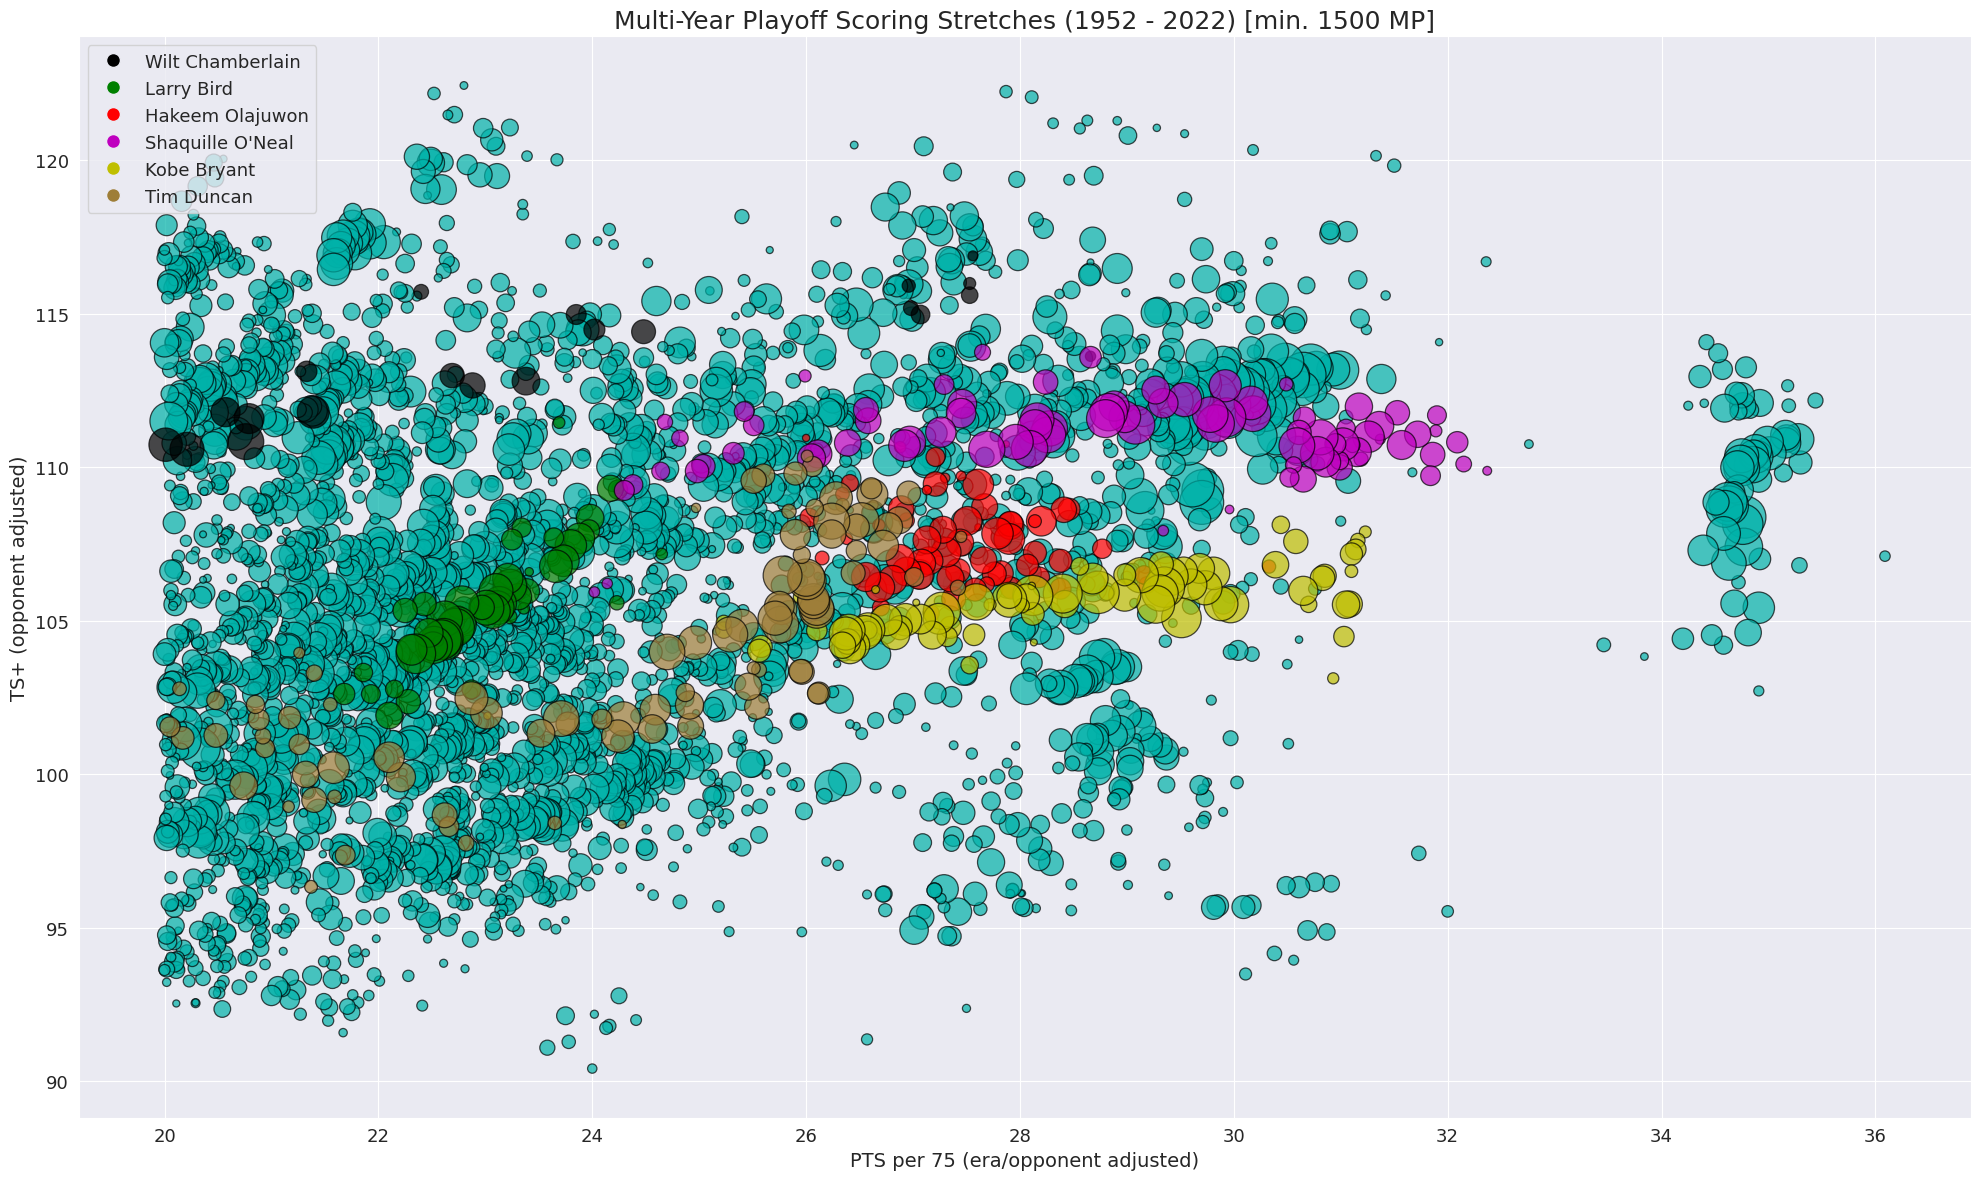

In [72]:
plotScoring(["Wilt Chamberlain", "Larry Bird", "Hakeem Olajuwon", "Shaquille O\'Neal", "Kobe Bryant", "Tim Duncan"], ["k", "g", "r", "m", "y", "#9E7E38"], 20, 80, 140, 1500)

In [73]:
#@title Scoring Plot (Series)
def plotScoringSeries(player_list, color_list, pts_floor, ts_floor, ts_ceiling, mp_floor):

  graph_data = pd.read_csv('/content/series_data_52_22.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS/G']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= mp_floor]
  graph_data = graph_data.dropna()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#00B2A9")
    else:
      continue
    first_loop_check = first_loop_check + 1

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)

  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min() - 150)) / (graph_data['MP'].max() - (graph_data['MP'].min() - 150)))
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="PTS/G", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.9, 'edgecolor':'k'})
  titlestring = f'Playoff Scoring (Series-Level) (1952 - 2022) [min. {mp_floor} MP]'
  ax.set(title=titlestring, xlabel='PTS/G (opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  ax.legend(handles=legend_elements, loc='upper left')

  fig.savefig(f'{player_list}_Scoring_Series', bbox_inches='tight')

In [71]:
#@title Scoring Plot (Single)
def plotScoring(player_list, color_list, pts_floor, ts_floor, ts_ceiling, mp_floor):

  graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= mp_floor]
  graph_data = graph_data.dropna()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#00B2A9")
    else:
      continue
    first_loop_check = first_loop_check + 1

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)

  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min() - 150)) / (graph_data['MP'].max() - (graph_data['MP'].min() - 150)))
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'})
  titlestring = f'Multi-Year Playoff Scoring Stretches (1952 - 2022) [min. {mp_floor} MP]'
  ax.set(title=titlestring, xlabel='PTS per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  ax.legend(handles=legend_elements, loc='upper left')

  fig.savefig(f'{player_list}_Scoring', bbox_inches='tight')

In [69]:
#@title Scoring Plot (Multiple)
def plotScoring(player_list, color_list, pts_floor, ts_floor, ts_ceiling, dummy_mp_floor):


  fig, axis = plt.subplots(10)
  fig.set_figheight(85)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP']) >= 300]
  graph_data = graph_data.dropna()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#00B2A9")
    else:
      continue
    first_loop_check = first_loop_check + 1

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(35,18), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.7, 'edgecolor':'k'}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring (1952-2022) [>300 MP]', xlabel='Pts per 75 (era/opponent adjusted) (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#00B2A9")
    else:
      continue
    first_loop_check = first_loop_check + 1

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(35,18), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring (1952-2022) [>500 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[1].legend(handles=legend_elements, loc='upper left')
  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[1].plot(x_pred, pred, color="k", linewidth=3)




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 600)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#00B2A9")
    else:
      continue
    first_loop_check = first_loop_check + 1

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(35,18), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[2])
  axis[2].set(title='4 Year Playoff Scoring (1952-2022) [>600 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[2].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1000)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#00B2A9")
    else:
      continue
    first_loop_check = first_loop_check + 1

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(40,20), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[3])
  axis[3].set(title='5 Year Playoff Scoring (1952-2022) [>1000 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[3].plot(x_pred, pred, color="k", linewidth=3)




  # 6 year
  graph_data =  pd.read_csv('/content/Six_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1200)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#00B2A9")
    else:
      continue
    first_loop_check = first_loop_check + 1

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(40,20), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[4])
  axis[4].set(title='6 Year Playoff Scoring (1952-2022) [>1200 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[4].plot(x_pred, pred, color="k", linewidth=3)




  # 7 year
  graph_data =  pd.read_csv('/content/Seven_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1400)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#00B2A9")
    else:
      continue
    first_loop_check = first_loop_check + 1

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(40,20), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[5])
  axis[5].set(title='7 Year Playoff Scoring (1952-2022) [>1400 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[5].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[5].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#00B2A9")
    else:
      continue
    first_loop_check = first_loop_check + 1

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(40,20), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[6])
  axis[6].set(title='8 Year Playoff Scoring (1952-2022) [>1500 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[6].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[6].plot(x_pred, pred, color="k", linewidth=3)


  # 9 year
  graph_data =  pd.read_csv('/content/Nine_Year_scoring_Playoff_Peaks_1700min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#00B2A9")
    else:
      continue
    first_loop_check = first_loop_check + 1

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(40,20), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[7])
  axis[7].set(title='9 Year Playoff Scoring (1952-2022) [>1700 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[7].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[6].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#00B2A9")
    else:
      continue
    first_loop_check = first_loop_check + 1

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)

  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(40,20), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[8])
  axis[8].set(title='10 Year Playoff Scoring (1952-2022) [>2000 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[8].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[8].plot(x_pred, pred, color="k", linewidth=3)



  # 1 year
  graph_data =  pd.read_csv('/content/era_opponent_adjusted_per75_data.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP']) >= 150]
  graph_data = graph_data[(graph_data['TS%+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS%+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#00B2A9")
    else:
      continue
    first_loop_check = first_loop_check + 1

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(40,20), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS%+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[9])
  axis[9].set(title='1 Year Playoff Scoring (1952-2022) [> 150 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[9].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS%+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[8].plot(x_pred, pred, color="k", linewidth=3)
  plt.show()

  fig.savefig(f'{p1}_Scoring_Peaks', bbox_inches='tight')

In [ ]:
#@title PBP Plot
def plotOnePBP(p1, c1):
  fig, axis = plt.subplots(8)
  fig.set_figheight(85)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_pbp_Peaks_NBA_Playoffs_300_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_player_df = graph_data[graph_data["Player"] == p1]
  graph_data = graph_data[graph_data["Player"] != p1]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[0])
  axis[0].set(title='3 Year Playoff PBP (1997-2022) [>500 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_pbp_Peaks_NBA_Playoffs_600_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_player_df = graph_data[graph_data["Player"] == p1]
  graph_data = graph_data[graph_data["Player"] != p1]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[1])
  axis[1].set(title='4 Year Playoff PBP (1997-2022) [>600 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[1].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_player_df = graph_data[graph_data["Player"] == p1]
  graph_data = graph_data[graph_data["Player"] != p1]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[2])
  axis[2].set(title='5 Year Playoff PBP (1997-2022) [>1000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[2].plot(x_pred, pred, color="k", linewidth=3)




  # 6 year
  graph_data =  pd.read_csv('/content/Six_Year_pbp_Peaks_NBA_Playoffs_1400_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1400)]
  graph_data = graph_data.dropna()

  tmp_player_df = graph_data[graph_data["Player"] == p1]
  graph_data = graph_data[graph_data["Player"] != p1]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[3])
  axis[3].set(title='6 Year Playoff PBP (1997-2022) [>1400 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[3].plot(x_pred, pred, color="k", linewidth=3)




  # 7 year
  graph_data =  pd.read_csv('/content/Seven_Year_pbp_Peaks_NBA_Playoffs_2000_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_player_df = graph_data[graph_data["Player"] == p1]
  graph_data = graph_data[graph_data["Player"] != p1]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[4])
  axis[4].set(title='7 Year Playoff PBP (1997-2022) [>2000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[4].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Eight_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_player_df = graph_data[graph_data["Player"] == p1]
  graph_data = graph_data[graph_data["Player"] != p1]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[5])
  axis[5].set(title='8 Year Playoff PBP (1997-2022) [>3000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[5].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[5].plot(x_pred, pred, color="k", linewidth=3)

  # 9 year
  graph_data =  pd.read_csv('/content/Nine_Year_pbp_Playoff_Peaks_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_player_df = graph_data[graph_data["Player"] == p1]
  graph_data = graph_data[graph_data["Player"] != p1]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[6])
  axis[6].set(title='9 Year Playoff PBP (1997-2022) [>3000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[6].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[6].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Ten_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_player_df = graph_data[graph_data["Player"] == p1]
  graph_data = graph_data[graph_data["Player"] != p1]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[7])
  axis[7].set(title='10 Year Playoff PBP (1997-2022) [>3000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[7].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[7].plot(x_pred, pred, color="k", linewidth=3)

  fig.savefig(f'{p1}_PBP_Peaks', bbox_inches='tight')

def plotTwoPBP(p1, p2, c1, c2):
  fig, axis = plt.subplots(8)
  fig.set_figheight(85)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_pbp_Peaks_NBA_Playoffs_300_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_player_df = graph_data[graph_data["Player"] == p1]
  graph_data = graph_data[graph_data["Player"] != p1]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
  tmp_player_df = graph_data[graph_data["Player"] == p2]
  graph_data = graph_data[graph_data["Player"] != p2]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[0])
  axis[0].set(title='3 Year Playoff PBP (1997-2022) [>500 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_pbp_Peaks_NBA_Playoffs_600_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_player_df = graph_data[graph_data["Player"] == p1]
  graph_data = graph_data[graph_data["Player"] != p1]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
  tmp_player_df = graph_data[graph_data["Player"] == p2]
  graph_data = graph_data[graph_data["Player"] != p2]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[1])
  axis[1].set(title='4 Year Playoff PBP (1997-2022) [>600 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[1].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_player_df = graph_data[graph_data["Player"] == p1]
  graph_data = graph_data[graph_data["Player"] != p1]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
  tmp_player_df = graph_data[graph_data["Player"] == p2]
  graph_data = graph_data[graph_data["Player"] != p2]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)

  graph_data['MPG'] = graph_data['MP'] / graph_data['G']
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[2])
  axis[2].set(title='5 Year Playoff PBP (1997-2022) [>1000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[2].plot(x_pred, pred, color="k", linewidth=3)




  # 6 year
  graph_data =  pd.read_csv('/content/Six_Year_pbp_Peaks_NBA_Playoffs_1400_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1400)]
  graph_data = graph_data.dropna()

  tmp_player_df = graph_data[graph_data["Player"] == p1]
  graph_data = graph_data[graph_data["Player"] != p1]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
  tmp_player_df = graph_data[graph_data["Player"] == p2]
  graph_data = graph_data[graph_data["Player"] != p2]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[3])
  axis[3].set(title='6 Year Playoff PBP (1997-2022) [>1400 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[3].plot(x_pred, pred, color="k", linewidth=3)




  # 7 year
  graph_data =  pd.read_csv('/content/Seven_Year_pbp_Peaks_NBA_Playoffs_2000_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_player_df = graph_data[graph_data["Player"] == p1]
  graph_data = graph_data[graph_data["Player"] != p1]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
  tmp_player_df = graph_data[graph_data["Player"] == p2]
  graph_data = graph_data[graph_data["Player"] != p2]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[4])
  axis[4].set(title='7 Year Playoff PBP (1997-2022) [>2000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[4].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Eight_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_player_df = graph_data[graph_data["Player"] == p1]
  graph_data = graph_data[graph_data["Player"] != p1]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
  tmp_player_df = graph_data[graph_data["Player"] == p2]
  graph_data = graph_data[graph_data["Player"] != p2]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[5])
  axis[5].set(title='8 Year Playoff PBP (1997-2022) [>3000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[5].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[5].plot(x_pred, pred, color="k", linewidth=3)


  # 9 year
  graph_data =  pd.read_csv('/content/Nine_Year_pbp_Playoff_Peaks_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_player_df = graph_data[graph_data["Player"] == p1]
  graph_data = graph_data[graph_data["Player"] != p1]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
  tmp_player_df = graph_data[graph_data["Player"] == p2]
  graph_data = graph_data[graph_data["Player"] != p2]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[6])
  axis[6].set(title='9 Year Playoff PBP (1997-2022) [>3000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[6].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[6].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Ten_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_player_df = graph_data[graph_data["Player"] == p1]
  graph_data = graph_data[graph_data["Player"] != p1]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
  tmp_player_df = graph_data[graph_data["Player"] == p2]
  graph_data = graph_data[graph_data["Player"] != p2]
  graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*13, 'linewidth':0.9, 'edgecolor':'k'}, ax=axis[7])
  axis[7].set(title='10 Year Playoff PBP (1997-2022) [>3000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[7].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[7].plot(x_pred, pred, color="k", linewidth=3)

  fig.savefig(f'{p1}_{p2}_PBP_Peaks', bbox_inches='tight')

In [61]:
#@title Scoring Change Plot
def p_plotScoringChange(player_list, color_list, pts_floor, mp_floor):

  graph_data = pd.read_csv('/content/All_Scoring_Changes_500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post']) >= mp_floor]
  graph_data = graph_data.dropna()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#00B2A9")
    else:
      continue
    first_loop_check = first_loop_check + 1

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.9, 'edgecolor':'k'})
  titlestring = f"Multi-Year Playoff Scoring Changes from Reg to Post (1952 - 2022) [min. {pts_floor} Pts per 75 Postseason; min. {mp_floor} MP]"
  ax.set(title=titlestring, xlabel='Change in PTS per 75', ylabel='Change in TS+')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[0].legend(handles=legend_elements, loc='upper left')

  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  ax.hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  ax.axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{p1}_Scoring_Changes', bbox_inches='tight')

In [65]:
#@title Scoring Change w Lines Plot
def p_plotScoringChangeWithLines(player_list, color_list, pts_floor, ts_floor, ts_ceiling, label, mp_floor):


  fig, axis = plt.subplots(4)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[0])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#00B2A9")
    else:
      continue
    first_loop_check = first_loop_check + 1

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.1, 'edgecolor':'k'}, ax=axis[0])
  titlestring = f"2 Year Playoff Scoring Change from Reg->Post (1952-2022) [>{mp_floor[0]} MP]"
  axis[0].set(title=titlestring, xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[0].legend(handles=legend_elements, loc='upper left')

  for player, color in zip(player_list, color_list):
    player_df = graph_data[(graph_data["Player"] == player)]

    point1 = [player_df['PTS per 75_post']-player_df['PTS_change'], player_df['TS+_post']-player_df['TS+_change']]
    point2 = [player_df['PTS per 75_post'], player_df['TS+_post']]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    axis[0].plot(x_values, y_values, color, linestyle="--")

  if label == 1:
    label_point(graph_data['PTS per 75_post'], graph_data['TS+_post'], graph_data['Years'], axis[0])




  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[1])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#00B2A9")
    else:
      continue
    first_loop_check = first_loop_check + 1

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.1, 'edgecolor':'k'}, ax=axis[1])
  titlestring = f"3 Year Playoff Scoring Change from Reg->Post (1952-2022) [>{mp_floor[1]} MP]"
  axis[1].set(title=titlestring, xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[1].legend(handles=legend_elements, loc='upper left')

  for player, color in zip(player_list, color_list):
    player_df = graph_data[(graph_data["Player"] == player)]

    point1 = [player_df['PTS per 75_post']-player_df['PTS_change'], player_df['TS+_post']-player_df['TS+_change']]
    point2 = [player_df['PTS per 75_post'], player_df['TS+_post']]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    axis[1].plot(x_values, y_values, color, linestyle="--")

  if label == 1:
    label_point(graph_data['PTS per 75_post'], graph_data['TS+_post'], graph_data['Years'], axis[1])




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[2])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#00B2A9")
    else:
      continue
    first_loop_check = first_loop_check + 1

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.1, 'edgecolor':'k'}, ax=axis[2])
  titlestring = f"4 Year Playoff Scoring Change from Reg->Post (1952-2022) [>{mp_floor[2]} MP]"
  axis[2].set(title=titlestring, xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[2].legend(handles=legend_elements, loc='upper left')

  for player, color in zip(player_list, color_list):
    player_df = graph_data[(graph_data["Player"] == player)]

    point1 = [player_df['PTS per 75_post']-player_df['PTS_change'], player_df['TS+_post']-player_df['TS+_change']]
    point2 = [player_df['PTS per 75_post'], player_df['TS+_post']]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    axis[2].plot(x_values, y_values, color, linestyle="--")

  if label == 1:
    label_point(graph_data['PTS per 75_post'], graph_data['TS+_post'], graph_data['Years'], axis[2])





  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[3])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#00B2A9")
    else:
      continue
    first_loop_check = first_loop_check + 1

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.1, 'edgecolor':'k'}, ax=axis[3])
  titlestring = f"5 Year Playoff Scoring Change from Reg->Post (1952-2022) [>{mp_floor[3]} MP]"
  axis[3].set(title=titlestring, xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  axis[3].legend(handles=legend_elements, loc='upper left')

  for player, color in zip(player_list, color_list):
    player_df = graph_data[(graph_data["Player"] == player)]

    point1 = [player_df['PTS per 75_post']-player_df['PTS_change'], player_df['TS+_post']-player_df['TS+_change']]
    point2 = [player_df['PTS per 75_post'], player_df['TS+_post']]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    axis[3].plot(x_values, y_values, color, linestyle="--")

  if label == 1:
    label_point(graph_data['PTS per 75_post'], graph_data['TS+_post'], graph_data['Years'], axis[3])

  fig.savefig(f'{player_list}_Scoring_Changes_With_Lines', bbox_inches='tight')

In [57]:
#@title Career Scoring Change w Lines Plot
def p_plotScoringChangeWithLinesCareer(player_list, color_list, pts_floor, ts_floor, ts_ceiling):

  graph_data = pd.read_csv('/content/Career_Playoff_Scoring_Change_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    tmp_player_df = graph_data[graph_data["Player"] == player]
    graph_data = graph_data[graph_data["Player"] != player]
    graph_data = pd.concat([graph_data, tmp_player_df], ignore_index=False)
    if first_loop_check == 0:
      first_cond = (graph_data['Player']== player)
      graph_data['color'] = np.where(first_cond==True, color, "#00B2A9")
    else:
      continue
    first_loop_check = first_loop_check + 1

  for player, color in zip(player_list, color_list):
    graph_data['color'] = np.where((graph_data.Player == player),color, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  ax = sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.4, 'edgecolor':'k'})
  ax.set(title='Career Playoff Scoring Change from Reg->Post (1952-2022) [>2000 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  first_loop_check = 0
  for player, color in zip(player_list, color_list):
    if first_loop_check == 0:
      legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
    else:
      legend_elements_tmp = [Line2D([0], [0], marker='o', color='#EAEAF2', label=player, markerfacecolor=color,  markersize=10)]
      legend_elements = legend_elements + legend_elements_tmp
    first_loop_check = first_loop_check + 1
  ax.legend(handles=legend_elements, loc='upper left')

  point1 = [graph_data['PTS per 75_post']-graph_data['PTS_change'], graph_data['TS+_post']-graph_data['TS+_change']]
  point2 = [graph_data['PTS per 75_post'], graph_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  ax.plot(x_values, y_values, "#00B2A9", linestyle="--")

  for player, color in zip(player_list, color_list):
    player_df = graph_data[(graph_data["Player"] == player)]

    point1 = [player_df['PTS per 75_post']-player_df['PTS_change'], player_df['TS+_post']-player_df['TS+_change']]
    point2 = [player_df['PTS per 75_post'], player_df['TS+_post']]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax.plot(x_values, y_values, color, linestyle="--")

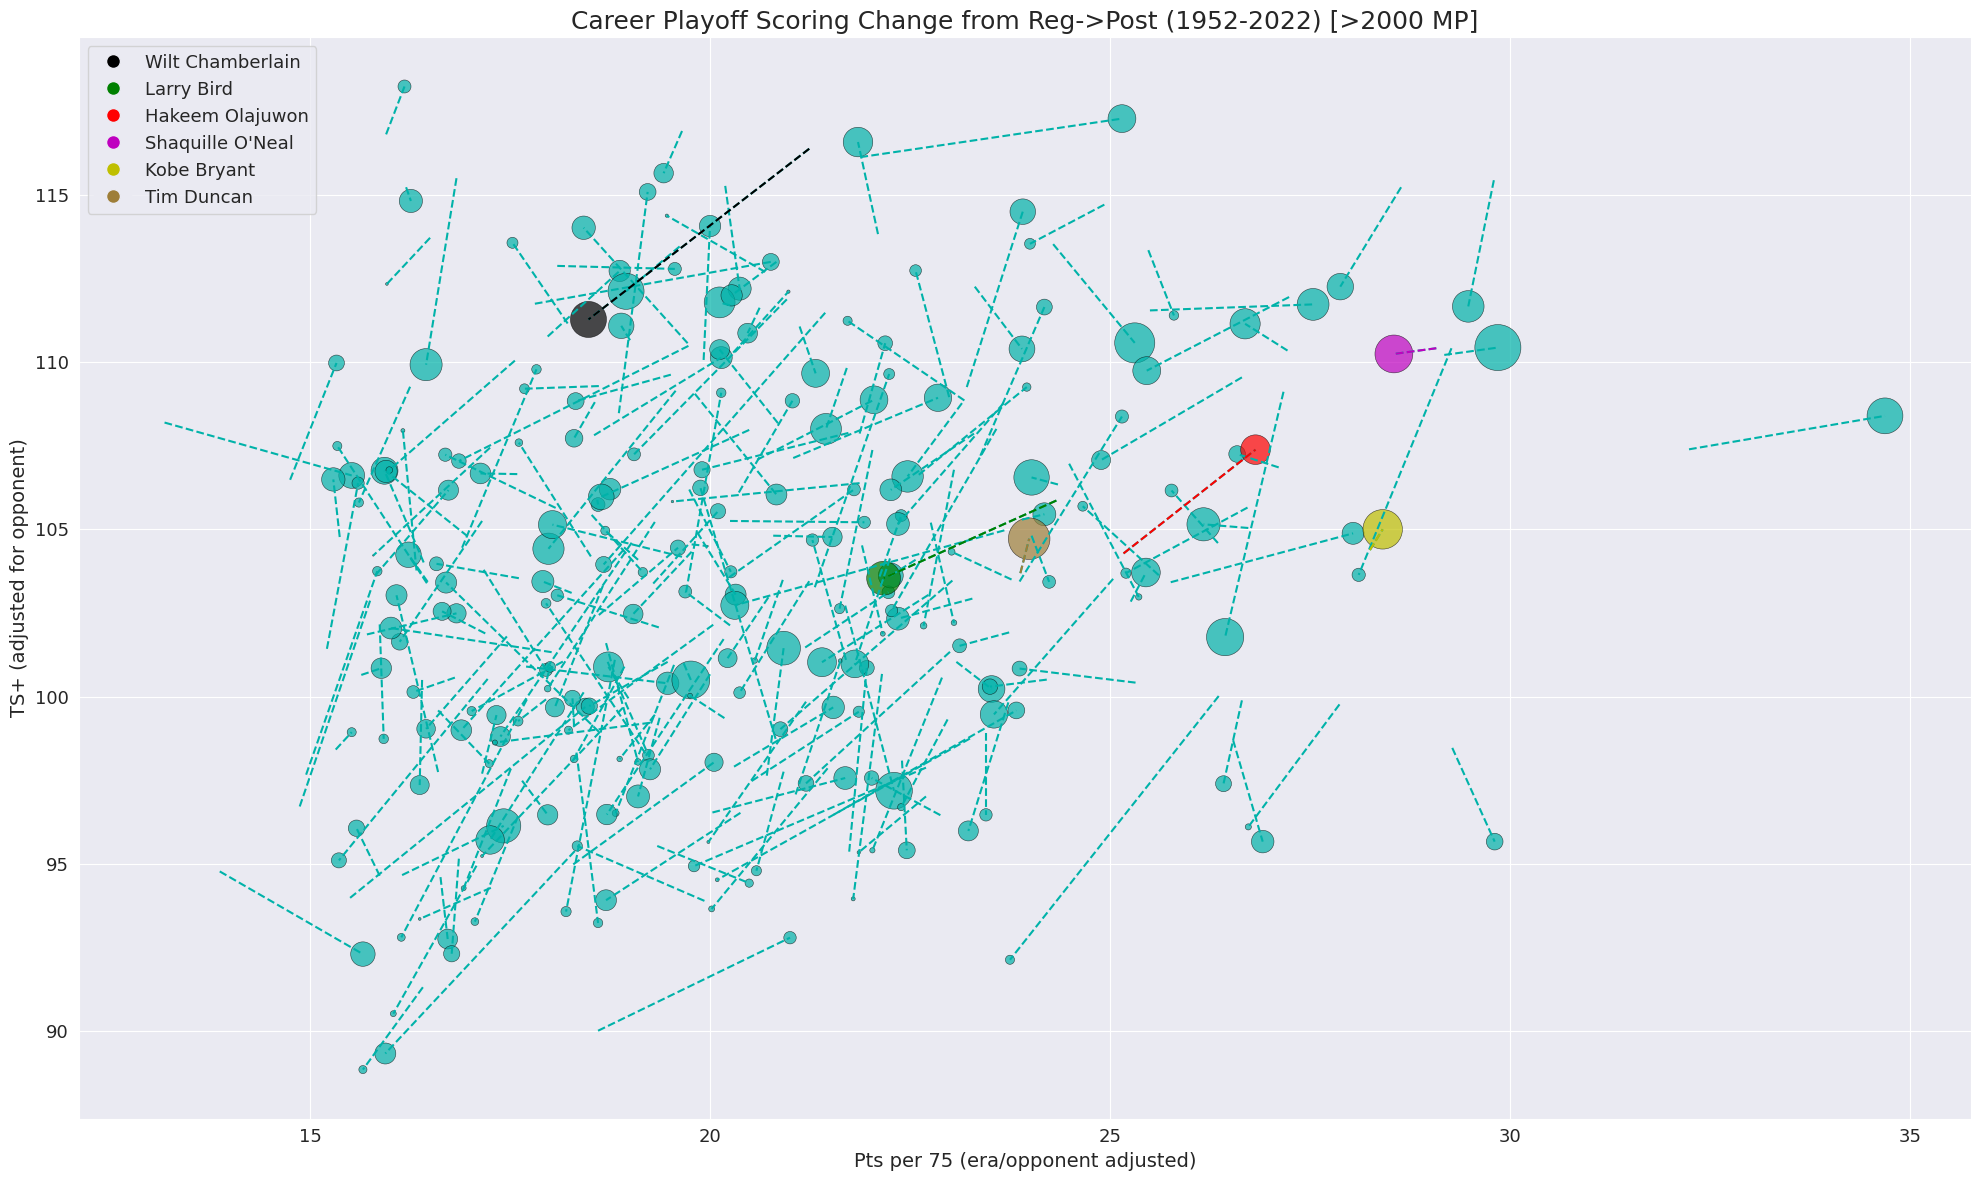

In [67]:
p_plotScoringChangeWithLinesCareer(["Wilt Chamberlain", "Larry Bird", "Hakeem Olajuwon", "Shaquille O\'Neal", "Kobe Bryant", "Tim Duncan"], ["k", "g", "r", "m", "y", "#9E7E38"], 15, 80, 140)

In [ ]:
plotTwoPBP("Tony Parker", "Manu Ginóbili", "#EF426F", "#FF8200")

In [ ]:
#@title Plot a Team's Scoring
def plotTeamScoring(first_year, last_year, team, c1, pts_floor, ts_floor, ts_ceiling, mp_floor, label):

  graph_data = pd.read_csv('/content/52-22_Single_Playoffs_Adjusted_Scoring.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PP75']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= mp_floor]

  graph_data['Year'] = graph_data['Year'].astype(int)
  graph_data = graph_data.dropna()

  first_tmp_team_df = graph_data[graph_data["Team"] == team]
  first_tmp_team_df = first_tmp_team_df[(first_tmp_team_df['Year'] >= first_year)]
  first_tmp_team_df = first_tmp_team_df[(first_tmp_team_df['Year'] <= last_year)]
  graph_data = graph_data[graph_data["Team"] != team]
  graph_data = pd.concat([graph_data, first_tmp_team_df], ignore_index=False)
  graph_data = graph_data[(graph_data['Year'] >= first_year)]
  graph_data = graph_data[(graph_data['Year'] <= last_year)]

  first_cond = (graph_data['Team']== team)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  size = 100 * ((graph_data['MPG'] - (graph_data['MPG'].min() - 150)) / (graph_data['MPG'].max() - (graph_data['MPG'].min() - 150)))
  fig = plt.figure(figsize=(40,24), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="PP75", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  titlestring = f"Single Playoff Scoring Peaks (1952 - 2022) [min. {mp_floor} MP]"
  ax.set(title=titlestring, xlabel='PTS per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=f"{team} {first_year} - {last_year}", markerfacecolor=c1,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')
  
  # ridge regression
  x_pred = graph_data['PP75']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  ax.plot(x_pred, pred, color="k", linewidth=3)

  if label == 1:
    label_point_year(first_tmp_team_df['PP75'], first_tmp_team_df['TS+'], first_tmp_team_df['Year'], ax)
    label_point(first_tmp_team_df['PP75'], first_tmp_team_df['TS+']+0.15, first_tmp_team_df['Player'], ax)

  fig.savefig(f'{team}_Scoring', bbox_inches='tight')

In [ ]:
plotTeamScoring(1998, 2019, "SAS", "#C4CED4", 15, 80, 140, 300, 1)

**SERIES PERCENTILES**

In [ ]:
players = ['Kareem Abdul-Jabbar', 'Jerry West', 'LeBron James', 'Wilt Chamberlain', 'Michael Jordan',
           'Kevin McHale', 'Kevin Durant', 'Reggie Miller', 'Stephen Curry', 'Walt Frazier', 'Oscar Robertson',
           'Kawhi Leonard', "Shaquille O'Neal", 'Elgin Baylor', 'Julius Erving', 'Terry Porter', 'Dirk Nowitzki',
           'Charles Barkley', 'George Gervin', 'Bob Pettit', 'Rick Barry', 'Larry Bird', 'Cliff Hagan', 'Dwyane Wade',
           'Kobe Bryant', 'James Harden', 'Artis Gilmore', 'Hakeem Olajuwon', 'Zelmo Beaty', 'Tim Duncan', 'James Worthy',
           'Magic Johnson', 'Karl Malone', 'Steve Nash', 'Adrian Dantley', "Amar'e Stoudemire", 'Jimmy Jones', 'Dwight Howard',
           'Chris Paul', 'John Havlicek', 'Sam Jones', 'Giannis Antetokounmpo', 'Moses Malone', 'Roger Brown', 'Ray Allen', 'Clyde Drexler',
           'Pau Gasol', 'Jeff Hornacek', 'Manu Ginóbili', 'Deron Williams', 'Dolph Schayes', 'Bob Lanier', 'Willie Wise', 'Kyrie Irving', 'Shawn Kemp',
           'Kevin Johnson', 'Chauncey Billups', 'Elvin Hayes', 'Paul Pierce', 'Dan Issel']

series_data_df = pd.read_csv('/content/series_data_52_22.csv', encoding='utf8', index_col=False)

series_data_df = series_data_df[(series_data_df.Player.isin(players))]
print(series_data_df)
series_data_df.to_csv('good_scorers.csv', index=False)

In [ ]:
#@title Print Single Series
series_data_52_22_df = pd.read_csv('/content/series_data_52_22.csv', encoding='utf8', index_col=False)
tmp = series_data_52_22_df[(series_data_52_22_df['PTS/G']) >= 33]
tmp = tmp.sort_values('Year', ascending=True)

tmp = tmp[(tmp['Year']) >= 1976]
tmp = tmp[(tmp['TS+']) >= 110]
tmp = tmp[(tmp['MP']) >= 100]
#tmp = tmp[(tmp['Player'] == 'Manu Ginóbili')]
print(tmp)

In [ ]:
#@title Print PTS/TS+ percentiles for a players' series
series_data_52_22_df = pd.read_csv('/content/series_data_52_22.csv', encoding='utf8', index_col=False) 
def printSeries_PTS_TS_Percentiles(p1, mp_min, pts_min):
  graph_data =  series_data_52_22_df.copy()
  graph_data = graph_data[(graph_data['PTS/G'] >= pts_min)]
  graph_data = graph_data[(graph_data['MP'] >= mp_min)]
  graph_data['Approx_Scoring_Val'] = 0

  for idx, row in graph_data.iterrows():
    pts = row['PTS/G']
    ts = row['TS+']
    mp = row['MP']
    pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
    ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
    approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
    graph_data.at[idx, 'Approx_Scoring_Val'] = approx_scoring_val


  final_season_df = pd.DataFrame(columns = ['Series', f"{p1} PTS percentile", f"{p1} TS+ percentile", f"{p1} Approx_Scoring_Val",f"{p1} MP"])

  players_df = series_data_52_22_df[(series_data_52_22_df['Player'] == p1)]
  players_df['index'] = players_df.index
  players_df = players_df.sort_values(by = ['Year', 'index'], ascending = [True, True])

  for idx, row in players_df.iterrows():
    pts = row['PTS/G']
    ts = row['TS+']
    mp = row['MP']
    pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
    ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
    p1_approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
    p1_approx_scoring_val = stats.percentileofscore(graph_data['Approx_Scoring_Val'], p1_approx_scoring_val)
    series = str(row['Year']) + " " + row['Opp']
    new_row = {'Series':series,  f"{p1} PTS percentile":pts_percentile, f"{p1} TS+ percentile": ts_percentile, f"{p1} Approx_Scoring_Val":p1_approx_scoring_val, f"{p1} MP":int(mp)}
    final_season_df = final_season_df.append(new_row, ignore_index=True)
  print(final_season_df)

In [ ]:
#@title Print PTS/TS+ percentiles for mutli players' series
series_data_52_22_df = pd.read_csv('/content/series_data_52_22.csv', encoding='utf8', index_col=False) 
def printMultiSeries_PTS_TS_Percentiles(mp_min, pts_min):
  graph_data =  series_data_52_22_df.copy()
  graph_data = graph_data[(graph_data['PTS/G'] >= pts_min)]
  graph_data = graph_data[(graph_data['MP'] >= mp_min)]
  graph_data['Approx_Scoring_Val'] = 0

  for idx, row in graph_data.iterrows():
    pts = row['PTS/G']
    ts = row['TS+']
    mp = row['MP']
    pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
    ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
    approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
    graph_data.at[idx, 'Approx_Scoring_Val'] = approx_scoring_val


  final_season_df = pd.DataFrame(columns = ['Player', 'Series', f"PTS percentile", f"TS+ percentile", f"Approx_Scoring_Val",f"MP"])

  players_df = pd.read_csv('/content/Finals.csv', encoding='utf8')
  players_df['index'] = players_df.index
  players_df = players_df.sort_values(by = ['Year', 'index'], ascending = [True, True])

  for idx, row in players_df.iterrows():
    pts = row['PTS/G']
    ts = row['TS+']
    mp = row['MP']
    pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
    ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
    p1_approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
    p1_approx_scoring_val = stats.percentileofscore(graph_data['Approx_Scoring_Val'], p1_approx_scoring_val)
    series = str(row['Year']) + " " + row['Opp']
    player = row['Player']
    new_row = {'Player': player, 'Series':series,  f"PTS percentile":pts_percentile, f"TS+ percentile": ts_percentile, f"Approx_Scoring_Val":p1_approx_scoring_val, f"MP":int(mp)}
    final_season_df = final_season_df.append(new_row, ignore_index=True)
  final_season_df = final_season_df.sort_values('Approx_Scoring_Val', ascending=False)
  final_season_df['PTS percentile'] = final_season_df['PTS percentile'].round(2)
  final_season_df['TS+ percentile'] = final_season_df['TS+ percentile'].round(2)
  final_season_df['Approx_Scoring_Val'] = final_season_df['Approx_Scoring_Val'].round(2)
  final_season_df = final_season_df.reset_index()
  final_season_df = final_season_df.drop(columns='index')
  print(final_season_df)

In [ ]:
printMultiSeries_PTS_TS_Percentiles(75, 0)

In [ ]:
#@title Manually Find Stretch of Approx_Scoring_Val
def stretchesApproxScoringVal(p1, p2, file):
  series_data_df = pd.read_csv(file, encoding='utf8', index_col=False)

  total_mp_a = 0
  total_pts_a = 0
  total_ts_a = 0

  total_mp_b = 0
  total_pts_b = 0
  total_ts_b = 0
  mp_list_a = []
  mp_list_b = []

  # find total minutes a
  for mp in series_data_df[f'{p1} MP']:
    mp_list_a.append(mp)
    total_mp_a += mp

  # find total approx_scoring_val
  i = 0
  for approx_scoring_val in series_data_df[f'{p1} Approx_Scoring_Val']:
    total_pts_a += approx_scoring_val * (mp_list_a[i] / total_mp_a)
    i = i + 1

  print(p1)
  print("Approx_Scoring_Val: ", total_pts_a)
  print("MP: ",total_mp_a)

  # find total minutes
  for mp in series_data_df[f'{p2} MP']:
    mp_list_b.append(mp)
    total_mp_b += mp
  print("\n")

  # find total PTS
  i = 0
  for approx_scoring_val in series_data_df[f'{p2} Approx_Scoring_Val']:
    total_pts_b += approx_scoring_val * (mp_list_b[i] / total_mp_b)
    i = i + 1

  print(p2)
  print("Approx_Scoring_Cal: ", total_pts_b)
  print("MP: ",total_mp_b)

In [ ]:
#@title allStretchesApproxScoringVal
def allStretchesApproxScoringVal(file, min_series_stretch):
  series_data_df = pd.read_csv(file, encoding='utf8', index_col=False)

  # create Approx_Scoring_Val for each series
  for idx, row in series_data_df.iterrows():
    pts = row['PTS/G']
    ts = row['TS+']
    mp = row['MP']
    pts_percentile = stats.percentileofscore(series_data_df['PTS/G'], pts)
    ts_percentile = stats.percentileofscore(series_data_df['TS+'], ts)
    approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
    series_data_df.at[idx, 'Approx_Scoring_Val'] = approx_scoring_val

  final_series_df = pd.DataFrame(columns = ['Player', 'First Series', 'Last Series', "Approx_Scoring_Val", "PTS/G", "TS+", "MP"])

  players_list = series_data_df['Player']
  players_list = players_list.drop_duplicates()

  for player in players_list:

    single_player_df = series_data_df[(series_data_df['Player'] == player)]

    new_first_series_index = 0
    num_of_series = single_player_df.shape[0]
    how_many_passes = num_of_series - min_series_stretch
    while new_first_series_index <= how_many_passes:
      tmp = single_player_df.iloc[new_first_series_index:]
      tmp = tmp.reset_index(drop=True)
      num_of_series = tmp.shape[0]
      if num_of_series < min_series_stretch:
        continue
    
      for series_stretch in range(min_series_stretch, num_of_series+1):

        total_mp = 0
        total_approx_scoring_val = 0
        total_pts = 0
        total_ts = 0
        mp_list = []

        idx_find_first_series = 0

        # find total minutes
        i = 0
        for mp in tmp['MP']:
          if i >= series_stretch:
            continue
          if idx_find_first_series == 0:
            first_series = str(tmp.loc[i, 'Year']) + " " + tmp.loc[i, 'Opp']
            idx_find_first_series = 1

          mp_list.append(mp)
          total_mp += mp
          last_series = str(tmp.loc[i, 'Year']) + " " + tmp.loc[i, 'Opp']
          i = i + 1

        i = 0
        for approx_scoring_val in tmp['Approx_Scoring_Val']:
          if i >= series_stretch:
            continue
          total_approx_scoring_val += approx_scoring_val * (mp_list[i] / total_mp)
          i = i + 1
        i = 0
        for pts in tmp['PTS/G']:
          if i >= series_stretch:
            continue
          total_pts += pts * (mp_list[i] / total_mp)
          i = i + 1
        i = 0
        for ts in tmp['TS+']:
          if i >= series_stretch:
            continue
          total_ts += ts * (mp_list[i] / total_mp)
          i = i + 1

        total_approx_scoring_val = '%.2f' % round(total_approx_scoring_val, 2)
        total_pts = '%.2f' % round(total_pts, 2)
        total_ts = '%.2f' % round(total_ts, 2)
        new_row = {'Player':player, 'First Series':first_series, 'Last Series':last_series, "PTS/G":total_pts, "TS+":total_ts, "Approx_Scoring_Val":total_approx_scoring_val, "MP":total_mp}
        new_df = pd.DataFrame(data=new_row, index = [0])
        final_series_df = pd.concat([final_series_df, new_df], axis=0)
        outfile = f"Stretches_Of_Series_Percentiles.csv"
        final_series_df.to_csv(outfile, index=False)
      new_first_series_index = new_first_series_index + 1

In [ ]:
allStretchesApproxScoringVal('/content/series_data_52_22.csv', 5)

In [ ]:
#@title Print Single Player stretch
def printSinglePlayerStretch(series_stretches_file, mp_min, mp_max, unique_players, best_or_worst, first_or_last, player):

  series_data_df = pd.read_csv(series_stretches_file, encoding='utf8', index_col=False)
  series_data_df = series_data_df[(series_data_df['MP'] >= mp_min)]
  series_data_df = series_data_df[(series_data_df['MP'] <= mp_max)]

  if best_or_worst == 'best':
    series_data_df = series_data_df.sort_values('Approx_Scoring_Val', ascending=False)
  elif best_or_worst == 'worst':
    series_data_df = series_data_df.sort_values('Approx_Scoring_Val', ascending=True)
  series_data_df['Approx_Scoring_Val'] = series_data_df['Approx_Scoring_Val'].round(2)
  

  if unique_players == 1:
    if first_or_last == 'first':
      series_data_df = series_data_df.drop_duplicates('Player', keep='first')
    elif first_or_last == 'last':
      series_data_df = series_data_df.drop_duplicates('Player', keep='last')
  series_data_df = series_data_df.reset_index(drop=True)
  series_data_df['Historical Player Rank'] = series_data_df.index
  #print(series_data_df.shape[0])
  series_data_df = series_data_df[(series_data_df['Player'] == player)]
  series_data_df = series_data_df.drop(columns='Historical Player Rank')
  

  
  titlestring = f"\tBest Playoff Scoring Stretches (max 1 per player)\n\t\t\t\t Minimum {mp_min} MP\n"

  print(titlestring)
  
  print(series_data_df)

  print("\n\t'Approx_Scoring_Val' = Historical percentile of opponent adjusted PTS/G (1952-2022) * 0.5 + \n\t\t\t\tHistorical percentile of TS+ (1952-2022)* 0.5\n\n\tPTS/G adjusted based on regular season rDefRtg of playoff opponents\n\tTS+ adjusted based on opponents' TS% allowed in regular season\n\t1952-73 pace & TS% allowed both estimated")

In [ ]:
printSinglePlayerStretch('/content/Stretches_Of_Series_Percentiles.csv', 2000, 11305, 1, "best", "first", "Damian Lillard")

In [ ]:
#@title Print Top Stretches of Series Stretch Lengths
def printTopSeriesStretches(series_stretches_file, mp_min, mp_max, list_length, unique_players, best_or_worst, first_or_last):

  series_data_df = pd.read_csv(series_stretches_file, encoding='utf8', index_col=False)
  series_data_df = series_data_df[(series_data_df['MP'] >= mp_min)]
  series_data_df = series_data_df[(series_data_df['MP'] <= mp_max)]

  if best_or_worst == 'best':
    series_data_df = series_data_df.sort_values('Approx_Scoring_Val', ascending=False)
  elif best_or_worst == 'worst':
    series_data_df = series_data_df.sort_values('Approx_Scoring_Val', ascending=True)
  series_data_df['Approx_Scoring_Val'] = series_data_df['Approx_Scoring_Val'].round(2)
  

  if unique_players == 1:
    if first_or_last == 'first':
      series_data_df = series_data_df.drop_duplicates('Player', keep='first')
    elif first_or_last == 'last':
      series_data_df = series_data_df.drop_duplicates('Player', keep='last')
  series_data_df = series_data_df.reset_index(drop=True)
  series_data_df['Historical Player Rank'] = series_data_df.index
  #print(series_data_df.shape[0])
  #series_data_df = series_data_df[(series_data_df['Player'] == 'James Harden') | (series_data_df['Player'] == 'Bruce Bowen') | (series_data_df['Historical Player Rank'] == 0) | (series_data_df['Historical Player Rank'] == 681)]
  #series_data_df = series_data_df[(series_data_df['Player'] == 'Manu Ginóbili') | (series_data_df['Player'] == 'Kyrie Irving') | (series_data_df['Player'] == 'Tim Duncan')]
  series_data_df = series_data_df[(series_data_df['Historical Player Rank'] <= list_length-1)]
  series_data_df = series_data_df.drop(columns='Historical Player Rank')
  #col_list = series_data_df.Player.values.tolist()
  #print(col_list)

  

  
  titlestring = f"\tBest Playoff Scoring Stretches (max 1 per player)\n\t\t\t\t Minimum {mp_min} MP\n"

  print(titlestring)
  
  print(series_data_df)

  series_data_df.to_csv('Top 2000 MP scoring stretches.csv',index=False)

  print("\n\t'Approx_Scoring_Val' = Historical percentile of opponent adjusted PTS/G (1952-2022) * 0.5 + \n\t\t\t\tHistorical percentile of TS+ (1952-2022)* 0.5\n\n\tPTS/G adjusted based on regular season rDefRtg of playoff opponents\n\tTS+ adjusted based on opponents' TS% allowed in regular season\n\t1952-73 pace & TS% allowed both estimated")

In [ ]:
#@title tmp approx_val_unique_stretches
def printTopSeriesStretches(series_stretches_file, mp_min, mp_max, list_length, unique_players, best_or_worst, first_or_last):

  series_data_df = pd.read_csv(series_stretches_file, encoding='utf8', index_col=False)
  series_data_df = series_data_df[(series_data_df['MP'] >= mp_min)]
  series_data_df = series_data_df[(series_data_df['MP'] <= mp_max)]

  series = pd.read_csv('/content/series_data_52_22.csv', encoding='utf8', index_col=False)
  series = series[(series['MP'] >= 100)]


  # create Approx_Scoring_Val for each series
  for idx, row in series_data_df.iterrows():
    pts = row['PTS']
    ts = row['TS+']
    mp = row['MP']
    pts_percentile = stats.percentileofscore(series['PTS/G'], pts)
    ts_percentile = stats.percentileofscore(series['TS+'], ts)
    s_color = (0.5 * pts_percentile) + (0.5 * ts_percentile)
    series_data_df.at[idx, 'Color'] = s_color

  series_data_df = series_data_df.sort_values('Color', ascending=False)
  series_data_df['Color'] = series_data_df['Color'].round(2)
  

  if unique_players == 1:
    series_data_df = series_data_df.drop_duplicates('Player', keep='first')
  series_data_df = series_data_df.reset_index(drop=True)
  #series_data_df['Historical Player Rank'] = series_data_df.index
  #print(series_data_df.shape[0])
  series_data_df = series_data_df[(series_data_df['PTS'] >= 20)]
  #series_data_df = series_data_df.drop(columns='Historical Player Rank')
  #col_list = series_data_df.Player.values.tolist()
  #print(col_list)

  

  
  titlestring = f"\tBest Playoff Scoring Stretches (max 1 per player)\n\t\t\t\t Minimum {mp_min} MP\n"

  print(titlestring)
  
  print(series_data_df)

  series_data_df.to_csv('Top 2500 MP scoring stretches.csv',index=False)

  print("\n\t'Approx_Scoring_Val' = Historical percentile of opponent adjusted PTS/G (1952-2022) * 0.5 + \n\t\t\t\tHistorical percentile of TS+ (1952-2022)* 0.5\n\n\tPTS/G adjusted based on regular season rDefRtg of playoff opponents\n\tTS+ adjusted based on opponents' TS% allowed in regular season\n\t1952-73 pace & TS% allowed both estimated")

In [ ]:
printTopSeriesStretches('/content/All_Scoring_Stretches_500min.csv', 1500, 11305, 60, 1, "best", "first")

In [ ]:
#@title Print Percentiles of Custom Playoff Series Stretches
def trimStretchesPrintPercentile(series_stretches_file, player, first_opp, last_opp, mp_min, mp_max):

  series_data_df = pd.read_csv(series_stretches_file, encoding='utf8', index_col=False)
  series_data_df = series_data_df[(series_data_df['MP'] >= mp_min)]
  series_data_df = series_data_df[(series_data_df['MP'] <= mp_max)]

  player_df = series_data_df[(series_data_df['Player'] == player) & (series_data_df['First Series'] == first_opp) & (series_data_df['Last Series'] == last_opp)]
  approx_scoring_val = float(player_df['Approx_Scoring_Val'])
  print("Approx Scoring Val")
  print(approx_scoring_val)
  approx_scoring_val_perc = stats.percentileofscore(series_data_df['Approx_Scoring_Val'], approx_scoring_val)
  print("Percentile")
  print(approx_scoring_val_perc)

In [ ]:
trimStretchesPrintPercentile('/content/Stretches_Of_Series_Percentiles.csv', 'Manu Ginóbili', '2005 DEN', '2006 DAL', 1200, 12000)

In [ ]:
#@title printSeriesScoringPercentiles

# plots the approx_scoring_percentile of two players in bar graph form
series_data_52_22_df = pd.read_csv('/content/series_data_52_22.csv', encoding='utf8', index_col=False) 
def printTwoSeriesScoringPercentiles(p1, p2, c1, c2, mp_min, pts_min):
  graph_data =  series_data_52_22_df.copy()
  graph_data = graph_data[(graph_data['PTS/G'] >= pts_min)]
  graph_data = graph_data[(graph_data['MP'] >= mp_min)]
  graph_data['Approx_Scoring_Val'] = 0

  for idx, row in graph_data.iterrows():
    pts = row['PTS/G']
    ts = row['TS+']
    mp = row['MP']
    pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
    ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
    approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
    graph_data.at[idx, 'Approx_Scoring_Val'] = approx_scoring_val


  final_season_df = pd.DataFrame(columns = ['Series', f"{p1} Approx_Scoring_Val", f"{p1} MP", f"{p2} Approx_Scoring_Val", f"{p2} MP"])

  players_df = series_data_52_22_df[(series_data_52_22_df['Player'] == p1) | (series_data_52_22_df['Player'] == p2)]
  players_df['index'] = players_df.index
  players_df = players_df.sort_values(by = ['Year', 'index'], ascending = [True, True])
  p1_df = players_df[(players_df['Player'] == p1)]
  p2_df = players_df[(players_df['Player'] == p2)]
  p2_df = p2_df.reset_index()
  p1_df = p1_df.reset_index()

  series_done = []

  recent_year = 1951
  round_count = 1
  for idx, row in players_df.iterrows():

    display_series_opponent = 0

    selected_series = str(row['Player']) + str(row['Year']) + row['Opp']
    if selected_series not in series_done:
      if row['Year'] == recent_year:
        round_count+= 1
      elif row['Year'] > recent_year:
        round_count = 1
        recent_year = row['Year']
      if row['Player'] == p1:
        if row['Year'] in p2_df.values:
          if round_count == 1:
            other_player_year = p2_df[(p2_df['Year'] == row['Year'])]
            other_player_year = other_player_year.reset_index(drop=True)
            pts = other_player_year.loc[round_count-1,'PTS/G']
            ts = other_player_year.loc[round_count-1,'TS+']
            mp_2 = other_player_year.loc[round_count-1,'MP']
            pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
            ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
            p2_approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
            p2_approx_scoring_val = stats.percentileofscore(graph_data['Approx_Scoring_Val'], p2_approx_scoring_val)
            this_series = str(other_player_year.loc[round_count-1,'Player']) + str(other_player_year.loc[round_count-1,'Year']) + str(other_player_year.loc[round_count-1,'Opp'])
            series_done.append(this_series)
            this_series = row['Player'] + str(row['Year']) + row['Opp']
            series_done.append(this_series)

            if (str(other_player_year.loc[round_count-1,'Year']) + str(other_player_year.loc[round_count-1,'Opp'])) == str(row['Year']) + row['Opp']:
              display_series_opponent = 1

          elif round_count == 2:
            try:
              other_player_year = p2_df[(p2_df['Year'] == row['Year'])]
              other_player_year = other_player_year.reset_index(drop=True)
              pts = other_player_year.loc[round_count-1,'PTS/G']
              ts = other_player_year.loc[round_count-1,'TS+']
              mp_2 = other_player_year.loc[round_count-1,'MP']
              pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
              ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
              p2_approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
              p2_approx_scoring_val = stats.percentileofscore(graph_data['Approx_Scoring_Val'], p2_approx_scoring_val)
              this_series = str(other_player_year.loc[round_count-1,'Player']) + str(other_player_year.loc[round_count-1,'Year']) + str(other_player_year.loc[round_count-1,'Opp'])
              series_done.append(this_series)
              this_series = row['Player'] + str(row['Year']) + row['Opp']
              series_done.append(this_series)

              if (str(other_player_year.loc[round_count-1,'Year']) + str(other_player_year.loc[round_count-1,'Opp'])) == str(row['Year']) + row['Opp']:
                display_series_opponent = 1
              
            except:
              p2_approx_scoring_val = 0
              mp_2 = 0
              this_series = row['Player'] + str(row['Year']) + row['Opp']
              series_done.append(this_series)
              display_series_opponent = 1
          elif round_count == 3:
            try:
              other_player_year = p2_df[(p2_df['Year'] == row['Year'])]
              other_player_year = other_player_year.reset_index(drop=True)
              pts = other_player_year.loc[round_count-1,'PTS/G']
              ts = other_player_year.loc[round_count-1,'TS+']
              mp_2 = other_player_year.loc[round_count-1,'MP']
              pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
              ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
              p2_approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
              p2_approx_scoring_val = stats.percentileofscore(graph_data['Approx_Scoring_Val'], p2_approx_scoring_val)
              this_series = str(other_player_year.loc[round_count-1,'Player']) + str(other_player_year.loc[round_count-1,'Year']) + str(other_player_year.loc[round_count-1,'Opp'])
              series_done.append(this_series)
              this_series = row['Player'] + str(row['Year']) + row['Opp']
              series_done.append(this_series)

              if (str(other_player_year.loc[round_count-1,'Year']) + str(other_player_year.loc[round_count-1,'Opp'])) == str(row['Year']) + row['Opp']:
                display_series_opponent = 1
            except:
              p2_approx_scoring_val = 0
              mp_2 = 0
              this_series = row['Player'] + str(row['Year']) + row['Opp']
              series_done.append(this_series)
              display_series_opponent = 1

          elif round_count == 4:
            try:
              other_player_year = p2_df[(p2_df['Year'] == row['Year'])]
              other_player_year = other_player_year.reset_index(drop=True)
              pts = other_player_year.loc[round_count-1,'PTS/G']
              ts = other_player_year.loc[round_count-1,'TS+']
              mp_2 = other_player_year.loc[round_count-1,'MP']
              pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
              ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
              p2_approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
              p2_approx_scoring_val = stats.percentileofscore(graph_data['Approx_Scoring_Val'], p2_approx_scoring_val)
              this_series = str(other_player_year.loc[round_count-1,'Player']) + str(other_player_year.loc[round_count-1,'Year']) + str(other_player_year.loc[round_count-1,'Opp'])
              series_done.append(this_series)
              this_series = row['Player'] + str(row['Year']) + row['Opp']
              series_done.append(this_series)

              if (str(other_player_year.loc[round_count-1,'Year']) + str(other_player_year.loc[round_count-1,'Opp'])) == str(row['Year']) + row['Opp']:
                display_series_opponent = 1
            except:
              p2_approx_scoring_val = 0
              mp_2 = 0
              this_series = row['Player'] + str(row['Year']) + row['Opp']
              series_done.append(this_series)
              display_series_opponent = 1
        else:
          p2_approx_scoring_val = 0
          mp_2 = 0
          display_series_opponent = 1
      if row['Player'] == p2:
        if row['Year'] in p1_df.values:
          if round_count == 1:
            other_player_year = p1_df[(p1_df['Year'] == row['Year'])]
            other_player_year = other_player_year.reset_index(drop=True)
            pts = other_player_year.loc[round_count-1,'PTS/G']
            ts = other_player_year.loc[round_count-1,'TS+']
            mp_1 = other_player_year.loc[round_count-1,'MP']
            pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
            ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
            p1_approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
            p1_approx_scoring_val = stats.percentileofscore(graph_data['Approx_Scoring_Val'], p1_approx_scoring_val)
            this_series = str(other_player_year.loc[round_count-1,'Player']) + str(other_player_year.loc[round_count-1,'Year']) + str(other_player_year.loc[round_count-1,'Opp'])
            series_done.append(this_series)
            this_series = row['Player'] + str(row['Year']) + row['Opp']
            series_done.append(this_series)

            if (str(other_player_year.loc[round_count-1,'Year']) + str(other_player_year.loc[round_count-1,'Opp'])) == str(row['Year']) + row['Opp']:
              display_series_opponent = 1
          elif round_count == 2:
            try:
              other_player_year = p1_df[(p1_df['Year'] == row['Year'])]
              other_player_year = other_player_year.reset_index(drop=True)
              pts = other_player_year.loc[round_count-1,'PTS/G']
              ts = other_player_year.loc[round_count-1,'TS+']
              mp_1 = other_player_year.loc[round_count-1,'MP']
              pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
              ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
              p1_approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
              p1_approx_scoring_val = stats.percentileofscore(graph_data['Approx_Scoring_Val'], p1_approx_scoring_val)
              this_series = str(other_player_year.loc[round_count-1,'Player']) + str(other_player_year.loc[round_count-1,'Year']) + str(other_player_year.loc[round_count-1,'Opp'])
              series_done.append(this_series)
              this_series = row['Player'] + str(row['Year']) + row['Opp']
              series_done.append(this_series)

              if (str(other_player_year.loc[round_count-1,'Year']) + str(other_player_year.loc[round_count-1,'Opp'])) == str(row['Year']) + row['Opp']:
                display_series_opponent = 1
            except:
              p1_approx_scoring_val = 0
              mp_1 = 0
              this_series = row['Player'] + str(row['Year']) + row['Opp']
              series_done.append(this_series)
              display_series_opponent = 1
          elif round_count == 3:
            try:
              other_player_year = p1_df[(p1_df['Year'] == row['Year'])]
              other_player_year = other_player_year.reset_index(drop=True)
              pts = other_player_year.loc[round_count-1,'PTS/G']
              ts = other_player_year.loc[round_count-1,'TS+']
              mp_1 = other_player_year.loc[round_count-1,'MP']
              pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
              ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
              p1_approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
              p1_approx_scoring_val = stats.percentileofscore(graph_data['Approx_Scoring_Val'], p1_approx_scoring_val)
              this_series = str(other_player_year.loc[round_count-1,'Player']) + str(other_player_year.loc[round_count-1,'Year']) + str(other_player_year.loc[round_count-1,'Opp'])
              series_done.append(this_series)
              this_series = row['Player'] + str(row['Year']) + row['Opp']
              series_done.append(this_series)

              if (str(other_player_year.loc[round_count-1,'Year']) + str(other_player_year.loc[round_count-1,'Opp'])) == str(row['Year']) + row['Opp']:
                display_series_opponent = 1
            except:
              p1_approx_scoring_val = 0
              mp_1 = 0
              this_series = row['Player'] + str(row['Year']) + row['Opp']
              series_done.append(this_series)
              display_series_opponent = 1
          elif round_count == 4:
            try:
              other_player_year = p1_df[(p1_df['Year'] == row['Year'])]
              other_player_year = other_player_year.reset_index(drop=True)
              pts = other_player_year.loc[round_count-1,'PTS/G']
              ts = other_player_year.loc[round_count-1,'TS+']
              mp_1 = other_player_year.loc[round_count-1,'MP']
              pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
              ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
              p1_approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
              p1_approx_scoring_val = stats.percentileofscore(graph_data['Approx_Scoring_Val'], p1_approx_scoring_val)
              this_series = str(other_player_year.loc[round_count-1,'Player']) + str(other_player_year.loc[round_count-1,'Year']) + str(other_player_year.loc[round_count-1,'Opp'])
              series_done.append(this_series)
              this_series = row['Player'] + str(row['Year']) + row['Opp']
              series_done.append(this_series)

              if (str(other_player_year.loc[round_count-1,'Year']) + str(other_player_year.loc[round_count-1,'Opp'])) == str(row['Year']) + row['Opp']:
                display_series_opponent = 1
            except:
              p1_approx_scoring_val = 0
              mp_1 = 0
              this_series = row['Player'] + str(row['Year']) + row['Opp']
              series_done.append(this_series)
              display_series_opponent = 1
        else:
          p1_approx_scoring_val = 0
          mp_1 = 0
          display_series_opponent = 1

      year = row['Year']
      year = int(str(year)[2:])
      opp = row['Opp']
      year = int(year)
      if year < 10:
        year = "0" + str(year)
      else:
        year = str(year)
      if round_count == 1:
        series = year + " 1st"
        series = str(series)
      elif round_count == 2:
        series = year + " 2nd"
        series = str(series)
      elif round_count == 3:
        series = year + " CON"
        series = str(series)
      else:
        series = year + " FIN"
        series = str(series)
      if display_series_opponent == 1:
        series = year + " " + opp

      if row['Player'] == p1:
        pts = row['PTS/G']
        ts = row['TS+']
        mp_1 = row['MP']
        pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
        ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
        p1_approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
        p1_approx_scoring_val = stats.percentileofscore(graph_data['Approx_Scoring_Val'], p1_approx_scoring_val)
        this_series = str(row['Player']) + str(row['Year']) + row['Opp']
        series_done.append(this_series)
      else:
        pts = row['PTS/G']
        ts = row['TS+']
        mp_2 = row['MP']
        pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
        ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
        p2_approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
        p2_approx_scoring_val = stats.percentileofscore(graph_data['Approx_Scoring_Val'], p2_approx_scoring_val)
        this_series = str(row['Player']) + str(row['Year']) + row['Opp']
        series_done.append(this_series)
      new_row = {'Series':series,  f"{p1} Approx_Scoring_Val":p1_approx_scoring_val, f"{p1} MP":int(mp_1), f"{p2} Approx_Scoring_Val":p2_approx_scoring_val, f"{p2} MP":int(mp_2)}
      final_season_df = final_season_df.append(new_row, ignore_index=True)
      outfile = f"{p1}_{p2}_Series_Percentiles.csv"
      final_season_df.to_csv(outfile, index=False)

  fig, axis = plt.subplots(2)
  fig.set_figheight(40)
  fig.set_figwidth(45)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  
  axis[0].tick_params(axis='x', which='major', labelsize=10)
  axis[1].tick_params(axis='x', which='major', labelsize=10)
  
  perc_file_name = f"{p1}_{p2}_Series_Percentiles.csv"

  graph_data = pd.read_csv(perc_file_name, encoding='utf8', index_col=False)
  graph_data = graph_data.drop(columns=[f"{p1} MP", f"{p2} MP"])
  columns_titles = ['Series', f'{p1} Approx_Scoring_Val', f'{p2} Approx_Scoring_Val']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=[f'{p1} Approx_Scoring_Val', f'{p2} Approx_Scoring_Val'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=[c1, c2], ax=axis[0])

  titlestring = f"Playoff Series Scoring [min. {pts_min} PP75; {mp_min} MP]"
  axis[0].set(title=titlestring, xlabel='Series', ylabel='Historical Percentile (1952 - 2022) *1954 not included*')

  outfile = f"{p1}_{p2}_Series_Percentiles_Output.csv"
  graph_data.to_csv(outfile, index=False)

  graph_data = pd.read_csv(perc_file_name, encoding='utf8', index_col=False)
  graph_data = graph_data.drop(columns=[f'{p1} Approx_Scoring_Val', f'{p2} Approx_Scoring_Val'])
  columns_titles = ['Series', f'{p1} MP', f'{p2} MP']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=[f'{p1} MP', f'{p2} MP'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=[c1, c2], ax=axis[1])

  titlestring = f"Playoff MP"
  axis[1].set(title=titlestring, xlabel='Series', ylabel='MP')
  

  fig.savefig(f'/content/Graph_{p1}_{p2}_Series_Percentiles', bbox_inches='tight')






#@title printSeriesScoringPercentiles

# plots the approx_scoring_percentile of one player in bar graph form
series_data_52_22_df = pd.read_csv('/content/series_data_52_22.csv', encoding='utf8', index_col=False) 
def printSeriesScoringPercentiles(p1, c1, mp_min, pts_min):
  graph_data =  series_data_52_22_df.copy()
  graph_data = graph_data[(graph_data['PTS/G'] >= pts_min)]
  graph_data = graph_data[(graph_data['MP'] >= mp_min)]
  graph_data['Approx_Scoring_Val'] = 0

  for idx, row in graph_data.iterrows():
    pts = row['PTS/G']
    ts = row['TS+']
    mp = row['MP']
    pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
    ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
    approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
    graph_data.at[idx, 'Approx_Scoring_Val'] = approx_scoring_val


  final_season_df = pd.DataFrame(columns = ['Series', f"{p1} Approx_Scoring_Val", f"{p1} MP"])

  players_df = series_data_52_22_df[(series_data_52_22_df['Player'] == p1)]
  players_df['index'] = players_df.index
  players_df = players_df.sort_values(by = ['Year', 'index'], ascending = [True, True])


 
  for idx, row in players_df.iterrows():

      pts = row['PTS/G']
      ts = row['TS+']
      mp_1 = row['MP']
      pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
      ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
      p1_approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
      p1_approx_scoring_val = stats.percentileofscore(graph_data['Approx_Scoring_Val'], p1_approx_scoring_val)

      year = str(row['Year'])
      year = int(str(year)[2:])
      opp = row['Opp']
      year = str(year)
      series = year + " " + opp

      new_row = {'Series':series,  f"{p1} Approx_Scoring_Val":p1_approx_scoring_val, f"{p1} MP":int(mp_1)}
      final_season_df = final_season_df.append(new_row, ignore_index=True)
      outfile = f"{p1}_Series_Percentiles.csv"
      final_season_df.to_csv(outfile, index=False)

  fig, axis = plt.subplots(2)
  fig.set_figheight(40)
  fig.set_figwidth(45)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  
  axis[0].tick_params(axis='x', which='major', labelsize=10)
  axis[1].tick_params(axis='x', which='major', labelsize=10)
  
  perc_file_name = f"{p1}_Series_Percentiles.csv"

  graph_data = pd.read_csv(perc_file_name, encoding='utf8', index_col=False)
  graph_data = graph_data.drop(columns=[f"{p1} MP"])
  columns_titles = ['Series', f'{p1} Approx_Scoring_Val']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=[f'{p1} Approx_Scoring_Val'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=[c1], ax=axis[0])

  titlestring = f"Playoff Series Scoring [min. {pts_min} PP75; {mp_min} MP]"
  axis[0].set(title=titlestring, xlabel='Series', ylabel='Historical Percentile (1952 - 2022) *1954 not included*')

  graph_data = pd.read_csv(perc_file_name, encoding='utf8', index_col=False)
  graph_data = graph_data.drop(columns=[f'{p1} Approx_Scoring_Val'])
  columns_titles = ['Series', f'{p1} MP']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=[f'{p1} MP'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=[c1], ax=axis[1])

  titlestring = f"Playoff MP"
  axis[1].set(title=titlestring, xlabel='Series', ylabel='MP')
  

  fig.savefig(f'/content/Graph_{p1}_Series_Percentiles', bbox_inches='tight')

In [ ]:
#printSeriesScoringPercentiles("Shaquille O\'Neal", "m", 75, 0)
printTwoSeriesScoringPercentiles("Manu Ginóbili", "Tony Parker", "#FF8200", "#00B2A9", 75, 0)
#printTopSeriesStretches('/content/Stretches_Of_Series_Percentiles.csv', 2000, 11305, 60, 1, "best", "first")

In [ ]:
#@title printOrderedSeriesScoringPercentiles

# plots the approx_scoring_percentile of two players in bar graph form
series_data_52_22_df = pd.read_csv('/content/series_data_52_22.csv', encoding='utf8', index_col=False) 
def printOrderedSeriesScoringPercentiles(p1, p2, c1, c2, mp_min, pts_min):
  graph_data =  series_data_52_22_df.copy()
  graph_data = graph_data[(graph_data['PTS/G'] >= pts_min)]
  graph_data = graph_data[(graph_data['MP'] >= mp_min)]
  graph_data['Approx_Scoring_Val'] = 0

  for idx, row in graph_data.iterrows():
    pts = row['PTS/G']
    ts = row['TS+']
    mp = row['MP']
    pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
    ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
    approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
    graph_data.at[idx, 'Approx_Scoring_Val'] = approx_scoring_val


  final_season_df = pd.DataFrame(columns = ['Series', 'Player', "Approx_Scoring_Val", "MP"])

  players_df = series_data_52_22_df[(series_data_52_22_df['Player'] == p1) | (series_data_52_22_df['Player'] == p2)]

  for idx, row in players_df.iterrows():
    year = row['Year']
    year = int(str(year)[2:])
    opp = row['Opp']
    year = int(year)
    if year < 10:
      year = "0" + str(year)
    else:
      year = str(year)
    series = year + " " + opp
    pts = row['PTS/G']
    ts = row['TS+']
    mp = row['MP']
    pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
    ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
    approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
    approx_scoring_val = stats.percentileofscore(graph_data['Approx_Scoring_Val'], approx_scoring_val)
    new_row = {'Series':series,  'Player': row['Player'], "Approx_Scoring_Val": approx_scoring_val, "MP":int(mp)}
    final_season_df = final_season_df.append(new_row, ignore_index=True)
  outfile = f"{p1}_{p2}_Ordered_Series_Percentiles.csv"
  final_season_df.to_csv(outfile, index=False)

  fig, axis = plt.subplots(2)
  fig.set_figheight(40)
  fig.set_figwidth(45)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  
  axis[0].tick_params(axis='x', which='major', labelsize=10)
  axis[1].tick_params(axis='x', which='major', labelsize=10)
  
  perc_file_name = f"{p1}_{p2}_Ordered_Series_Percentiles.csv"

  graph_data = pd.read_csv(perc_file_name, encoding='utf8', index_col=False)
  graph_data
  first_cond = (graph_data['Player'] == p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2), c2, graph_data.color)
  graph_data = graph_data.sort_values('Approx_Scoring_Val', ascending = False)
  graph_data = graph_data.reset_index()
  sns.set(font_scale=2.5)

  sns.barplot(data=graph_data, x=graph_data.index, y='Approx_Scoring_Val', palette=graph_data.color, ax=axis[0])

  titlestring = f"Playoff Series Scoring [min. {pts_min} PP75; {mp_min} MP]"
  axis[0].set(title=titlestring, xlabel='Series', ylabel='Historical Percentile (1952 - 2022) *1954 not included*')
  axis[0].set(xticklabels=[])  
  axis[0].set(xlabel=None)
  axis[0].tick_params(bottom=False)  # remove the ticks

  legend_elements = [Line2D([0], [0], marker='$\u25A0$', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=20),
                    Line2D([0], [0], marker='$\u25A0$', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=20)]
  axis[0].legend(handles=legend_elements, loc='upper right')


  sns.barplot(data=graph_data, x=graph_data.index, y='MP', palette=graph_data.color, ax=axis[1])
  titlestring = f"Playoff MP"
  axis[1].set(title=titlestring, xlabel='Series', ylabel='MP')
  axis[1].set(xticklabels=[])  
  axis[1].set(xlabel=None)
  axis[1].tick_params(bottom=False)  # remove the ticks

  axis[1].legend(handles=legend_elements, loc='upper right')
  

  fig.savefig(f'/content/Graph_{p1}_{p2}_Ordered_Series_Percentiles', bbox_inches='tight')



  # Downward Single Plot
  #perc_file_name = f"{p1}_{p2}_Ordered_Series_Percentiles.csv"
  #graph_data = pd.read_csv(perc_file_name, encoding='utf8', index_col=False)

  #first_cond = (graph_data['Player'] == p1)
  #graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  #graph_data['color'] = np.where((graph_data.Player == p2), c2, graph_data.color)
  #graph_data['MP'] = graph_data['MP'] * -1
  #graph_data = graph_data.sort_values('MP', ascending = False)
  #graph_data = graph_data.reset_index()

  #fig = plt.figure(figsize=(40,45), tight_layout=True)
  

  #ax = sns.barplot(data=graph_data, x=graph_data.index, y='Approx_Scoring_Val', palette=graph_data.color)
  #ax = sns.barplot(data=graph_data, x=graph_data.index, y='MP', palette=["k", "k"])
  #ax.tick_params(axis='x', which='major', labelsize=10)

  #titlestring = f"Playoff Series Scoring [min. {pts_min} PP75; {mp_min} MP]"
  #ax.set(title=titlestring, xlabel='Series', ylabel='Historical Percentile (1952 - 2022) *1954 not included*')
  

  #fig.savefig(f'/content/Graph_{p1}_{p2}_Ordered_Series_Percentiles', bbox_inches='tight')

In [ ]:
#@title printOrderedSeriesScoringPercentiles (MPG)

# plots the approx_scoring_percentile of two players in bar graph form
def printMPGOrderedSeriesScoringPercentiles(p1, p2, c1, c2, mp_min, pts_min, option):
  graph_data = pd.read_csv('/content/series_data_52_22.csv', encoding='utf8', index_col=False) 
  from scipy import stats
  graph_data = graph_data[(graph_data['PTS/G'] >= pts_min)]
  graph_data = graph_data[(graph_data['MP'] >= mp_min)]
  graph_data['Approx_Scoring_Val'] = 0

  for idx, row in graph_data.iterrows():
    pts = row['PTS/G']
    ts = row['TS+']
    mp = row['MP']
    pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
    ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
    approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
    graph_data.at[idx, 'Approx_Scoring_Val'] = approx_scoring_val


  final_season_df = pd.DataFrame(columns = ['Series', 'Player', "Approx_Scoring_Val", "MP", "MPG", "index"])


  players_df = pd.read_csv('/content/MPG_data.csv', encoding='utf8', index_col=False) 
  players_df['index'] = players_df.index
  players_df = players_df.sort_values(by = ['Year', 'index'], ascending = [True, True])

  for idx, row in players_df.iterrows():
    index = row['index']
    year = row['Year']
    year = int(str(year)[2:])
    opp = row['Opp']
    year = int(year)
    if year < 10:
      year = "0" + str(year)
    else:
      year = str(year)
    series = year + " " + opp
    pts = row['PTS/G']
    ts = row['TS+']
    mp = row['MP']
    mpg = row['MPG']
    pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
    ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
    approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
    approx_scoring_val = stats.percentileofscore(graph_data['Approx_Scoring_Val'], approx_scoring_val)
    new_row = {'Series':series,  'Player': row['Player'], "Approx_Scoring_Val": approx_scoring_val, "MP":int(mp), "MPG":float(mpg), "index": index}
    final_season_df = final_season_df.append(new_row, ignore_index=True)
  outfile = f"{p1}_{p2}_Ordered_Series_Percentiles.csv"
  final_season_df.to_csv(outfile, index=False)

  if option == 3:
    fig, axis = plt.subplots(3)
    fig.set_figheight(40)
    fig.set_figwidth(45)

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    
    axis[0].tick_params(axis='x', which='major', labelsize=10)
    axis[1].tick_params(axis='x', which='major', labelsize=10)
    
    perc_file_name = f"{p1}_{p2}_Ordered_Series_Percentiles.csv"

    graph_data = pd.read_csv(perc_file_name, encoding='utf8', index_col=False)
    graph_data
    first_cond = (graph_data['Player'] == p1)
    graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
    graph_data['color'] = np.where((graph_data.Player == p2), c2, graph_data.color)
    graph_data = graph_data.sort_values('Approx_Scoring_Val', ascending = False)
    graph_data = graph_data.reset_index()
    sns.set(font_scale=2.5)

    sns.barplot(data=graph_data, x=graph_data.index, y='Approx_Scoring_Val', palette=graph_data.color, ax=axis[0])

    titlestring = f"Playoff Series Scoring [min. {pts_min} PP75; {mp_min} MP]"
    axis[0].set(title=titlestring, xlabel='Series', ylabel='Historical Percentile (1952 - 2022) *1954 not included*')
    axis[0].set(xticklabels=[])  
    axis[0].set(xlabel=None)
    axis[0].tick_params(bottom=False)  # remove the ticks

    legend_elements = [Line2D([0], [0], marker='$\u25A0$', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=20),
                      Line2D([0], [0], marker='$\u25A0$', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=20)]
    axis[0].legend(handles=legend_elements, loc='upper right')

    sns.barplot(data=graph_data, x=graph_data.index, y='MPG', palette=graph_data.color, ax=axis[1])
    titlestring = f"Playoff MPG"
    axis[1].set(title=titlestring, xlabel='Series', ylabel='MPG')
    axis[1].set(xticklabels=[])  
    axis[1].set(xlabel=None)
    axis[1].tick_params(bottom=False)  # remove the ticks

    axis[1].legend(handles=legend_elements, loc='upper right')
    

    fig.savefig(f'/content/Graph_{p1}_{p2}_Ordered_Series_Percentiles', bbox_inches='tight')


    sns.barplot(data=graph_data, x=graph_data.index, y='MP', palette=graph_data.color, ax=axis[2])
    titlestring = f"Playoff MP"
    axis[2].set(title=titlestring, xlabel='Series', ylabel='MP')
    axis[2].set(xticklabels=[])  
    axis[2].set(xlabel=None)
    axis[2].tick_params(bottom=False)  # remove the ticks

    axis[2].legend(handles=legend_elements, loc='upper right')
    

    fig.savefig(f'/content/Graph_{p1}_{p2}_Ordered_Series_Percentiles', bbox_inches='tight')
  else:
    perc_file_name = f"{p1}_{p2}_Ordered_Series_Percentiles.csv"
    graph_data = pd.read_csv(perc_file_name, encoding='utf8', index_col=False)

    first_cond = (graph_data['Player'] == p1)
    graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
    graph_data['color'] = np.where((graph_data.Player == p2), c2, graph_data.color)
    graph_data['MPG'] = graph_data['MPG'] * -1
    graph_data = graph_data.sort_values('Approx_Scoring_Val', ascending = False)
    graph_data = graph_data.reset_index()

    fig = plt.figure(figsize=(20,8), tight_layout=True)
    sns.set(font_scale=1.0)

    ax = sns.barplot(data=graph_data, x=graph_data.index, y='Approx_Scoring_Val', palette=graph_data.color)
    ax = sns.barplot(data=graph_data, x=graph_data.index, y='MPG', palette=["k", "k"])
    ax.tick_params(axis='x', which='major', labelsize=10)

    titlestring = f"Playoff Series Scoring [min. {pts_min} PP75; {mp_min} MP]"
    ax.set(title=titlestring, xlabel='Series', ylabel='Historical Percentile (1952 - 2022) *1954 not included*')
    ax.set(xticklabels=[])  
    ax.set(xlabel=None)
    ax.tick_params(bottom=False)  # remove the ticks
    legend_elements = [Line2D([0], [0], marker='$\u25A0$', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=8),
                      Line2D([0], [0], marker='$\u25A0$', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=8)]
    ax.legend(handles=legend_elements, loc='upper right')
    ticks =  ax.get_yticks()
    ax.set_yticklabels([int(abs(tick)) for tick in ticks])
    

    fig.savefig(f'/content/Graph_{p1}_{p2}_Ordered_Series_Percentiles', bbox_inches='tight')

**ERA ADJUSTED BPM CHANGES**

In [ ]:
#@title Era Adjust BPM
reg_playoff_per_75_df = import_player_since74_advanced_df.copy()
new_df = pd.DataFrame()
for i, row in reg_playoff_per_75_df.iterrows():
  sub_mess = bpm_coeff[(bpm_coeff['Year'] == row['Year'])]
  row['BPM'] = float(row['BPM'] * sub_mess['BPM_Coefficient'])
  row['OBPM'] = float(row['OBPM'] * sub_mess['OBPM_Coefficient'])
  new_df = new_df.append(row)
outfile = f"inflation_adjusted_reg_bpm_data.csv"
new_df['Year'] = new_df['Year'].astype(int)
new_df.to_csv(outfile, index=False)

In [ ]:
#@title (Era-Adjusted) p_plot_X_BPMChange (Single Plot)
def p_plotOneBPMChange(p1, c1, pts_floor, mp_floor):

  graph_data = pd.read_csv('All_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor)]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")

  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="BPM_change", y="OBPM_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  titlestring = f"Multi-Year Playoff BPM Changes from Reg to Post (1974 - 2022) [PTS per 75 >= {pts_floor} & MP >= {mp_floor}]"
  ax.set(title=titlestring, xlabel='Change in BPM (era-adjusted)', ylabel='Change in OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  x_max = graph_data['BPM_change'].max()
  x_min = graph_data['BPM_change'].min()
  ax.hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  ax.axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{p1}_BPM_Changes', bbox_inches='tight')

#@title 2 Guys BPM Change Single Plot Template (OBPM above below league avg)
def p_plotOneBPMChange_ab(p1, c1, above_below, threshold):

  graph_data = pd.read_csv('/content/All_BPM_Changes_300min.csv', encoding='utf8')
  
  graph_data = graph_data.dropna()

  graph_data = graph_data.sort_values(['OBPM_post'], ascending=True)

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  graph_data = graph_data.rename(columns={"Years": "Years", "Player": "Player", "bpm_change": "bpm_change", "OBPM_change": "OBPM_change", "BPM_reg": "BPM_reg", "BPM_post": "BPM_post", "OBPM_reg": "OBPM_reg", "OBPM_post": "TSpost", "MP_reg": "MP_reg", "MP_post": "MP_post"})

  first_cond = (graph_data['Player']== p1)
  if (above_below == 'a'):
    graph_data['color'] = np.where((first_cond==True) & (graph_data.TSpost >= threshold), c1, "#00B2A9")
  else:
    graph_data['color'] = np.where((first_cond==True) & (graph_data.TSpost <= threshold), c1, "#00B2A9")

  size = 100 * ( (graph_data['MP_post'] - (graph_data['MP_post'].min() - 50)) / (graph_data['MP_post'].max() - (graph_data['MP_post'].min() - 50)) )
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="bpm_change", y="OBPM_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  title_string = f"Multi-Year Playoff BPM Changes from Reg to Post (1974 - 2022) [min. {threshold} OBPM postseason]"
  ax.set(title=title_string, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  x_max = graph_data['bpm_change'].max()
  x_min = graph_data['bpm_change'].min()
  ax.hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  ax.axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{p1}_BPM_Changes', bbox_inches='tight')

def p_plotTwoBPMChange(p1, p2, c1, c2, pts_floor, mp_floor):

  graph_data = pd.read_csv('All_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor)]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  size = 100 * ( (graph_data['MP_post'] - (graph_data['MP_post'].min() - (graph_data['MP_post'].min()*.1))) / (graph_data['MP_post'].max() - (graph_data['MP_post'].min() - (graph_data['MP_post'].min()*.1))) )
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="BPM_change", y="OBPM_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  titlestring = f"Multi-Year Playoff BPM Changes from Reg to Post (1974 - 2022) [PTS per 75 >= {pts_floor} & MP >= {mp_floor}]"
  ax.set(title=titlestring, xlabel='Change in BPM (era-adjusted)', ylabel='Change in OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  x_max = graph_data['BPM_change'].max()
  x_min = graph_data['BPM_change'].min()
  ax.hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  ax.axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{p1}_{p2}_BPM_Changes', bbox_inches='tight')

#@title 2 Guys BPM Change Single Plot Template (OBPM above below league avg)
def p_plotTwoBPMChange_ab(p1, p2, c1, c2, above_below, threshold, pts_floor, mp_floor):

  graph_data = pd.read_csv('All_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor)]
  
  graph_data = graph_data.dropna()

  graph_data = graph_data.sort_values(['OBPM_post'], ascending=True)

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  if (above_below == 'a'):
    graph_data['color'] = np.where((first_cond==True) & (graph_data.BPM_post >= threshold), c1, "#00B2A9")
    graph_data['color'] = np.where((graph_data.Player == p2) & (graph_data.BPM_post >= threshold),c2, graph_data.color)
  else:
    graph_data['color'] = np.where((first_cond==True) & (graph_data.BPM_post <= threshold), c1, "#00B2A9")
    graph_data['color'] = np.where((graph_data.Player == p2) & (graph_data.BPM_post <= threshold),c2, graph_data.color)

  size = 100 * ( (graph_data['MP_post'] - (graph_data['MP_post'].min() - 50)) / (graph_data['MP_post'].max() - (graph_data['MP_post'].min() - 50)) )
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="BPM_change", y="OBPM_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  titlestring = f"Multi-Year Playoff BPM Changes from Reg to Post (1974 - 2022) [min. {threshold} BPM postseason; [PTS per 75 >= {pts_floor} & MP >= {mp_floor}]"
  ax.set(title=titlestring, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  x_max = graph_data['BPM_change'].max()
  x_min = graph_data['BPM_change'].min()
  ax.hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  ax.axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{p1}_{p2}_BPM_Changes', bbox_inches='tight')

def p_plotThreeBPMChange(p1, p2, p3, c1, c2, c3, pts_floor, mp_floor):

  graph_data =  pd.read_csv('All_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor)]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_player_data = tmp_player_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)

  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="BPM_change", y="OBPM_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  titlestring = f"Multi-Year Playoff BPM Changes from Reg to Post (1974 - 2022) [PTS per 75 >= {pts_floor} & MP >= {mp_floor}]"
  ax.set(title=titlestring, xlabel='Change in BPM (era-adjusted)', ylabel='Change in OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  x_max = graph_data['BPM_change'].max()
  x_min = graph_data['BPM_change'].min()
  ax.hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  ax.axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{p1}_{p2}_{p3}_BPM_Changes', bbox_inches='tight')

In [ ]:
#@title (Era-Adjusted) p_plot_X_BPMChangeWithLines (Multiple Plots)
def p_plotOneBPMChangeWithLines(p1, c1, pts_floor, mp_floor, label):


  fig, axis = plt.subplots(4)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[0])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[0])
  titlestring = f"2 Year Playoff BPM Change from Reg->Post (1974-2022) [>= {pts_floor} PTS per 75, >= {mp_floor[0]} MP]"
  axis[0].set(title=titlestring, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  if label == 1:
    label_point(graph_data['BPM_post'], graph_data['OBPM_post'], graph_data['Years'], axis[0])




  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[1])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[1])
  titlestring = f"3 Year Playoff BPM Change from Reg->Post (1974-2022) [>= {pts_floor} PTS per 75, >= {mp_floor[1]} MP]"
  axis[1].set(title=titlestring, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  if label == 1:
    label_point(graph_data['BPM_post'], graph_data['OBPM_post'], graph_data['Years'], axis[1])




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[2])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[2])
  titlestring = f"4 Year Playoff BPM Change from Reg->Post (1974-2022) [>= {pts_floor} PTS per 75, >= {mp_floor[2]} MP]"
  axis[2].set(title=titlestring, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  if label == 1:
    label_point(graph_data['BPM_post'], graph_data['OBPM_post'], graph_data['Years'], axis[2])





  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[3])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[3])
  titlestring = f"5 Year Playoff BPM Change from Reg->Post (1974-2022) [>= {pts_floor} PTS per 75, >= {mp_floor[3]} MP]"
  axis[3].set(title=titlestring, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  fig.savefig(f'{p1}__BPM_Changes_With_Lines', bbox_inches='tight')

  if label == 1:
    label_point(graph_data['BPM_post'], graph_data['OBPM_post'], graph_data['Years'], axis[3])




def p_plotTwoBPMChangeWithLines(p1, p2, c1, c2, pts_floor, mp_floor, label):


  fig, axis = plt.subplots(4)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[0])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*15, 'linewidth':0.3}, ax=axis[0])
  titlestring = f"2 Year Playoff BPM Change from Reg->Post (1974-2022) [>= {pts_floor} PTS per 75, >= {mp_floor[0]} MP]"
  axis[0].set(title=titlestring, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['BPM_post']-p2_data['BPM_change'], p2_data['OBPM_post']-p2_data['OBPM_change']]
  point2 = [p2_data['BPM_post'], p2_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  if label == 1:
    label_point(graph_data['BPM_post'], graph_data['OBPM_post'], graph_data['Years'], axis[0])
    label_point(p2_data['BPM_post'], p2_data['OBPM_post'], p2_data['Years'], axis[0])



  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[1])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*15, 'linewidth':0.3}, ax=axis[1])
  titlestring = f"3 Year Playoff BPM Change from Reg->Post (1974-2022) [>= {pts_floor} PTS per 75, >= {mp_floor[1]} MP]"
  axis[1].set(title=titlestring, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['BPM_post']-p2_data['BPM_change'], p2_data['OBPM_post']-p2_data['OBPM_change']]
  point2 = [p2_data['BPM_post'], p2_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c2, linestyle="--")

  if label == 1:
    label_point(graph_data['BPM_post'], graph_data['OBPM_post'], graph_data['Years'], axis[1])
    label_point(p2_data['BPM_post'], p2_data['OBPM_post'], p2_data['Years'], axis[1])




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[2])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*15, 'linewidth':0.3}, ax=axis[2])
  titlestring = f"4 Year Playoff BPM Change from Reg->Post (1974-2022) [>= {pts_floor} PTS per 75, >= {mp_floor[2]} MP]"
  axis[2].set(title=titlestring, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['BPM_post']-p2_data['BPM_change'], p2_data['OBPM_post']-p2_data['OBPM_change']]
  point2 = [p2_data['BPM_post'], p2_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")

  if label == 1:
    label_point(graph_data['BPM_post'], graph_data['OBPM_post'], graph_data['Years'], axis[2])
    label_point(p2_data['BPM_post'], p2_data['OBPM_post'], p2_data['Years'], axis[2])





  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[3])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*15, 'linewidth':0.3}, ax=axis[3])
  titlestring = f"5 Year Playoff BPM Change from Reg->Post (1974-2022) [>= {pts_floor} PTS per 75, >= {mp_floor[3]} MP]"
  axis[3].set(title=titlestring, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['BPM_post']-p2_data['BPM_change'], p2_data['OBPM_post']-p2_data['OBPM_change']]
  point2 = [p2_data['BPM_post'], p2_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")

  if label == 1:
    label_point(graph_data['BPM_post'], graph_data['OBPM_post'], graph_data['Years'], axis[3])
    label_point(p2_data['BPM_post'], p2_data['OBPM_post'], p2_data['Years'], axis[3])

  fig.savefig(f'{p1}_{p2}__BPM_Changes_With_Lines', bbox_inches='tight')


def p_plotThreeBPMChangeWithLines(p1, p2, p3, c1, c2, c3, pts_floor):


  fig, axis = plt.subplots(4)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor)]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_player_data = tmp_player_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff BPM Change from Reg->Post (1974-2022) [>300 MP]', xlabel='Change in BPM', ylabel='Change in OBPM')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p3_data = graph_data[(graph_data["Player"] == p3)]
  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['BPM_post']-p2_data['BPM_change'], p2_data['OBPM_post']-p2_data['OBPM_change']]
  point2 = [p2_data['BPM_post'], p2_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  point1 = [p3_data['BPM_post']-p3_data['BPM_change'], p3_data['OBPM_post']-p3_data['OBPM_change']]
  point2 = [p3_data['BPM_post'], p3_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c3, linestyle="--")




  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor)]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_player_data = tmp_player_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff BPM Change from Reg->Post (1974-2022) [>300 MP]', xlabel='Change in BPM (era-adjusted)', ylabel='Change in OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')


  p3_data = graph_data[(graph_data["Player"] == p3)]
  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['BPM_post']-p2_data['BPM_change'], p2_data['OBPM_post']-p2_data['OBPM_change']]
  point2 = [p2_data['BPM_post'], p2_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c2, linestyle="--")

  point1 = [p3_data['BPM_post']-p3_data['BPM_change'], p3_data['OBPM_post']-p3_data['OBPM_change']]
  point2 = [p3_data['BPM_post'], p3_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c3, linestyle="--")




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor)]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_player_data = tmp_player_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='4 Year Playoff BPM Change from Reg->Post (1974-2022) [>300 MP]', xlabel='Change in BPM', ylabel='Change in OBPM')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  
  p3_data = graph_data[(graph_data["Player"] == p3)]
  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['BPM_post']-p2_data['BPM_change'], p2_data['OBPM_post']-p2_data['OBPM_change']]
  point2 = [p2_data['BPM_post'], p2_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")

  point1 = [p3_data['BPM_post']-p3_data['BPM_change'], p3_data['OBPM_post']-p3_data['OBPM_change']]
  point2 = [p3_data['BPM_post'], p3_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c3, linestyle="--")





  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor)]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_player_data = tmp_player_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='5 Year Playoff BPM Change from Reg->Post (1974-2022) [>300 MP]', xlabel='Change in BPM', ylabel='Change in OBPM')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  
  p3_data = graph_data[(graph_data["Player"] == p3)]
  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['BPM_post']-p2_data['BPM_change'], p2_data['OBPM_post']-p2_data['OBPM_change']]
  point2 = [p2_data['BPM_post'], p2_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")

  point1 = [p3_data['BPM_post']-p3_data['BPM_change'], p3_data['OBPM_post']-p3_data['OBPM_change']]
  point2 = [p3_data['BPM_post'], p3_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c3, linestyle="--")

  fig.savefig(f'{p1}_{p2}_{p3}_BPM_Changes_With_Lines', bbox_inches='tight')

In [ ]:
#@title Space labels (not working)
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
np.random.seed(2016)

N = 20
scatter_data = np.random.rand(N, 3)*10


def repel_labels(ax, x, y, labels, k=0.01):
    G = nx.DiGraph()
    data_nodes = []
    init_pos = {}
    for xi, yi, label in zip(x, y, labels):
        data_str = 'data_{0}'.format(label)
        G.add_node(data_str)
        G.add_node(label)
        G.add_edge(label, data_str)
        data_nodes.append(data_str)
        init_pos[data_str] = (xi, yi)
        init_pos[label] = (xi, yi)

    pos = nx.spring_layout(G, pos=init_pos, fixed=data_nodes, k=k)

    # undo spring_layout's rescaling
    pos_after = np.vstack([pos[d] for d in data_nodes])
    pos_before = np.vstack([init_pos[d] for d in data_nodes])
    scale, shift_x = np.polyfit(pos_after[:,0], pos_before[:,0], 1)
    scale, shift_y = np.polyfit(pos_after[:,1], pos_before[:,1], 1)
    shift = np.array([shift_x, shift_y])
    for key, val in pos.items():
        pos[key] = (val*scale) + shift

    for label, data_str in G.edges():
        ax.annotate(label,
                    xy=pos[data_str], xycoords='data',
                    xytext=pos[label], textcoords='data',
                    arrowprops=dict(arrowstyle="->",
                                    shrinkA=0, shrinkB=0,
                                    connectionstyle="arc3", 
                                    color='red'), )
    # expand limits
    all_pos = np.vstack(pos.values())
    x_span, y_span = np.ptp(all_pos, axis=0)
    mins = np.min(all_pos-x_span*0.15, 0)
    maxs = np.max(all_pos+y_span*0.15, 0)
    ax.set_xlim([mins[0], maxs[0]])
    ax.set_ylim([mins[1], maxs[1]])

fig, ax = plt.subplots()
ax.scatter(scatter_data[:, 0], scatter_data[:, 1],
           c=scatter_data[:, 2], s=scatter_data[:, 2] * 150)
labels = ['ano_{}'.format(i) for i in range(N)]
repel_labels(ax, scatter_data[:, 0], scatter_data[:, 1], labels, k=0.008)

plt.show()

**TONY MANU MULTIPLE LINE DRAWN SITUATIONAL CHANGES**

In [ ]:
#@title Tony/Manu Many changes from Big 3 -> 2/3 (2/3/4/5)
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(4)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Combined_2_Year_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 300)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*1, 'linewidth':0.3}, ax=axis[0])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 15)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[0])

  

  axis[0].set(title='2 Year Playoff Scoring Change; Big 3 -> 2/3 of Big 3 (2014-2022)', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['1_Years'], axis[0])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['1_Years'], axis[0])




  # 3 year
  graph_data =  pd.read_csv('/content/Combined_3_Year_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 300)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*1, 'linewidth':0.3}, ax=axis[1])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 50)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='3 Year Playoff Scoring Change; Big 3 -> 2/3 of Big 3 (2014-2022)', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['1_Years'], axis[1])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['1_Years'], axis[1])



  # 4 year
  graph_data = pd.read_csv('/content/Combined_4_Year_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/Four_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 300)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*1, 'linewidth':0.3}, ax=axis[2])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 15)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[2])

  

  axis[2].set(title='4 Year Playoff Scoring Change; Big 3 -> 2/3 of Big 3 (2014-2022)', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['1_Years'], axis[2])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['1_Years'], axis[2])





  # 5 year
  graph_data =  pd.read_csv('/content/Combined_5_Year_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 300)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*1, 'linewidth':0.3}, ax=axis[3])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 50)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[3])
  
  

  axis[3].set(title='5 Year Playoff Scoring Change; Big 3 -> 2/3 of Big 3 (2014-2022)', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['1_Years'], axis[3])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['1_Years'], axis[3])

  fig.savefig(f'Tony_Manu_Situational_Scoring_Changes_With_Lines', bbox_inches='tight')

In [ ]:
#@title Tony/Manu Many changes from Big 3 -> 2/3  +/- (2/3/4/5)
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(4)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Combined_2_Year_Comparison.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 15)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_NET", y="1_OFF", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[0])

  

  axis[0].set(title='2 Year +/- Change; Big 3 -> 2/3 of Big 3 (2014-2022)', xlabel='NetRtg', ylabel='OffRtg')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_NET'], graph_data['3_OFF']]
  point2 = [graph_data['1_NET'], graph_data['1_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_NET'], p2_data['3_OFF']]
  point2 = [p2_data['1_NET'], p2_data['1_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_NET'], graph_data['1_OFF'], graph_data['1_Years'], axis[0])
    label_point(p2_data['1_NET'], p2_data['1_OFF'], p2_data['1_Years'], axis[0])




  # 3 year
  graph_data =  pd.read_csv('/content/Combined_3_Year_Comparison.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 50)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_NET", y="1_OFF", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[1])

  axis[1].set(title='3 Year +/- Change; Big 3 -> 2/3 of Big 3 (2014-2022)', xlabel='NetRtg', ylabel='OffRtg')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_NET'], graph_data['3_OFF']]
  point2 = [graph_data['1_NET'], graph_data['1_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_NET'], p2_data['3_OFF']]
  point2 = [p2_data['1_NET'], p2_data['1_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_NET'], graph_data['1_OFF'], graph_data['1_Years'], axis[1])
    label_point(p2_data['1_NET'], p2_data['1_OFF'], p2_data['1_Years'], axis[1])



  # 4 year
  graph_data = pd.read_csv('/content/Combined_4_Year_Comparison.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 15)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_NET", y="1_OFF", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[2])

  

  axis[2].set(title='4 Year +/- Change; Big 3 -> 2/3 of Big 3 (2014-2022)', xlabel='NetRtg', ylabel='OffRtg')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_NET'], graph_data['3_OFF']]
  point2 = [graph_data['1_NET'], graph_data['1_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_NET'], p2_data['3_OFF']]
  point2 = [p2_data['1_NET'], p2_data['1_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_NET'], graph_data['1_OFF'], graph_data['1_Years'], axis[2])
    label_point(p2_data['1_NET'], p2_data['1_OFF'], p2_data['1_Years'], axis[2])





  # 5 year
  graph_data =  pd.read_csv('/content/Combined_5_Year_Comparison.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 50)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_NET", y="1_OFF", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[3])
  
  

  axis[3].set(title='5 Year +/- Change; Big 3 -> 2/3 of Big 3 (2014-2022)', xlabel='NetRtg', ylabel='OffRtg')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_NET'], graph_data['3_OFF']]
  point2 = [graph_data['1_NET'], graph_data['1_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_NET'], p2_data['3_OFF']]
  point2 = [p2_data['1_NET'], p2_data['1_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_NET'], graph_data['1_OFF'], graph_data['1_Years'], axis[3])
    label_point(p2_data['1_NET'], p2_data['1_OFF'], p2_data['1_Years'], axis[3])

  fig.savefig(f'Tony_Manu_Situational_Scoring_Changes_With_Lines', bbox_inches='tight')

In [ ]:
#@title Tony/Manu First to Later Rounds (+/-)
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(2)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 20)]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['Later_MP'] - (graph_data['Later_MP'].min() - 15)) / (graph_data['Later_MP'].max() - (graph_data['Later_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_NET", y="Later_OFF", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[0])

  

  axis[0].set(title='2/3 of Big 3 On; Playoff +/- Change from First Round to Later Rounds (2004-14)', xlabel='NetRtg', ylabel='OffRtg')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_NET'], graph_data['First_OFF']]
  point2 = [graph_data['Later_NET'], graph_data['Later_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_NET'], p2_data['First_OFF']]
  point2 = [p2_data['Later_NET'], p2_data['Later_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['Later_NET'], graph_data['Later_OFF'], graph_data['Later_Years'], axis[0])
    label_point(p2_data['Later_NET'], p2_data['Later_OFF'], p2_data['Later_Years'], axis[0])




  # 3 year
  graph_data =  pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 80)]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['Later_MP'] - (graph_data['Later_MP'].min() - 50)) / (graph_data['Later_MP'].max() - (graph_data['Later_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_NET", y="Later_OFF", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='2/3 of Big 3 On; Playoff +/- Change from First Round to Later Rounds (2004-14) [3+ opposing starters]', xlabel='NetRtg', ylabel='OffRtg')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_NET'], graph_data['First_OFF']]
  point2 = [graph_data['Later_NET'], graph_data['Later_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_NET'], p2_data['First_OFF']]
  point2 = [p2_data['Later_NET'], p2_data['Later_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['Later_NET'], graph_data['Later_OFF'], graph_data['Later_Years'], axis[1])
    label_point(p2_data['Later_NET'], p2_data['Later_OFF'], p2_data['Later_Years'], axis[1])

  fig.savefig(f'Tony_Manu_Situational_NET_Changes_With_Lines', bbox_inches='tight')

**TONY MANU SITUATIONAL CHANGES FROM BIG 3 TO 2/3 BIG 3**

In [ ]:
#@title Big 3 to Two Thirds\2004-14
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(4)
  fig.set_figheight(65)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 0+
  graph_data = pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[0])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 15)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[0])


  

  #size = 100 * ((graph_data['3_MP'] - (graph_data['3_MP'].min() - 15)) / (graph_data['3_MP'].max() - (graph_data['3_MP'].min() - 15)))
  #plt.figure(figsize=(20,12), tight_layout=True)
  #sns.regplot(data=graph_data, x="3_PTS", y="3_TS+", fit_reg=False, scatter_kws={'marker':"D", 'facecolors':graph_data['color'], 'alpha':0.7,  's':graph_data['3_MP'], 'linewidth':0.3}, ax=axis[0])

  axis[0].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (2004-14) {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['1_NET'].round(2)
  p2_data['NET_n'] = p2_data['1_NET'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['NET_n'], axis[0])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['NET_n'], axis[0])




  graph_data =  pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[1])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 50)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (2004-14) {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]


  graph_data['OFF_n'] = graph_data['1_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['1_OFF'].round(2)

  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['OFF_n'], axis[1])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['OFF_n'], axis[1])


  
  # 3+
  graph_data = pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[2])


  size = 100 * ((graph_data['1_NET'] - (graph_data['1_NET'].min() - 50)) / (graph_data['1_NET'].max() - (graph_data['1_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[2])

  

  axis[2].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (2004-14) [3+ opposing starters] {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['1_NET'].round(2)
  p2_data['NET_n'] = p2_data['1_NET'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['NET_n'], axis[2])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['NET_n'], axis[2])




  graph_data =  pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[3])


  size = 100 * ((graph_data['1_NET'] - (graph_data['1_NET'].min() - 50)) / (graph_data['1_NET'].max() - (graph_data['1_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[3])
  
  

  axis[3].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (2004-14) [3+ opposing starters] {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")

  graph_data['OFF_n'] = graph_data['1_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['1_OFF'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['OFF_n'], axis[3])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['OFF_n'], axis[3])


  fig.savefig(f'Tony_Manu_2004-2014_Big3_to_Two_Thirds.png', bbox_inches='tight')

In [ ]:
#@title Big 3 to Two Thirds\5 Year
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(4)
  fig.set_figheight(65)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 0+
  graph_data = pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[0])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 15)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[0])


  

  #size = 100 * ((graph_data['3_MP'] - (graph_data['3_MP'].min() - 15)) / (graph_data['3_MP'].max() - (graph_data['3_MP'].min() - 15)))
  #plt.figure(figsize=(20,12), tight_layout=True)
  #sns.regplot(data=graph_data, x="3_PTS", y="3_TS+", fit_reg=False, scatter_kws={'marker':"D", 'facecolors':graph_data['color'], 'alpha':0.7,  's':graph_data['3_MP'], 'linewidth':0.3}, ax=axis[0])

  axis[0].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (5 Year Peaks) {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['1_NET'].round(2)
  p2_data['NET_n'] = p2_data['1_NET'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['NET_n'], axis[0])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['NET_n'], axis[0])




  graph_data =  pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[1])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 50)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (5 Year Peaks) {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]


  graph_data['OFF_n'] = graph_data['1_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['1_OFF'].round(2)

  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['OFF_n'], axis[1])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['OFF_n'], axis[1])


  
  # 3+
  graph_data = pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[2])


  size = 100 * ((graph_data['1_NET'] - (graph_data['1_NET'].min() - 50)) / (graph_data['1_NET'].max() - (graph_data['1_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[2])

  

  axis[2].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (5 Year Peaks) [3+ opposing starters] {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['1_NET'].round(2)
  p2_data['NET_n'] = p2_data['1_NET'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['NET_n'], axis[2])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['NET_n'], axis[2])




  graph_data =  pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[3])


  size = 100 * ((graph_data['1_NET'] - (graph_data['1_NET'].min() - 50)) / (graph_data['1_NET'].max() - (graph_data['1_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[3])
  
  

  axis[3].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (5 Year Peaks) [3+ opposing starters] {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")

  graph_data['OFF_n'] = graph_data['1_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['1_OFF'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['OFF_n'], axis[3])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['OFF_n'], axis[3])


  fig.savefig(f'Tony_Manu_5_Year_Big3_to_Two_Thirds.png', bbox_inches='tight')

In [ ]:
#@title Tony/Manu 2004-14 change from Big 3 -> 2/3 (Tony Only 3 Opposing starters)
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(2)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # NET
  graph_data = pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[0])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 15)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[0])


  axis[0].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (2004-14) [Manu 3+ opposing starters; Tony max 2 opposing starters] {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['1_NET'].round(2)
  p2_data['NET_n'] = p2_data['1_NET'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['NET_n'], axis[0])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['NET_n'], axis[0])




  graph_data =  pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[1])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 50)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (2004-14) [Manu 3+ opposing starters; Tony max 2 opposing starters] {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]


  graph_data['OFF_n'] = graph_data['1_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['1_OFF'].round(2)

  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['OFF_n'], axis[1])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['OFF_n'], axis[1])

  fig.savefig(f'Tony_Manu_2004-2014_Big3_to_Two_Thirds.png', bbox_inches='tight')

**FROM FIRST TO LATER ROUNDS**

In [ ]:
#@title First Round to Later Rounds\2004-14
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(4)
  fig.set_figheight(65)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 0+
  graph_data = pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 20)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[0])


  size = 100 * ((graph_data['Later_MP'] - (graph_data['Later_MP'].min() - 15)) / (graph_data['Later_MP'].max() - (graph_data['Later_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[0])


  

  #size = 100 * ((graph_data['First_MP'] - (graph_data['First_MP'].min() - 15)) / (graph_data['First_MP'].max() - (graph_data['First_MP'].min() - 15)))
  #plt.figure(figsize=(20,12), tight_layout=True)
  #sns.regplot(data=graph_data, x="First_PTS", y="First_TS+", fit_reg=False, scatter_kws={'marker':"D", 'facecolors':graph_data['color'], 'alpha':0.7,  's':graph_data['First_MP'], 'linewidth':0.3}, ax=axis[0])

  axis[0].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (2004-14) {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['Later_NET'].round(2)
  p2_data['NET_n'] = p2_data['Later_NET'].round(2)

  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['NET_n'], axis[0])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['NET_n'], axis[0])




  graph_data =  pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 80)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[1])


  size = 100 * ((graph_data['Later_MP'] - (graph_data['Later_MP'].min() - 50)) / (graph_data['Later_MP'].max() - (graph_data['Later_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (2004-14) {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]


  graph_data['OFF_n'] = graph_data['Later_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['Later_OFF'].round(2)

  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['OFF_n'], axis[1])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['OFF_n'], axis[1])


  
  # 3+
  graph_data = pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 20)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[2])


  size = 100 * ((graph_data['Later_NET'] - (graph_data['Later_NET'].min() - 50)) / (graph_data['Later_NET'].max() - (graph_data['Later_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[2])

  

  axis[2].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (2004-14) [3+ opposing starters] {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['Later_NET'].round(2)
  p2_data['NET_n'] = p2_data['Later_NET'].round(2)

  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['NET_n'], axis[2])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['NET_n'], axis[2])




  graph_data =  pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 80)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[3])


  size = 100 * ((graph_data['Later_NET'] - (graph_data['Later_NET'].min() - 50)) / (graph_data['Later_NET'].max() - (graph_data['Later_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[3])
  
  

  axis[3].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (2004-14) [3+ opposing starters] {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")

  graph_data['OFF_n'] = graph_data['Later_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['Later_OFF'].round(2)

  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['OFF_n'], axis[3])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['OFF_n'], axis[3])


  fig.savefig(f'Tony_Manu_2004-2014_First_Later.png', bbox_inches='tight')

In [ ]:
#@title First Round to Later Rounds\5 Year Later Peaks
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(4)
  fig.set_figheight(65)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 0+
  graph_data = pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 20)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[0])


  size = 100 * ((graph_data['Later_MP'] - (graph_data['Later_MP'].min() - 15)) / (graph_data['Later_MP'].max() - (graph_data['Later_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[0])


  

  #size = 100 * ((graph_data['First_MP'] - (graph_data['First_MP'].min() - 15)) / (graph_data['First_MP'].max() - (graph_data['First_MP'].min() - 15)))
  #plt.figure(figsize=(20,12), tight_layout=True)
  #sns.regplot(data=graph_data, x="First_PTS", y="First_TS+", fit_reg=False, scatter_kws={'marker':"D", 'facecolors':graph_data['color'], 'alpha':0.7,  's':graph_data['First_MP'], 'linewidth':0.3}, ax=axis[0])

  axis[0].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (5 Year Peaks) {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['Later_NET'].round(2)
  p2_data['NET_n'] = p2_data['Later_NET'].round(2)

  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['NET_n'], axis[0])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['NET_n'], axis[0])




  graph_data =  pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 80)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[1])


  size = 100 * ((graph_data['Later_MP'] - (graph_data['Later_MP'].min() - 50)) / (graph_data['Later_MP'].max() - (graph_data['Later_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (5 Year Peaks) {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]


  graph_data['OFF_n'] = graph_data['Later_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['Later_OFF'].round(2)

  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['OFF_n'], axis[1])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['OFF_n'], axis[1])


  
  # 3+
  graph_data = pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 20)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[2])


  size = 100 * ((graph_data['Later_NET'] - (graph_data['Later_NET'].min() - 50)) / (graph_data['Later_NET'].max() - (graph_data['Later_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[2])

  

  axis[2].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (5 Year Peaks) [3+ opposing starters] {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['Later_NET'].round(2)
  p2_data['NET_n'] = p2_data['Later_NET'].round(2)

  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['NET_n'], axis[2])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['NET_n'], axis[2])




  graph_data =  pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 80)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[3])


  size = 100 * ((graph_data['Later_NET'] - (graph_data['Later_NET'].min() - 50)) / (graph_data['Later_NET'].max() - (graph_data['Later_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[3])
  
  

  axis[3].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (5 Year Peaks) [3+ opposing starters] {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")

  graph_data['OFF_n'] = graph_data['Later_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['Later_OFF'].round(2)

  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['OFF_n'], axis[3])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['OFF_n'], axis[3])


  fig.savefig(f'Tony_Manu_5_Year_First_Later.png', bbox_inches='tight')

In [ ]:
#@title Tony/Manu 2004-14 change from first to later rounds (Tony Only 3 Opposing starters)
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(2)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  
  graph_data = pd.read_csv('/content/Combined_Comparison_3_Plus_Round.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 20)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[0])


  size = 100 * ((graph_data['Later_MP'] - (graph_data['Later_MP'].min() - 15)) / (graph_data['Later_MP'].max() - (graph_data['Later_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[0])


  

  #size = 100 * ((graph_data['First_MP'] - (graph_data['First_MP'].min() - 15)) / (graph_data['First_MP'].max() - (graph_data['First_MP'].min() - 15)))
  #plt.figure(figsize=(20,12), tight_layout=True)
  #sns.regplot(data=graph_data, x="First_PTS", y="First_TS+", fit_reg=False, scatter_kws={'marker':"D", 'facecolors':graph_data['color'], 'alpha':0.7,  's':graph_data['First_MP'], 'linewidth':0.3}, ax=axis[0])

  axis[0].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (2004-14) [Manu 3+ opposing starters; Tony max 2 opposing starters] {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['Later_NET'].round(2)
  p2_data['NET_n'] = p2_data['Later_NET'].round(2)

  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['NET_n'], axis[0])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['NET_n'], axis[0])




  graph_data =  pd.read_csv('/content/Combined_Comparison_3_Plus_Round.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 80)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[1])


  size = 100 * ((graph_data['Later_MP'] - (graph_data['Later_MP'].min() - 50)) / (graph_data['Later_MP'].max() - (graph_data['Later_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (2004-14) [Manu 3+ opposing starters; Tony max 2 opposing starters] {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]


  graph_data['OFF_n'] = graph_data['Later_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['Later_OFF'].round(2)

  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['OFF_n'], axis[1])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['OFF_n'], axis[1])


  fig.savefig(f'Tony_Manu_2004-2014_First_Later.png', bbox_inches='tight')

In [ ]:
plotTonyManuSituationalChange("Manu Ginóbili", "Tony Parker", "#FF8200", "#EF426F", 5, 1)

KLAY/MANU GRAPHS

In [ ]:
#@title Klay/Manu 5 Year Change
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(4)
  fig.set_figheight(65)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 0+
  graph_data = pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[0])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 15)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[0])


  

  #size = 100 * ((graph_data['3_MP'] - (graph_data['3_MP'].min() - 15)) / (graph_data['3_MP'].max() - (graph_data['3_MP'].min() - 15)))
  #plt.figure(figsize=(20,12), tight_layout=True)
  #sns.regplot(data=graph_data, x="3_PTS", y="3_TS+", fit_reg=False, scatter_kws={'marker':"D", 'facecolors':graph_data['color'], 'alpha':0.7,  's':graph_data['3_MP'], 'linewidth':0.3}, ax=axis[0])

  axis[0].set(title='Klay Scoring Change from Steph On->Off. Manu Scoring Change from Big 3 On->2/3 Big 3 On (5 Year Peaks) {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['1_NET'].round(2)
  p2_data['NET_n'] = p2_data['1_NET'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['NET_n'], axis[0])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['NET_n'], axis[0])




  graph_data =  pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[1])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 50)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='Klay Scoring Change from Steph On->Off. Manu Scoring Change from Big 3 On->2/3 Big 3 On (5 Year Peaks) {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]


  graph_data['OFF_n'] = graph_data['1_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['1_OFF'].round(2)

  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['OFF_n'], axis[1])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['OFF_n'], axis[1])


  
  # 3+
  graph_data = pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[2])


  size = 100 * ((graph_data['1_NET'] - (graph_data['1_NET'].min() - 50)) / (graph_data['1_NET'].max() - (graph_data['1_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[2])

  

  axis[2].set(title='Klay Scoring Change from Steph On->Off. Manu Scoring Change from Big 3 On->2/3 Big 3 On [3+ opposing starters] (5 Year Peaks) {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['1_NET'].round(2)
  p2_data['NET_n'] = p2_data['1_NET'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['NET_n'], axis[2])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['NET_n'], axis[2])




  graph_data =  pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[3])


  size = 100 * ((graph_data['1_NET'] - (graph_data['1_NET'].min() - 50)) / (graph_data['1_NET'].max() - (graph_data['1_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[3])
  
  

  axis[3].set(title='Klay Scoring Change from Steph On->Off. Manu Scoring Change from Big 3 On->2/3 Big 3 On [3+ opposing starters] (5 Year Peaks) {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")

  graph_data['OFF_n'] = graph_data['1_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['1_OFF'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['OFF_n'], axis[3])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['OFF_n'], axis[3])


  fig.savefig(f'Klay_Manu_5_Year_Change.png', bbox_inches='tight')

In [ ]:
#@title Klay/Manu 3 Year Change
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(4)
  fig.set_figheight(65)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 0+
  graph_data = pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[0])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 15)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[0])


  

  #size = 100 * ((graph_data['3_MP'] - (graph_data['3_MP'].min() - 15)) / (graph_data['3_MP'].max() - (graph_data['3_MP'].min() - 15)))
  #plt.figure(figsize=(20,12), tight_layout=True)
  #sns.regplot(data=graph_data, x="3_PTS", y="3_TS+", fit_reg=False, scatter_kws={'marker':"D", 'facecolors':graph_data['color'], 'alpha':0.7,  's':graph_data['3_MP'], 'linewidth':0.3}, ax=axis[0])

  axis[0].set(title='Klay Scoring Change from Steph On->Off. Manu Scoring Change from Big 3 On->2/3 Big 3 On (3 Year Peaks) {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['1_NET'].round(2)
  p2_data['NET_n'] = p2_data['1_NET'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['NET_n'], axis[0])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['NET_n'], axis[0])




  graph_data =  pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[1])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 50)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='Klay Scoring Change from Steph On->Off. Manu Scoring Change from Big 3 On->2/3 Big 3 On (3 Year Peaks) {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]


  graph_data['OFF_n'] = graph_data['1_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['1_OFF'].round(2)

  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['OFF_n'], axis[1])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['OFF_n'], axis[1])


  
  # 3+
  graph_data = pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[2])


  size = 100 * ((graph_data['1_NET'] - (graph_data['1_NET'].min() - 50)) / (graph_data['1_NET'].max() - (graph_data['1_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[2])

  

  axis[2].set(title='Klay Scoring Change from Steph On->Off. Manu Scoring Change from Big 3 On->2/3 Big 3 On [3+ opposing starters] (3 Year Peaks) {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['1_NET'].round(2)
  p2_data['NET_n'] = p2_data['1_NET'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['NET_n'], axis[2])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['NET_n'], axis[2])




  graph_data =  pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[3])


  size = 100 * ((graph_data['1_NET'] - (graph_data['1_NET'].min() - 50)) / (graph_data['1_NET'].max() - (graph_data['1_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[3])
  
  

  axis[3].set(title='Klay Scoring Change from Steph On->Off. Manu Scoring Change from Big 3 On->2/3 Big 3 On [3+ opposing starters] (3 Year Peaks) {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")

  graph_data['OFF_n'] = graph_data['1_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['1_OFF'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['OFF_n'], axis[3])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['OFF_n'], axis[3])


  fig.savefig(f'Klay_Manu_3_Year_Change.png', bbox_inches='tight')

In [ ]:
plotTonyManuSituationalChange("Manu Ginóbili", "Klay Thompson", "k", "y", 5, 1)

**MISC**

In [ ]:
#@title Append into one
two = pd.read_csv('/content/Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
three = pd.read_csv('/content/Nine_Year_scoring_Playoff_Peaks_1700min.csv', index_col=False, encoding='utf8')
four = pd.read_csv('/content/Eight_Year_scoring_Playoff_Peaks_1500min.csv', index_col=False, encoding='utf8')
five = pd.read_csv('/content/Seven_Year_scoring_Playoff_Peaks.csv', index_col=False, encoding='utf8')
six = pd.read_csv('/content/Six_Year_scoring_Playoff_Peaks.csv', index_col=False, encoding='utf8')
seven = pd.read_csv('/content/Five_Year_scoring_Playoff_Peaks.csv', index_col=False, encoding='utf8')
eight = pd.read_csv('/content/Four_Year_scoring_Playoff_Peaks.csv', index_col=False, encoding='utf8')
nine = pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', index_col=False, encoding='utf8')
ten = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', index_col=False, encoding='utf8')

two = two.append(three)
two = two.append(four)
two = two.append(five)
two = two.append(six)
two = two.append(seven)
two = two.append(eight)
two = two.append(nine)
two = two.append(ten)
two = two[(two['MP'] >= 500)]
two = two.sort_values(by = ['PTS', 'MP'], ascending = [False, False], na_position = 'first')
print(two)

outfile = f"All_Scoring_Stretches_500min.csv"
two.to_csv(outfile, index=False)

In [ ]:
#@title 'Combine x year scoring and bpm changes' Function
def combine_scoring_bpm_changes(scoring_df, bpm_df, year):
  final_season_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_Change', 'TS+_Change', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  for idx, row in scoring_df.iterrows():
    sub_second_df = bpm_df[(bpm_df['Player'] == row['Player'])]
    for jdx, inner_row in sub_second_df.iterrows():
      if inner_row['Player'] == row['Player'] and inner_row['Years'] == row['Years']:
        new_row = {'Player':inner_row['Player'], 'Years':inner_row['Years'], 'PTS per 75_post':row['PTS per 75_post'], 'TS+_post':row['TS+_post'], 'PTS_Change':row['PTS_change'], 'TS+_Change':row['TS+_change'], 'BPM_post':inner_row['BPM_post'], 'OBPM_post':inner_row['OBPM_post'], 'BPM_change':inner_row['BPM_change'], 'OBPM_change':inner_row['OBPM_change'], 'MP_post':int(inner_row['MP_post'])}
        final_season_df = final_season_df.append(new_row, ignore_index=True)
  final_season_df = final_season_df[(final_season_df['MP_post'] >= 300)]
  outfile = f"{year}_Year_Scoring_BPM_Changes_300min.csv"
  final_season_df.to_csv(outfile, index=False)

In [ ]:
#@title Run 'Combine x year scoring and bpm changes'
scoring = pd.read_csv('/content/Two_Year_Scoring_Change.csv', index_col=False, encoding='utf8')
scoring = scoring.sort_values(['Player', 'Years'], ascending=[True, True])

bpm = pd.read_csv('/content/Two_Year_BPM_Change.csv', index_col=False, encoding='utf8')
bpm = bpm.sort_values(['Player', 'Years'], ascending=[True, True])

combine_scoring_bpm_changes(scoring, bpm, "Two")

scoring = pd.read_csv('/content/Three_Year_Scoring_Change.csv', index_col=False, encoding='utf8')
scoring = scoring.sort_values(['Player', 'Years'], ascending=[True, True])

bpm = pd.read_csv('/content/Three_Year_BPM_Change.csv', index_col=False, encoding='utf8')
bpm = bpm.sort_values(['Player', 'Years'], ascending=[True, True])

combine_scoring_bpm_changes(scoring, bpm, "Three")


scoring = pd.read_csv('/content/Four_Year_Scoring_Change.csv', index_col=False, encoding='utf8')
scoring = scoring.sort_values(['Player', 'Years'], ascending=[True, True])

bpm = pd.read_csv('/content/Four_Year_BPM_Change.csv', index_col=False, encoding='utf8')
bpm = bpm.sort_values(['Player', 'Years'], ascending=[True, True])

combine_scoring_bpm_changes(scoring, bpm, "Four")


scoring = pd.read_csv('/content/Five_Year_Scoring_Change.csv', index_col=False, encoding='utf8')
scoring = scoring.sort_values(['Player', 'Years'], ascending=[True, True])

bpm = pd.read_csv('/content/Five_Year_BPM_Change.csv', index_col=False, encoding='utf8')
bpm = bpm.sort_values(['Player', 'Years'], ascending=[True, True])

combine_scoring_bpm_changes(scoring, bpm, "Five")

**HISTORICAL PERCENTILES**

In [ ]:
#@title Manu/Tony Year Percentiles
def Spurs_Playoff_Percentile():

  fig, axis = plt.subplots(3)
  fig.set_figheight(25)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu TS+', 'Tony TS+', 'Manu MP', 'Tony MP'])
  columns_titles = ['Year', 'Manu PP75', 'Tony PP75']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu PP75', 'Tony PP75'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[0])

  titlestring = f"Playoff Scoring Rate (1952 - 2022) *1954 not included* [min. 15 PP75; 100 MP]"
  axis[0].set(title=titlestring, xlabel='Year', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Manu MP', 'Tony MP'])
  columns_titles = ['Year', 'Manu TS+', 'Tony TS+']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu TS+', 'Tony TS+'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[1])

  titlestring = f"Playoff Scoring Efficiency (1952 - 2022) *1954 not included* [min. 15 PP75; 100 MP]"
  axis[1].set(title=titlestring, xlabel='Year', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Manu TS+', 'Tony TS+'])
  columns_titles = ['Year', 'Manu MP', 'Tony MP']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu MP', 'Tony MP'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[2])

  titlestring = f"Playoff MP (1952 - 2022) *1954 not included* [min. 15 PP75; 100 MP]"
  axis[2].set(title=titlestring, xlabel='Year', ylabel='MP')

  fig.savefig(f'Spurs_Percentiles', bbox_inches='tight')


#@title Spurs '2/3' Percentiles
def Spurs_Playoff_2_3_Percentile():

  fig, axis = plt.subplots(3)
  fig.set_figheight(25)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_2-3_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu TS+', 'Tony TS+', 'Manu MP', 'Tony MP'])
  columns_titles = ['Year', 'Manu PP75', 'Tony PP75']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu PP75', 'Tony PP75'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[0])

  titlestring = f"Playoff Scoring Rate (1952 - 2022) *1954 not included* [min. 15 PP75; 70 MP]"
  axis[0].set(title=titlestring, xlabel='Year', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_2-3_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Manu MP', 'Tony MP'])
  columns_titles = ['Year', 'Manu TS+', 'Tony TS+']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu TS+', 'Tony TS+'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[1])

  titlestring = f"Playoff Scoring Efficiency (1952 - 2022) *1954 not included* [min. 15 PP75; 70 MP]"
  axis[1].set(title=titlestring, xlabel='Year', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_2-3_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Manu TS+', 'Tony TS+'])
  columns_titles = ['Year', 'Manu MP', 'Tony MP']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu MP', 'Tony MP'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[2])

  titlestring = f"Playoff MP (1952 - 2022) *1954 not included* [min. 15 PP75; 70 MP]"
  axis[2].set(title=titlestring, xlabel='Year', ylabel='MP')

  fig.savefig(f'Spurs_Percentiles', bbox_inches='tight')


#@title Spurs '2/3' Percentiles
def Spurs_Playoff_4_Plus_Percentile():

  fig, axis = plt.subplots(3)
  fig.set_figheight(25)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_4plus_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu TS+ (4+ opp. starters)', 'Tony TS+ (4+ opp. starters)', 'Manu MP (4+ opp. starters)', 'Tony MP (4+ opp. starters)'])
  columns_titles = ['Year', 'Manu PP75 (4+ opp. starters)', 'Tony PP75 (4+ opp. starters)']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu PP75 (4+ opp. starters)', 'Tony PP75 (4+ opp. starters)'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[0])

  titlestring = f"Playoff Scoring Rate (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[0].set(title=titlestring, xlabel='Year', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_4plus_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75 (4+ opp. starters)', 'Tony PP75 (4+ opp. starters)', 'Manu MP (4+ opp. starters)', 'Tony MP (4+ opp. starters)'])
  columns_titles = ['Year', 'Manu TS+ (4+ opp. starters)', 'Tony TS+ (4+ opp. starters)']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu TS+ (4+ opp. starters)', 'Tony TS+ (4+ opp. starters)'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[1])

  titlestring = f"Playoff Scoring Efficiency (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[1].set(title=titlestring, xlabel='Year', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_4plus_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75 (4+ opp. starters)', 'Tony PP75 (4+ opp. starters)', 'Manu TS+ (4+ opp. starters)', 'Tony TS+ (4+ opp. starters)'])
  columns_titles = ['Year', 'Manu MP (4+ opp. starters)', 'Tony MP (4+ opp. starters)']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu MP (4+ opp. starters)', 'Tony MP (4+ opp. starters)'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[2])

  titlestring = f"Playoff MP (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[2].set(title=titlestring, xlabel='Year', ylabel='MP')

  fig.savefig(f'Spurs_Percentiles', bbox_inches='tight')

In [ ]:
#@title Manu/Tony Series Percentiles
def Spurs_Playoff_Series_Percentile():

  fig, axis = plt.subplots(3)
  fig.set_figheight(30)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_series_percentile.csv', encoding='utf8', index_col=False)
  graph_data = graph_data.drop(columns=['Manu TS+', 'Tony TS+', 'Manu MP', 'Tony MP'])
  columns_titles = ['Series', 'Manu PP75', 'Tony PP75']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=['Manu PP75', 'Tony PP75'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[0])

  titlestring = f"Playoff Scoring Rate (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[0].set(title=titlestring, xlabel='Series', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_series_percentile.csv', encoding='utf8', index_col=False)
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Manu MP', 'Tony MP'])
  columns_titles = ['Series', 'Manu TS+', 'Tony TS+']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=['Manu TS+', 'Tony TS+'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[1])

  titlestring = f"Playoff Scoring Efficiency (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[1].set(title=titlestring, xlabel='Series', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_series_percentile.csv', encoding='utf8', index_col=False)
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Manu TS+', 'Tony TS+'])
  columns_titles = ['Series', 'Manu MP', 'Tony MP']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=['Manu MP', 'Tony MP'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[2])

  titlestring = f"Playoff MP"
  axis[2].set(title=titlestring, xlabel='Series', ylabel='MP')

  fig.savefig(f'Spurs_Percentiles', bbox_inches='tight')


#@title Spurs Series Percentiles
def Spurs_Playoff_Series_Percentile_Approx():

  fig, axis = plt.subplots(2)
  fig.set_figheight(30)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  graph_data = pd.read_csv('/content/Approx_Scoring_Val_Tony_Manu.csv', encoding='utf8', index_col=False)
  graph_data = graph_data.drop(columns=['Manu MP', 'Tony MP'])
  columns_titles = ['Series', 'Manu Approx_Scoring_Val', 'Tony Approx_Scoring_Val']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=['Manu Approx_Scoring_Val', 'Tony Approx_Scoring_Val'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[0])

  titlestring = f"Playoff Scoring [min. 15 PP75; 90 MP]"
  axis[0].set(title=titlestring, xlabel='Series', ylabel='Historical Percentile (1952 - 2022) *1954 not included*')

  graph_data = pd.read_csv('/content/Approx_Scoring_Val_Tony_Manu.csv', encoding='utf8', index_col=False)
  graph_data = graph_data.drop(columns=['Manu Approx_Scoring_Val', 'Tony Approx_Scoring_Val'])
  columns_titles = ['Series', 'Manu MP', 'Tony MP']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=['Manu MP', 'Tony MP'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[1])

  titlestring = f"Playoff MP"
  axis[1].set(title=titlestring, xlabel='Series', ylabel='MP')

  fig.savefig(f'Spurs_Percentiles', bbox_inches='tight')

#@title Spurs Series Percentiles
def Spurs_Playoff_Series_Percentile_No_First():

  fig, axis = plt.subplots(2)
  fig.set_figheight(30)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  graph_data = pd.read_csv('/content/Melt_No_First_Manu_Tony_series_percentile.csv', encoding='utf8')
  graph_data['Manu Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)'] = (0.5 * graph_data['Manu PP75']) + (0.5 * graph_data['Manu TS+'])
  graph_data['Tony Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)'] = (0.5 * graph_data['Tony PP75']) + (0.5 * graph_data['Tony TS+'])
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Manu TS+', 'Tony TS+', 'Manu MP', 'Tony MP'])
  columns_titles = ['Series', 'Manu Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)', 'Tony Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=['Manu Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)', 'Tony Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[0])

  titlestring = f"Playoff Scoring (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[0].set(title=titlestring, xlabel='Series', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Melt_No_First_Manu_Tony_series_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Manu TS+', 'Tony TS+'])
  columns_titles = ['Series', 'Manu MP', 'Tony MP']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=['Manu MP', 'Tony MP'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[1])

  titlestring = f"Playoff MP (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[1].set(title=titlestring, xlabel='Series', ylabel='MP')

  fig.savefig(f'Spurs_Percentiles', bbox_inches='tight')

**PLOT SHOOTING DISTRIBUTION DATA/PRINT MANUAL DATA**

In [ ]:
#@title Print Medians
def printmedians(pts_floor):
  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= 300)]
  med_pts = graph_data['PTS_change'].median()
  med_ts = graph_data['TS+_change'].median()
  print("2 Year Median PTS per 75 decline")
  print(med_pts)
  print("2 Year Median TS+ decline")
  print(med_ts)
  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= 500)]
  med_pts = graph_data['PTS_change'].median()
  med_ts = graph_data['TS+_change'].median()
  print("3 Year Median PTS per 75 decline")
  print(med_pts)
  print("3 Year Median TS+ decline")
  print(med_ts)
  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= 800)]
  med_pts = graph_data['PTS_change'].median()
  med_ts = graph_data['TS+_change'].median()
  print("4 Year Median PTS per 75 decline")
  print(med_pts)
  print("4 Year Median TS+ decline")
  print(med_ts)
  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= 1000)]
  med_pts = graph_data['PTS_change'].median()
  med_ts = graph_data['TS+_change'].median()
  print("5 Year Median PTS per 75 decline")
  print(med_pts)
  print("5 Year Median TS+ decline")
  print(med_ts)
  # 6 year
  graph_data =  pd.read_csv('/content/Six_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= 1200)]
  med_pts = graph_data['PTS_change'].median()
  med_ts = graph_data['TS+_change'].median()
  print("6 Year Median PTS per 75 decline")
  print(med_pts)
  print("6 Year Median TS+ decline")
  print(med_ts)
  # 7 year
  graph_data =  pd.read_csv('/content/Seven_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= 1400)]
  med_pts = graph_data['PTS_change'].median()
  med_ts = graph_data['TS+_change'].median()
  print("7 Year Median PTS per 75 decline")
  print(med_pts)
  print("7 Year Median TS+ decline")
  print(med_ts)
  # 8 year
  graph_data =  pd.read_csv('/content/Eight_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= 1500)]
  med_pts = graph_data['PTS_change'].median()
  med_ts = graph_data['TS+_change'].median()
  print("8 Year Median PTS per 75 decline")
  print(med_pts)
  print("8 Year Median TS+ decline")
  print(med_ts)
  # 10 year
  graph_data =  pd.read_csv('/content/Ten_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= 2000)]
  med_pts = graph_data['PTS_change'].median()
  med_ts = graph_data['TS+_change'].median()
  print("10 Year Median PTS per 75 decline")
  print(med_pts)
  print("10 Year Median TS+ decline")
  print(med_ts)

In [ ]:
#@title Print Distribution of Scoring Changes
def printTSdistribution(all_some, pts_floor):
  if all_some == 0:
    # 2 year
    graph_data = pd.read_csv('/content/Two_Year_Scoring_Change.csv', encoding='utf8')

    # 3 year
    tmp_data =  pd.read_csv('/content/Three_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 4 year
    tmp_data =  pd.read_csv('/content/Four_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 5 year
    tmp_data =  pd.read_csv('/content/Five_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 6 year
    tmp_data =  pd.read_csv('/content/Six_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 7 year
    tmp_data =  pd.read_csv('/content/Seven_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 8 year
    tmp_data =  pd.read_csv('/content/Eight_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 10 year
    tmp_data =  pd.read_csv('/content/Ten_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)
    graph_data = graph_data[(graph_data['MP_post'] >= 500)]
    graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
    graph_data = graph_data.dropna()
  else:
    graph_data =  pd.read_csv('/content/All_Scoring_Changes_300min.csv', encoding='utf8')
    graph_data = graph_data[(graph_data['MP_post'] >= 500)]
    graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
    graph_data = graph_data.dropna()

  graph_data['PTS_change'] = graph_data['PTS_change'].round(1)
  graph_data['TS+_change'] = graph_data['TS+_change'].round(1)

  plt.figure(figsize=(20,12), tight_layout=True)

  pd.cut(graph_data['TS+_change'], 
       bins=[-17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8], 
       labels = ['-17% or worse', '-16%', '-15%', '-14%', '-13%', '-12%', '-11%', '-10%', '-9%', '-8%', '-7%', '-6%', '-5%', '-4%',
                 '-3%', '-2%', '-1%', '0%', '+1%', '+2%', '+3%', '+4%', '+5%', '+6%',
                 '+7% or better'])\
  .value_counts(sort=False).plot.bar()
  title_string = f"Reg->Post Scoring Change; Multi Year Playoff Stretches; >= {pts_floor} PP75 Post (1974-2022)"
  plt.title(title_string)
  plt.xlabel('Change in TS+')
  plt.ylabel('Count')
  plt.show()
  print(graph_data['TS+_change'].quantile(0.98))

def printPTSdistribution(all_some, pts_floor):
  if all_some == 0:
    # 2 year
    graph_data = pd.read_csv('/content/Two_Year_Scoring_Change.csv', encoding='utf8')

    # 3 year
    tmp_data =  pd.read_csv('/content/Three_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 4 year
    tmp_data =  pd.read_csv('/content/Four_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 5 year
    tmp_data =  pd.read_csv('/content/Five_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 6 year
    tmp_data =  pd.read_csv('/content/Six_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 7 year
    tmp_data =  pd.read_csv('/content/Seven_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 8 year
    tmp_data =  pd.read_csv('/content/Eight_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 10 year
    tmp_data =  pd.read_csv('/content/Ten_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)
    graph_data = graph_data[(graph_data['MP_post'] >= 500)]
    graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
    graph_data = graph_data.dropna()
  else:
    graph_data =  pd.read_csv('/content/All_Scoring_Changes_300min.csv', encoding='utf8')
    graph_data = graph_data[(graph_data['MP_post'] >= 500)]
    graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
    graph_data = graph_data.dropna()

  graph_data['PTS_change'] = graph_data['PTS_change'].round(1)
  graph_data['TS+_change'] = graph_data['TS+_change'].round(1)

  plt.figure(figsize=(20,12), tight_layout=True)

  pd.cut(graph_data['PTS_change'], 
       bins=[-6, -5.5, -5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], 
       labels = ['-6 PTS or worse', '-5.5', '-5', '-4.5', '-4', '-3.5', '-3', '-2.5', '-2', '-1.5', '-1', '-0.5', '0', '+0.5', '+1', '+1.5', '+2', '+2.5', '+3', '+3.5', '+4', '+4.5% or better'])\
  .value_counts(sort=False).plot.bar()
  title_string = f"Reg->Post Scoring Change; Multi Year Playoff Stretches; >= {pts_floor} PP75 Post (1974-2022)"
  plt.title(title_string)
  plt.xlabel('Change in PTS per 75')
  plt.ylabel('Count')
  plt.show()
  print(graph_data['PTS_change'].quantile(0.8))

In [ ]:
#@title Round Format
player_change_file['TS+_change'] = player_change_file['TS+_change'].round(2)
player_change_file['PTS_change'] = player_change_file['PTS_change'].round(2)
player_change_file['PTS per 75_post'] = player_change_file['PTS per 75_post'].round(2)
player_change_file['TS+_post'] = player_change_file['TS+_post'].round(2)

In [ ]:
#@title Manual comparisons function
sorted_playoffs_pts = era_opponent_adj_playoff_per_75_df.copy()
sorted_reg_pts = import_player_since74_per75_df.copy()

player_a = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Kawhi Leonard") & ((sorted_playoffs_pts.Year == 2017) | (sorted_playoffs_pts.Year == 2019)  | (sorted_playoffs_pts.Year == 2021))]
player_b = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Kevin Durant") & ((sorted_playoffs_pts.Year == 2012) | (sorted_playoffs_pts.Year == 2017)  | (sorted_playoffs_pts.Year == 2018) | (sorted_playoffs_pts.Year == 2019) | (sorted_playoffs_pts.Year == 2021))]

#player_b = sorted_reg_pts[(sorted_reg_pts.Player == "Damian Lillard") & ((sorted_reg_pts.Year == 2014) | (sorted_reg_pts.Year == 2015)  | (sorted_reg_pts.Year == 2016) | (sorted_reg_pts.Year == 2016) | (sorted_reg_pts.Year == 2017) | (sorted_reg_pts.Year == 2019) | (sorted_reg_pts.Year == 2020) | (sorted_reg_pts.Year == 2021))]

#player_a = sorted_pts[(sorted_pts.Player == "Kawhi Leonard") & ((sorted_pts.Year == 2012) | (sorted_pts.Year == 2014)  | (sorted_pts.Year == 2019) | (sorted_pts.Year == 2016) | (sorted_pts.Year == 2015) | (sorted_pts.Year == 2017) | (sorted_pts.Year == 2020) | (sorted_pts.Year == 2021))]

#player_a = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Klay Thompson") & ((sorted_playoffs_pts.Year == 2013) | (sorted_playoffs_pts.Year == 2014)  | (sorted_playoffs_pts.Year == 2015) | (sorted_playoffs_pts.Year == 2016) | (sorted_playoffs_pts.Year == 2017) | (sorted_playoffs_pts.Year == 2018) | (sorted_playoffs_pts.Year == 2019))]
#player_b = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Kobe Bryant")]
#player_a = df[(df.Player == a)]
#player_b = df[(df.Player == b)]
total_mp_a = 0
total_pts_a = 0
total_ts_a = 0

total_mp_b = 0
total_pts_b = 0
total_ts_b = 0
mp_list_a = []
mp_list_b = []

# find total minutes a
for row in player_a['MP']:
  mp_list_a.append(row)
  total_mp_a += row
print(player_a.iat[0, 3], "\nminutes: ", total_mp_a)

# find total PTS a
i = 0
for row in player_a['PTS']:
  total_pts_a += row * (mp_list_a[i] / total_mp_a)
  i = i + 1

# find total TS+ a
i = 0
for row in player_a['TS%+']:
  total_ts_a += row * (mp_list_a[i] / total_mp_a)
  i = i + 1

print("PTS per 75: ", total_pts_a)
print("TS+: ",total_ts_a)

# find total minutes
for row in player_b['MP']:
  mp_list_b.append(row)
  total_mp_b += row
print("\n")
print(player_b.iat[0, 3], "\nminutes: ", total_mp_b)

# find total PTS
i = 0
for row in player_b['PTS']:
  total_pts_b += row * (mp_list_b[i] / total_mp_b)
  i = i + 1

# find total TS+
i = 0
for row in player_b['TS%+']:
  total_ts_b += row * (mp_list_b[i] / total_mp_b)
  i = i + 1

print("PTS per 75: ", total_pts_b)
print("TS+: ",total_ts_b)




In [ ]:
#@title def reg_playoff_comp(a, dfa, dfb) 
# def reg_playoff_comp(a, dfa, dfb) 
# print the change in scoring rate and effieciency for player from regular season, dfa, to postseason, dfb
def reg_playoff_comp(a, dfa, dfb):

  player_a = dfa[(dfa.Player == a)]
  player_b = dfb[(dfb.Player == a)]
  total_mp_a = 0
  pts_list_a = []
  ts_list_a = []

  total_mp_b = 0
  pts_list_b = []
  ts_list_b = []

  mp_list_a = []
  mp_list_b = []


  # find total PTS a
  i = 0
  for row in player_a['PTS']:
    pts_list_a.append(row)
    i = i + 1

  # find total TS+ a
  i = 0
  for row in player_a['TS%+']:
    ts_list_a.append(row)
    i = i + 1

  # find total minutes
  for row in player_b['MP']:
    mp_list_b.append(row)
    total_mp_b += row
  print("\n")
  print(player_b.iat[0, 3], "\nPlayoffs\n\nminutes: ", total_mp_b)

  # find total PTS
  i = 0
  for row in player_b['PTS']:
    pts_list_b.append(row)
    i = i + 1

  # find total TS+
  i = 0
  for row in player_b['TS%+']:
    ts_list_b.append(row)
    i = i + 1
    j = i

  i = 0

  total_pts = 0
  total_ts = 0
  while i <= j-1:
    total_pts += ((pts_list_b[i] - pts_list_a[i]) * (mp_list_b[i] / total_mp_b))
    print(pts_list_b[i] - pts_list_a[i])
    print(((pts_list_b[i] - pts_list_a[i]) * (mp_list_b[i] / total_mp_b)))
    total_ts += ((ts_list_b[i] - ts_list_a[i]) * (mp_list_b[i] / total_mp_b))
    i = i + 1

  print("\n\nRegular Season to Playoffs Change\n")
  if total_pts > 0:
    form_string = "PTS per 75: +{}".format(total_pts)
    print(form_string)
  else: 
    print("PTS per 75: ", total_pts)
  if total_ts > 0:
    form_string = "TS+ {}".format(total_ts)
    print(form_string)
  else:
    print("TS+: ",total_ts)

In [ ]:
spurs = era_opponent_adj_playoff_per_75_df[(era_opponent_adj_playoff_per_75_df['Tm'] == 'SAS') | (era_opponent_adj_playoff_per_75_df['Tm'] == 'SAA')]
spurs = spurs[(spurs['MP'] >= 80)]
spurs = spurs.drop(columns= ['TeamColor', 'Age', 'Tm', 'G', 'GS', 'Pos', '2P', 'DRB','TRB','AST','STL','BLK','TOV','PF', '3P%','2PA','2P%','FT','FTA','FT%','ORB', 'FG','FGA','FG%','3P','3PA', 'ORtg','DRtg'])
spurs['MP'] = spurs ['MP'].astype(int)
spurs['PTS'] = spurs['PTS'].round(2)
print(spurs)
spurs.to_csv('Spurs_Single_Playoffs.csv', index=False)

#@title Tableau Work

#@title Tableau Work
og = pd.read_csv('/content/series_data_52_22.csv')
top_ts = pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv')

top_ts = top_ts[(top_ts['MP'] >= 2000)]
top_ts = top_ts[(top_ts['MP'] <= 12000)]
top_ts = top_ts[(top_ts['PTS']) >= 15]
top_ts['MP'] = top_ts['MP'].astype(int)

top_ts['Color'] = 0

for idx, row in top_ts.iterrows():
  pts = row['PTS']
  ts = row['TS+']
  mp = row['MP']
  pts_percentile = stats.percentileofscore(og['PTS/G'], pts)
  ts_percentile = stats.percentileofscore(og['TS+'], ts)
  approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
  top_ts.at[idx, 'Approx_Scoring_Val'] = approx_scoring_val

top_ts = top_ts.sort_values('Approx_Scoring_Val', ascending=False)
top_ts = top_ts.drop_duplicates('Player', keep='first')
top_ts = top_ts.drop(columns=['G', 'Approx_Scoring_Val', 'Team'])
print(top_ts)
top_ts.to_csv("Scorers.csv", index=False)



# plots the approx_scoring_percentile of two players in bar graph form
graph_data = pd.read_csv('/content/series_data_52_22.csv', encoding='utf8', index_col=False) 
graph_data = graph_data[(graph_data['PTS/G'] >= 0)]
graph_data = graph_data[(graph_data['MP'] >= 80)]
graph_data['Approx_Scoring_Val'] = 0

for idx, row in graph_data.iterrows():
  pts = row['PTS/G']
  ts = row['TS+']
  mp = row['MP']
  pts_percentile = stats.percentileofscore(graph_data['PTS/G'], pts)
  ts_percentile = stats.percentileofscore(graph_data['TS+'], ts)
  approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
  graph_data.at[idx, 'Approx_Scoring_Val'] = approx_scoring_val
tmp_graph_data = graph_data.sort_values('Approx_Scoring_Val', ascending=False)
tmp_graph_data = tmp_graph_data.drop_duplicates('Player', keep='first')
tmp_graph_data = tmp_graph_data.drop(columns=['Approx_Scoring_Val'])
print(tmp_graph_data)

tmp_graph_data = graph_data.sort_values('Approx_Scoring_Val', ascending=False)
tmp_graph_data = tmp_graph_data.drop(columns=['Approx_Scoring_Val'])
tmp_graph_data = tmp_graph_data[(tmp_graph_data['PTS/G'] >= 20)]
tmp_graph_data = tmp_graph_data[(tmp_graph_data['MP'] >= 100)]
print(tmp_graph_data)
tmp_graph_data.to_csv("Series.csv", index=False)

#og = pd.read_csv('/content/series_data_52_22.csv')
top_ts = pd.read_csv('/content/Career_Playoff_Scoring_Change_2000min.csv')

top_ts = top_ts[(top_ts['MP_post'] >= 2000)]
#top_ts = top_ts[(top_ts['MP_post'] <= 12000)]
top_ts = top_ts[(top_ts['PTS per 75_post']) >= 15]
top_ts['MP_post'] = top_ts['MP_post'].astype(int)

top_ts['Color'] = 0

for idx, row in top_ts.iterrows():
  pts = row['PTS_change']
  ts = row['TS+_change']
  mp = row['MP_post']
  pts_percentile = stats.percentileofscore(top_ts['PTS_change'], pts)
  ts_percentile = stats.percentileofscore(top_ts['TS+_change'], ts)
  approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
  top_ts.at[idx, 'Color'] = approx_scoring_val*100

#top_ts = top_ts.sort_values('Approx_Scoring_Val', ascending=False)
#top_ts = top_ts.drop_duplicates('Player', keep='first')
#top_ts = top_ts.drop(columns=['G', 'Approx_Scoring_Val', 'Team'])
print(top_ts)
top_ts.to_csv("Scorers.csv", index=False)

**PEAK FUNCTION DEFINITIONS**

In [ ]:
#@title X Year Peaks Functions

# returns if all values in a column are unique.
# used to determine if a player played for same team across x year stretch
def is_unique(s):
    a = s.to_numpy()
    return (a[0] == a).all()


# def x_yearpeak(source_df, valuestring, number_of_seasons_peak):
# returns a dataframe containing x year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts x year stretches of 'valuestring' AND the listed years from each x year stretch + minutes played across the 2 seasons.
# EX: xyearpeak(import_player_since74_per100_df, 'PTS', 3) returns 3 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2018-20', 'Kris Middleton', 'MIL' '23.32', '777' '15'
def x_yearpeak(source_df, valuestring, number_of_seasons_peak):
  x_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', f'{valuestring}', 'MP', 'G'])

  player_finished = []
  
  for idx, player in source_df.iterrows():

    # if player has not already been through function call
    if player['Player'] not in player_finished:
      single_player_df = source_df[(source_df['Player'] == player['Player'])]
      single_player_df = single_player_df.reset_index(drop=True)
      number_of_total_player_seasons = len(single_player_df.index)

      for season_index in range(0, number_of_total_player_seasons - (number_of_seasons_peak - 1)):

        years = ''
        non_consecutive_years = 0

        stretch_of_peak_seasons = single_player_df.iloc[season_index: season_index+number_of_seasons_peak].copy()
        mp = int(stretch_of_peak_seasons['MP'].sum())
        games = int(stretch_of_peak_seasons['G'].sum())
        stretch_of_peak_seasons[f'{valuestring}_Portion'] = stretch_of_peak_seasons[f'{valuestring}'] * (stretch_of_peak_seasons['MP'] / mp)
        valuestring_peak = stretch_of_peak_seasons[f'{valuestring}_Portion'].sum().round(2)

        if is_unique(stretch_of_peak_seasons['Tm']):
          team = stretch_of_peak_seasons.iloc[0]['Tm']
        else:
          team = 'TOT'
          
        prev_year = stretch_of_peak_seasons.iloc[0]['Year']
        for year in stretch_of_peak_seasons['Year']:
          if year - prev_year != 1 and year - prev_year != 0:
            stretch_of_peak_seasons["Year"] = stretch_of_peak_seasons["Year"].astype(str)
            years = ', '.join(stretch_of_peak_seasons["Year"])
            non_consecutive_years = 1
            break
          prev_year = year
        if non_consecutive_years == 0:
          years = f"{stretch_of_peak_seasons.iloc[0]['Year']} - {stretch_of_peak_seasons.iloc[number_of_seasons_peak-1]['Year']}"

        cols = ['Years', 'Player', 'Team', f'{valuestring}', 'MP', 'G']
        df_temp = pd.DataFrame([[years, stretch_of_peak_seasons.iloc[0]['Player'], team, valuestring_peak, mp, games]], columns=cols)
        x_year_peak = pd.concat([x_year_peak, df_temp], ignore_index=False)
        outfile = f"{number_of_seasons_peak}_year_peak_{valuestring}_data.csv"
        x_year_peak.to_csv(outfile, index=False)
      player_finished.append(stretch_of_peak_seasons.iloc[0]['Player'])

**SCORING PEAK FUNCTIONS**

In [ ]:
years = 11
stat = 'PTS'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat, years)
import_player_PTS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)
print(import_player_PTS_peaks_df)

                          Years                              Player      Team  \
0                                          1986 - 1995        A.C. Green  TOT   
1                                          1987 - 1996        A.C. Green  TOT   
2    1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995...        A.C. Green  TOT   
3    1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996...        A.C. Green  TOT   
4    1995, 1996, 1997, 1999, 2000, 2001, 2002, 2003...       Aaron McKie  TOT   
..                                                 ...               ...  ...   
629  1961, 1962, 1964, 1965, 1966, 1967, 1968, 1969...  Wilt Chamberlain  TOT   
630  1962, 1964, 1965, 1966, 1967, 1968, 1969, 1970...  Wilt Chamberlain  TOT   
631                                        1964 - 1973  Wilt Chamberlain  TOT   
632  1963, 1964, 1965, 1966, 1967, 1968, 1969, 1971...       Zelmo Beaty  TOT   
633  1964, 1965, 1966, 1967, 1968, 1969, 1971, 1972...       Zelmo Beaty  TOT   

      PTS    MP    G   
0  

In [ ]:
#@title Run Scoring Peaks

# 2
years = 2
stat = 'PTS'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat, years)
import_player_PTS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)
print(import_player_PTS_peaks_df)

years = 2
stat = 'TS%+'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat, years)
import_player_TS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)
print(import_player_TS_peaks_df)

twoyearpeak(era_opponent_adj_playoff_per_75_df, 'TS%+')
import_player_TS_peaks_df = pd.read_csv('two_year_peak_TS%+_data.csv', encoding='utf8')
outfile = f"two_year_peak_TS%+_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)


# 3 
years = 3
stat = 'PTS'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat, years)
import_player_PTS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)
print(import_player_PTS_peaks_df)

years = 3
stat = 'TS%+'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat, years)
import_player_TS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)
print(import_player_TS_peaks_df)


# 4 
years = 4
stat = 'PTS'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat, years)
import_player_PTS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)
print(import_player_PTS_peaks_df)

years = 4
stat = 'TS%+'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat, years)
import_player_TS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)
print(import_player_TS_peaks_df)


# 5 
years = 5
stat = 'PTS'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat, years)
import_player_PTS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)
print(import_player_PTS_peaks_df)

years = 5
stat = 'TS%+'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat, years)
import_player_TS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)
print(import_player_TS_peaks_df)


# 6 
years = 6
stat = 'PTS'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat, years)
import_player_PTS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)
print(import_player_PTS_peaks_df)

years = 6
stat = 'TS%+'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat, years)
import_player_TS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)
print(import_player_TS_peaks_df)


# 7 
years = 7
stat = 'PTS'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat, years)
import_player_PTS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)
print(import_player_PTS_peaks_df)

years = 7
stat = 'TS%+'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat, years)
import_player_TS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)
print(import_player_TS_peaks_df)


# 8 
years = 8
stat = 'PTS'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat, years)
import_player_PTS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)
print(import_player_PTS_peaks_df)

years = 8
stat = 'TS%+'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat, years)
import_player_TS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)
print(import_player_TS_peaks_df)


# 9 
years = 9
stat = 'PTS'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat, years)
import_player_PTS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)
print(import_player_PTS_peaks_df)

years = 9
stat = 'TS%+'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat, years)
import_player_TS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)
print(import_player_TS_peaks_df)


# 10 
years = 10
stat = 'PTS'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat, years)
import_player_PTS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)
print(import_player_PTS_peaks_df)

years = 10
stat = 'TS%+'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat, years)
import_player_TS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)
print(import_player_TS_peaks_df)

In [ ]:
years = 5
stat = 'AST'
x_yearpeak(era_opponent_adj_playoff_per_75_df, stat', years)
import_player_PTS_peaks_df = pd.read_csv(f'{years}_year_peak_{stat}_data.csv', encoding='utf8')
outfile = f"{years}_year_peak_{stat}_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)
print(import_player_PTS_peaks_df)

In [ ]:
#@title Import Scoring Peaks

# 2
import_adjpts_twopeaks_df = pd.read_csv('two_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_twopeaks_df = import_adjpts_twopeaks_df.assign(TeamColor=0)

import_adjts_twopeaks_df = pd.read_csv('two_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_twopeaks_df = import_adjts_twopeaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_twopeaks_df['TeamColor'] = import_adjpts_twopeaks_df['Team'].map(team_colors)
import_adjts_twopeaks_df['TeamColor'] = import_adjts_twopeaks_df['Team'].map(team_colors)

import_adjpts_threepeaks_df = pd.read_csv('three_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_threepeaks_df = import_adjpts_threepeaks_df.assign(TeamColor=0)

import_adjts_threepeaks_df = pd.read_csv('three_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_threepeaks_df = import_adjts_threepeaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_threepeaks_df['TeamColor'] = import_adjpts_threepeaks_df['Team'].map(team_colors)
import_adjts_threepeaks_df['TeamColor'] = import_adjts_threepeaks_df['Team'].map(team_colors)

import_adjpts_4peaks_df = pd.read_csv('four_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_4peaks_df = import_adjpts_4peaks_df.assign(TeamColor=0)

import_adjts_4peaks_df = pd.read_csv('four_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_4peaks_df = import_adjts_4peaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_4peaks_df['TeamColor'] = import_adjpts_4peaks_df['Team'].map(team_colors)
import_adjts_4peaks_df['TeamColor'] = import_adjts_4peaks_df['Team'].map(team_colors)

import_adjpts_fivepeaks_df = pd.read_csv('five_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_fivepeaks_df = import_adjpts_fivepeaks_df.assign(TeamColor=0)

import_adjts_fivepeaks_df = pd.read_csv('five_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_fivepeaks_df = import_adjts_fivepeaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_fivepeaks_df['TeamColor'] = import_adjpts_fivepeaks_df['Team'].map(team_colors)
import_adjts_fivepeaks_df['TeamColor'] = import_adjts_fivepeaks_df['Team'].map(team_colors)

import_adjpts_6peaks_df = pd.read_csv('six_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_6peaks_df = import_adjpts_6peaks_df.assign(TeamColor=0)

import_adjts_6peaks_df = pd.read_csv('six_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_6peaks_df = import_adjts_6peaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjts_6peaks_df['TeamColor'] = import_adjts_6peaks_df['Team'].map(team_colors)
import_adjpts_6peaks_df['TeamColor'] = import_adjpts_6peaks_df['Team'].map(team_colors)

import_adjpts_7peaks_df = pd.read_csv('seven_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_7peaks_df = import_adjpts_7peaks_df.assign(TeamColor=0)

import_adjts_7peaks_df = pd.read_csv('seven_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_7peaks_df = import_adjts_7peaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjts_7peaks_df['TeamColor'] = import_adjts_7peaks_df['Team'].map(team_colors)
import_adjpts_7peaks_df['TeamColor'] = import_adjpts_7peaks_df['Team'].map(team_colors)

import_adjpts_eightpeaks_df = pd.read_csv('eight_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_eightpeaks_df = import_adjpts_eightpeaks_df.assign(TeamColor=0)

import_adjts_eightpeaks_df = pd.read_csv('eight_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_eightpeaks_df = import_adjts_eightpeaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_eightpeaks_df['TeamColor'] = import_adjpts_eightpeaks_df['Team'].map(team_colors)
import_adjts_eightpeaks_df['TeamColor'] = import_adjts_eightpeaks_df['Team'].map(team_colors)

import_adjpts_9peaks_df = pd.read_csv('nine_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_9peaks_df = import_adjpts_9peaks_df.assign(TeamColor=0)

import_adjts_9peaks_df = pd.read_csv('nine_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_9peaks_df = import_adjts_9peaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_9peaks_df['TeamColor'] = import_adjpts_9peaks_df['Team'].map(team_colors)
import_adjts_9peaks_df['TeamColor'] = import_adjts_9peaks_df['Team'].map(team_colors)

import_adjpts_10peaks_df = pd.read_csv('ten_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_10peaks_df = import_adjpts_10peaks_df.assign(TeamColor=0)

import_adjts_10peaks_df = pd.read_csv('ten_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_10peaks_df = import_adjts_10peaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_10peaks_df['TeamColor'] = import_adjpts_10peaks_df['Team'].map(team_colors)
import_adjts_10peaks_df['TeamColor'] = import_adjts_10peaks_df['Team'].map(team_colors)

In [ ]:
#@title Output Scoring Peaks

# 2
at_least_300_min_2pts = import_adjpts_twopeaks_df[(import_adjpts_twopeaks_df['MP'] >= 300)]
at_least_300_min_2pts = at_least_300_min_2pts.reset_index(drop=True)

at_least_300_min_2ts = import_adjts_twopeaks_df[(import_adjts_twopeaks_df['MP'] >= 300)]
at_least_300_min_2ts = at_least_300_min_2ts.reset_index(drop=True)

sorted_pts_peak = at_least_300_min_2pts.copy()
sorted_pts_peak.insert(6, "TS+", at_least_300_min_2ts['PeakValue'])
sorted_pts_peak = sorted_pts_peak.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_pts_peak = sorted_pts_peak.sort_values('PTS', ascending=False)
sorted_pts_peak = sorted_pts_peak.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_pts_peak = sorted_pts_peak.reindex(columns=columns_titles)

sorted_pts_peak['PTS'] = sorted_pts_peak['PTS'].round(2)
sorted_pts_peak['TS+'] = sorted_pts_peak['TS+'].round(2)

sorted_pts_peak = sorted_pts_peak.dropna()

print(sorted_pts_peak)

sorted_pts_peak.to_csv("Two_Year_scoring_Playoff_Peaks.csv", index=False)



# 3
at_least_300_min_pts = import_adjpts_threepeaks_df[(import_adjpts_threepeaks_df['MP'] >= 300)]
at_least_300_min_pts = at_least_300_min_pts.reset_index(drop=True)

at_least_300_min_ts = import_adjts_threepeaks_df[(import_adjts_threepeaks_df['MP'] >= 300)]
at_least_300_min_ts = at_least_300_min_ts.reset_index(drop=True)

sorted_pts_peak = at_least_300_min_pts.copy()
sorted_pts_peak.insert(6, "TS+", at_least_300_min_ts['PeakValue'])
sorted_pts_peak = sorted_pts_peak.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_pts_peak = sorted_pts_peak.sort_values('PTS', ascending=False)
sorted_pts_peak = sorted_pts_peak.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_pts_peak = sorted_pts_peak.reindex(columns=columns_titles)

sorted_pts_peak['PTS'] = sorted_pts_peak['PTS'].round(2)
sorted_pts_peak['TS+'] = sorted_pts_peak['TS+'].round(2)

sorted_pts_peak = sorted_pts_peak.dropna()

print(sorted_pts_peak)

sorted_pts_peak.to_csv("Three_Year_scoring_Playoff_Peaks.csv", index=False)



# 4
at_least_600_min_pts = import_adjpts_4peaks_df[(import_adjpts_4peaks_df['MP'] >= 600)]
at_least_600_min_pts = at_least_600_min_pts.reset_index(drop=True)

at_least_600_min_ts = import_adjts_4peaks_df[(import_adjts_4peaks_df['MP'] >= 600)]
at_least_600_min_ts = at_least_600_min_ts.reset_index(drop=True)

sorted_pts_peak = at_least_600_min_pts.copy()
sorted_pts_peak.insert(6, "TS+", at_least_600_min_ts['PeakValue'])
sorted_pts_peak = sorted_pts_peak.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_pts_peak = sorted_pts_peak.sort_values('PTS', ascending=False)
sorted_pts_peak = sorted_pts_peak.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_pts_peak = sorted_pts_peak.reindex(columns=columns_titles)

sorted_pts_peak['PTS'] = sorted_pts_peak['PTS'].round(2)
sorted_pts_peak['TS+'] = sorted_pts_peak['TS+'].round(2)

sorted_pts_peak = sorted_pts_peak.dropna()

print(sorted_pts_peak)

sorted_pts_peak.to_csv("Four_Year_scoring_Playoff_Peaks.csv", index=False)



# 5
at_least_1000_min_pts = import_adjpts_fivepeaks_df[(import_adjpts_fivepeaks_df['MP'] >= 1000)]
at_least_1000_min_ts = import_adjts_fivepeaks_df[(import_adjts_fivepeaks_df['MP'] >= 1000)]


sorted_pts_peak = at_least_1000_min_pts.copy()
sorted_pts_peak.insert(6, "TS+", at_least_1000_min_ts['PeakValue'])
sorted_pts_peak = sorted_pts_peak.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_pts_peak = sorted_pts_peak.sort_values('PTS', ascending=False)
sorted_pts_peak = sorted_pts_peak.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_pts_peak = sorted_pts_peak.reindex(columns=columns_titles)
sorted_pts_peak = sorted_pts_peak.reset_index(drop=True)

sorted_pts_peak['PTS'] = sorted_pts_peak['PTS'].round(2)
sorted_pts_peak['TS+'] = sorted_pts_peak['TS+'].round(2)

sorted_pts_peak = sorted_pts_peak.dropna()

print(sorted_pts_peak)

sorted_pts_peak.to_csv("Five_Year_scoring_Playoff_Peaks.csv", index=False)



# 6
at_least_1200_min_pts = import_adjpts_6peaks_df[(import_adjpts_6peaks_df['MP'] >= 1200)]
at_least_1200_min_ts = import_adjts_6peaks_df[(import_adjts_6peaks_df['MP'] >= 1200)]


sorted_pts_peak = at_least_1200_min_pts.copy()
sorted_pts_peak.insert(6, "TS+", at_least_1200_min_ts['PeakValue'])
sorted_pts_peak = sorted_pts_peak.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_pts_peak = sorted_pts_peak.sort_values('PTS', ascending=False)
sorted_pts_peak = sorted_pts_peak.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_pts_peak = sorted_pts_peak.reindex(columns=columns_titles)
sorted_pts_peak = sorted_pts_peak.reset_index(drop=True)

sorted_pts_peak['PTS'] = sorted_pts_peak['PTS'].round(2)
sorted_pts_peak['TS+'] = sorted_pts_peak['TS+'].round(2)

sorted_pts_peak = sorted_pts_peak.dropna()

print(sorted_pts_peak)

sorted_pts_peak.to_csv("Six_Year_scoring_Playoff_Peaks.csv", index=False)



# 7
at_least_1400_min_pts = import_adjpts_7peaks_df[(import_adjpts_7peaks_df['MP'] >= 1400)]
at_least_1400_min_ts = import_adjts_7peaks_df[(import_adjts_7peaks_df['MP'] >= 1400)]


sorted_pts_peak = at_least_1400_min_pts.copy()
sorted_pts_peak.insert(6, "TS+", at_least_1400_min_ts['PeakValue'])
sorted_pts_peak = sorted_pts_peak.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_pts_peak = sorted_pts_peak.sort_values('PTS', ascending=False)
sorted_pts_peak = sorted_pts_peak.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_pts_peak = sorted_pts_peak.reindex(columns=columns_titles)
sorted_pts_peak = sorted_pts_peak.reset_index(drop=True)

sorted_pts_peak['PTS'] = sorted_pts_peak['PTS'].round(2)
sorted_pts_peak['TS+'] = sorted_pts_peak['TS+'].round(2)

sorted_pts_peak = sorted_pts_peak.dropna()

print(sorted_pts_peak)

sorted_pts_peak.to_csv("Seven_Year_scoring_Playoff_Peaks.csv", index=False)



# 8
at_least_1800_min_pts = import_adjpts_eightpeaks_df[(import_adjpts_eightpeaks_df['MP'] >= 1500)]
at_least_1800_min_ts = import_adjts_eightpeaks_df[(import_adjts_eightpeaks_df['MP'] >= 1500)]


sorted_pts_peak = at_least_1800_min_pts.copy()
sorted_pts_peak.insert(6, "TS+", at_least_1800_min_ts['PeakValue'])
sorted_pts_peak = sorted_pts_peak.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_pts_peak = sorted_pts_peak.sort_values('PTS', ascending=False)
sorted_pts_peak = sorted_pts_peak.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_pts_peak = sorted_pts_peak.reindex(columns=columns_titles)
sorted_pts_peak = sorted_pts_peak.reset_index(drop=True)

sorted_pts_peak['PTS'] = sorted_pts_peak['PTS'].round(2)
sorted_pts_peak['TS+'] = sorted_pts_peak['TS+'].round(2)

sorted_pts_peak = sorted_pts_peak.dropna()


print(sorted_pts_peak)

sorted_pts_peak.to_csv("Eight_Year_scoring_Playoff_Peaks_1500min.csv", index=False)



# 9
at_least_1700_min_pts = import_adjpts_9peaks_df[(import_adjpts_9peaks_df['MP'] >= 1700)]
at_least_1700_min_ts = import_adjts_9peaks_df[(import_adjts_9peaks_df['MP'] >= 1700)]


sorted_pts_peak = at_least_1700_min_pts.copy()
sorted_pts_peak.insert(6, "TS+", at_least_1700_min_ts['PeakValue'])
sorted_pts_peak = sorted_pts_peak.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_pts_peak = sorted_pts_peak.sort_values('PTS', ascending=False)
sorted_pts_peak = sorted_pts_peak.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_pts_peak = sorted_pts_peak.reindex(columns=columns_titles)
sorted_pts_peak = sorted_pts_peak.reset_index(drop=True)

sorted_pts_peak['PTS'] = sorted_pts_peak['PTS'].round(2)
sorted_pts_peak['TS+'] = sorted_pts_peak['TS+'].round(2)

sorted_pts_peak = sorted_pts_peak.dropna()


print(sorted_pts_peak)

sorted_pts_peak.to_csv("Nine_Year_scoring_Playoff_Peaks_1700min.csv", index=False)



# 10
at_least_2000_min_pts = import_adjpts_10peaks_df[(import_adjpts_10peaks_df['MP'] >= 2000)]
at_least_2000_min_ts = import_adjts_10peaks_df[(import_adjts_10peaks_df['MP'] >= 2000)]


sorted_pts_peak = at_least_2000_min_pts.copy()
sorted_pts_peak.insert(6, "TS+", at_least_2000_min_ts['PeakValue'])
sorted_pts_peak = sorted_pts_peak.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_pts_peak = sorted_pts_peak.sort_values('PTS', ascending=False)
sorted_pts_peak = sorted_pts_peak.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_pts_peak = sorted_pts_peak.reindex(columns=columns_titles)
sorted_pts_peak = sorted_pts_peak.reset_index(drop=True)
sorted_pts_peak['PTS'] = sorted_pts_peak['PTS'].round(2)
sorted_pts_peak['TS+'] = sorted_pts_peak['TS+'].round(2)

sorted_pts_peak = sorted_pts_peak.dropna()

print(sorted_pts_peak)

sorted_pts_peak.to_csv("Ten_Year_scoring_Playoff_Peaks_2000min.csv", index=False)

In [ ]:
#@title Append into one
two = pd.read_csv('/content/Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
three = pd.read_csv('/content/Nine_Year_scoring_Playoff_Peaks_1700min.csv', index_col=False, encoding='utf8')
four = pd.read_csv('/content/Eight_Year_scoring_Playoff_Peaks_1500min.csv', index_col=False, encoding='utf8')
five = pd.read_csv('/content/Seven_Year_scoring_Playoff_Peaks.csv', index_col=False, encoding='utf8')
six = pd.read_csv('/content/Six_Year_scoring_Playoff_Peaks.csv', index_col=False, encoding='utf8')
seven = pd.read_csv('/content/Five_Year_scoring_Playoff_Peaks.csv', index_col=False, encoding='utf8')
eight = pd.read_csv('/content/Four_Year_scoring_Playoff_Peaks.csv', index_col=False, encoding='utf8')
nine = pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', index_col=False, encoding='utf8')
ten = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', index_col=False, encoding='utf8')

two = two.append(three)
two = two.append(four)
two = two.append(five)
two = two.append(six)
two = two.append(seven)
two = two.append(eight)
two = two.append(nine)
two = two.append(ten)
two = two[(two['MP'] >= 500)]
two = two.sort_values(by = ['PTS', 'MP'], ascending = [False, False], na_position = 'first')
print(two)

outfile = f"All_Spurs_Stretches_500min.csv"
two.to_csv(outfile, index=False)

**BPM PEAK FILES**

In [ ]:
#@title Run BPM Peaks
twoyearpeak(new_df, 'BPM')
import_player_longPTS_peaks_df = pd.read_csv('two_year_peak_BPM_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_BPM_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
twoyearpeak(new_df, 'OBPM')
import_player_longTS_peaks_df = pd.read_csv('two_year_peak_OBPM_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_OBPM_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

# 3
threeyearpeak(new_df, 'BPM')
import_player_longPTS_peaks_df = pd.read_csv('three_year_peak_BPM_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_BPM_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
threeyearpeak(new_df, 'OBPM')
import_player_longTS_peaks_df = pd.read_csv('three_year_peak_OBPM_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_OBPM_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

#4
fouryearpeak(new_df, 'BPM')
import_player_longPTS_peaks_df = pd.read_csv('four_year_peak_BPM_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"four_year_peak_BPM_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
fouryearpeak(new_df, 'OBPM')
import_player_longTS_peaks_df = pd.read_csv('four_year_peak_OBPM_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"four_year_peak_OBPM_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

#5
fiveyearpeak(new_df, 'BPM')
import_player_longPTS_peaks_df = pd.read_csv('five_year_peak_BPM_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_BPM_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
fiveyearpeak(new_df, 'OBPM')
import_player_longTS_peaks_df = pd.read_csv('five_year_peak_OBPM_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_OBPM_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

#6
sixyearpeak(new_df, 'BPM')
import_player_longPTS_peaks_df = pd.read_csv('six_year_peak_BPM_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"six_year_peak_BPM_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
sixyearpeak(new_df, 'OBPM')
import_player_longTS_peaks_df = pd.read_csv('six_year_peak_OBPM_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"six_year_peak_OBPM_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

#7
sevenyearpeak(new_df, 'BPM')
import_player_longPTS_peaks_df = pd.read_csv('seven_year_peak_BPM_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"seven_year_peak_BPM_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
sevenyearpeak(new_df, 'OBPM')
import_player_longTS_peaks_df = pd.read_csv('seven_year_peak_OBPM_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"seven_year_peak_OBPM_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

#
eightyearpeak(new_df, 'BPM')
import_player_longPTS_peaks_df = pd.read_csv('eight_year_peak_BPM_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"eight_year_peak_BPM_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
eightyearpeak(new_df, 'OBPM')
import_player_longTS_peaks_df = pd.read_csv('eight_year_peak_OBPM_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"eight_year_peak_OBPM_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

#9
nineyearpeak(new_df, 'BPM')
import_player_longPTS_peaks_df = pd.read_csv('nine_year_peak_BPM_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"nine_year_peak_BPM_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
nineyearpeak(new_df, 'OBPM')
import_player_longTS_peaks_df = pd.read_csv('nine_year_peak_OBPM_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"nine_year_peak_OBPM_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

#10
tenyearpeak(new_df, 'BPM')
import_player_longPTS_peaks_df = pd.read_csv('ten_year_peak_BPM_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"ten_year_peak_BPM_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
tenyearpeak(new_df, 'OBPM')
import_player_longTS_peaks_df = pd.read_csv('ten_year_peak_OBPM_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"ten_year_peak_OBPM_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title Import BPM Peaks
import_bpm_twopeaks_df = pd.read_csv('two_year_peak_BPM_data.csv', encoding='utf8')
import_bpm_twopeaks_df = import_bpm_twopeaks_df.assign(TeamColor=0)

import_obpm_twopeaks_df = pd.read_csv('two_year_peak_OBPM_data.csv', encoding='utf8')
import_obpm_twopeaks_df = import_obpm_twopeaks_df.assign(TeamColor=0)

# add team color for plotting
import_bpm_twopeaks_df['TeamColor'] = import_bpm_twopeaks_df['Team'].map(team_colors)
import_obpm_twopeaks_df['TeamColor'] = import_obpm_twopeaks_df['Team'].map(team_colors)

import_bpm_threepeaks_df = pd.read_csv('three_year_peak_BPM_data.csv', encoding='utf8')
import_bpm_threepeaks_df = import_bpm_threepeaks_df.assign(TeamColor=0)

import_obpm_threepeaks_df = pd.read_csv('three_year_peak_OBPM_data.csv', encoding='utf8')
import_obpm_threepeaks_df = import_obpm_threepeaks_df.assign(TeamColor=0)

# add team color for plotting
import_bpm_threepeaks_df['TeamColor'] = import_bpm_threepeaks_df['Team'].map(team_colors)
import_obpm_threepeaks_df['TeamColor'] = import_obpm_threepeaks_df['Team'].map(team_colors)

import_bpm_4peaks_df = pd.read_csv('four_year_peak_BPM_data.csv', encoding='utf8')
import_bpm_4peaks_df = import_bpm_4peaks_df.assign(TeamColor=0)

import_obpm_4peaks_df = pd.read_csv('four_year_peak_OBPM_data.csv', encoding='utf8')
import_obpm_4peaks_df = import_obpm_4peaks_df.assign(TeamColor=0)

# add team color for plotting
import_bpm_4peaks_df['TeamColor'] = import_bpm_4peaks_df['Team'].map(team_colors)
import_obpm_4peaks_df['TeamColor'] = import_obpm_4peaks_df['Team'].map(team_colors)

import_bpm_fivepeaks_df = pd.read_csv('five_year_peak_BPM_data.csv', encoding='utf8')
import_bpm_fivepeaks_df = import_bpm_fivepeaks_df.assign(TeamColor=0)

import_obpm_fivepeaks_df = pd.read_csv('five_year_peak_OBPM_data.csv', encoding='utf8')
import_obpm_fivepeaks_df = import_obpm_fivepeaks_df.assign(TeamColor=0)

# add team color for plotting
import_bpm_fivepeaks_df['TeamColor'] = import_bpm_fivepeaks_df['Team'].map(team_colors)
import_obpm_fivepeaks_df['TeamColor'] = import_obpm_fivepeaks_df['Team'].map(team_colors)

import_bpm_6peaks_df = pd.read_csv('six_year_peak_BPM_data.csv', encoding='utf8')
import_bpm_6peaks_df = import_bpm_6peaks_df.assign(TeamColor=0)

import_obpm_6peaks_df = pd.read_csv('six_year_peak_OBPM_data.csv', encoding='utf8')
import_obpm_6peaks_df = import_obpm_6peaks_df.assign(TeamColor=0)

# add team color for plotting
import_obpm_6peaks_df['TeamColor'] = import_obpm_6peaks_df['Team'].map(team_colors)
import_bpm_6peaks_df['TeamColor'] = import_bpm_6peaks_df['Team'].map(team_colors)

import_bpm_7peaks_df = pd.read_csv('seven_year_peak_BPM_data.csv', encoding='utf8')
import_bpm_7peaks_df = import_bpm_7peaks_df.assign(TeamColor=0)

import_obpm_7peaks_df = pd.read_csv('seven_year_peak_OBPM_data.csv', encoding='utf8')
import_obpm_7peaks_df = import_obpm_7peaks_df.assign(TeamColor=0)

# add team color for plotting
import_obpm_7peaks_df['TeamColor'] = import_obpm_7peaks_df['Team'].map(team_colors)
import_bpm_7peaks_df['TeamColor'] = import_bpm_7peaks_df['Team'].map(team_colors)

import_bpm_eightpeaks_df = pd.read_csv('eight_year_peak_BPM_data.csv', encoding='utf8')
import_bpm_eightpeaks_df = import_bpm_eightpeaks_df.assign(TeamColor=0)

import_obpm_eightpeaks_df = pd.read_csv('eight_year_peak_OBPM_data.csv', encoding='utf8')
import_obpm_eightpeaks_df = import_obpm_eightpeaks_df.assign(TeamColor=0)

# add team color for plotting
import_bpm_eightpeaks_df['TeamColor'] = import_bpm_eightpeaks_df['Team'].map(team_colors)
import_obpm_eightpeaks_df['TeamColor'] = import_obpm_eightpeaks_df['Team'].map(team_colors)

import_bpm_9peaks_df = pd.read_csv('nine_year_peak_BPM_data.csv', encoding='utf8')
import_bpm_9peaks_df = import_bpm_9peaks_df.assign(TeamColor=0)

import_obpm_9peaks_df = pd.read_csv('nine_year_peak_OBPM_data.csv', encoding='utf8')
import_obpm_9peaks_df = import_obpm_9peaks_df.assign(TeamColor=0)

# add team color for plotting
import_bpm_9peaks_df['TeamColor'] = import_bpm_9peaks_df['Team'].map(team_colors)
import_obpm_9peaks_df['TeamColor'] = import_obpm_9peaks_df['Team'].map(team_colors)

import_bpm_10peaks_df = pd.read_csv('ten_year_peak_BPM_data.csv', encoding='utf8')
import_bpm_10peaks_df = import_bpm_10peaks_df.assign(TeamColor=0)

import_obpm_10peaks_df = pd.read_csv('ten_year_peak_OBPM_data.csv', encoding='utf8')
import_obpm_10peaks_df = import_obpm_10peaks_df.assign(TeamColor=0)

# add team color for plotting
import_bpm_10peaks_df['TeamColor'] = import_bpm_10peaks_df['Team'].map(team_colors)
import_obpm_10peaks_df['TeamColor'] = import_obpm_10peaks_df['Team'].map(team_colors)

In [ ]:
#@title Output BPM Peaks

at_least_400_min_2bpm = import_bpm_twopeaks_df[(import_bpm_twopeaks_df['MP'] >= 300)]
at_least_400_min_2bpm = at_least_400_min_2bpm.reset_index(drop=True)

at_least_400_min_2obpm = import_obpm_twopeaks_df[(import_obpm_twopeaks_df['MP'] >= 300)]
at_least_400_min_2obpm = at_least_400_min_2obpm.reset_index(drop=True)

sorted_2bpm = at_least_400_min_2bpm.copy()
sorted_2bpm.insert(6, "OBPM", at_least_400_min_2obpm['PeakValue'])
sorted_2bpm = sorted_2bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "BPM", "MP": "MP", "TeamColor": "TeamColor", "OBPM": "OBPM", "G": "G"})

sorted_2bpm = sorted_2bpm.sort_values('BPM', ascending=False)
sorted_2bpm = sorted_2bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'BPM', 'OBPM', 'MP', 'G']
sorted_2bpm = sorted_2bpm.reindex(columns=columns_titles)

sorted_2bpm['BPM'] = sorted_2bpm['BPM'].round(2)
sorted_2bpm['OBPM'] = sorted_2bpm['OBPM'].round(2)

sorted_2bpm = sorted_2bpm.dropna()

print(sorted_2bpm)

sorted_2bpm.to_csv("Two_Year_BPM_Playoff_Peaks.csv", index=False)

#@title 3 year adjusted playoff scoring peaks (>= 400 min) Output File

# 400 minutes filter
at_least_400_min_bpm = import_bpm_threepeaks_df[(import_bpm_threepeaks_df['MP'] >= 300)]
at_least_400_min_bpm = at_least_400_min_bpm.reset_index(drop=True)

at_least_400_min_obpm = import_obpm_threepeaks_df[(import_obpm_threepeaks_df['MP'] >= 300)]
at_least_400_min_obpm = at_least_400_min_obpm.reset_index(drop=True)

sorted_3bpm = at_least_400_min_bpm.copy()
sorted_3bpm.insert(6, "OBPM", at_least_400_min_obpm['PeakValue'])
sorted_3bpm = sorted_3bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "BPM", "MP": "MP", "TeamColor": "TeamColor", "OBPM": "OBPM", "G": "G"})

sorted_3bpm = sorted_3bpm.sort_values('BPM', ascending=False)
sorted_3bpm = sorted_3bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'BPM', 'OBPM', 'MP', 'G']
sorted_3bpm = sorted_3bpm.reindex(columns=columns_titles)

sorted_3bpm['BPM'] = sorted_3bpm['BPM'].round(2)
sorted_3bpm['OBPM'] = sorted_3bpm['OBPM'].round(2)

sorted_3bpm = sorted_3bpm.dropna()

print(sorted_3bpm)

sorted_3bpm.to_csv("Three_Year_BPM_Playoff_Peaks.csv", index=False)

#@title 4 year adjusted playoff scoring peaks (>= 600 min) Output File

# 400 minutes filter
at_least_400_min_bpm = import_bpm_4peaks_df[(import_bpm_4peaks_df['MP'] >= 300)]
at_least_400_min_bpm = at_least_400_min_bpm.reset_index(drop=True)

at_least_400_min_obpm = import_obpm_4peaks_df[(import_obpm_4peaks_df['MP'] >= 300)]
at_least_400_min_obpm = at_least_400_min_obpm.reset_index(drop=True)

sorted_3bpm = at_least_400_min_bpm.copy()
sorted_3bpm.insert(6, "OBPM", at_least_400_min_obpm['PeakValue'])
sorted_3bpm = sorted_3bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "BPM", "MP": "MP", "TeamColor": "TeamColor", "OBPM": "OBPM", "G": "G"})

sorted_3bpm = sorted_3bpm.sort_values('BPM', ascending=False)
sorted_3bpm = sorted_3bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'BPM', 'OBPM', 'MP', 'G']
sorted_3bpm = sorted_3bpm.reindex(columns=columns_titles)

sorted_3bpm['BPM'] = sorted_3bpm['BPM'].round(2)
sorted_3bpm['OBPM'] = sorted_3bpm['OBPM'].round(2)

sorted_3bpm = sorted_3bpm.dropna()

print(sorted_3bpm)

sorted_3bpm.to_csv("Four_Year_BPM_Playoff_Peaks.csv", index=False)

#@title 5 year adjusted playoff scoring peaks (>=800 min) Output File

at_least_800_min_bpm = import_bpm_fivepeaks_df[(import_bpm_fivepeaks_df['MP'] >= 300)]
at_least_800_min_obpm = import_obpm_fivepeaks_df[(import_obpm_fivepeaks_df['MP'] >= 300)]


sorted_5bpm = at_least_800_min_bpm.copy()
sorted_5bpm.insert(6, "OBPM", at_least_800_min_obpm['PeakValue'])
sorted_5bpm = sorted_5bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "BPM", "MP": "MP", "TeamColor": "TeamColor", "OBPM": "OBPM", "G": "G"})

sorted_5bpm = sorted_5bpm.sort_values('BPM', ascending=False)
sorted_5bpm = sorted_5bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'BPM', 'OBPM', 'MP', 'G']
sorted_5bpm = sorted_5bpm.reindex(columns=columns_titles)
sorted_5bpm = sorted_5bpm.reset_index(drop=True)

sorted_5bpm['BPM'] = sorted_5bpm['BPM'].round(2)
sorted_5bpm['OBPM'] = sorted_5bpm['OBPM'].round(2)

sorted_5bpm = sorted_5bpm.dropna()

print(sorted_5bpm)

sorted_5bpm.to_csv("Five_Year_BPM_Playoff_Peaks.csv", index=False)

#@title 6 year adjusted playoff scoring peaks (>=1000 min) Output File

at_least_800_min_bpm = import_bpm_6peaks_df[(import_bpm_6peaks_df['MP'] >= 300)]
at_least_800_min_obpm = import_obpm_6peaks_df[(import_obpm_6peaks_df['MP'] >= 300)]


sorted_5bpm = at_least_800_min_bpm.copy()
sorted_5bpm.insert(6, "OBPM", at_least_800_min_obpm['PeakValue'])
sorted_5bpm = sorted_5bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "BPM", "MP": "MP", "TeamColor": "TeamColor", "OBPM": "OBPM", "G": "G"})

sorted_5bpm = sorted_5bpm.sort_values('BPM', ascending=False)
sorted_5bpm = sorted_5bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'BPM', 'OBPM', 'MP', 'G']
sorted_5bpm = sorted_5bpm.reindex(columns=columns_titles)
sorted_5bpm = sorted_5bpm.reset_index(drop=True)

sorted_5bpm['BPM'] = sorted_5bpm['BPM'].round(2)
sorted_5bpm['OBPM'] = sorted_5bpm['OBPM'].round(2)

sorted_5bpm = sorted_5bpm.dropna()

print(sorted_5bpm)

sorted_5bpm.to_csv("Six_Year_BPM_Playoff_Peaks.csv", index=False)

#@title 7 year adjusted playoff scoring peaks (>=1200 min) Output File

at_least_800_min_bpm = import_bpm_7peaks_df[(import_bpm_7peaks_df['MP'] >= 300)]
at_least_800_min_obpm = import_obpm_7peaks_df[(import_obpm_7peaks_df['MP'] >= 300)]


sorted_5bpm = at_least_800_min_bpm.copy()
sorted_5bpm.insert(6, "OBPM", at_least_800_min_obpm['PeakValue'])
sorted_5bpm = sorted_5bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "BPM", "MP": "MP", "TeamColor": "TeamColor", "OBPM": "OBPM", "G": "G"})

sorted_5bpm = sorted_5bpm.sort_values('BPM', ascending=False)
sorted_5bpm = sorted_5bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'BPM', 'OBPM', 'MP', 'G']
sorted_5bpm = sorted_5bpm.reindex(columns=columns_titles)
sorted_5bpm = sorted_5bpm.reset_index(drop=True)

sorted_5bpm['BPM'] = sorted_5bpm['BPM'].round(2)
sorted_5bpm['OBPM'] = sorted_5bpm['OBPM'].round(2)

sorted_5bpm = sorted_5bpm.dropna()

print(sorted_5bpm)

sorted_5bpm.to_csv("Seven_Year_BPM_Playoff_Peaks.csv", index=False)

#@title 8 year adjusted playoff scoring peaks (>=1500 min) Output File

at_least_1500_min_bpm = import_bpm_eightpeaks_df[(import_bpm_eightpeaks_df['MP'] >= 300)]
at_least_1500_min_obpm = import_obpm_eightpeaks_df[(import_obpm_eightpeaks_df['MP'] >= 300)]


sorted_8bpm = at_least_1500_min_bpm.copy()
sorted_8bpm.insert(6, "OBPM", at_least_1500_min_obpm['PeakValue'])
sorted_8bpm = sorted_8bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "BPM", "MP": "MP", "TeamColor": "TeamColor", "OBPM": "OBPM", "G": "G"})

sorted_8bpm = sorted_8bpm.sort_values('BPM', ascending=False)
sorted_8bpm = sorted_8bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'BPM', 'OBPM', 'MP', 'G']
sorted_8bpm = sorted_8bpm.reindex(columns=columns_titles)
sorted_8bpm = sorted_8bpm.reset_index(drop=True)

sorted_8bpm['BPM'] = sorted_8bpm['BPM'].round(2)
sorted_8bpm['OBPM'] = sorted_8bpm['OBPM'].round(2)

sorted_8bpm = sorted_8bpm.dropna()


print(sorted_8bpm)

sorted_8bpm.to_csv("Eight_Year_BPM_Playoff_Peaks_1500min.csv", index=False)

#@title 9 year adjusted playoff scoring peaks (>=1700 min) Output File

at_least_1500_min_bpm = import_bpm_9peaks_df[(import_bpm_9peaks_df['MP'] >= 300)]
at_least_1500_min_obpm = import_obpm_9peaks_df[(import_obpm_9peaks_df['MP'] >= 300)]


sorted_9bpm = at_least_1500_min_bpm.copy()
sorted_9bpm.insert(6, "OBPM", at_least_1500_min_obpm['PeakValue'])
sorted_9bpm = sorted_9bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "BPM", "MP": "MP", "TeamColor": "TeamColor", "OBPM": "OBPM", "G": "G"})

sorted_9bpm = sorted_9bpm.sort_values('BPM', ascending=False)
sorted_9bpm = sorted_9bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'BPM', 'OBPM', 'MP', 'G']
sorted_9bpm = sorted_9bpm.reindex(columns=columns_titles)
sorted_9bpm = sorted_9bpm.reset_index(drop=True)

sorted_9bpm['BPM'] = sorted_9bpm['BPM'].round(2)
sorted_9bpm['OBPM'] = sorted_9bpm['OBPM'].round(2)

sorted_9bpm = sorted_9bpm.dropna()


print(sorted_9bpm)

sorted_9bpm.to_csv("Nine_Year_BPM_Playoff_Peaks_1700min.csv", index=False)

#@title 10 year adjusted playoff scoring peaks (>=2000 min) Output File

at_least_2000_min_bpm = import_bpm_10peaks_df[(import_bpm_10peaks_df['MP'] >= 300)]
at_least_2000_min_obpm = import_obpm_10peaks_df[(import_obpm_10peaks_df['MP'] >= 300)]


sorted_10bpm = at_least_2000_min_bpm.copy()
sorted_10bpm.insert(6, "OBPM", at_least_2000_min_obpm['PeakValue'])
sorted_10bpm = sorted_10bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "BPM", "MP": "MP", "TeamColor": "TeamColor", "OBPM": "OBPM", "G": "G"})

sorted_10bpm = sorted_10bpm.sort_values('BPM', ascending=False)
sorted_10bpm = sorted_10bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'BPM', 'OBPM', 'MP', 'G']
sorted_10bpm = sorted_10bpm.reindex(columns=columns_titles)
sorted_10bpm = sorted_10bpm.reset_index(drop=True)
sorted_10bpm['BPM'] = sorted_10bpm['BPM'].round(2)
sorted_10bpm['OBPM'] = sorted_10bpm['OBPM'].round(2)

sorted_10bpm = sorted_10bpm.dropna()

print(sorted_10bpm)

sorted_10bpm.to_csv("Ten_Year_BPM_Playoff_Peaks_2000min.csv", index=False)

**PBP PEAK FILES**

In [ ]:
#@title Run PBP Peaks
nineyearpeak(import_player_since74playoffs_playbyplay_df, 'OnCourt')
import_player_longPTS_peaks_df = pd.read_csv('nine_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"nine_year_peak_OnCourt_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
nineyearpeak(import_player_since74playoffs_playbyplay_df, 'On-Off')
import_player_longTS_peaks_df = pd.read_csv('nine_year_peak_On-Off_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"nine_year_peak_On-Off_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title Import PBP Peaks
import_oncourt_9peaks_df = pd.read_csv('nine_year_peak_OnCourt_data.csv', encoding='utf8')
import_oncourt_9peaks_df = import_oncourt_9peaks_df.assign(TeamColor=0)

import_onoff_9peaks_df = pd.read_csv('nine_year_peak_On-Off_data.csv', encoding='utf8')
import_onoff_9peaks_df = import_onoff_9peaks_df.assign(TeamColor=0)

In [ ]:
#@title Output PBP Peaks

at_least_400_min_oncourt = import_oncourt_9peaks_df[(import_oncourt_9peaks_df['MP'] >= 3000)]
at_least_400_min_oncourt = at_least_400_min_oncourt.reset_index(drop=True)

at_least_400_min_onoff = import_onoff_9peaks_df[(import_onoff_9peaks_df['MP'] >= 3000)]
at_least_400_min_onoff = at_least_400_min_onoff.reset_index(drop=True)

sorted_3bpm = at_least_400_min_oncourt.copy()
sorted_3bpm.insert(6, "On-Off", at_least_400_min_onoff['PeakValue'])
sorted_3bpm = sorted_3bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "OnCourt", "MP": "MP", "TeamColor": "TeamColor", "On-Off": "On-Off", "G": "G"})

sorted_3bpm = sorted_3bpm.sort_values('On-Off', ascending=False)
sorted_3bpm = sorted_3bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP', 'G']
sorted_3bpm = sorted_3bpm.reindex(columns=columns_titles)

sorted_3bpm['On-Off'] = sorted_3bpm['On-Off'].round(2)
sorted_3bpm['OnCourt'] = sorted_3bpm['OnCourt'].round(2)

sorted_3bpm = sorted_3bpm.dropna()

print(sorted_3bpm)

sorted_3bpm.to_csv("Nine_Year_pbp_Playoff_Peaks_3000_min.csv", index=False)

**RUN YEAR MANUAL SUBSETS**

In [ ]:
#@title Adjusted Playoff TS+ of Manual Subset
def manual_adjust_scoring_efficiency(player_df, opp_ts_df, opp_defrtg_df, opp_literal_defrtg, player):

      final_season_df = pd.DataFrame(columns = ['Player', 'Year', 'PP75', 'TS+', 'NetRtg', 'rOffRtg', 'MP'])

      years_list = []

      player_df['PP75'] = player_df['PP75'].astype(float)
      player_df['PP75'] = player_df['PP75'] * .75


      player_df['TS%'] = player_df['TS%'].astype(float)

      opp_ts_df['Team'] = opp_ts_df['Team'].astype(str)
      opp_ts_df['Year'] = opp_ts_df['Year'].astype(int)
      opp_defrtg_df['Team'] = opp_defrtg_df['Team'].astype(str)
      opp_defrtg_df['Year'] = opp_defrtg_df['Year'].astype(int)
      opp_literal_defrtg['Team'] = opp_literal_defrtg['Team'].astype(str)
      opp_literal_defrtg['Year'] = opp_literal_defrtg['Year'].astype(int)
      player_df['Opp'] = player_df['Opp'].astype(str)
      player_df['Year'] = player_df['Year'].astype(int)

      for i, row in player_df.iterrows():

        current_opp = player_df.loc[i, 'Opp']
        current_year = player_df.loc[i, 'Year']

        opponent_ts = opp_ts_df[(opp_ts_df['Team'] == current_opp) & (opp_ts_df['Year'] == current_year)]
        opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

        opponent_def = opp_defrtg_df[(opp_defrtg_df['Team'] == current_opp) & ((opp_defrtg_df['Year'] == current_year))]
        pts_coeff = float(opponent_def['PTS_coeff'])

        opponent_literal_def = opp_literal_defrtg[(opp_literal_defrtg['Team'] == current_opp) & ((opp_literal_defrtg['Year'] == current_year))]
        opp_def_rtg = float(opponent_literal_def['DefRtg'])

        player_ts = player_df.loc[i, 'TS%']
        tsplus = (float(player_ts) / float(opponent_ts['TS% Allowed'])) * 100
        relOffRtg = float(row['OffRtg']) - opp_def_rtg

        player_df.loc[i,'TS+'] = tsplus
        player_df.loc[i,'PTS_coeff'] = pts_coeff
        player_df.loc[i,'rOffRtg'] = relOffRtg


        if player_df.loc[i, 'Year'] not in years_list:
          years_list.append(player_df.loc[i, 'Year'])

      tmp_series_df = pd.DataFrame(columns = ['Year', 'OPP', 'MP', 'TS%', 'PTS', 'PTS_coeff'])
      for year in years_list:
        tmp_sub_df = player_df[(player_df['Year'] == year)]

        total_pts = 0
        total_ts = 0
        total_mp = 0
        total_coeff = 0
        total_net = 0
        total_off = 0

        mp_list = []
        #MP
        for ind_mp in tmp_sub_df['MP']:
          ind_mp = float(ind_mp)
          mp_list.append(ind_mp)
          total_mp += ind_mp
          if total_mp == 0:
            total_mp = 1
        #TS
        iter = 0
        for ind_ts in tmp_sub_df['TS+']:
          ind_ts = float(ind_ts)
          total_ts += float(ind_ts) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1
         #PTS
        iter = 0
        for ind_pts in tmp_sub_df['PP75']:
          ind_pts = float(ind_pts)
          total_pts += float(ind_pts) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1
        iter = 0
        #coeff
        for ind_coeff in tmp_sub_df['PTS_coeff']:
          ind_coeff = float(ind_coeff)
          total_coeff += float(ind_coeff) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1
        total_pts = total_pts * total_coeff


        # NetRtg
        iter = 0
        for ind_coeff in tmp_sub_df['NetRtg']:
          ind_net = float(ind_coeff)
          total_net += float(ind_coeff) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1

        # OffRtg
        iter = 0
        for ind_coeff in tmp_sub_df['rOffRtg']:
          ind_off = float(ind_coeff)
          total_off += float(ind_coeff) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1

        total_pts = '%.2f' % round(total_pts, 2)
        total_ts = '%.2f' % round(total_ts, 2)
        total_off = '%.2f' % round(total_off, 2)
        total_net = '%.2f' % round(total_net, 2)

        new_row = {'Player':player, 'Year':year,  'PP75':total_pts, 'TS+':total_ts, 'NetRtg':total_net, 'rOffRtg': total_off, 'MP':int(total_mp)}
        final_season_df = final_season_df.append(new_row, ignore_index=True)
      print(final_season_df)
      outfile = f"NBA_Playoff_Manual_Adjusted_TS_df.csv"
      final_season_df.to_csv(outfile, index=False)

In [ ]:
#@title Inflate Scoring for Manual Subset
new_df = pd.DataFrame()
per_75_coeff['Year'] = per_75_coeff['Year'].astype(int)
manu_one_on['Year'] = manu_one_on['Year'].astype(float)
manu_one_on['PP75'] = manu_one_on['PP75'].astype(float)
for i, row in manu_one_on.iterrows():
  sub_coeff = per_75_coeff[(per_75_coeff['Year'] == row['Year'])]
  row['PP75'] = float((row['PP75'] * sub_coeff['Coefficient']))
  new_df = new_df.append(row)
new_df['Year'] = new_df['Year'].astype(int)
new_df['PP75'] = new_df['PP75'].astype(float)
new_df['TS%'] = new_df['TS%'].astype(float)
new_df['MP'] = new_df['MP'].astype(int)
new_df['Opp'] = new_df['Opp'].astype(str)

pd.options.mode.chained_assignment = None
team_ts_allowed_df = pd.read_csv('/content/NBA_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
team_ts_allowed_df['TS% Allowed'] = team_ts_allowed_df['TS% Allowed'].astype(float)
team_ts_allowed_df['Year'] = team_ts_allowed_df['Year'].astype(int)

opp_literal_defrtg = pd.read_csv('/content/NBA_Team_defrtg_Allowed_df.csv', index_col=False, encoding='utf8')
opp_literal_defrtg['Year'] = opp_literal_defrtg['Year'].astype(int)


opponent_adj_pts_coeff = pd.read_csv('/content/opponent_adj_pts_coeff.csv', index_col=False, encoding='utf8')
opponent_adj_pts_coeff['Year'] = opponent_adj_pts_coeff['Year'].astype(int)

manual_adjust_scoring_efficiency(new_df, team_ts_allowed_df, opponent_adj_pts_coeff, opp_literal_defrtg, 'Manu Ginóbili')

#Manu Ginóbili

In [ ]:
#@title Format Manual Subset Multi-Year Peaks
peak_df = pd.read_csv("NBA_Playoff_Manual_Adjusted_TS_df.csv", encoding='utf8')

final_df = pd.DataFrame()

years_list = ['two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven']

twoyearpeak_manual_data(peak_df, 'PP75')
twoyearpeak_manual_data(peak_df, 'TS+')
twoyearpeak_manual_data(peak_df, 'NetRtg')
twoyearpeak_manual_data(peak_df, 'rOffRtg')
threeyearpeak_manual_data(peak_df, 'PP75')
threeyearpeak_manual_data(peak_df, 'TS+')
threeyearpeak_manual_data(peak_df, 'NetRtg')
threeyearpeak_manual_data(peak_df, 'rOffRtg')
fouryearpeak_manual_data(peak_df, 'PP75')
fouryearpeak_manual_data(peak_df, 'TS+')
fouryearpeak_manual_data(peak_df, 'NetRtg')
fouryearpeak_manual_data(peak_df, 'rOffRtg')
fiveyearpeak_manual_data(peak_df, 'PP75')
fiveyearpeak_manual_data(peak_df, 'TS+')
fiveyearpeak_manual_data(peak_df, 'NetRtg')
fiveyearpeak_manual_data(peak_df, 'rOffRtg')
sixyearpeak_manual_data(peak_df, 'PP75')
sixyearpeak_manual_data(peak_df, 'TS+')
sixyearpeak_manual_data(peak_df, 'NetRtg')
sixyearpeak_manual_data(peak_df, 'rOffRtg')
sevenyearpeak_manual_data(peak_df, 'PP75')
sevenyearpeak_manual_data(peak_df, 'TS+')
sevenyearpeak_manual_data(peak_df, 'NetRtg')
sevenyearpeak_manual_data(peak_df, 'rOffRtg')
eightyearpeak_manual_data(peak_df, 'PP75')
eightyearpeak_manual_data(peak_df, 'TS+')
eightyearpeak_manual_data(peak_df, 'NetRtg')
eightyearpeak_manual_data(peak_df, 'rOffRtg')
nineyearpeak_manual_data(peak_df, 'PP75')
nineyearpeak_manual_data(peak_df, 'TS+')
nineyearpeak_manual_data(peak_df, 'NetRtg')
nineyearpeak_manual_data(peak_df, 'rOffRtg')
tenyearpeak_manual_data(peak_df, 'PP75')
tenyearpeak_manual_data(peak_df, 'TS+')
tenyearpeak_manual_data(peak_df, 'NetRtg')
tenyearpeak_manual_data(peak_df, 'rOffRtg')
elevenyearpeak_manual_data(peak_df, 'PP75')
elevenyearpeak_manual_data(peak_df, 'TS+')
elevenyearpeak_manual_data(peak_df, 'NetRtg')
elevenyearpeak_manual_data(peak_df, 'rOffRtg')

for num_of_years in years_list:

  import_player_pts_peaks_df = pd.read_csv(f'{num_of_years}_year_peak_PP75_data.csv', encoding='utf8')
  import_player_ts_peaks_df = pd.read_csv(f'{num_of_years}_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg_peaks_df = pd.read_csv(f'{num_of_years}_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg_peaks_df = pd.read_csv(f'{num_of_years}_year_peak_rOffRtg_data.csv', encoding='utf8')

  year_df = pd.DataFrame()

  year_df['Years'] = import_player_pts_peaks_df['Years']
  year_df['PP75'] = import_player_pts_peaks_df['PeakValue']
  year_df['TS+'] = import_player_ts_peaks_df['PeakValue']
  year_df['NetRtg'] = import_player_NetRtg_peaks_df['PeakValue']
  year_df['rOffRtg'] = import_player_rOffRtg_peaks_df['PeakValue']
  year_df['MP'] = import_player_pts_peaks_df['MP']
  year_df['Player'] = 'Tony Parker'

  

  final_df = pd.concat([final_df, year_df], ignore_index=True)

  year_df.to_csv(f'{num_of_years}_year_manual_peaks.csv', index=False)

print(final_df)

**RUN SERIES MANUAL SUBSETS**

In [ ]:
#@title (Series) Adjusted Playoff TS+ of Manual Subset 
def manual_adjust_scoring_efficiency_series(player_df, opp_ts_df, opp_defrtg_df, opp_literal_defrtg, player):

      final_season_df = pd.DataFrame(columns = ['Player', 'Series', 'PP75', 'TS+', 'NetRtg', 'rOffRtg', 'MP'])

      series_list = []

      player_df['PP75'] = player_df['PP75'].astype(float)
      player_df['PP75'] = player_df['PP75'] * .75


      player_df['TS%'] = player_df['TS%'].astype(float)

      opp_ts_df['Team'] = opp_ts_df['Team'].astype(str)
      opp_ts_df['Year'] = opp_ts_df['Year'].astype(int)
      opp_defrtg_df['Team'] = opp_defrtg_df['Team'].astype(str)
      opp_defrtg_df['Year'] = opp_defrtg_df['Year'].astype(int)
      opp_literal_defrtg['Team'] = opp_literal_defrtg['Team'].astype(str)
      opp_literal_defrtg['Year'] = opp_literal_defrtg['Year'].astype(int)
      player_df['Opp'] = player_df['Opp'].astype(str)
      player_df['Year'] = player_df['Year'].astype(int)

      for i, row in player_df.iterrows():

        current_opp = player_df.loc[i, 'Opp']
        current_year = player_df.loc[i, 'Year']

        opponent_ts = opp_ts_df[(opp_ts_df['Team'] == current_opp) & (opp_ts_df['Year'] == current_year)]
        opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

        opponent_def = opp_defrtg_df[(opp_defrtg_df['Team'] == current_opp) & ((opp_defrtg_df['Year'] == current_year))]
        pts_coeff = float(opponent_def['PTS_coeff'])

        opponent_literal_def = opp_literal_defrtg[(opp_literal_defrtg['Team'] == current_opp) & ((opp_literal_defrtg['Year'] == current_year))]
        opp_def_rtg = float(opponent_literal_def['DefRtg'])

        player_ts = player_df.loc[i, 'TS%']
        tsplus = (float(player_ts) / float(opponent_ts['TS% Allowed'])) * 100
        relOffRtg = float(row['OffRtg']) - opp_def_rtg

        player_df.loc[i,'TS+'] = tsplus
        player_df.loc[i,'PTS_coeff'] = pts_coeff
        player_df.loc[i,'rOffRtg'] = relOffRtg


      for idx, row in player_df.iterrows():
        total_pts = 0
        total_ts = 0
        total_mp = 0
        total_coeff = 0
        total_net = 0
        total_off = 0

        total_mp = int(row['MP'])
        total_ts = float(row['TS+'])
        total_pts = float(row['PP75'])
        total_coeff = float(row['PTS_coeff'])
        total_pts = total_pts * total_coeff


        total_net = float(row['NetRtg'])
        total_off = float(row['rOffRtg'])

        total_pts = '%.2f' % round(total_pts, 2)
        total_ts = '%.2f' % round(total_ts, 2)
        total_off = '%.2f' % round(total_off, 2)
        total_net = '%.2f' % round(total_net, 2)

        series = str(row['Year'])
        series = series + " "
        series = series + str(row['Opp'])

        new_row = {'Player':player, 'Series':series,  'PP75':total_pts, 'TS+':total_ts, 'NetRtg':total_net, 'rOffRtg': total_off, 'MP':int(total_mp)}
        final_season_df = final_season_df.append(new_row, ignore_index=True)
      print(final_season_df)
      outfile = f"NBA_Playoff_Series_Manual_Adjusted_TS_df.csv"
      final_season_df.to_csv(outfile, index=False)

In [ ]:
#@title (Series) Inflate Scoring for Manual Subset
new_df = pd.DataFrame()
per_75_coeff['Year'] = per_75_coeff['Year'].astype(int)
manu_one_on['Year'] = manu_one_on['Year'].astype(float)
manu_one_on['PP75'] = manu_one_on['PP75'].astype(float)
for i, row in manu_one_on.iterrows():
  sub_coeff = per_75_coeff[(per_75_coeff['Year'] == row['Year'])]
  row['PP75'] = float((row['PP75'] * sub_coeff['Coefficient']))
  new_df = new_df.append(row)
new_df['Year'] = new_df['Year'].astype(int)
new_df['PP75'] = new_df['PP75'].astype(float)
new_df['TS%'] = new_df['TS%'].astype(float)
new_df['MP'] = new_df['MP'].astype(int)
new_df['Opp'] = new_df['Opp'].astype(str)


pd.options.mode.chained_assignment = None
team_ts_allowed_df = pd.read_csv('/content/NBA_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
team_ts_allowed_df['TS% Allowed'] = team_ts_allowed_df['TS% Allowed'].astype(float)
team_ts_allowed_df['Year'] = team_ts_allowed_df['Year'].astype(int)

opp_literal_defrtg = pd.read_csv('/content/NBA_Team_defrtg_Allowed_df.csv', index_col=False, encoding='utf8')
opp_literal_defrtg['Year'] = opp_literal_defrtg['Year'].astype(int)


opponent_adj_pts_coeff = pd.read_csv('/content/opponent_adj_pts_coeff.csv', index_col=False, encoding='utf8')
opponent_adj_pts_coeff['Year'] = opponent_adj_pts_coeff['Year'].astype(int)

print("   Manu Ginóbili with 1 of Tim/Tony On Bench (3+ opp. starters)\n")

manual_adjust_scoring_efficiency_series(new_df, team_ts_allowed_df, opponent_adj_pts_coeff, opp_literal_defrtg, 'Klay Thompson')

#Manu Ginóbili

In [ ]:
#@title Output Manual Series Percentiles
from scipy import stats
graph_data =  era_opponent_adj_playoff_per_75_df.copy()
graph_data = graph_data[(graph_data['PTS'] >= 15)]
graph_data = graph_data[(graph_data['MP'] >= 90)]

final_season_df = pd.DataFrame(columns = ['Series', 'PP75', 'TS+', 'MP'])

this_df = pd.read_csv('/content/NBA_Playoff_Series_Manual_Adjusted_TS_df.csv', index_col=False, encoding='utf8')
for idx, row in this_df.iterrows():
  series = row['Series']
  pts = row['PP75']
  ts = row['TS+']
  mp = row['MP']
  pts_percentile = stats.percentileofscore(graph_data['PTS'], pts)
  ts_percentile = stats.percentileofscore(graph_data['TS%+'], ts)

  
  new_row = {'Series':series,  'PP75':pts_percentile, 'TS+':ts_percentile,'MP':int(mp)}
  final_season_df = final_season_df.append(new_row, ignore_index=True)
  outfile = f"Percentiles.csv"
  final_season_df.to_csv(outfile, index=False)

In [ ]:
#@title Output Manual Series Approx_Scoring_Val
from scipy import stats
graph_data =  era_opponent_adj_playoff_per_75_df.copy()
graph_data = graph_data[(graph_data['PTS'] >= 15)]
graph_data = graph_data[(graph_data['MP'] >= 90)]
graph_data['Approx_Scoring_Val'] = 0

for idx, row in graph_data.iterrows():
  pts = row['PTS']
  ts = row['TS%+']
  mp = row['MP']
  pts_percentile = stats.percentileofscore(graph_data['PTS'], pts)
  ts_percentile = stats.percentileofscore(graph_data['TS%+'], ts)
  approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
  graph_data.at[idx, 'Approx_Scoring_Val'] = approx_scoring_val


final_season_df = pd.DataFrame(columns = ['Series', 'Approx_Scoring_Val', 'MP'])

this_df = pd.read_csv('/content/NBA_Playoff_Series_Manual_Adjusted_TS_df.csv', index_col=False, encoding='utf8')
for idx, row in this_df.iterrows():
  series = row['Series']
  pts = row['PP75']
  ts = row['TS+']
  mp = row['MP']
  pts_percentile = stats.percentileofscore(graph_data['PTS'], pts)
  ts_percentile = stats.percentileofscore(graph_data['TS%+'], ts)
  approx_scoring_val = (0.5 * pts_percentile) + (0.5 * ts_percentile)
  approx_scoring_val = stats.percentileofscore(graph_data['Approx_Scoring_Val'], approx_scoring_val)


  
  new_row = {'Series':series,  'Approx_Scoring_Val':approx_scoring_val,'MP':int(mp)}
  final_season_df = final_season_df.append(new_row, ignore_index=True)
  outfile = f"Percentiles.csv"
  final_season_df.to_csv(outfile, index=False)

In [ ]:
#@title Print Manual Peaks
def manu_tony_compare(player, sit):

  manu_only_one_adjusted = pd.read_csv('/content/NBA_Playoff_Manual_Adjusted_TS_df.csv', index_col=False, encoding='utf8')

  twoyearpeak_manual_data(manu_only_one_adjusted, 'PP75')
  import_player_longPTS_peaks_df = pd.read_csv('two_year_peak_PP75_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"two_year_peak_PP75_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  twoyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('two_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"two_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  twoyearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longNetRtg_peaks_df = pd.read_csv('two_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longNetRtg_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"two_year_peak_NetRtg_data.csv"
  import_player_longNetRtg_peaks_df.to_csv(outfile, index=False)
  twoyearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('two_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"two_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)



  threeyearpeak_manual_data(manu_only_one_adjusted, 'PP75')
  import_player_longPTS_peaks_df = pd.read_csv('three_year_peak_PP75_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"three_year_peak_PP75_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  threeyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('three_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"three_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  threeyearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longTS_peaks_df = pd.read_csv('three_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"three_year_peak_NetRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  threeyearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('three_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"three_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)



  fouryearpeak_manual_data(manu_only_one_adjusted, 'PP75')
  import_player_longPTS_peaks_df = pd.read_csv('four_year_peak_PP75_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"four_year_peak_PP75_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  fouryearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('four_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"four_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  fouryearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longNetRtg_peaks_df = pd.read_csv('four_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longNetRtg_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"four_year_peak_NetRtg_data.csv"
  import_player_longNetRtg_peaks_df.to_csv(outfile, index=False)
  fouryearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('four_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"four_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)



  fiveyearpeak_manual_data(manu_only_one_adjusted, 'PP75')
  import_player_longPTS_peaks_df = pd.read_csv('five_year_peak_PP75_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"five_year_peak_PP75_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  fiveyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('five_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"five_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  fiveyearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longNetRtg_peaks_df = pd.read_csv('five_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longNetRtg_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"five_year_peak_NetRtg_data.csv"
  import_player_longNetRtg_peaks_df.to_csv(outfile, index=False)
  fiveyearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('five_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"five_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)

  sixyearpeak_manual_data(manu_only_one_adjusted, 'PP75')
  import_player_longPTS_peaks_df = pd.read_csv('six_year_peak_PP75_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"six_year_peak_PP75_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  sixyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('six_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"six_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  sixyearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longNetRtg_peaks_df = pd.read_csv('six_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longNetRtg_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"six_year_peak_NetRtg_data.csv"
  import_player_longNetRtg_peaks_df.to_csv(outfile, index=False)
  sixyearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('six_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"six_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)


  sevenyearpeak_manual_data(manu_only_one_adjusted, 'PP75')
  import_player_longPTS_peaks_df = pd.read_csv('seven_year_peak_PP75_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"seven_year_peak_PP75_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  sevenyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('seven_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"seven_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  sevenyearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longNetRtg_peaks_df = pd.read_csv('seven_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longNetRtg_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"seven_year_peak_NetRtg_data.csv"
  import_player_longNetRtg_peaks_df.to_csv(outfile, index=False)
  sevenyearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('seven_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"seven_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)

  eightyearpeak_manual_data(manu_only_one_adjusted, 'PP75')
  import_player_longPTS_peaks_df = pd.read_csv('eight_year_peak_PP75_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"eight_year_peak_PP75_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  eightyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('eight_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"eight_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  eightyearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longNetRtg_peaks_df = pd.read_csv('eight_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longNetRtg_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"eight_year_peak_NetRtg_data.csv"
  import_player_longNetRtg_peaks_df.to_csv(outfile, index=False)
  eightyearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('eight_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"eight_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)



  nineyearpeak_manual_data(manu_only_one_adjusted, 'PP75')
  import_player_longPTS_peaks_df = pd.read_csv('nine_year_peak_PP75_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"nine_year_peak_PP75_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  nineyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('nine_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"nine_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  nineyearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longNetRtg_peaks_df = pd.read_csv('nine_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longNetRtg_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"nine_year_peak_NetRtg_data.csv"
  import_player_longNetRtg_peaks_df.to_csv(outfile, index=False)
  nineyearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('nine_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"nine_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)



  tenyearpeak_manual_data(manu_only_one_adjusted, 'PP75')
  import_player_longPTS_peaks_df = pd.read_csv('ten_year_peak_PP75_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"ten_year_peak_PP75_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  tenyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('ten_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"ten_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  tenyearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longNetRtg_peaks_df = pd.read_csv('ten_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longNetRtg_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"ten_year_peak_NetRtg_data.csv"
  import_player_longNetRtg_peaks_df.to_csv(outfile, index=False)
  tenyearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('ten_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"ten_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)



  elevenyearpeak_manual_data(manu_only_one_adjusted, 'PP75')
  import_player_longPTS_peaks_df = pd.read_csv('eleven_year_peak_PP75_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"eleven_year_peak_PP75_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  elevenyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('eleven_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"eleven_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  elevenyearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longNetRtg_peaks_df = pd.read_csv('eleven_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longNetRtg_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"eleven_year_peak_NetRtg_data.csv"
  import_player_longNetRtg_peaks_df.to_csv(outfile, index=False)
  elevenyearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('eleven_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"eleven_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)


  import_pts_twopeaks_df = pd.read_csv('two_year_peak_PP75_data.csv', encoding='utf8')
  import_ts_twopeaks_df = pd.read_csv('two_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg_peaks_df = pd.read_csv('two_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg_peaks_df = pd.read_csv('two_year_peak_rOffRtg_data.csv', encoding='utf8')

  import_player_pts_peaks_df = pd.read_csv('three_year_peak_PP75_data.csv', encoding='utf8')
  import_player_ts_peaks_df = pd.read_csv('three_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg3_peaks_df = pd.read_csv('three_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg3_peaks_df = pd.read_csv('three_year_peak_rOffRtg_data.csv', encoding='utf8')

  import_player_pts_4peaks_df = pd.read_csv('four_year_peak_PP75_data.csv', encoding='utf8')
  import_player_ts_4peaks_df = pd.read_csv('four_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg_4peaks_df = pd.read_csv('four_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg_4peaks_df = pd.read_csv('four_year_peak_rOffRtg_data.csv', encoding='utf8')

  import_player_pts_5peaks_df = pd.read_csv('five_year_peak_PP75_data.csv', encoding='utf8')
  import_player_ts_5peaks_df = pd.read_csv('five_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg_5peaks_df = pd.read_csv('five_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg_5peaks_df = pd.read_csv('five_year_peak_rOffRtg_data.csv', encoding='utf8')

  import_player_pts_6peaks_df = pd.read_csv('six_year_peak_PP75_data.csv', encoding='utf8')
  import_player_ts_6peaks_df = pd.read_csv('six_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg_6peaks_df = pd.read_csv('six_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg_6peaks_df = pd.read_csv('six_year_peak_rOffRtg_data.csv', encoding='utf8')

  import_player_pts_7peaks_df = pd.read_csv('seven_year_peak_PP75_data.csv', encoding='utf8')
  import_player_ts_7peaks_df = pd.read_csv('seven_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg_7peaks_df = pd.read_csv('seven_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg_7peaks_df = pd.read_csv('seven_year_peak_rOffRtg_data.csv', encoding='utf8')

  import_player_pts_8peaks_df = pd.read_csv('eight_year_peak_PP75_data.csv', encoding='utf8')
  import_player_ts_8peaks_df = pd.read_csv('eight_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg_8peaks_df = pd.read_csv('eight_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg_8peaks_df = pd.read_csv('eight_year_peak_rOffRtg_data.csv', encoding='utf8')

  import_player_pts_9peaks_df = pd.read_csv('nine_year_peak_PP75_data.csv', encoding='utf8')
  import_player_ts_9peaks_df = pd.read_csv('nine_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg_9peaks_df = pd.read_csv('nine_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg_9peaks_df = pd.read_csv('nine_year_peak_rOffRtg_data.csv', encoding='utf8')

  import_player_pts_10peaks_df = pd.read_csv('ten_year_peak_PP75_data.csv', encoding='utf8')
  import_player_ts_10peaks_df = pd.read_csv('ten_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg_10peaks_df = pd.read_csv('ten_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg_10peaks_df = pd.read_csv('ten_year_peak_rOffRtg_data.csv', encoding='utf8')

  import_player_pts_11peaks_df = pd.read_csv('eleven_year_peak_PP75_data.csv', encoding='utf8')
  import_player_ts_11peaks_df = pd.read_csv('eleven_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg_11peaks_df = pd.read_csv('eleven_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg_11peaks_df = pd.read_csv('eleven_year_peak_rOffRtg_data.csv', encoding='utf8')














  #2 year playoff scoring peaks Output File
  peaks_df = import_pts_twopeaks_df.copy()
  peaks_df.insert(4, "TS+", import_ts_twopeaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg_peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg_peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Two")
  print(peaks_df)

  outfile = f"{player}_2_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)

  #3 year playoff scoring peaks Output File
  peaks_df = import_player_pts_peaks_df.copy()
  peaks_df.insert(4, "TS+", import_player_ts_peaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg3_peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg3_peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Three")
  print(peaks_df)

  outfile = f"{player}_3_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)


  #4 year playoff scoring peaks Output File
  peaks_df = import_player_pts_4peaks_df.copy()
  peaks_df.insert(4, "TS+", import_player_ts_4peaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg_4peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg_4peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Four")
  print(peaks_df)

  outfile = f"{player}_4_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)

  #5 year playoff scoring peaks Output File
  peaks_df = import_player_pts_5peaks_df.copy()
  peaks_df.insert(4, "TS+", import_player_ts_5peaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg_5peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg_5peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Five")
  print(peaks_df)

  outfile = f"{player}_5_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)

  #6 year playoff scoring peaks Output File
  peaks_df = import_player_pts_6peaks_df.copy()
  peaks_df.insert(4, "TS+", import_player_ts_6peaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg_6peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg_6peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Six")
  print(peaks_df)

  outfile = f"{player}_6_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)


  #7 year playoff scoring peaks Output File
  peaks_df = import_player_pts_7peaks_df.copy()
  peaks_df.insert(4, "TS+", import_player_ts_7peaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg_7peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg_7peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Seven")
  print(peaks_df)

  outfile = f"{player}_7_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)

  #8 year playoff scoring peaks Output File
  peaks_df = import_player_pts_8peaks_df.copy()
  peaks_df.insert(4, "TS+", import_player_ts_8peaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg_8peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg_8peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Eight")
  print(peaks_df)

  outfile = f"{player}_8_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)


  #9 year playoff scoring peaks Output File
  peaks_df = import_player_pts_9peaks_df.copy()
  peaks_df.insert(4, "TS+", import_player_ts_9peaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg_9peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg_9peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Nine")
  print(peaks_df)

  outfile = f"{player}_9_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)


  #10 year playoff scoring peaks Output File
  peaks_df = import_player_pts_10peaks_df.copy()
  peaks_df.insert(4, "TS+", import_player_ts_10peaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg_10peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg_10peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Ten")
  print(peaks_df)

  outfile = f"{player}_10_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)



  #11 year playoff scoring peaks Output File
  peaks_df = import_player_pts_11peaks_df.copy()
  peaks_df.insert(4, "TS+", import_player_ts_11peaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg_11peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg_11peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Eleven")
  print(peaks_df)

  outfile = f"{player}_11_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)

In [ ]:
manu_tony_compare("Tony", "Only_One")
# Manu Ginóbili

In [ ]:
#@title Scrape NBA playoffs series possession data
def scrape_nba_possession_97_00_data(url, player, player_ref):
                       
  wd.get(url)   
  html = wd.page_source
  soup = BeautifulSoup(html, features="lxml")
  time.sleep(10)

  for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'div_other_scores'})
          hrefs = second_div.findAll('td', attrs={'class': 'right gamelink'})
          hrefs = str(hrefs)
          ref_urls = re.findall(r'/\d+\w+\D\w+', hrefs)
          urls = []
          for ref_url in ref_urls:
            ref_url = "https://www.basketball-reference.com/boxscores/pbp" + ref_url
            urls.append(ref_url)
  def_possessions = 0
  missing_poss = 0
  for game_url in urls:

    wd.get(game_url)   
    html = wd.page_source
    soup = BeautifulSoup(html, features="lxml")

    for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'all_pbp'})
            first_table = second_div.find('table', attrs={'id': 'pbp'})
            body = first_table.find('tbody')
    # grab rows
    rows = body.findAll('tr')[0:]

    

    total_poss = 0
    player_out_wait = 0
    beg_q = 0
    extra_poss = 0
    non_shooting = 0


    possession_enders = ['Defensive rebound', 'makes 2-pt', 'makes 3-pt', 'Turnover', 'Shooting foul']
    fts_no_shooting_foul = ['free throw 1 of 2']

    player_out = [f'enters the game for <a href="{player_ref}">{player}']
    player_in = [f'{player}']

    hes_back_but_subtly = [f'{player}</a> misses 2-pt']
    for row in rows:
      row = str(row)


      if player_out_wait == 1:
        if f'{player}</a> misses 2-pt' in row:
          total_poss = total_poss + extra_poss
          extra_poss = 0
          player_out_wait = 0
          beg_q = 0

      if 'Q' in row:
        beg_q = 1

      if any(iny in row for iny in player_in):
        player_out_wait = 0
      if any(outy in row for outy in player_out):
        player_out_wait = 1

      if (any(end_poss in row for end_poss in fts_no_shooting_foul) and player_out_wait == 0 and non_shooting == 1):
        total_poss = total_poss + 1

      if ('foul' in row and 'Shooting' not in row):
        non_shooting = 1

      if (any(end_poss in row for end_poss in possession_enders) and player_out_wait == 0):
        total_poss = total_poss + 1
        non_shooting = 0
      
      if (any(end_poss in row for end_poss in possession_enders) and player_out_wait == 1 and beg_q == 1):
        extra_poss = extra_poss + 1
        non_shooting = 0
      
    missing_poss = missing_poss + total_poss

    #@title Default possessions

    total_poss = 0
    player_out_wait = 0
    extra_poss = 0


    possession_enders = ['Defensive rebound', 'makes 2-pt', 'makes 3-pt', 'Turnover', 'Shooting foul']
    fts_no_shooting_foul = ['free throw 1 of 2']

    player_out = [f'enters the game for <a href="{player_ref}">{player}']
    player_in = [f'{player}']

    hes_back_but_subtly = [f'{player}</a> misses 2-pt']

    for row in rows:
      row = str(row)

      if any(iny in row for iny in player_in):
        player_out_wait = 0
      if any(outy in row for outy in player_out):
        player_out_wait = 1

      if (any(end_poss in row for end_poss in possession_enders) and player_out_wait == 0):
        total_poss = total_poss + 1
    def_possessions = def_possessions + total_poss
  print("Total Default:")
  print(def_possessions/2)
  print("\nTotal Missing:")
  print(missing_poss/2)

In [ ]:
scrape_nba_possession_97_00_data("https://www.basketball-reference.com/playoffs/2000-nba-western-conference-first-round-suns-vs-spurs.html", 'D. Robinson', '/players/r/robinda01.html',)

Total Default:
302.0

Total Missing:
336.0
